In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(1)

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)

In [6]:
create_csvValid("./dataset77_Marco/test")

In [2]:
dfValid = pd.read_csv('./dataset77_Marco/df_multilabel_train.csv')
dfTest = pd.read_csv('./dataset77_Marco/df_multilabel_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [3]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset77_Marco/train/"+x)

In [4]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset77_Marco/test/"+x)

In [5]:
dfValid['split'] = False
dfTest['split'] = True

In [6]:
dfTotal = pd.concat([dfValid,dfTest])

In [12]:
dfTotal.to_csv('df_multilabel_Total.csv')

In [7]:
def get_dls(presize=512,size=384,M=0,bs=16):
    db = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1,label_delim=' '),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls


In [8]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=4),
    SaveModelCallback(fname='Efficientnet_b2_Multiclass',monitor='accuracy_multi'),
    # SaveModelCallback(fname='Resnet50_Multiclass',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [8]:
dlsTrain = get_dls()

learn = cnn_learner(dlsTrain, "efficientnet_b2", pretrained=True, metrics=[accuracy_multi,F1ScoreMulti(),PrecisionMulti(),RecallMulti(),RocAucMulti()]
                    , cbs = callbacks)

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


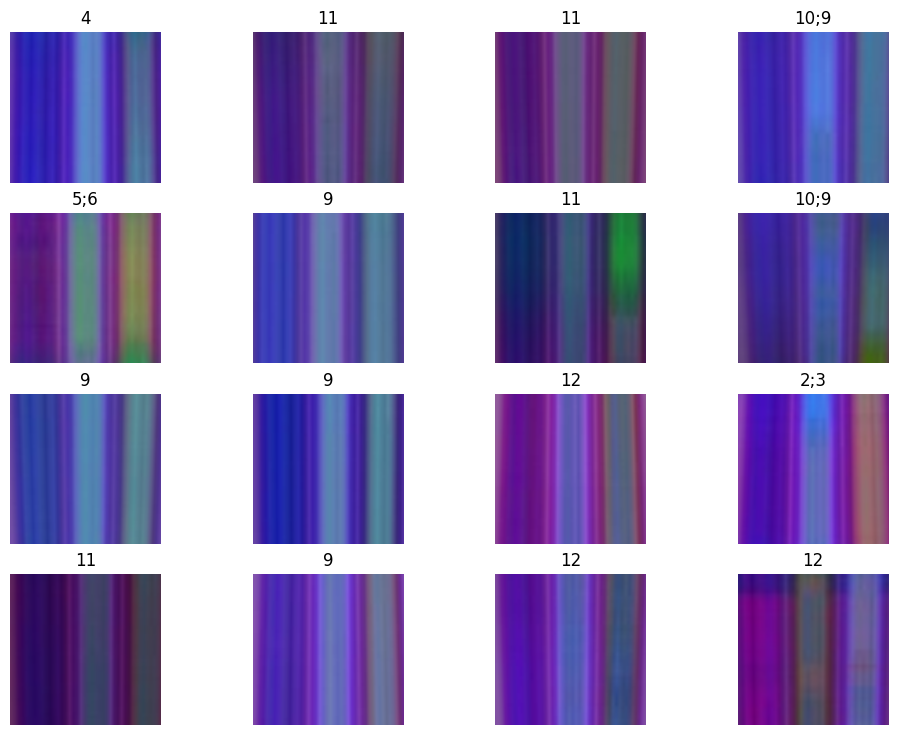

In [10]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

In [9]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [10]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.004365158267319202)

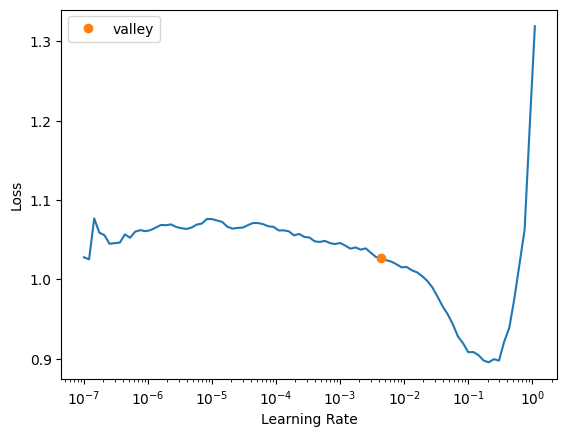

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.296872,0.253863,0.908179,01:10


Better model found at epoch 0 with accuracy_multi value: 0.9081788063049316.


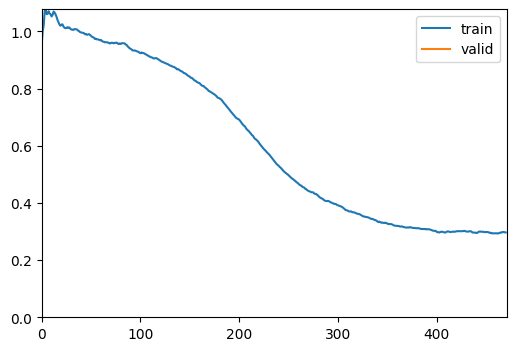

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226876,0.217353,0.914287,01:33
1,0.220800,0.231142,0.919456,01:33
2,0.214047,0.200238,0.921197,01:33
3,0.196476,0.197440,0.922552,01:33
4,0.198645,0.191190,0.923105,01:33
5,0.186754,0.184607,0.926339,01:33
6,0.176857,0.179847,0.928384,01:33
7,0.178133,0.177422,0.928937,01:33
8,0.180106,0.180614,0.929434,01:33
9,0.174374,0.170378,0.934078,01:33


Better model found at epoch 0 with accuracy_multi value: 0.9142869114875793.


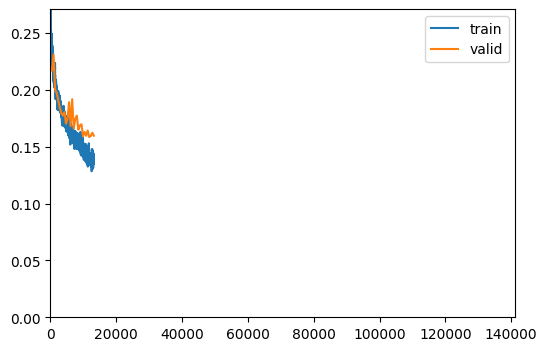

Better model found at epoch 1 with accuracy_multi value: 0.9194563031196594.
Better model found at epoch 2 with accuracy_multi value: 0.9211972951889038.
Better model found at epoch 3 with accuracy_multi value: 0.9225518107414246.
Better model found at epoch 4 with accuracy_multi value: 0.9231047630310059.
Better model found at epoch 5 with accuracy_multi value: 0.9263386726379395.
Better model found at epoch 6 with accuracy_multi value: 0.928384006023407.
Better model found at epoch 7 with accuracy_multi value: 0.9289366602897644.
Better model found at epoch 8 with accuracy_multi value: 0.929434061050415.
Better model found at epoch 9 with accuracy_multi value: 0.9340782761573792.
Better model found at epoch 13 with accuracy_multi value: 0.9361511468887329.
Better model found at epoch 16 with accuracy_multi value: 0.936316728591919.
Better model found at epoch 20 with accuracy_multi value: 0.9386662244796753.
Better model found at epoch 23 with accuracy_multi value: 0.9392189979553223

In [14]:
learn.fine_tune(300,base_lr=4e-3)

In [30]:
learn.save("Efficientnet_b2_Multiclass")

Path('models/Resnet50_Multiclass.pth')

In [11]:
learn.load('Efficientnet_b2_Multiclass')

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [13]:
dbTest = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [14]:
learn.dls = dlsTest

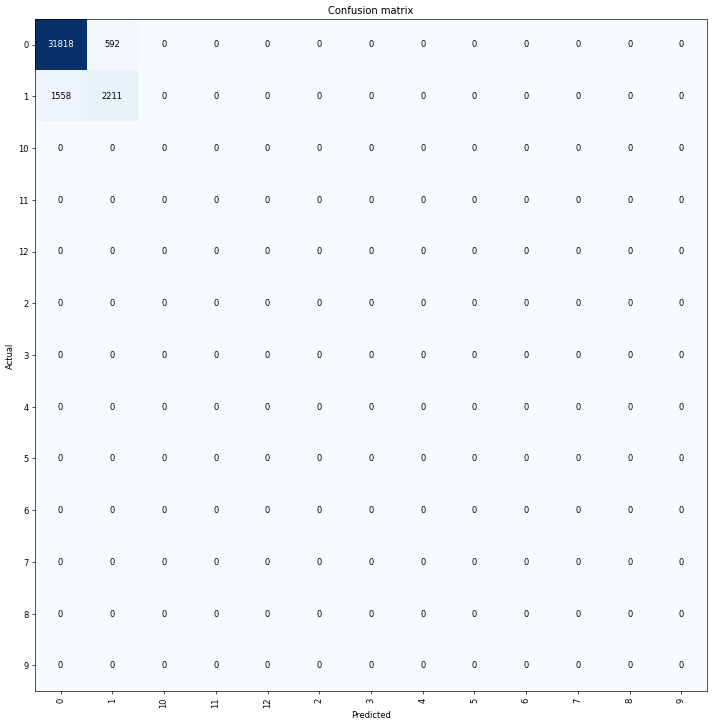

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

(#6) [0.1621910035610199,0.9405756592750549,0.6344895799130026,0.809870434753502,0.5375873754600039,0.9417412032351475]

In [27]:
learn.export(fname='Efficientnet_b2_Multiclass.pkl')

In [26]:
predictions, truth =learn.get_preds()

pred2= []
treshold = 0.5
for predi in predictions:
    adc = []
    for p in predi:
        if p < treshold:
            adc.append(int(0))
        else: adc.append(int(1))
    pred2.append(adc)

In [29]:
print(pred2[5])
print(predictions[5])
print(truth[5])

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
tensor([1.0750e-02, 1.8713e-01, 9.7497e-03, 2.8344e-03, 2.7422e-03, 8.3346e-01,
        5.2590e-02, 6.2330e-03, 1.1020e-03, 3.2454e-04, 1.6984e-04, 1.0447e-03,
        1.2042e-03])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [30]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = multilabel_confusion_matrix(truth, pred2)

In [31]:
vis_arr

array([[[2561,   20],
        [  96,  106]],

       [[2632,    6],
        [  69,   76]],

       [[2515,   36],
        [ 138,   94]],

       [[2348,   43],
        [ 247,  145]],

       [[2217,  104],
        [ 246,  216]],

       [[2498,   10],
        [ 112,  163]],

       [[2466,   15],
        [  87,  215]],

       [[2534,   21],
        [ 113,  115]],

       [[2584,   27],
        [  88,   84]],

       [[2610,   15],
        [  63,   95]],

       [[2581,   37],
        [  57,  108]],

       [[2539,   38],
        [  80,  126]],

       [[1836,  117],
        [ 172,  658]]])

In [32]:
labels = ["".join("c" + str(i)) for i in range(0, 13)]


In [33]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

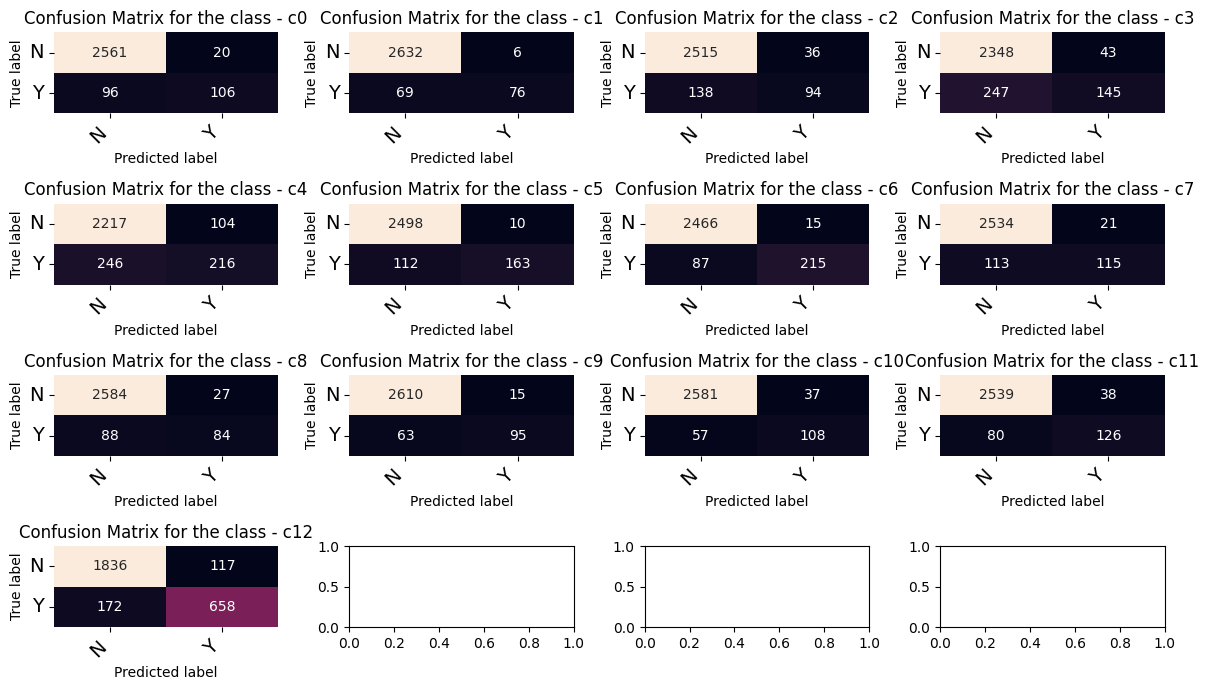

In [35]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, multilabel_confusion_matrix

In [ ]:
with open('resultados_Resnetrs50_Multiclass', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(accuracy_score(np.argmax(preds,axis=1),gt))
    f.write('El F1-score que tenemos en test es:\n')
    f.write(f1_score(np.argmax(preds,axis=1),gt,average='macro'))

# Estas son las pruebas para la predicción del vídeo 002 del usuario 027

In [42]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)

In [43]:
create_csvValid("./dataset_Usr027Video002/test")

In [12]:
dfTest_027 = pd.read_csv('./dataset_Usr027Video002/df_multilabel_test.csv')

In [13]:
dfTest_027.loc[:,'images']=dfTest_027['images'].apply(lambda x: "./dataset_Usr027Video002/test/"+x)

In [14]:
dfTest_027['split'] = True

In [15]:
dfTotal = pd.concat([dfValid,dfTest_027])

In [16]:
dfTest_027

,images,class,split
0,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_0_to_77,0 1 2,True
1,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1_to_78,0 1 2,True
2,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_2_to_79,0 1 2,True
3,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_3_to_80,0 1 2,True
4,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_4_to_81,0 1 2,True
...,...,...,...
1986,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1986_to_2063,0 12,True
1987,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1987_to_2064,0 12,True
1988,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1988_to_2065,0 12,True
1989,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1989_to_2066,0 12,True


In [17]:
dbTest_027 = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest_027 = dbTest_027.dataloaders(dfTotal,bs=4)

In [18]:
learn.dls = dlsTest_027

## Este es para probarlo con el vídeo pero las imágenes están generadas frame a frame para acercarse más a una situación real

In [19]:
path_vid = './dataset_Usr027Video002/test/IDU027V002_20220209_163603'
imgs = []
probs = []
classes_pred = []


for _, line in dfTest_027.iterrows():
    # print(line[0])
    if "IDU027V002_20220209_163603" in line[0]:
        imgs.append(line[0])

for img in imgs:
    img = img + '.jpg'
    predic_class,_,probs1 = learn.predict(img)
    frame = [0]*13
    for preds in predic_class:
        frame[int(preds)]+=1
    # print(img)
    # print(predic_class)
    # print(frame)
    classes_pred.append(frame)
    probs.append(probs1)

['0', '1']
HOLAAAAAAAAAA
tensor([5.2627e-01, 8.0938e-01, 1.2440e-02, 5.0903e-04, 2.8089e-03, 9.9373e-03,
        2.9167e-03, 2.3101e-03, 6.9911e-04, 1.3362e-05, 1.2825e-05, 5.4469e-03,
        3.5269e-01])


['0', '1']
HOLAAAAAAAAAA
tensor([6.6465e-01, 6.9168e-01, 4.7729e-03, 2.9983e-04, 1.0704e-02, 1.1511e-03,
        8.2602e-04, 2.3186e-03, 9.6542e-04, 4.0552e-05, 4.5417e-05, 7.8674e-03,
        4.8848e-01])


['1', '9']
HOLAAAAAAAAAA
tensor([1.6473e-01, 6.8988e-01, 7.7561e-03, 2.2293e-04, 7.3863e-04, 1.9824e-03,
        4.8126e-04, 8.8956e-04, 2.9404e-04, 1.7769e-05, 1.7446e-05, 1.5428e-02,
        7.1917e-01])


['1', '9']
HOLAAAAAAAAAA
tensor([3.5250e-01, 7.5691e-01, 1.0275e-02, 8.6682e-05, 2.3661e-04, 2.9196e-03,
        8.4424e-04, 8.4953e-04, 1.8533e-04, 1.3894e-05, 2.2024e-05, 1.3563e-02,
        7.0628e-01])


['9']
HOLAAAAAAAAAA
tensor([1.2859e-01, 2.0270e-01, 1.3162e-02, 1.1289e-03, 3.6568e-03, 3.0298e-04,
        1.5439e-04, 1.0558e-03, 4.7574e-04, 2.1932e-05, 2.0458e-05, 2.4872e-02,
        7.5312e-01])


['1', '9']
HOLAAAAAAAAAA
tensor([9.8607e-02, 5.7469e-01, 2.8574e-02, 2.7591e-04, 3.7715e-04, 2.3957e-02,
        2.6894e-03, 9.4057e-04, 1.4458e-04, 1.6660e-06, 7.3556e-06, 8.9111e-03,
        7.2117e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3640e-01, 2.7844e-01, 4.0951e-02, 5.9974e-03, 1.2795e-02, 3.9650e-03,
        4.2700e-04, 4.4386e-04, 1.0712e-04, 1.3454e-05, 3.7457e-05, 2.0678e-02,
        6.6982e-01])


['9']
HOLAAAAAAAAAA
tensor([5.9494e-02, 1.6568e-01, 1.3136e-02, 9.9356e-04, 2.1484e-03, 1.0267e-03,
        6.2948e-04, 1.5557e-03, 3.9697e-04, 8.0424e-06, 1.1881e-05, 1.8658e-02,
        7.9038e-01])


['1', '9']
HOLAAAAAAAAAA
tensor([1.8398e-01, 5.4525e-01, 1.5102e-02, 2.8562e-04, 3.3516e-03, 2.4111e-03,
        2.9137e-04, 1.4187e-04, 5.1574e-05, 2.3368e-06, 2.2129e-06, 5.4271e-03,
        7.2077e-01])


[]
HOLAAAAAAAAAA
tensor([1.5321e-01, 4.9514e-01, 2.6559e-02, 4.4772e-03, 6.6705e-03, 9.2638e-03,
        5.3005e-03, 2.4144e-03, 3.8549e-04, 2.0688e-05, 1.4199e-05, 3.6094e-03,
        4.6031e-01])


['1', '9']
HOLAAAAAAAAAA
tensor([9.2464e-02, 5.9637e-01, 2.1372e-02, 3.7462e-04, 1.8188e-03, 6.6695e-03,
        1.1602e-03, 7.3379e-04, 4.3686e-04, 1.2614e-05, 1.0988e-05, 6.4779e-03,
        6.6901e-01])


['9']
HOLAAAAAAAAAA
tensor([5.2519e-02, 6.8778e-02, 3.5507e-02, 6.0187e-03, 8.3048e-03, 5.2509e-04,
        1.2629e-04, 5.2721e-04, 3.6585e-04, 4.1638e-05, 4.1390e-05, 1.8094e-02,
        8.1300e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3956e-01, 3.7993e-01, 3.2877e-03, 2.1869e-04, 1.8356e-03, 3.5774e-03,
        1.9028e-04, 2.3015e-04, 1.1807e-04, 3.7420e-06, 6.7257e-06, 5.6384e-03,
        6.0501e-01])


['9']
HOLAAAAAAAAAA
tensor([6.2307e-02, 1.4747e-01, 5.7771e-03, 3.4953e-04, 6.0571e-03, 4.2536e-03,
        2.0350e-03, 2.0918e-03, 3.9876e-04, 2.9358e-06, 3.3300e-06, 7.0620e-04,
        6.9763e-01])


['9']
HOLAAAAAAAAAA
tensor([6.2539e-02, 2.6764e-01, 8.5367e-02, 1.6641e-03, 3.5867e-03, 7.0998e-02,
        1.2948e-02, 3.6124e-03, 9.4317e-04, 1.7562e-05, 2.4363e-05, 6.5806e-03,
        7.3482e-01])


['9']
HOLAAAAAAAAAA
tensor([5.5454e-02, 2.9531e-01, 5.5495e-02, 1.9406e-03, 4.3717e-03, 1.7559e-02,
        4.3900e-03, 3.9426e-03, 9.1851e-04, 1.4346e-05, 1.3312e-05, 7.0486e-03,
        5.7596e-01])


['9']
HOLAAAAAAAAAA
tensor([5.2976e-02, 2.6018e-01, 4.2552e-02, 6.5567e-04, 1.4572e-03, 8.2430e-03,
        1.3598e-03, 2.3792e-03, 1.0263e-03, 2.1876e-05, 2.0653e-05, 3.8545e-02,
        5.7022e-01])


['9']
HOLAAAAAAAAAA
tensor([5.7307e-02, 1.3006e-01, 7.5630e-02, 3.1131e-03, 2.3103e-03, 1.3491e-02,
        1.0962e-02, 2.5636e-02, 6.1083e-03, 5.4432e-05, 5.6843e-05, 8.4165e-03,
        6.5438e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3006e-02, 2.2988e-01, 6.7779e-02, 4.7171e-04, 4.9263e-04, 1.7257e-02,
        5.1417e-03, 2.2036e-03, 2.5691e-04, 2.3433e-06, 6.8041e-06, 5.4265e-03,
        7.1372e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8785e-02, 4.9893e-02, 8.6921e-02, 4.1907e-03, 1.3221e-03, 2.4406e-02,
        7.1969e-03, 2.1465e-03, 7.0323e-04, 2.1517e-05, 2.6764e-05, 3.3324e-02,
        8.7983e-01])


['9']
HOLAAAAAAAAAA
tensor([9.1969e-03, 7.4431e-02, 1.1967e-01, 1.4773e-03, 7.2825e-04, 1.0921e-01,
        4.1142e-02, 1.0508e-02, 2.3979e-03, 2.2095e-05, 5.5452e-05, 1.3134e-02,
        8.7611e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([2.0702e-02, 2.1679e-01, 8.0772e-02, 3.8346e-04, 3.0611e-04, 5.1882e-01,
        5.4194e-02, 4.4757e-03, 1.1260e-03, 1.0800e-05, 3.8845e-05, 1.4310e-02,
        8.2019e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([4.0741e-03, 3.0357e-01, 3.7218e-01, 2.3757e-03, 3.4964e-04, 8.1887e-01,
        6.6311e-02, 2.5807e-03, 2.3871e-04, 2.5838e-06, 1.3099e-05, 1.8897e-03,
        7.0547e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([8.7694e-03, 1.7426e-01, 1.3278e-01, 2.6629e-03, 3.7042e-04, 8.5635e-01,
        2.2532e-01, 9.5145e-03, 1.7188e-03, 4.0788e-05, 1.2622e-04, 1.4312e-02,
        7.3447e-01])


['2']
HOLAAAAAAAAAA
tensor([2.3807e-03, 2.5425e-01, 1.8704e-01, 8.2662e-04, 5.5039e-04, 9.6811e-01,
        1.4993e-01, 7.4812e-04, 5.8431e-05, 4.9370e-07, 3.5583e-06, 2.6938e-04,
        4.5791e-01])


['2']
HOLAAAAAAAAAA
tensor([9.1297e-03, 4.2346e-01, 7.0597e-02, 3.0918e-03, 2.3776e-04, 9.7803e-01,
        2.8484e-01, 1.1409e-03, 3.7337e-05, 5.8702e-07, 3.5217e-06, 1.5775e-04,
        1.3661e-01])


['2']
HOLAAAAAAAAAA
tensor([8.3864e-03, 2.7689e-01, 1.4044e-01, 1.4719e-03, 6.3026e-04, 9.6301e-01,
        3.3614e-01, 2.6636e-03, 2.1779e-04, 1.6518e-06, 6.1299e-06, 2.0343e-04,
        3.2731e-01])


['2']
HOLAAAAAAAAAA
tensor([1.0295e-02, 4.8412e-01, 6.7700e-02, 1.4569e-03, 5.6116e-04, 9.5445e-01,
        1.9440e-01, 2.9601e-03, 7.0553e-04, 2.5192e-05, 1.1457e-04, 6.9212e-04,
        3.3297e-01])


['2']
HOLAAAAAAAAAA
tensor([1.0166e-02, 4.0171e-01, 6.0737e-02, 1.3326e-03, 3.8358e-04, 9.4655e-01,
        2.6411e-01, 3.1171e-03, 3.3214e-04, 1.9907e-06, 6.7833e-06, 2.6370e-04,
        2.5470e-01])


['2']
HOLAAAAAAAAAA
tensor([3.7755e-03, 3.7640e-01, 6.3798e-02, 6.4302e-04, 8.2397e-05, 9.8084e-01,
        3.9136e-01, 2.6644e-03, 2.3095e-04, 2.5199e-06, 5.9640e-06, 1.0136e-04,
        1.5305e-01])


['2']
HOLAAAAAAAAAA
tensor([3.6615e-03, 4.3548e-01, 7.0957e-02, 1.0722e-03, 4.8233e-04, 9.8910e-01,
        2.7758e-01, 9.1879e-04, 4.4204e-05, 4.7933e-07, 2.3319e-06, 5.0724e-05,
        5.9254e-02])


['2']
HOLAAAAAAAAAA
tensor([1.5944e-02, 4.3215e-01, 6.1892e-02, 1.9066e-03, 4.4102e-04, 9.7282e-01,
        3.5450e-01, 6.0932e-03, 4.9067e-04, 1.0091e-05, 2.6355e-05, 2.9965e-04,
        1.6683e-01])


['2']
HOLAAAAAAAAAA
tensor([1.1361e-02, 3.5603e-01, 1.9169e-01, 3.5553e-03, 5.9710e-04, 9.4227e-01,
        3.7069e-01, 1.1841e-02, 1.6830e-03, 2.1739e-05, 4.4863e-05, 9.0327e-04,
        2.7923e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9122e-03, 3.0653e-01, 1.4818e-01, 2.2210e-02, 5.8025e-04, 9.7419e-01,
        6.2901e-01, 6.5953e-03, 4.7370e-04, 1.9974e-05, 2.9715e-05, 4.0387e-04,
        5.8691e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8949e-03, 2.0672e-01, 9.0862e-02, 1.7523e-03, 2.6262e-04, 9.5821e-01,
        5.3135e-01, 7.1060e-03, 2.6253e-04, 1.1129e-06, 4.8668e-06, 8.1851e-05,
        2.0843e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.8130e-03, 1.7868e-01, 1.2334e-01, 4.0885e-03, 3.5172e-04, 9.7075e-01,
        5.1757e-01, 3.7327e-03, 3.7347e-04, 7.0824e-06, 1.0642e-05, 6.9641e-04,
        2.3983e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([3.3354e-03, 3.5457e-01, 6.6877e-02, 8.2864e-04, 3.9699e-04, 9.9023e-01,
        6.1036e-01, 5.7287e-04, 2.8621e-05, 8.1183e-07, 1.7749e-06, 1.3818e-04,
        1.0253e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([4.5555e-03, 1.7815e-01, 8.4606e-02, 2.7837e-03, 5.0028e-04, 9.6237e-01,
        7.8222e-01, 1.1507e-02, 4.9714e-04, 1.7824e-05, 3.1568e-05, 1.1823e-03,
        1.8801e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.0000e-03, 1.7353e-01, 3.6791e-02, 2.0760e-03, 1.5040e-04, 9.4924e-01,
        8.4947e-01, 1.1781e-02, 4.9810e-04, 1.4557e-05, 3.0943e-05, 2.2520e-03,
        2.9549e-01])


['2']
HOLAAAAAAAAAA
tensor([3.7567e-03, 9.4318e-02, 1.4785e-01, 1.0371e-02, 2.9062e-03, 8.9898e-01,
        3.9196e-01, 8.0594e-03, 8.2657e-04, 1.5238e-05, 3.0655e-05, 1.4962e-03,
        3.7693e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([8.6802e-03, 2.9924e-01, 1.1999e-01, 6.9401e-03, 4.7927e-03, 9.7077e-01,
        6.0487e-01, 4.6128e-03, 5.0954e-04, 1.5094e-05, 3.0154e-05, 1.0178e-03,
        1.8199e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.8157e-03, 1.6619e-01, 1.4648e-01, 1.7500e-02, 1.9469e-03, 9.4745e-01,
        5.0245e-01, 3.2511e-03, 2.8038e-04, 1.2358e-05, 3.8737e-05, 6.6878e-04,
        2.0070e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([7.2164e-04, 5.5842e-02, 9.9739e-02, 3.5490e-03, 2.1724e-03, 9.7269e-01,
        7.9609e-01, 1.1413e-03, 1.5043e-05, 8.7279e-08, 3.9745e-07, 1.1720e-05,
        4.1810e-02])


['2', '9']
HOLAAAAAAAAAA
tensor([2.1196e-03, 1.3599e-01, 1.6452e-01, 1.5321e-03, 4.9108e-04, 9.5241e-01,
        4.0465e-01, 1.7678e-03, 1.6107e-04, 3.8868e-06, 1.7890e-05, 7.5809e-04,
        5.0456e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8149e-03, 2.2866e-01, 4.4066e-02, 2.1085e-03, 8.3848e-04, 9.8240e-01,
        6.0766e-01, 1.2705e-03, 7.8304e-05, 2.6497e-06, 9.4581e-06, 1.8608e-04,
        1.7739e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.0153e-03, 2.9722e-01, 2.5265e-02, 4.2695e-04, 5.2845e-04, 9.8114e-01,
        7.0907e-01, 2.3750e-03, 5.9973e-05, 1.6084e-06, 7.5343e-06, 1.5306e-04,
        1.2232e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([8.5676e-04, 6.3783e-02, 5.2027e-02, 1.4490e-03, 1.4018e-04, 9.2088e-01,
        8.0360e-01, 4.3953e-03, 7.3495e-05, 1.5513e-06, 4.9120e-06, 4.3431e-04,
        3.9618e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.5711e-03, 1.9614e-01, 5.9461e-02, 2.4844e-03, 3.9463e-04, 9.6564e-01,
        5.9672e-01, 3.4083e-03, 2.6244e-04, 5.9619e-06, 1.0556e-05, 6.9802e-04,
        2.0886e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.8783e-03, 1.4202e-01, 1.9674e-02, 6.3460e-04, 4.6373e-04, 9.6688e-01,
        8.7703e-01, 7.3123e-03, 3.0146e-04, 7.3046e-06, 1.4459e-05, 3.7903e-04,
        1.4921e-01])


['2']
HOLAAAAAAAAAA
tensor([3.5201e-03, 4.0381e-02, 7.4539e-02, 1.3706e-02, 9.3276e-04, 7.5552e-01,
        3.6919e-01, 6.0837e-03, 2.9702e-04, 4.2054e-06, 7.3600e-06, 2.9681e-04,
        3.0647e-01])


['2']
HOLAAAAAAAAAA
tensor([9.3667e-04, 4.4173e-02, 9.0732e-02, 3.3463e-03, 6.5953e-04, 7.3594e-01,
        2.7367e-01, 2.1601e-03, 9.4752e-05, 7.2261e-07, 2.2592e-06, 4.6944e-05,
        3.5940e-01])


['2']
HOLAAAAAAAAAA
tensor([4.4215e-04, 2.5510e-02, 4.5548e-02, 3.9589e-03, 3.8566e-04, 9.2785e-01,
        3.8263e-01, 2.7518e-04, 5.5913e-06, 6.8663e-08, 1.9783e-07, 1.6167e-05,
        2.6623e-01])


['2']
HOLAAAAAAAAAA
tensor([1.7757e-03, 1.2254e-01, 4.2872e-02, 3.2856e-03, 1.2732e-03, 9.7139e-01,
        4.8529e-01, 6.1194e-04, 1.5452e-05, 2.4941e-07, 1.1353e-06, 7.3182e-05,
        2.2951e-01])


['2']
HOLAAAAAAAAAA
tensor([7.5527e-04, 2.9458e-02, 3.3151e-02, 2.9557e-03, 2.0459e-04, 7.3181e-01,
        2.6763e-01, 1.7501e-03, 2.2928e-05, 6.7374e-07, 5.7983e-06, 3.9964e-04,
        3.9904e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1473e-03, 1.3311e-01, 1.6181e-02, 2.0611e-03, 1.9728e-04, 9.3754e-01,
        8.5533e-01, 3.6094e-03, 1.8841e-04, 4.1592e-05, 9.0195e-05, 4.5182e-03,
        3.6037e-01])


['2']
HOLAAAAAAAAAA
tensor([6.0481e-04, 4.0285e-02, 1.4258e-01, 1.6101e-03, 4.9012e-04, 8.6133e-01,
        3.4625e-01, 1.0481e-03, 3.4481e-05, 1.0681e-06, 7.8652e-06, 6.0241e-04,
        3.9961e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8288e-03, 1.1451e-01, 1.9139e-02, 7.0844e-04, 5.3497e-04, 9.6688e-01,
        7.0946e-01, 1.0389e-03, 4.4573e-05, 5.0841e-07, 1.6672e-06, 2.7823e-04,
        2.3969e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([4.8349e-03, 1.4603e-01, 4.3246e-02, 6.2776e-03, 9.4219e-04, 9.7730e-01,
        5.7804e-01, 7.8810e-04, 3.5210e-05, 3.0243e-06, 1.1122e-05, 1.0749e-03,
        1.7683e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([7.4457e-04, 5.1900e-02, 1.9523e-02, 7.6543e-04, 1.9105e-04, 9.7635e-01,
        9.0161e-01, 7.3676e-03, 1.1193e-04, 2.9481e-07, 1.5217e-06, 2.3021e-04,
        1.3241e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([8.5234e-04, 1.2245e-01, 5.7916e-02, 1.1759e-03, 5.3422e-04, 9.7590e-01,
        5.4821e-01, 7.1925e-04, 1.6284e-05, 1.3871e-07, 1.7824e-06, 7.3247e-05,
        1.6731e-01])


['2']
HOLAAAAAAAAAA
tensor([7.1258e-04, 1.7780e-02, 4.6738e-02, 2.1474e-03, 9.4203e-04, 8.6322e-01,
        3.6458e-01, 1.0460e-03, 3.5696e-05, 3.6758e-07, 1.2287e-06, 1.2398e-04,
        2.9833e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([7.4018e-04, 1.1967e-01, 1.9546e-02, 3.8852e-04, 2.6593e-04, 9.8763e-01,
        9.0782e-01, 1.0161e-03, 7.7951e-06, 1.2336e-07, 1.4316e-06, 5.2061e-05,
        4.3607e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.9202e-04, 3.3165e-02, 3.6613e-02, 3.5560e-04, 1.4011e-04, 9.6715e-01,
        6.1698e-01, 4.1030e-04, 1.0398e-05, 1.1023e-07, 7.0189e-07, 8.9243e-05,
        3.0847e-01])


['2']
HOLAAAAAAAAAA
tensor([3.3109e-04, 5.5864e-02, 2.6201e-02, 1.3890e-04, 7.3288e-05, 9.5999e-01,
        3.4751e-01, 1.2881e-04, 2.8184e-06, 1.7680e-08, 1.1663e-07, 2.9321e-05,
        3.4238e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.0534e-03, 8.5535e-02, 3.4005e-02, 1.8725e-04, 6.8248e-05, 9.5267e-01,
        5.9241e-01, 1.9778e-03, 1.1182e-04, 1.3090e-06, 4.6004e-06, 2.0352e-04,
        4.2861e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([6.9511e-03, 4.2761e-02, 2.2149e-02, 1.0260e-03, 4.9788e-04, 9.1498e-01,
        7.1289e-01, 6.0507e-03, 5.3460e-04, 8.9538e-06, 1.0458e-05, 1.2950e-03,
        4.5464e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([4.3235e-03, 1.5425e-01, 7.8002e-02, 1.3562e-03, 7.9256e-04, 9.8283e-01,
        7.0760e-01, 2.0178e-03, 2.2840e-04, 5.8012e-06, 1.4967e-05, 8.8315e-04,
        1.8414e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([7.5593e-04, 5.5629e-02, 3.4288e-02, 2.4548e-04, 2.4360e-04, 9.8685e-01,
        7.6605e-01, 6.2431e-04, 2.7267e-05, 1.9994e-07, 8.8888e-07, 6.5525e-05,
        2.0425e-01])


['2']
HOLAAAAAAAAAA
tensor([1.8821e-04, 1.5175e-02, 2.5207e-02, 9.3182e-04, 1.1782e-04, 9.1360e-01,
        1.6718e-01, 3.0007e-04, 1.8674e-05, 6.5261e-08, 1.8383e-07, 1.2338e-05,
        3.9990e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([8.5717e-04, 7.6406e-02, 4.0761e-02, 1.2038e-03, 2.7829e-04, 9.7463e-01,
        7.9038e-01, 2.2744e-03, 5.6690e-05, 7.0683e-07, 4.0412e-06, 6.6062e-05,
        6.5871e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.4952e-04, 2.2421e-02, 4.7054e-02, 8.7572e-03, 9.7947e-04, 9.5848e-01,
        8.4644e-01, 9.3593e-03, 5.2561e-04, 1.1483e-05, 2.0255e-05, 3.7699e-04,
        9.0259e-02])


['2']
HOLAAAAAAAAAA
tensor([3.0796e-04, 4.2953e-02, 7.1135e-02, 2.1374e-03, 1.1951e-04, 9.3829e-01,
        4.3070e-01, 3.5310e-03, 4.2081e-04, 2.6712e-06, 6.4608e-06, 1.2693e-04,
        1.8994e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([9.2084e-04, 5.3342e-02, 2.8002e-02, 8.4843e-04, 1.8193e-04, 9.6571e-01,
        8.0517e-01, 6.5380e-03, 2.5374e-04, 4.2275e-07, 7.0810e-07, 5.3132e-05,
        1.3809e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.7388e-03, 3.6100e-02, 7.3007e-02, 4.3506e-03, 2.0978e-04, 9.0331e-01,
        7.7991e-01, 2.4079e-02, 2.0578e-03, 1.9880e-05, 2.3127e-05, 1.6661e-03,
        3.0919e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3458e-03, 1.3272e-01, 6.6112e-02, 1.0666e-03, 1.7898e-04, 9.8573e-01,
        7.2659e-01, 3.4747e-03, 1.9517e-04, 1.5477e-06, 5.3869e-06, 1.5321e-04,
        1.1043e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3709e-03, 9.2091e-02, 4.1281e-02, 6.3263e-04, 8.5814e-05, 9.7856e-01,
        7.2896e-01, 6.3333e-03, 9.5826e-04, 9.8626e-06, 1.9988e-05, 3.0912e-04,
        1.4313e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.2002e-03, 2.2336e-02, 6.8525e-02, 4.2735e-03, 1.4897e-04, 7.5041e-01,
        4.7611e-01, 3.0908e-02, 4.9468e-03, 5.5573e-05, 3.5072e-05, 1.2125e-03,
        5.6665e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8832e-03, 8.6885e-02, 2.4888e-01, 1.0825e-02, 5.3452e-04, 9.4326e-01,
        6.9613e-01, 6.2866e-03, 2.7750e-04, 4.4346e-06, 8.8340e-06, 4.6075e-04,
        3.1824e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([3.4398e-04, 5.6501e-02, 6.5728e-02, 1.8239e-04, 3.9545e-05, 9.3884e-01,
        6.4084e-01, 3.3811e-03, 4.3478e-04, 5.4073e-06, 1.1115e-05, 4.5234e-04,
        4.9998e-01])


['2']
HOLAAAAAAAAAA
tensor([4.8598e-04, 1.3714e-01, 1.4132e-01, 2.7777e-03, 2.5168e-04, 9.4808e-01,
        4.2397e-01, 1.1475e-03, 2.0001e-04, 7.8935e-06, 1.3945e-05, 3.9980e-04,
        3.8543e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.9778e-03, 6.5657e-02, 6.6393e-02, 2.0603e-03, 1.8460e-04, 8.5024e-01,
        2.6568e-01, 8.3412e-03, 1.0453e-03, 1.5939e-05, 2.3642e-05, 1.0868e-03,
        6.0085e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([7.0497e-04, 2.1976e-02, 9.3304e-02, 1.1771e-03, 7.4048e-05, 5.6217e-01,
        2.1881e-01, 1.0290e-02, 1.0100e-03, 6.5660e-06, 9.4200e-06, 2.6217e-03,
        8.4998e-01])


['2', '3', '9']
HOLAAAAAAAAAA
tensor([8.5751e-04, 1.0221e-01, 8.1420e-02, 1.8463e-03, 1.1329e-04, 9.0639e-01,
        6.8862e-01, 8.2669e-03, 9.3350e-04, 2.2366e-05, 3.5221e-05, 1.2792e-03,
        5.8907e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1481e-03, 5.0453e-02, 1.3829e-01, 1.6704e-03, 7.9485e-04, 9.0229e-01,
        5.7694e-01, 2.4057e-03, 1.6133e-04, 3.4084e-06, 5.7920e-06, 2.6238e-04,
        4.9107e-01])


['9']
HOLAAAAAAAAAA
tensor([6.6614e-04, 1.6677e-02, 7.8171e-02, 1.4153e-03, 4.5862e-04, 4.1173e-01,
        5.2820e-02, 6.4359e-04, 1.1005e-04, 3.5075e-06, 5.2838e-06, 3.9597e-04,
        8.5951e-01])


['2']
HOLAAAAAAAAAA
tensor([3.9489e-04, 3.3093e-02, 1.7488e-01, 1.6065e-03, 4.9879e-04, 8.7487e-01,
        1.5265e-01, 2.3751e-04, 9.4506e-06, 4.8538e-08, 2.9446e-07, 5.4334e-05,
        4.6919e-01])


['2']
HOLAAAAAAAAAA
tensor([2.8003e-03, 7.0418e-02, 1.8741e-02, 1.6875e-03, 1.4891e-03, 9.2240e-01,
        3.0778e-01, 5.7784e-04, 5.9985e-05, 3.6915e-06, 9.4370e-06, 6.7162e-04,
        4.1480e-01])


['2']
HOLAAAAAAAAAA
tensor([4.0385e-04, 5.8300e-02, 2.7059e-02, 2.4677e-04, 1.3102e-04, 9.1133e-01,
        2.5600e-01, 1.2847e-04, 6.8992e-06, 3.8895e-08, 8.9513e-08, 4.2025e-05,
        4.9689e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([9.6635e-04, 1.8754e-01, 1.5941e-02, 9.5856e-04, 7.9856e-05, 9.7972e-01,
        7.9052e-01, 1.1021e-03, 4.8172e-05, 6.1683e-07, 1.6646e-06, 1.5962e-04,
        2.0421e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([8.2480e-04, 4.6199e-02, 2.2807e-02, 7.9649e-04, 1.0678e-04, 9.0649e-01,
        4.7816e-01, 1.4546e-03, 5.6116e-05, 6.6160e-07, 1.0785e-06, 5.9260e-04,
        5.4569e-01])


['2']
HOLAAAAAAAAAA
tensor([2.6898e-03, 1.1679e-01, 4.7773e-02, 4.7364e-03, 2.5089e-03, 9.5392e-01,
        4.0771e-01, 5.5143e-04, 1.7937e-05, 1.9573e-07, 3.6586e-07, 4.9098e-05,
        2.6388e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([2.0292e-03, 4.6779e-02, 1.8919e-02, 1.4226e-03, 9.5690e-04, 7.9611e-01,
        2.9426e-01, 2.5667e-03, 2.1759e-04, 4.9874e-06, 1.5667e-05, 1.2423e-03,
        6.0114e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.1595e-02, 6.5562e-02, 3.3465e-02, 5.0468e-03, 2.5373e-03, 8.0760e-01,
        1.2342e-01, 2.1519e-03, 6.2193e-04, 2.5410e-05, 1.9330e-05, 3.7247e-03,
        6.0125e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([2.9636e-03, 4.1449e-02, 8.2323e-02, 2.0934e-03, 6.7660e-04, 5.0307e-01,
        6.4991e-02, 1.0055e-03, 8.4741e-05, 1.6179e-06, 2.6170e-06, 4.9457e-04,
        8.2667e-01])


['2', '3', '9']
HOLAAAAAAAAAA
tensor([2.7561e-03, 1.6819e-01, 5.4340e-03, 1.7677e-05, 2.2890e-04, 9.1117e-01,
        5.0445e-01, 3.0785e-04, 2.9055e-05, 5.4303e-07, 3.9268e-07, 8.8233e-05,
        5.7775e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([4.1774e-03, 1.2330e-01, 2.7494e-02, 1.4922e-03, 4.5843e-04, 9.1298e-01,
        2.0937e-01, 3.6055e-04, 3.3850e-05, 1.7157e-06, 1.4502e-06, 5.3401e-04,
        5.1647e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([3.8298e-03, 1.3460e-01, 3.4719e-02, 3.0702e-04, 1.9481e-04, 8.3201e-01,
        2.0834e-01, 5.7148e-04, 5.5713e-05, 1.2332e-06, 1.6121e-06, 8.5229e-04,
        5.6375e-01])


['2', '3', '9']
HOLAAAAAAAAAA
tensor([4.2531e-03, 6.2432e-02, 2.6386e-02, 6.4170e-04, 4.6566e-04, 9.1737e-01,
        5.7288e-01, 1.0088e-03, 4.1944e-05, 1.2200e-06, 1.3713e-06, 5.6095e-04,
        5.1843e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([6.8427e-03, 1.7150e-01, 1.9382e-02, 6.9447e-04, 5.7139e-04, 9.2257e-01,
        3.5695e-01, 8.6344e-04, 1.0638e-04, 5.3260e-06, 7.6131e-06, 5.4698e-03,
        5.9267e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([7.9312e-03, 1.0149e-01, 8.6281e-03, 9.4360e-05, 1.5028e-04, 7.0744e-01,
        1.7736e-01, 6.2576e-04, 8.7211e-05, 6.6841e-06, 6.2019e-06, 4.8722e-03,
        8.5037e-01])


['2']
HOLAAAAAAAAAA
tensor([8.6751e-03, 1.8528e-01, 2.5821e-02, 7.4666e-04, 1.9252e-03, 9.2018e-01,
        1.8096e-01, 1.9903e-04, 9.8619e-06, 2.8137e-07, 8.5028e-07, 1.2854e-04,
        3.2140e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.5715e-02, 2.3609e-01, 3.1349e-02, 1.8339e-04, 5.1502e-04, 8.6977e-01,
        5.6263e-02, 2.2587e-04, 2.0326e-05, 1.8930e-07, 9.1911e-07, 1.9810e-04,
        5.3055e-01])


['2']
HOLAAAAAAAAAA
tensor([1.2411e-02, 4.6231e-01, 1.2062e-02, 2.8975e-04, 1.5227e-03, 8.9044e-01,
        1.6432e-01, 3.2861e-04, 2.3711e-05, 1.0249e-06, 1.5575e-06, 1.8656e-04,
        3.2867e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6169e-03, 1.8748e-01, 7.1699e-03, 1.9057e-05, 8.1419e-05, 9.7553e-01,
        5.4233e-01, 5.3534e-04, 1.5785e-05, 1.1832e-07, 3.5211e-07, 1.5739e-04,
        3.2869e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([2.1134e-03, 2.1814e-01, 2.2067e-02, 5.3221e-05, 5.8371e-05, 7.8195e-01,
        1.3913e-01, 5.3946e-04, 4.4566e-05, 6.4929e-07, 1.1353e-06, 6.3601e-04,
        8.0118e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([3.4294e-03, 5.6713e-02, 1.1944e-02, 8.1224e-06, 5.0105e-05, 5.3364e-01,
        1.2932e-01, 1.2752e-03, 1.1742e-04, 1.3177e-06, 4.4235e-06, 8.1253e-03,
        9.2009e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([5.2880e-03, 3.3148e-01, 2.6267e-02, 8.7847e-05, 3.1214e-04, 9.6932e-01,
        4.1280e-01, 6.1725e-04, 3.1164e-05, 4.9281e-07, 1.3177e-06, 2.8707e-04,
        5.6595e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9883e-03, 1.8165e-02, 2.0913e-02, 2.1632e-04, 1.7495e-04, 3.0704e-01,
        5.5579e-02, 1.4067e-03, 1.7083e-04, 2.3016e-06, 5.6536e-06, 7.7216e-03,
        9.2650e-01])


['9']
HOLAAAAAAAAAA
tensor([2.2653e-03, 2.6067e-02, 9.8698e-02, 3.3593e-04, 7.8875e-04, 4.6292e-01,
        1.3926e-01, 1.6607e-03, 2.1113e-04, 3.2247e-06, 5.1402e-06, 9.0463e-04,
        9.1657e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([9.4073e-03, 2.2148e-01, 2.9923e-02, 3.2761e-05, 5.4952e-04, 8.9227e-01,
        2.3301e-01, 7.6826e-04, 7.1460e-05, 6.4148e-07, 1.2569e-06, 7.0709e-04,
        6.7455e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([8.9181e-03, 4.1753e-02, 1.4498e-02, 4.2410e-05, 4.5453e-04, 5.0416e-01,
        1.6656e-01, 6.4666e-03, 2.1240e-03, 1.3909e-05, 7.7450e-06, 2.2253e-03,
        7.7857e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5381e-03, 1.7310e-02, 2.1458e-01, 1.5025e-04, 1.2426e-03, 3.1764e-01,
        3.7060e-02, 1.3430e-03, 2.1524e-04, 1.0027e-06, 1.1845e-06, 1.7468e-04,
        9.0541e-01])


['9']
HOLAAAAAAAAAA
tensor([3.5562e-04, 6.4724e-03, 4.2044e-02, 4.0735e-04, 3.2271e-04, 2.7721e-01,
        2.6393e-01, 8.7345e-03, 7.9327e-04, 8.2966e-06, 8.3191e-06, 5.1366e-04,
        8.7902e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([9.7658e-04, 3.0093e-02, 2.2010e-02, 3.8117e-04, 2.5706e-03, 7.2087e-01,
        1.8089e-01, 9.4508e-04, 5.2463e-05, 2.6533e-07, 6.1019e-07, 7.6115e-05,
        5.9782e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([3.5424e-03, 3.1276e-02, 2.8262e-02, 9.7487e-04, 9.0269e-04, 6.2270e-01,
        2.7999e-01, 1.7562e-02, 1.8716e-03, 1.7574e-05, 1.1937e-05, 1.9366e-03,
        7.7589e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4696e-03, 1.6732e-02, 7.5030e-02, 6.7420e-05, 1.1519e-04, 6.1808e-02,
        2.4626e-02, 1.0056e-02, 2.8979e-03, 1.1428e-05, 1.2631e-05, 3.7038e-03,
        9.5136e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.7002e-03, 4.1265e-02, 3.7213e-02, 3.9868e-05, 2.4700e-04, 5.0287e-01,
        2.0143e-01, 3.0800e-03, 6.5169e-04, 6.8723e-06, 1.0148e-05, 1.2821e-03,
        9.2440e-01])


['9']
HOLAAAAAAAAAA
tensor([6.8323e-03, 6.5669e-02, 1.1735e-01, 2.2737e-04, 3.2023e-03, 3.7322e-01,
        8.2671e-02, 2.8395e-03, 5.6500e-04, 5.3502e-06, 7.0178e-06, 2.8697e-04,
        8.3273e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.1271e-02, 1.1025e-01, 3.4542e-02, 3.8125e-04, 1.8407e-03, 5.0051e-01,
        1.4311e-01, 6.0380e-03, 1.4966e-03, 2.1526e-05, 2.2647e-05, 1.4155e-03,
        7.5326e-01])


['9']
HOLAAAAAAAAAA
tensor([1.2187e-03, 2.2061e-02, 1.3629e-01, 1.1231e-04, 7.3342e-04, 6.8018e-02,
        4.6287e-02, 6.2223e-03, 8.0835e-04, 2.2747e-06, 2.2433e-06, 3.0759e-04,
        8.9730e-01])


['9']
HOLAAAAAAAAAA
tensor([9.1148e-04, 6.4649e-03, 2.2723e-01, 3.6991e-04, 1.9585e-04, 4.3244e-02,
        1.6575e-02, 2.5369e-03, 2.7882e-04, 2.2465e-06, 2.8327e-06, 1.4181e-03,
        8.6583e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5973e-03, 1.1082e-02, 6.3120e-02, 2.4528e-04, 1.6503e-04, 9.2714e-02,
        4.2512e-02, 1.0009e-02, 1.7702e-03, 6.4169e-06, 6.2532e-06, 3.1407e-03,
        9.5263e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3671e-03, 2.9939e-02, 1.2212e-01, 2.0308e-04, 2.5719e-04, 3.7789e-01,
        1.3766e-01, 3.9470e-03, 3.9850e-04, 4.4376e-06, 7.7320e-06, 1.9963e-03,
        9.2474e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([4.1686e-03, 7.5063e-02, 3.2563e-02, 7.5699e-05, 1.1040e-04, 5.6342e-01,
        1.6534e-01, 1.6114e-03, 1.9561e-04, 1.8015e-06, 4.1482e-06, 2.4624e-03,
        9.1170e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.0314e-02, 2.8701e-01, 7.1412e-02, 6.7128e-05, 7.1105e-04, 9.1408e-01,
        2.7733e-01, 1.0785e-03, 1.1268e-04, 3.1970e-06, 8.6018e-06, 8.5419e-04,
        6.5171e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([5.7233e-03, 1.3243e-01, 1.0106e-01, 7.7617e-05, 3.9492e-04, 8.5909e-01,
        2.5299e-01, 8.2058e-04, 4.3993e-05, 3.0584e-07, 1.0118e-06, 2.2341e-04,
        7.4798e-01])


['2']
HOLAAAAAAAAAA
tensor([1.5480e-02, 2.7990e-01, 4.1646e-02, 4.8851e-04, 1.9055e-03, 9.2985e-01,
        2.3928e-01, 1.2204e-03, 1.9698e-04, 4.3103e-06, 9.0178e-06, 1.5300e-03,
        3.1363e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.6309e-02, 1.7333e-01, 4.4335e-02, 2.8316e-04, 4.5320e-03, 7.4039e-01,
        1.8882e-01, 7.7427e-04, 4.0987e-05, 7.7137e-07, 2.2057e-06, 1.7365e-04,
        5.8146e-01])


['2']
HOLAAAAAAAAAA
tensor([4.9008e-03, 1.2413e-01, 9.0853e-02, 6.1597e-05, 1.8131e-04, 9.2334e-01,
        2.6168e-01, 9.0320e-04, 3.5015e-05, 1.8454e-07, 8.0583e-07, 4.3324e-05,
        3.9266e-01])


['2']
HOLAAAAAAAAAA
tensor([7.8639e-03, 1.1510e-01, 1.2657e-01, 4.2293e-04, 8.1413e-04, 7.6650e-01,
        9.9281e-02, 4.7267e-04, 1.7683e-05, 1.4489e-07, 7.5157e-07, 7.3119e-05,
        3.8774e-01])


['2']
HOLAAAAAAAAAA
tensor([9.9543e-03, 2.0889e-01, 8.8977e-02, 5.3566e-04, 5.8460e-04, 8.9044e-01,
        1.8691e-01, 1.2938e-03, 1.1954e-04, 1.8777e-06, 4.3690e-06, 3.1316e-04,
        2.7497e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7959e-03, 7.6884e-03, 8.5374e-02, 9.2046e-04, 4.1395e-04, 1.6890e-01,
        5.3957e-02, 2.8907e-03, 2.4603e-04, 1.1688e-06, 1.2652e-06, 3.3445e-04,
        9.2329e-01])


[]
HOLAAAAAAAAAA
tensor([9.5478e-03, 2.5353e-02, 4.0700e-02, 1.1106e-04, 1.9398e-03, 4.6639e-01,
        9.4399e-02, 4.5768e-03, 2.5505e-04, 1.6848e-07, 2.2865e-07, 9.8300e-06,
        4.0479e-01])


['9']
HOLAAAAAAAAAA
tensor([6.9058e-03, 7.0983e-02, 9.8459e-02, 2.4340e-04, 5.4893e-04, 4.4269e-01,
        1.6609e-01, 7.9456e-03, 2.7406e-04, 7.9114e-07, 2.0010e-06, 1.1966e-04,
        5.8829e-01])


['2']
HOLAAAAAAAAAA
tensor([9.2091e-03, 1.1512e-01, 1.0766e-01, 4.2472e-04, 1.9023e-03, 7.2757e-01,
        2.0737e-01, 5.6257e-03, 3.6377e-04, 3.0182e-06, 6.9257e-06, 5.4427e-04,
        4.8933e-01])


['2']
HOLAAAAAAAAAA
tensor([7.7431e-03, 1.4898e-01, 1.0991e-01, 1.5594e-04, 1.2382e-03, 7.4407e-01,
        2.4645e-01, 5.3514e-03, 4.6417e-04, 1.9727e-06, 4.6382e-06, 1.3222e-04,
        4.3902e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([2.2443e-03, 4.1666e-02, 1.6923e-01, 6.0414e-04, 2.3649e-04, 5.6493e-01,
        3.1731e-01, 3.4904e-02, 2.3884e-03, 1.9579e-05, 2.5250e-05, 1.2518e-03,
        6.7235e-01])


['2']
HOLAAAAAAAAAA
tensor([6.8003e-03, 6.3293e-02, 1.8751e-01, 1.0133e-03, 3.1519e-04, 6.1487e-01,
        2.2213e-01, 3.4792e-02, 2.8602e-03, 2.9504e-05, 4.1616e-05, 2.5944e-03,
        3.6057e-01])


[]
HOLAAAAAAAAAA
tensor([1.7699e-03, 3.3549e-02, 1.5731e-01, 5.3130e-05, 1.8056e-05, 4.7246e-01,
        2.2033e-01, 2.4680e-02, 2.1464e-03, 5.5112e-06, 8.2156e-06, 5.6618e-04,
        4.6048e-01])


['2']
HOLAAAAAAAAAA
tensor([1.4806e-02, 1.5077e-01, 2.1276e-01, 8.5334e-04, 6.5554e-04, 5.6796e-01,
        2.5221e-01, 1.2998e-02, 1.9307e-03, 1.0986e-05, 1.9211e-05, 2.6618e-03,
        1.8672e-01])


['2']
HOLAAAAAAAAAA
tensor([8.5021e-03, 1.6508e-01, 3.3629e-01, 9.1193e-04, 1.0822e-03, 7.7731e-01,
        4.1064e-01, 1.3244e-02, 3.7264e-04, 1.6475e-06, 7.4759e-06, 2.5416e-04,
        1.7123e-01])


['2']
HOLAAAAAAAAAA
tensor([1.4719e-02, 1.5009e-01, 1.9586e-01, 3.9861e-04, 1.5846e-03, 9.1758e-01,
        3.4971e-01, 2.3786e-03, 8.9315e-05, 1.4738e-06, 9.4953e-06, 3.5531e-04,
        1.0436e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([4.8294e-03, 1.2646e-01, 3.5424e-01, 1.1419e-03, 1.0168e-03, 6.3960e-01,
        1.8017e-01, 8.5147e-03, 7.9168e-04, 8.4674e-06, 2.4964e-05, 4.5509e-03,
        6.2432e-01])


['2']
HOLAAAAAAAAAA
tensor([6.7211e-03, 1.0125e-01, 3.9662e-01, 5.6760e-04, 7.3638e-04, 5.9147e-01,
        1.7774e-01, 5.4343e-03, 6.0742e-04, 3.6137e-06, 1.0501e-05, 3.6940e-04,
        4.8000e-01])


['2']
HOLAAAAAAAAAA
tensor([1.2591e-03, 3.2762e-02, 3.5493e-01, 8.8653e-04, 4.8871e-04, 8.4730e-01,
        4.3009e-01, 3.0522e-03, 3.6778e-05, 2.1063e-07, 8.8992e-07, 1.0753e-04,
        2.9611e-01])


['2']
HOLAAAAAAAAAA
tensor([1.4750e-02, 8.6714e-02, 1.9015e-01, 1.9471e-03, 3.1791e-03, 9.1388e-01,
        4.6734e-01, 4.9703e-03, 2.2457e-04, 5.2911e-06, 1.4048e-05, 5.5262e-04,
        1.8199e-01])


['2']
HOLAAAAAAAAAA
tensor([5.6510e-03, 8.3914e-02, 1.8070e-01, 2.9086e-03, 1.4476e-03, 9.1657e-01,
        4.0954e-01, 8.3134e-03, 5.5719e-04, 1.5618e-05, 5.1348e-05, 2.7747e-03,
        3.6352e-01])


['2']
HOLAAAAAAAAAA
tensor([6.6041e-03, 4.2045e-02, 2.4030e-01, 1.9247e-03, 3.3433e-03, 7.7628e-01,
        4.1549e-01, 3.6441e-03, 8.6946e-05, 7.4944e-07, 2.7557e-06, 1.8446e-04,
        2.6388e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([3.0032e-03, 2.6681e-02, 3.5690e-01, 2.3929e-03, 1.4962e-03, 6.3161e-01,
        1.9295e-01, 7.1623e-03, 3.5966e-04, 1.8530e-06, 8.6661e-06, 6.8466e-04,
        5.1999e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([9.6530e-03, 8.2064e-02, 1.2292e-01, 1.4656e-03, 2.9576e-03, 8.6279e-01,
        4.5573e-01, 6.5609e-03, 3.1100e-04, 7.7912e-06, 1.4810e-05, 9.7753e-04,
        5.4615e-01])


['2', '3', '9']
HOLAAAAAAAAAA
tensor([5.1442e-03, 1.0509e-01, 2.2098e-01, 4.1386e-03, 2.2518e-03, 9.4350e-01,
        6.6537e-01, 8.5873e-03, 4.4002e-04, 1.4836e-05, 2.8471e-05, 1.7313e-03,
        5.1376e-01])


['2']
HOLAAAAAAAAAA
tensor([3.0482e-03, 8.0414e-02, 1.0826e-01, 1.1008e-03, 2.9778e-03, 9.2913e-01,
        4.3275e-01, 4.1209e-03, 5.9401e-04, 1.2419e-05, 1.9402e-05, 2.7435e-04,
        3.0305e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3284e-03, 3.7380e-02, 1.0581e-01, 3.2799e-03, 7.6727e-04, 9.4963e-01,
        6.5414e-01, 4.5801e-03, 5.4949e-05, 4.8708e-07, 1.4519e-06, 2.3368e-04,
        2.3545e-01])


['2']
HOLAAAAAAAAAA
tensor([3.0236e-03, 6.5023e-02, 2.1302e-01, 3.7732e-03, 2.1457e-03, 9.0021e-01,
        4.5068e-01, 3.9862e-03, 2.2489e-04, 4.4980e-06, 8.6385e-06, 2.2701e-03,
        3.6873e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([9.1985e-04, 3.3583e-02, 1.1883e-01, 6.7841e-04, 2.4530e-04, 8.4949e-01,
        4.9974e-01, 7.3554e-03, 2.2616e-04, 7.7002e-07, 2.5922e-06, 1.0406e-03,
        6.4026e-01])


['2', '9']
HOLAAAAAAAAAA
tensor([1.1975e-02, 5.5273e-02, 2.1680e-01, 1.5442e-02, 6.5021e-03, 7.7346e-01,
        4.8128e-01, 2.1200e-02, 2.7817e-03, 7.9189e-05, 9.7837e-05, 8.4994e-03,
        5.4856e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.1357e-03, 4.7322e-02, 2.2451e-01, 5.2283e-03, 9.1804e-04, 9.1982e-01,
        5.6793e-01, 9.6341e-03, 2.0868e-04, 9.6980e-07, 3.2070e-06, 6.3666e-04,
        2.2233e-01])


['9']
HOLAAAAAAAAAA
tensor([6.3821e-03, 1.6764e-02, 3.8935e-01, 4.8803e-03, 3.2505e-03, 2.8288e-01,
        1.2300e-01, 5.2802e-03, 5.2017e-04, 1.2042e-05, 2.1944e-05, 4.4102e-03,
        8.4242e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([3.9595e-03, 3.8385e-02, 1.5533e-01, 3.6823e-03, 5.1222e-03, 7.2807e-01,
        5.7962e-01, 7.3138e-03, 2.0227e-04, 1.7800e-06, 7.4878e-06, 1.2190e-03,
        4.2333e-01])


['2']
HOLAAAAAAAAAA
tensor([1.1971e-03, 4.4367e-02, 8.7328e-02, 6.3775e-04, 1.1612e-03, 8.8926e-01,
        4.6156e-01, 1.0124e-03, 1.7908e-05, 7.5306e-08, 3.7261e-07, 1.0123e-04,
        3.1023e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([5.2223e-03, 1.1653e-01, 7.9334e-02, 8.3641e-04, 5.0334e-04, 9.8128e-01,
        8.1484e-01, 7.6900e-03, 1.1303e-04, 1.6775e-06, 4.6170e-06, 2.8894e-04,
        7.5134e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.2839e-03, 1.3776e-01, 7.7777e-02, 1.0841e-03, 7.9335e-04, 9.8168e-01,
        6.3601e-01, 1.2391e-03, 3.0569e-05, 7.0858e-07, 2.4671e-06, 5.8794e-04,
        2.0944e-01])


['2']
HOLAAAAAAAAAA
tensor([2.8515e-03, 6.1656e-02, 1.0219e-01, 4.9128e-04, 6.1434e-04, 8.5353e-01,
        3.9288e-01, 1.9410e-03, 4.4831e-05, 2.0129e-07, 4.0938e-07, 1.0494e-04,
        4.8272e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7755e-03, 5.2358e-02, 2.2631e-02, 3.5436e-04, 1.2886e-04, 9.4188e-01,
        8.0156e-01, 1.2208e-02, 3.2451e-04, 1.2892e-06, 2.1541e-06, 4.4889e-04,
        2.2520e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.1617e-03, 1.2276e-01, 5.8221e-02, 2.9568e-03, 6.0923e-04, 9.8270e-01,
        8.8265e-01, 2.7978e-03, 6.5778e-05, 5.2856e-07, 1.0409e-06, 1.5324e-04,
        7.6820e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.2002e-03, 1.4923e-01, 3.2982e-02, 1.6259e-04, 1.6319e-04, 9.9410e-01,
        9.3480e-01, 9.5459e-04, 2.8896e-05, 3.2908e-07, 1.0750e-06, 7.7724e-05,
        9.5703e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([9.8432e-04, 3.2187e-01, 2.7209e-02, 3.9406e-04, 2.2905e-04, 9.9503e-01,
        9.0989e-01, 4.2575e-04, 9.1302e-06, 5.0414e-07, 2.9200e-06, 8.3371e-05,
        2.0510e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.4777e-04, 1.4281e-01, 2.6164e-03, 3.2540e-05, 1.3173e-04, 9.9540e-01,
        9.6859e-01, 3.6242e-04, 9.1333e-06, 3.3832e-07, 4.1562e-07, 1.4394e-05,
        4.8418e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([9.2363e-04, 1.3691e-01, 3.4086e-03, 1.9429e-04, 1.1560e-04, 9.9360e-01,
        9.2981e-01, 2.8619e-03, 9.8433e-05, 2.5049e-06, 3.5720e-06, 1.3773e-04,
        2.2859e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([2.1351e-03, 1.3309e-01, 1.1536e-02, 2.4407e-03, 1.3110e-03, 9.8858e-01,
        8.7948e-01, 1.7963e-03, 1.6311e-04, 1.2181e-05, 1.0900e-05, 2.0977e-04,
        5.5599e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1474e-03, 1.5476e-01, 1.3275e-03, 3.2036e-05, 2.8750e-04, 9.9170e-01,
        9.2900e-01, 5.5713e-04, 4.9836e-05, 8.1172e-07, 1.3554e-06, 6.3528e-05,
        8.2680e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([7.5692e-03, 1.7378e-01, 6.7515e-04, 4.3672e-05, 6.9633e-04, 9.8126e-01,
        8.6301e-01, 2.5869e-03, 5.6384e-04, 9.5816e-06, 7.5407e-06, 7.8971e-05,
        3.7513e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([4.8189e-04, 3.8848e-01, 1.9020e-03, 6.4903e-05, 9.6742e-05, 9.9701e-01,
        9.4863e-01, 2.0110e-04, 1.3619e-05, 3.3803e-07, 7.1921e-07, 1.1352e-05,
        3.6049e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.9195e-03, 2.4602e-01, 3.1980e-03, 9.0864e-05, 3.2634e-04, 9.9302e-01,
        8.9568e-01, 5.4519e-04, 3.3915e-05, 3.9722e-07, 6.0652e-07, 1.3517e-05,
        8.7486e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([2.5602e-03, 3.9296e-01, 8.2330e-03, 1.9743e-04, 6.8492e-04, 9.9204e-01,
        8.6994e-01, 6.2551e-04, 3.1671e-05, 2.3465e-06, 4.5177e-06, 1.1026e-04,
        1.7224e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3152e-03, 1.0633e-01, 4.1368e-03, 1.8911e-04, 4.5416e-04, 9.6794e-01,
        9.3536e-01, 2.9363e-03, 2.5290e-04, 8.5433e-06, 4.0630e-06, 1.5915e-04,
        1.4946e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.6837e-04, 1.5682e-01, 5.9045e-04, 3.2679e-05, 7.7681e-05, 9.8361e-01,
        9.2076e-01, 1.9649e-03, 1.7159e-04, 3.1335e-06, 2.2670e-06, 2.8040e-04,
        1.6730e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9598e-03, 2.0182e-01, 1.5289e-02, 2.6815e-03, 4.5294e-03, 9.7337e-01,
        9.1357e-01, 3.9487e-03, 5.0954e-04, 8.0119e-05, 3.2776e-05, 1.2362e-03,
        8.5185e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.3009e-04, 1.6550e-01, 2.0404e-03, 4.6188e-05, 1.1276e-04, 9.7689e-01,
        8.8829e-01, 1.3120e-03, 1.0262e-04, 1.8694e-06, 3.0827e-06, 8.1148e-05,
        3.9902e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.4133e-04, 1.9871e-01, 2.0031e-04, 4.3439e-06, 8.5858e-05, 9.8917e-01,
        9.5459e-01, 4.2123e-04, 1.8100e-05, 4.4200e-07, 6.9930e-07, 2.4465e-05,
        4.2869e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7459e-03, 1.8107e-01, 1.7135e-03, 6.6808e-05, 8.8120e-04, 9.8722e-01,
        9.2167e-01, 3.5319e-04, 3.9557e-05, 1.9666e-06, 1.0866e-06, 4.0320e-05,
        8.8883e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([2.7956e-04, 2.4767e-01, 2.2193e-04, 2.1217e-06, 1.0854e-05, 9.9307e-01,
        9.5077e-01, 2.8878e-04, 1.9681e-05, 7.3070e-07, 1.5705e-06, 1.1465e-04,
        5.2397e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([8.4423e-04, 2.3072e-01, 9.1120e-04, 7.3813e-06, 2.2833e-05, 9.6445e-01,
        9.1417e-01, 2.3609e-03, 4.1849e-04, 1.6984e-05, 1.6796e-05, 9.7101e-04,
        1.0197e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([3.0238e-04, 2.0945e-01, 1.1274e-04, 2.3442e-06, 1.8723e-05, 9.8625e-01,
        9.6159e-01, 6.4148e-04, 3.0378e-05, 1.3646e-06, 1.6226e-06, 6.9811e-05,
        4.1698e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.2060e-04, 1.6145e-01, 6.1024e-04, 3.7507e-06, 1.9563e-05, 9.7827e-01,
        9.6048e-01, 1.4670e-03, 7.9664e-05, 1.5353e-06, 3.5432e-06, 4.4588e-04,
        6.3239e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1893e-03, 2.9581e-01, 1.1421e-03, 9.4816e-06, 8.6543e-05, 9.8390e-01,
        9.3432e-01, 1.0479e-03, 2.0887e-04, 1.0173e-05, 1.0521e-05, 9.2961e-04,
        8.5829e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.8135e-04, 2.6492e-01, 2.6087e-04, 1.4266e-06, 8.7612e-06, 9.9219e-01,
        9.3743e-01, 7.6207e-04, 6.3956e-05, 1.4458e-06, 3.0237e-06, 2.3773e-04,
        5.6427e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([9.7924e-04, 1.9676e-01, 4.0594e-04, 1.5745e-06, 4.5319e-06, 9.4853e-01,
        9.6611e-01, 4.9080e-03, 5.2581e-04, 1.6254e-05, 2.1376e-05, 1.4255e-03,
        4.9198e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.0215e-03, 1.1782e-01, 6.5765e-04, 7.0675e-06, 8.2880e-05, 9.6048e-01,
        9.6395e-01, 1.2363e-03, 1.3396e-04, 5.1338e-06, 3.6755e-06, 3.1178e-04,
        5.3726e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.8608e-02, 1.7667e-01, 1.1960e-03, 5.9587e-05, 2.0322e-03, 8.9052e-01,
        8.8570e-01, 6.5010e-03, 1.1502e-03, 3.5748e-05, 2.0389e-05, 1.9975e-03,
        1.6462e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([6.8503e-03, 3.3333e-01, 3.3596e-03, 1.4772e-04, 5.1369e-04, 9.4547e-01,
        8.7103e-01, 1.9299e-03, 4.0311e-04, 3.7082e-05, 2.4799e-05, 1.2578e-03,
        1.0759e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([5.0670e-04, 1.3432e-01, 8.1352e-04, 1.3922e-05, 1.7639e-05, 9.7651e-01,
        9.7130e-01, 1.2704e-03, 7.9893e-05, 3.1919e-06, 3.1517e-06, 6.1379e-04,
        4.7055e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.8540e-04, 1.8065e-01, 1.5236e-03, 1.3952e-05, 1.9487e-05, 9.6936e-01,
        9.5776e-01, 2.2756e-03, 9.4081e-05, 2.9352e-06, 6.3389e-06, 9.3563e-04,
        8.6854e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.2721e-03, 1.6905e-01, 2.6005e-03, 6.2108e-05, 2.7010e-04, 9.7666e-01,
        9.7010e-01, 4.1005e-03, 3.4758e-04, 3.6370e-05, 2.3229e-05, 1.1025e-03,
        6.1338e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.6917e-03, 2.8590e-01, 6.0286e-04, 5.2308e-06, 2.6753e-05, 9.5260e-01,
        9.1009e-01, 3.2807e-03, 4.1675e-04, 9.4253e-06, 1.6441e-05, 5.0490e-04,
        1.0034e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.5005e-03, 3.7788e-01, 5.9904e-04, 1.2168e-05, 2.3773e-05, 9.8059e-01,
        9.4776e-01, 5.7197e-04, 2.7317e-05, 3.1573e-06, 3.6057e-06, 7.2940e-04,
        4.7031e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([9.0973e-04, 1.4637e-01, 4.2073e-04, 1.7329e-04, 3.4202e-04, 9.8969e-01,
        9.6660e-01, 2.7722e-04, 4.0121e-06, 4.8858e-07, 9.8879e-07, 5.0431e-05,
        1.5000e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.5764e-03, 3.1908e-01, 7.6116e-04, 2.1968e-05, 1.2702e-04, 9.7644e-01,
        9.3559e-01, 2.6448e-04, 1.5282e-05, 7.5412e-07, 1.4238e-06, 1.0483e-04,
        2.7332e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7980e-03, 3.4815e-01, 3.3824e-04, 4.8298e-06, 1.9447e-05, 9.7566e-01,
        9.1588e-01, 7.0134e-04, 5.9925e-05, 6.7367e-06, 9.1872e-06, 6.7081e-04,
        2.7785e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.8139e-04, 1.2673e-01, 6.5476e-05, 6.7200e-06, 2.4965e-05, 9.8714e-01,
        9.8218e-01, 4.7285e-04, 9.3477e-06, 4.0954e-07, 5.5087e-07, 1.4334e-05,
        3.9222e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3538e-03, 3.0720e-01, 3.5767e-04, 3.4294e-06, 7.8129e-06, 9.8250e-01,
        9.4750e-01, 5.6837e-04, 1.2859e-05, 2.6024e-07, 8.5833e-07, 6.4275e-05,
        1.5915e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6085e-04, 1.0158e-01, 7.1254e-04, 1.2331e-05, 1.4466e-05, 9.8512e-01,
        9.7213e-01, 5.2516e-04, 5.6425e-06, 9.9523e-08, 6.2108e-07, 3.6232e-05,
        1.5561e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.0424e-03, 3.1356e-01, 2.7290e-04, 3.9112e-06, 3.0764e-05, 9.9494e-01,
        9.3879e-01, 1.4618e-04, 3.5742e-06, 4.8261e-08, 2.1377e-07, 2.3914e-05,
        6.3949e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.5217e-03, 2.3020e-01, 2.7866e-04, 1.0757e-06, 7.1631e-06, 9.7877e-01,
        9.7878e-01, 1.6836e-03, 1.9343e-05, 1.9232e-07, 9.6582e-07, 3.9376e-05,
        1.8138e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([8.4487e-04, 1.5926e-01, 3.4187e-04, 8.4899e-06, 2.1598e-05, 9.8120e-01,
        9.6394e-01, 9.8718e-04, 3.0710e-05, 3.3504e-07, 4.7296e-07, 2.2804e-05,
        1.8318e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.0028e-03, 6.5409e-02, 1.1349e-03, 3.6650e-05, 5.1234e-04, 8.9155e-01,
        9.0041e-01, 3.2090e-03, 1.8289e-04, 6.6337e-07, 1.1456e-06, 4.6040e-05,
        2.5900e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8669e-03, 1.4542e-01, 1.7644e-03, 2.4445e-05, 2.0561e-05, 9.2801e-01,
        9.0121e-01, 8.4366e-03, 8.3148e-04, 1.9890e-05, 1.6547e-05, 8.1504e-04,
        5.1239e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.7956e-03, 5.5826e-02, 3.0562e-03, 7.2689e-05, 1.2406e-04, 9.1444e-01,
        9.5826e-01, 8.6837e-03, 3.7235e-04, 8.2944e-06, 1.0816e-05, 7.5897e-04,
        4.6485e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.9228e-03, 2.1450e-01, 1.0490e-03, 3.3246e-05, 1.9076e-04, 9.6483e-01,
        9.3042e-01, 3.7173e-03, 1.5319e-04, 3.6359e-06, 5.5113e-06, 1.9341e-04,
        1.8273e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.7061e-03, 1.1237e-01, 1.7276e-03, 1.4722e-04, 2.3880e-04, 9.5145e-01,
        8.4722e-01, 5.5594e-03, 4.6983e-04, 1.4799e-05, 8.5818e-06, 6.3829e-04,
        1.4914e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.1761e-03, 3.8715e-02, 1.7479e-03, 4.6618e-05, 4.2219e-05, 8.9395e-01,
        8.9922e-01, 4.1791e-02, 2.2625e-03, 1.6435e-05, 1.4010e-05, 1.2190e-03,
        1.7587e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([8.2994e-04, 1.3119e-02, 1.1016e-03, 1.6057e-05, 5.1060e-05, 8.6568e-01,
        9.5686e-01, 3.1325e-02, 3.6989e-04, 2.5275e-06, 6.3472e-06, 1.2149e-04,
        1.0087e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3153e-03, 2.2035e-02, 8.3441e-04, 9.7292e-05, 4.7396e-04, 9.5625e-01,
        9.8184e-01, 1.5244e-02, 1.7208e-04, 1.6825e-06, 2.7194e-06, 3.2507e-05,
        1.2240e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.1349e-03, 7.7880e-02, 1.4347e-03, 7.0306e-05, 9.0942e-05, 9.1428e-01,
        8.3729e-01, 2.0200e-02, 1.6366e-03, 4.4913e-05, 6.2190e-05, 2.8039e-03,
        4.2267e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.2062e-03, 5.9728e-02, 1.0730e-03, 5.6450e-05, 3.6982e-05, 9.3927e-01,
        9.5198e-01, 3.8984e-02, 9.3941e-04, 1.1088e-05, 1.5406e-05, 1.3262e-03,
        2.1274e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.7044e-03, 6.3664e-02, 8.3711e-04, 8.7252e-05, 4.5153e-05, 9.5241e-01,
        8.6042e-01, 1.9368e-02, 1.4180e-03, 2.6340e-05, 3.7728e-05, 1.2752e-03,
        1.2107e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.8410e-03, 9.6177e-02, 2.7511e-03, 6.9087e-05, 5.5772e-05, 9.4607e-01,
        8.3459e-01, 9.8465e-03, 3.5815e-04, 3.7917e-06, 4.2138e-06, 7.7183e-05,
        1.7682e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([2.0233e-03, 6.0087e-02, 6.1949e-03, 1.7991e-04, 4.4928e-05, 9.3130e-01,
        8.4461e-01, 9.0757e-03, 1.0499e-03, 4.4622e-05, 3.5774e-05, 3.9127e-04,
        2.6473e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.8720e-04, 5.0812e-02, 1.3902e-02, 1.0478e-04, 9.1084e-05, 9.6228e-01,
        7.3624e-01, 6.3566e-03, 8.0252e-04, 4.6935e-06, 7.4997e-06, 1.9811e-05,
        4.2196e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7450e-03, 1.2203e-01, 1.0862e-03, 9.5532e-05, 4.0625e-05, 9.6329e-01,
        8.5074e-01, 5.0178e-03, 4.5767e-04, 9.7625e-06, 8.6035e-06, 3.2352e-05,
        5.7807e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([6.7080e-03, 9.4421e-02, 1.3272e-02, 3.7011e-04, 4.7122e-04, 9.6938e-01,
        8.6811e-01, 1.5031e-02, 1.1948e-03, 1.7247e-05, 1.9765e-05, 9.8892e-05,
        5.2486e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1410e-03, 1.4299e-01, 8.1712e-03, 3.2950e-05, 2.6189e-05, 9.8732e-01,
        8.4382e-01, 3.9261e-03, 3.3128e-04, 2.5683e-06, 4.5213e-06, 7.0331e-05,
        9.8708e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([7.4635e-04, 4.7118e-02, 1.6850e-03, 2.1692e-04, 4.5819e-05, 9.7972e-01,
        9.0343e-01, 3.2765e-03, 1.9011e-04, 7.7595e-06, 8.2064e-06, 9.2943e-05,
        1.4192e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.0428e-03, 2.6348e-02, 7.7920e-03, 9.9037e-05, 9.5674e-05, 9.2901e-01,
        9.3124e-01, 1.3068e-02, 6.4523e-04, 1.0379e-05, 1.0416e-05, 1.3680e-04,
        1.9187e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.8778e-04, 8.3742e-02, 5.8706e-03, 6.0477e-04, 1.1185e-04, 9.8871e-01,
        9.5227e-01, 2.3396e-03, 3.8965e-05, 1.2980e-06, 2.3871e-06, 1.9137e-05,
        9.1276e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([7.6585e-04, 5.9250e-02, 5.0223e-03, 4.1744e-04, 3.9580e-05, 9.6123e-01,
        9.5661e-01, 1.3769e-02, 8.1076e-04, 3.7628e-05, 4.5471e-05, 1.1496e-03,
        1.3491e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.0262e-03, 1.5362e-01, 2.2898e-03, 4.2082e-04, 3.1052e-04, 9.6974e-01,
        8.0871e-01, 5.4256e-03, 6.9065e-04, 7.1347e-05, 9.3908e-05, 1.8940e-03,
        4.2824e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8494e-03, 6.4955e-02, 4.8760e-03, 3.0106e-04, 4.3424e-04, 9.1365e-01,
        9.5414e-01, 1.1694e-02, 9.9099e-04, 3.1158e-05, 4.1768e-05, 7.2522e-04,
        2.5170e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.2575e-04, 4.4193e-02, 3.1983e-03, 5.3636e-04, 5.0533e-05, 9.7193e-01,
        9.6308e-01, 1.2128e-02, 3.3995e-04, 3.9654e-06, 7.2219e-06, 1.9851e-04,
        2.7722e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6375e-03, 7.6146e-02, 3.3187e-03, 5.4573e-04, 5.6524e-04, 9.6669e-01,
        9.5950e-01, 5.1561e-03, 3.2371e-04, 2.7240e-05, 5.6536e-05, 1.0351e-03,
        1.0652e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.2857e-03, 4.4893e-02, 4.2960e-03, 9.7835e-04, 4.4375e-04, 9.3555e-01,
        9.7475e-01, 9.9259e-03, 7.4854e-04, 9.1591e-05, 9.0723e-05, 1.7032e-03,
        1.8089e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.3587e-03, 4.0812e-02, 2.1398e-02, 7.0249e-04, 8.1618e-04, 8.9766e-01,
        9.2582e-01, 1.1461e-02, 9.7551e-04, 7.8543e-05, 1.1513e-04, 5.4469e-03,
        2.6005e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([7.9963e-04, 7.1883e-02, 1.2950e-02, 4.8656e-04, 1.7750e-04, 9.7979e-01,
        9.2307e-01, 4.0466e-03, 2.3298e-04, 1.4236e-05, 4.1471e-05, 1.5540e-03,
        1.4638e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([6.3756e-04, 8.9209e-02, 1.3818e-02, 9.3430e-05, 3.1021e-05, 9.3390e-01,
        8.9249e-01, 1.1855e-02, 9.8739e-04, 4.4124e-05, 8.5023e-05, 3.5603e-03,
        3.8882e-01])


['2', '3']
HOLAAAAAAAAAA
tensor([2.9763e-03, 7.3105e-02, 2.2387e-02, 1.7394e-03, 2.0619e-03, 9.3431e-01,
        8.8121e-01, 5.8363e-03, 5.9402e-04, 3.5410e-05, 5.5252e-05, 7.3681e-04,
        8.7545e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1732e-03, 7.9926e-02, 1.4242e-02, 4.4493e-04, 3.6266e-04, 9.2921e-01,
        9.7318e-01, 8.8087e-03, 2.1520e-04, 1.6064e-05, 3.7017e-05, 4.7564e-04,
        4.0475e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.9862e-03, 5.5226e-02, 4.2359e-02, 1.0260e-03, 3.6690e-03, 9.3142e-01,
        9.5591e-01, 1.9628e-02, 1.0033e-03, 2.5054e-05, 5.8160e-05, 1.7282e-03,
        9.2186e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([0.0108, 0.0489, 0.0172, 0.0044, 0.0071, 0.8348, 0.9265, 0.1047, 0.0213,
        0.0016, 0.0017, 0.0257, 0.1898])


['2', '3']
HOLAAAAAAAAAA
tensor([2.0368e-03, 6.8042e-02, 4.2494e-03, 6.1429e-04, 3.3486e-04, 8.8581e-01,
        9.6910e-01, 3.3723e-02, 1.6594e-03, 2.5039e-04, 3.4557e-04, 9.3691e-03,
        3.9638e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3341e-03, 6.9102e-02, 5.5258e-03, 3.8247e-04, 3.8562e-04, 9.5114e-01,
        9.5287e-01, 7.9938e-03, 4.1176e-04, 2.6138e-05, 4.2403e-05, 1.4941e-03,
        6.8405e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.0372e-03, 9.1042e-02, 1.2979e-02, 5.9206e-04, 3.9653e-04, 9.8058e-01,
        9.6954e-01, 4.8104e-03, 6.0849e-05, 6.1507e-06, 4.7282e-05, 2.1851e-03,
        2.7958e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7659e-03, 1.1486e-01, 7.7847e-04, 7.4109e-05, 5.8894e-05, 9.4444e-01,
        9.6937e-01, 1.2907e-02, 5.8902e-04, 6.2868e-05, 1.0915e-04, 4.8555e-03,
        4.1290e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.7720e-04, 2.7033e-01, 1.4031e-03, 3.0649e-05, 2.3193e-05, 9.8954e-01,
        9.6615e-01, 1.9619e-03, 2.3018e-05, 7.9320e-07, 3.9429e-06, 2.4814e-04,
        9.6281e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.5107e-03, 4.7616e-02, 4.0238e-03, 1.9253e-04, 2.3174e-04, 8.3028e-01,
        9.6961e-01, 3.3902e-02, 2.8320e-03, 7.7669e-05, 7.9612e-05, 2.9570e-03,
        6.0563e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([9.5604e-04, 5.9780e-02, 9.2365e-03, 4.3929e-04, 2.6565e-04, 9.5620e-01,
        9.7161e-01, 1.8107e-02, 6.8720e-04, 2.7523e-05, 4.3396e-05, 1.4045e-03,
        3.9628e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.1818e-03, 9.6529e-02, 6.4557e-03, 1.2489e-03, 6.5330e-04, 9.6697e-01,
        9.8284e-01, 1.6017e-02, 7.0743e-04, 7.9382e-05, 1.0424e-04, 1.3973e-03,
        1.3650e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3338e-03, 1.1701e-01, 1.8965e-03, 2.6942e-04, 1.5204e-04, 9.8322e-01,
        9.8733e-01, 3.7263e-03, 7.4699e-05, 1.6689e-05, 5.4971e-05, 1.2917e-03,
        7.6481e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([4.1477e-03, 9.5230e-02, 2.6610e-03, 6.9701e-04, 3.4078e-04, 9.2623e-01,
        9.6777e-01, 2.0719e-02, 1.0871e-03, 2.4139e-04, 3.9075e-04, 8.2423e-03,
        4.2958e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([8.3081e-04, 7.5616e-02, 3.8351e-03, 1.6919e-03, 1.8069e-04, 9.6999e-01,
        9.5818e-01, 1.1142e-02, 2.9399e-04, 4.1417e-05, 9.9050e-05, 2.7711e-03,
        1.7918e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6251e-03, 1.1747e-01, 6.8372e-03, 1.4171e-03, 1.0895e-04, 9.2896e-01,
        9.5267e-01, 2.1781e-02, 1.2190e-03, 5.9869e-05, 1.0941e-04, 1.9551e-03,
        4.2833e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6809e-03, 1.3098e-01, 2.3473e-03, 1.0054e-04, 1.0183e-04, 9.7353e-01,
        9.7126e-01, 3.8297e-03, 9.5449e-05, 4.3349e-06, 1.3012e-05, 3.8913e-04,
        1.5400e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9695e-04, 4.9679e-02, 2.1395e-03, 2.7219e-04, 1.4529e-04, 9.3749e-01,
        9.8875e-01, 1.0371e-02, 2.0895e-04, 1.9615e-05, 2.2766e-05, 2.0141e-04,
        3.5281e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3314e-03, 9.6261e-02, 3.5815e-03, 2.4618e-04, 4.0978e-04, 9.8396e-01,
        9.7228e-01, 6.0819e-03, 1.6103e-04, 1.7930e-05, 3.5791e-05, 8.2783e-04,
        6.2804e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.2604e-03, 6.7718e-02, 3.4844e-03, 7.3956e-04, 6.1922e-05, 9.5653e-01,
        9.7780e-01, 4.8342e-02, 1.6383e-03, 9.6051e-05, 9.8306e-05, 2.4633e-03,
        1.0949e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.5665e-04, 1.3682e-02, 9.9694e-04, 4.3406e-04, 6.1278e-05, 8.8555e-01,
        9.9089e-01, 6.2792e-02, 4.9133e-04, 3.0137e-05, 4.3095e-05, 7.2223e-04,
        2.2272e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([9.7468e-04, 4.4182e-02, 3.7425e-03, 8.3371e-04, 1.0117e-04, 9.3049e-01,
        9.7568e-01, 4.1055e-02, 9.4007e-04, 7.6635e-05, 9.3794e-05, 2.0778e-03,
        7.0184e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([3.0765e-04, 2.8147e-02, 8.0365e-03, 7.5451e-04, 5.6853e-05, 9.3556e-01,
        9.8605e-01, 1.9580e-02, 2.8333e-04, 7.3110e-06, 1.9614e-05, 7.7718e-04,
        1.2292e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([1.3632e-03, 4.6214e-02, 2.2937e-03, 4.7342e-04, 1.3107e-04, 9.5101e-01,
        9.8074e-01, 2.9071e-02, 6.5453e-04, 2.0747e-05, 1.8450e-05, 4.1923e-04,
        3.0058e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.4096e-03, 2.6746e-02, 9.3717e-03, 4.4693e-04, 1.1047e-04, 9.3457e-01,
        9.8628e-01, 3.8610e-02, 4.3756e-04, 4.9380e-06, 5.0051e-06, 2.5575e-04,
        1.4750e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9800e-04, 1.3294e-02, 6.4931e-04, 6.4956e-05, 3.2433e-05, 8.5857e-01,
        9.8954e-01, 5.6628e-02, 6.9452e-04, 1.7463e-05, 1.5841e-05, 7.1070e-04,
        1.1582e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([3.2534e-04, 1.4438e-02, 2.5166e-03, 1.1002e-04, 2.7131e-05, 9.6742e-01,
        9.8933e-01, 3.4143e-02, 2.2218e-04, 2.6105e-06, 3.9986e-06, 1.2690e-04,
        3.8211e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([4.3222e-04, 1.3348e-02, 2.0684e-03, 1.3684e-03, 2.5265e-04, 9.2213e-01,
        9.8901e-01, 4.6070e-02, 6.8136e-04, 3.3478e-05, 2.5214e-05, 1.8688e-04,
        5.8727e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([6.9976e-04, 1.7798e-02, 2.4969e-04, 1.2180e-04, 5.6099e-05, 9.6082e-01,
        9.9070e-01, 1.5699e-02, 7.7969e-05, 9.1331e-07, 1.2168e-06, 3.2906e-05,
        2.3049e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([7.1455e-04, 1.2814e-02, 3.6197e-03, 3.5023e-03, 2.3339e-04, 9.1027e-01,
        9.8849e-01, 8.9663e-02, 8.6340e-04, 8.8283e-05, 9.0239e-05, 8.9075e-04,
        5.1627e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([4.7687e-04, 2.0190e-02, 1.1524e-03, 3.8473e-04, 1.8183e-04, 9.6651e-01,
        9.7025e-01, 1.1306e-02, 4.1949e-04, 4.0092e-05, 8.0334e-05, 3.0618e-04,
        2.6259e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.7231e-04, 4.1292e-02, 3.5065e-04, 8.6299e-05, 2.9908e-05, 9.7759e-01,
        9.8983e-01, 8.2261e-03, 1.3290e-04, 8.7655e-06, 1.3686e-05, 1.9927e-04,
        6.6576e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([4.0532e-04, 2.9889e-02, 8.9071e-04, 1.4255e-04, 4.8338e-05, 9.6837e-01,
        9.6223e-01, 6.7797e-03, 1.2499e-04, 6.3756e-06, 1.4438e-05, 1.8964e-04,
        1.1355e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([3.3400e-04, 9.0037e-03, 1.6805e-04, 1.2534e-04, 8.7655e-05, 8.6479e-01,
        9.9111e-01, 1.8029e-02, 2.2918e-04, 1.3793e-05, 1.0225e-05, 4.1507e-05,
        1.3092e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([5.1975e-04, 2.3901e-02, 1.9031e-04, 5.8964e-05, 9.5411e-05, 9.4611e-01,
        9.8786e-01, 9.9946e-03, 1.5900e-04, 5.2895e-06, 4.5544e-06, 1.9554e-05,
        1.6434e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([3.6865e-04, 3.0669e-02, 5.3719e-04, 7.0046e-05, 2.2470e-05, 8.8619e-01,
        9.9380e-01, 5.3131e-02, 7.6687e-04, 1.3683e-05, 1.3057e-05, 7.4048e-05,
        4.2107e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7521e-04, 1.8375e-02, 7.1089e-04, 2.0708e-05, 7.5841e-06, 8.9511e-01,
        9.9275e-01, 3.1525e-02, 4.8044e-04, 5.6918e-06, 4.2512e-06, 4.2099e-05,
        1.1460e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6008e-04, 1.4102e-02, 4.3174e-04, 8.1988e-04, 7.5438e-05, 9.2351e-01,
        9.8950e-01, 3.3830e-02, 1.8436e-03, 4.0196e-04, 1.6402e-04, 2.5217e-04,
        1.4292e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9471e-04, 1.3780e-02, 1.7621e-03, 1.2740e-03, 2.2613e-04, 7.8223e-01,
        9.9557e-01, 3.0347e-02, 7.5868e-04, 6.2289e-05, 3.1693e-05, 5.7704e-05,
        4.1304e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.2205e-03, 2.0535e-02, 6.9404e-04, 5.5772e-04, 5.9249e-04, 8.3720e-01,
        9.8982e-01, 1.1065e-02, 7.5251e-04, 1.8616e-04, 1.0152e-04, 2.4776e-04,
        6.2940e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([8.6154e-04, 2.6119e-02, 6.0572e-04, 3.6223e-04, 2.1257e-04, 9.3504e-01,
        9.9033e-01, 2.0346e-02, 4.3634e-04, 3.9478e-05, 4.9263e-05, 1.7658e-04,
        1.3418e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.7595e-04, 1.7298e-02, 8.8662e-04, 4.0946e-04, 1.1156e-04, 8.9542e-01,
        9.9194e-01, 3.7420e-02, 1.1167e-03, 7.5191e-05, 6.1517e-05, 4.2232e-04,
        6.3010e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([5.6051e-04, 4.3818e-02, 1.6662e-03, 1.8727e-04, 1.4629e-04, 9.4075e-01,
        9.8911e-01, 1.2470e-02, 3.5312e-04, 2.9699e-05, 3.4719e-05, 7.0000e-04,
        3.1490e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([2.2037e-03, 5.1739e-02, 5.9643e-04, 2.4491e-04, 4.4843e-04, 9.3923e-01,
        9.8553e-01, 1.0327e-02, 6.9893e-04, 1.6827e-04, 1.4742e-04, 1.2154e-03,
        2.7667e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([5.0803e-04, 4.7212e-02, 6.6093e-04, 8.7040e-05, 6.4568e-05, 9.4255e-01,
        9.8279e-01, 3.4309e-02, 1.1698e-03, 4.9458e-05, 7.6467e-05, 6.9569e-04,
        1.0177e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([7.0406e-04, 3.9767e-02, 1.1910e-03, 1.6436e-04, 5.0847e-04, 9.6243e-01,
        9.9512e-01, 1.0321e-02, 3.2449e-04, 1.7932e-04, 1.9056e-04, 1.6416e-03,
        8.5683e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.7775e-03, 2.5716e-02, 1.2041e-03, 1.3324e-04, 1.1662e-03, 9.5275e-01,
        9.9342e-01, 1.6556e-02, 5.7587e-04, 5.6475e-05, 1.5125e-04, 1.4896e-03,
        5.1203e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([8.0935e-04, 4.6429e-02, 1.8793e-04, 1.8440e-05, 5.4989e-05, 8.7452e-01,
        9.7144e-01, 2.1149e-02, 2.2765e-03, 1.9572e-04, 2.7193e-04, 3.2399e-03,
        6.2958e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([1.8051e-03, 2.1227e-02, 4.5663e-04, 8.2788e-05, 9.1167e-04, 8.5663e-01,
        9.8471e-01, 3.4544e-02, 2.2816e-03, 3.6858e-04, 3.1602e-04, 1.8800e-03,
        3.4533e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([9.9258e-04, 1.9333e-02, 4.0226e-05, 1.4338e-05, 2.3535e-04, 9.0164e-01,
        9.9648e-01, 1.1291e-02, 3.4804e-04, 7.5561e-05, 9.4347e-05, 4.0413e-04,
        4.2231e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([7.3988e-04, 3.2163e-02, 8.5112e-05, 1.2215e-05, 6.8789e-05, 9.4098e-01,
        9.9219e-01, 1.3065e-02, 7.8755e-04, 8.1592e-05, 1.3105e-04, 9.5439e-04,
        1.6394e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([2.7686e-04, 1.4913e-02, 1.0004e-04, 7.5638e-05, 5.0915e-05, 7.6705e-01,
        9.9652e-01, 6.7152e-02, 1.1013e-03, 1.4517e-04, 1.1882e-04, 8.3096e-04,
        1.5309e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([6.8206e-04, 3.1459e-02, 3.9764e-03, 4.8651e-05, 4.0678e-05, 8.7234e-01,
        9.7710e-01, 7.4191e-02, 3.7733e-03, 1.2599e-04, 1.1630e-04, 3.6828e-03,
        3.3573e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([4.9099e-04, 2.3676e-02, 5.5319e-04, 1.7963e-04, 1.0029e-04, 9.2216e-01,
        9.8769e-01, 5.9199e-02, 2.1938e-03, 3.6016e-04, 4.7793e-04, 5.1768e-03,
        4.2602e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([6.8212e-04, 1.7767e-02, 1.5670e-04, 3.5883e-05, 8.4143e-05, 8.8968e-01,
        9.8769e-01, 1.2327e-02, 5.9543e-04, 3.8244e-05, 4.2679e-05, 8.8775e-04,
        1.2677e-02])


['2', '3']
HOLAAAAAAAAAA
tensor([7.3906e-04, 3.4712e-02, 1.4604e-04, 1.1432e-04, 2.0442e-04, 8.9163e-01,
        9.8815e-01, 1.8293e-02, 1.2267e-03, 1.6495e-04, 3.3680e-04, 2.5353e-03,
        6.2354e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.5927e-03, 3.8514e-02, 2.0037e-04, 7.2529e-05, 1.3920e-04, 8.6594e-01,
        9.9159e-01, 4.5434e-02, 1.8659e-03, 1.8701e-04, 2.3231e-04, 3.1481e-03,
        2.2761e-03])


['2', '3']
HOLAAAAAAAAAA
tensor([2.6661e-04, 1.4444e-02, 4.0666e-04, 4.1468e-05, 2.7343e-05, 8.9748e-01,
        9.9766e-01, 2.6795e-02, 5.8672e-04, 4.4116e-05, 9.3816e-05, 9.1201e-04,
        7.7077e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6178e-03, 4.6633e-02, 2.1953e-04, 8.8429e-05, 4.6843e-05, 9.2269e-01,
        9.9136e-01, 3.3807e-02, 1.7968e-03, 2.2453e-04, 2.4279e-04, 3.5351e-03,
        8.5993e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([2.0678e-03, 6.3128e-02, 1.4215e-04, 4.3464e-04, 4.1533e-04, 9.2501e-01,
        9.9134e-01, 2.1112e-02, 1.4079e-03, 4.0420e-04, 2.1534e-04, 6.1957e-04,
        1.8697e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([3.1013e-04, 6.0198e-02, 6.0030e-04, 3.7444e-04, 1.6773e-05, 9.4282e-01,
        9.9001e-01, 2.8263e-02, 3.5857e-04, 8.6098e-06, 1.3495e-05, 2.2360e-04,
        1.7065e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([2.9441e-04, 3.1001e-02, 3.8565e-05, 2.9197e-05, 1.1177e-05, 9.1519e-01,
        9.9614e-01, 1.2097e-02, 2.2378e-04, 2.7400e-05, 2.1264e-05, 2.4271e-04,
        1.1098e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([5.9566e-04, 3.1079e-02, 8.7411e-05, 6.6415e-05, 3.9481e-05, 9.3368e-01,
        9.8996e-01, 3.4327e-02, 5.5120e-04, 1.7377e-05, 4.6717e-05, 5.1536e-04,
        2.0252e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([7.5053e-04, 1.8078e-02, 6.9687e-06, 5.3868e-05, 1.9714e-04, 9.1264e-01,
        9.9020e-01, 8.4063e-03, 2.0293e-04, 1.7070e-05, 2.5015e-05, 9.5304e-05,
        8.4079e-06])


['2', '3']
HOLAAAAAAAAAA
tensor([6.2961e-04, 1.2030e-02, 9.6722e-06, 6.3748e-05, 1.1949e-04, 9.3244e-01,
        9.9273e-01, 2.2100e-02, 5.3932e-04, 4.1714e-05, 4.4025e-05, 7.1411e-05,
        4.9678e-06])


['2', '3']
HOLAAAAAAAAAA
tensor([1.4735e-03, 2.4459e-02, 3.7427e-05, 1.2576e-04, 1.2444e-04, 8.4954e-01,
        9.9090e-01, 3.8081e-02, 1.3215e-03, 1.8338e-04, 1.8649e-04, 1.0660e-03,
        5.7470e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([1.5194e-03, 2.4719e-02, 1.1457e-04, 1.9778e-04, 1.4314e-04, 9.3806e-01,
        9.8848e-01, 2.1792e-02, 1.5546e-03, 2.8276e-04, 2.3615e-04, 1.2282e-03,
        4.6884e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([8.3944e-04, 9.6204e-03, 8.7984e-05, 4.6855e-04, 4.9663e-04, 8.5553e-01,
        9.9574e-01, 6.9006e-02, 7.8964e-04, 1.4679e-05, 1.0576e-05, 2.3054e-05,
        6.6752e-06])


['2', '3']
HOLAAAAAAAAAA
tensor([8.3722e-04, 2.8988e-02, 3.0411e-04, 4.8624e-05, 2.6080e-05, 9.4259e-01,
        9.7977e-01, 9.6093e-02, 1.5291e-03, 1.2305e-05, 1.7417e-05, 1.1213e-04,
        1.0269e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([3.9830e-03, 1.8726e-02, 3.3171e-04, 8.9966e-04, 2.9955e-03, 8.8830e-01,
        9.7719e-01, 8.7071e-02, 2.3141e-03, 5.0743e-05, 7.4940e-05, 2.2010e-04,
        1.2293e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([7.7304e-04, 3.4559e-03, 3.2752e-05, 3.8615e-05, 2.2946e-04, 7.0985e-01,
        9.9008e-01, 9.1313e-02, 2.5445e-03, 4.6668e-05, 3.8829e-05, 1.1488e-04,
        1.1075e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([2.4632e-03, 8.6811e-03, 6.2567e-05, 1.7719e-04, 1.2377e-03, 8.0650e-01,
        9.8946e-01, 1.0057e-01, 3.6331e-03, 2.0409e-04, 1.4411e-04, 3.1358e-04,
        4.7408e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([2.4648e-03, 1.3708e-02, 7.3968e-05, 1.7996e-04, 4.0382e-04, 8.5247e-01,
        9.8144e-01, 9.4760e-02, 2.7727e-03, 2.0764e-05, 1.0027e-05, 3.2527e-05,
        2.5918e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([1.9068e-03, 3.6745e-03, 1.8379e-04, 8.4175e-05, 2.8845e-04, 6.8208e-01,
        9.8723e-01, 1.2938e-01, 5.3126e-03, 1.0874e-04, 5.1375e-05, 1.9124e-04,
        1.2599e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([4.2017e-03, 4.5905e-03, 1.7092e-04, 2.7460e-04, 4.6593e-04, 7.1744e-01,
        9.6663e-01, 1.2183e-01, 1.0943e-02, 1.2454e-04, 6.6204e-05, 1.5519e-04,
        2.5236e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([5.1085e-03, 1.9689e-02, 4.3718e-04, 9.8658e-04, 3.4803e-03, 8.6427e-01,
        9.7168e-01, 1.5114e-02, 6.0237e-04, 1.0911e-05, 4.6549e-06, 1.4852e-05,
        3.4966e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6292e-03, 2.8677e-03, 8.4980e-04, 1.6817e-03, 6.4665e-04, 7.2791e-01,
        9.8106e-01, 2.2821e-01, 7.8082e-03, 1.3772e-04, 7.5680e-05, 1.8000e-04,
        2.0764e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([9.0688e-04, 3.6130e-03, 6.6475e-04, 4.2093e-04, 1.6904e-04, 6.2478e-01,
        9.6580e-01, 2.6120e-01, 2.2421e-02, 5.4278e-04, 1.7370e-04, 5.2582e-04,
        8.7002e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([1.6204e-03, 3.0681e-03, 2.3237e-03, 7.3738e-04, 3.9846e-04, 5.8819e-01,
        9.7163e-01, 3.1746e-01, 1.0064e-02, 2.2647e-04, 2.0403e-04, 6.0040e-04,
        1.1378e-04])


['2', '3']
HOLAAAAAAAAAA
tensor([4.4816e-03, 3.7305e-03, 3.1925e-04, 6.2595e-04, 1.3925e-03, 7.8605e-01,
        9.6458e-01, 1.2053e-01, 3.5878e-03, 1.0987e-04, 8.8278e-05, 1.5278e-04,
        2.3906e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([1.9507e-03, 2.6737e-03, 2.4928e-03, 1.9102e-03, 1.3397e-03, 6.4198e-01,
        9.6676e-01, 1.7200e-01, 5.9230e-03, 1.5946e-04, 8.6332e-05, 9.1891e-05,
        2.6042e-05])


['2', '3']
HOLAAAAAAAAAA
tensor([2.1365e-03, 5.5736e-03, 1.5765e-03, 5.5965e-03, 1.0274e-03, 5.6855e-01,
        9.3953e-01, 4.2324e-01, 2.0414e-02, 1.6323e-03, 7.5088e-04, 2.7635e-04,
        7.6332e-05])


['3', '4']
HOLAAAAAAAAAA
tensor([1.4320e-03, 6.9465e-03, 6.4933e-03, 1.9177e-03, 3.0984e-04, 4.1576e-01,
        8.9368e-01, 5.7788e-01, 9.5566e-02, 2.4983e-03, 3.1483e-04, 2.8954e-04,
        2.6958e-04])


['3', '4']
HOLAAAAAAAAAA
tensor([5.0524e-03, 1.0637e-02, 5.1689e-03, 2.7857e-03, 7.6949e-04, 1.8670e-01,
        6.9868e-01, 7.3313e-01, 2.9669e-01, 5.5839e-03, 6.4454e-04, 5.9190e-04,
        2.5688e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0051, 0.0077, 0.0165, 0.0053, 0.0014, 0.1631, 0.6276, 0.7205, 0.3805,
        0.0186, 0.0020, 0.0028, 0.0175])


['3', '4']
HOLAAAAAAAAAA
tensor([2.2801e-03, 4.1069e-03, 9.2324e-03, 1.1300e-02, 1.4616e-03, 1.4183e-01,
        8.6458e-01, 8.5162e-01, 2.1015e-01, 3.0969e-03, 4.1844e-04, 2.1779e-04,
        9.6494e-04])


['3', '4']
HOLAAAAAAAAAA
tensor([5.2272e-04, 4.1876e-03, 1.6207e-02, 6.4330e-03, 1.2889e-03, 8.6484e-02,
        8.1584e-01, 8.8862e-01, 1.4558e-01, 5.2239e-04, 6.4116e-05, 2.2967e-04,
        1.0320e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([3.1693e-03, 1.1693e-02, 5.0355e-03, 4.3731e-03, 1.2879e-03, 2.1432e-01,
        9.0922e-01, 6.8866e-01, 2.1173e-01, 7.4989e-03, 3.0332e-04, 4.7874e-04,
        2.7038e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([6.6910e-03, 1.2364e-02, 1.7974e-02, 3.9248e-02, 5.9781e-03, 1.6175e-01,
        9.0789e-01, 7.7787e-01, 2.2049e-01, 9.9323e-03, 6.6824e-04, 1.9821e-03,
        6.4885e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([2.4980e-03, 6.8536e-03, 5.1402e-02, 2.4120e-02, 2.2938e-03, 2.8645e-01,
        9.5421e-01, 6.4050e-01, 5.1838e-02, 1.4702e-03, 2.7965e-04, 5.4636e-04,
        9.4510e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([1.3132e-03, 5.3042e-03, 7.6011e-04, 6.3591e-04, 4.4787e-04, 1.6229e-01,
        9.7933e-01, 5.6838e-01, 5.1329e-02, 1.0165e-03, 4.9922e-05, 2.0753e-04,
        2.3086e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([7.8767e-04, 7.0778e-03, 3.4982e-03, 3.1599e-03, 6.8415e-04, 1.9331e-01,
        9.3861e-01, 6.4885e-01, 5.5007e-02, 7.7554e-04, 6.3981e-05, 3.8619e-04,
        9.1578e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0041, 0.0054, 0.0317, 0.0372, 0.0028, 0.0971, 0.7926, 0.7164, 0.0920,
        0.0043, 0.0014, 0.0063, 0.0445])


['3', '4']
HOLAAAAAAAAAA
tensor([3.0575e-03, 7.4024e-03, 5.7384e-02, 7.3477e-02, 4.2788e-03, 2.0760e-01,
        9.2563e-01, 6.7262e-01, 6.5742e-02, 2.8810e-03, 7.0831e-04, 4.3445e-03,
        1.6963e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.1738e-03, 5.7413e-03, 1.8524e-02, 6.7617e-03, 7.0974e-04, 1.3741e-01,
        9.3551e-01, 7.6644e-01, 4.6077e-02, 1.4573e-03, 3.3208e-04, 1.4143e-03,
        3.0384e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([4.4625e-04, 5.0187e-03, 4.9708e-03, 7.4685e-03, 3.7048e-04, 1.6938e-01,
        9.1773e-01, 7.6177e-01, 4.2517e-02, 5.2757e-04, 8.4346e-05, 6.7928e-04,
        1.7413e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.0661e-03, 5.0799e-03, 1.9077e-02, 7.8361e-03, 1.1836e-03, 3.4210e-01,
        9.5891e-01, 5.4580e-01, 1.9438e-02, 5.5794e-04, 2.3033e-04, 8.1476e-04,
        2.3494e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.1593e-03, 2.9631e-03, 5.6490e-02, 3.4610e-02, 1.6805e-03, 1.6307e-01,
        9.2858e-01, 7.9223e-01, 4.7870e-02, 6.6778e-04, 3.1383e-04, 6.2910e-04,
        1.6329e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.8282e-03, 1.3265e-02, 1.4438e-02, 1.9215e-03, 5.3843e-04, 2.4191e-01,
        9.1277e-01, 7.4739e-01, 6.6923e-02, 7.0283e-04, 1.6516e-04, 7.9971e-04,
        1.1112e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([7.9667e-04, 3.4194e-03, 1.0281e-02, 1.1438e-02, 4.8661e-04, 1.3527e-01,
        9.6631e-01, 8.0956e-01, 2.9076e-02, 3.4922e-04, 9.4514e-05, 2.5759e-04,
        1.1709e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([5.3574e-03, 1.2203e-02, 1.7106e-02, 1.7437e-02, 2.7558e-03, 2.5079e-01,
        8.9626e-01, 6.9531e-01, 6.0637e-02, 3.9789e-03, 7.9783e-04, 5.9224e-03,
        5.4369e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([2.4826e-03, 6.3235e-03, 2.6463e-02, 3.5630e-03, 1.0600e-03, 1.8362e-01,
        9.2071e-01, 6.8139e-01, 9.0641e-02, 2.2296e-03, 5.2999e-04, 3.2120e-03,
        3.6201e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([2.4228e-03, 1.4836e-02, 3.5890e-02, 7.2313e-03, 1.4129e-02, 4.6930e-01,
        9.6630e-01, 6.1212e-01, 2.0682e-02, 1.8369e-04, 6.2121e-05, 4.0179e-04,
        8.1904e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([1.0434e-03, 6.9414e-03, 4.6875e-03, 2.8797e-04, 1.5559e-04, 2.7032e-01,
        9.0136e-01, 6.0814e-01, 7.4876e-02, 3.3429e-03, 6.1430e-04, 3.2231e-03,
        1.6013e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([3.1144e-03, 1.4540e-02, 1.5595e-02, 2.4214e-03, 7.9743e-04, 3.8221e-01,
        9.2385e-01, 6.4262e-01, 6.6717e-02, 6.2536e-03, 2.0803e-03, 1.4077e-02,
        1.5724e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([2.0170e-03, 8.4468e-03, 4.9540e-02, 5.5441e-03, 1.0392e-03, 2.4516e-01,
        9.1432e-01, 8.5879e-01, 7.3907e-02, 1.4619e-03, 8.2375e-04, 3.5524e-03,
        2.4469e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.2147e-03, 7.2580e-03, 4.1066e-03, 1.5141e-04, 8.2149e-05, 2.0869e-01,
        9.2123e-01, 8.3881e-01, 8.1186e-02, 6.6814e-04, 2.0910e-04, 1.7432e-03,
        1.4693e-02])


['3']
HOLAAAAAAAAAA
tensor([7.4808e-04, 1.1668e-02, 5.9130e-03, 5.6824e-04, 6.4908e-04, 2.4579e-01,
        9.4830e-01, 4.3229e-01, 1.1864e-02, 1.0422e-04, 2.7126e-05, 4.1797e-04,
        4.9296e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([9.3935e-04, 7.2253e-03, 3.6671e-03, 1.3951e-04, 4.3206e-05, 1.2311e-01,
        8.7297e-01, 8.2988e-01, 6.4011e-02, 7.6576e-04, 5.7163e-04, 7.1659e-03,
        1.3896e-01])


['3']
HOLAAAAAAAAAA
tensor([2.0064e-03, 1.9429e-02, 6.9170e-03, 5.5276e-04, 3.2101e-04, 4.4310e-01,
        9.3155e-01, 4.5948e-01, 3.6214e-02, 5.9256e-03, 2.1122e-03, 2.9012e-02,
        6.0096e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.3495e-03, 7.9087e-03, 1.0135e-02, 4.4919e-04, 3.8635e-04, 2.9215e-01,
        9.2983e-01, 7.3590e-01, 2.1516e-02, 4.4006e-04, 3.8780e-04, 1.4735e-03,
        1.7075e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.3976e-03, 1.0676e-02, 4.1407e-03, 6.9764e-04, 4.0891e-04, 1.8878e-01,
        8.1670e-01, 8.1547e-01, 6.0818e-02, 4.7580e-04, 2.6160e-04, 1.4695e-03,
        3.5175e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.7253e-03, 9.4415e-03, 2.1972e-02, 1.8207e-03, 4.9908e-04, 3.4316e-01,
        9.4860e-01, 7.6793e-01, 2.7891e-02, 4.7227e-04, 2.7204e-04, 2.1084e-03,
        5.0512e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([4.1832e-04, 7.3838e-03, 1.0285e-02, 5.8790e-04, 6.9210e-05, 1.1635e-01,
        8.7401e-01, 8.4796e-01, 4.3941e-02, 4.1591e-04, 3.7416e-04, 2.2962e-03,
        1.1663e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([3.9313e-04, 1.0298e-02, 4.7762e-04, 1.9852e-05, 5.6765e-05, 4.3465e-01,
        9.7903e-01, 5.9437e-01, 8.6534e-03, 2.7532e-04, 4.4891e-04, 2.1123e-03,
        8.4845e-03])


['3', '4']
HOLAAAAAAAAAA
tensor([3.6152e-04, 4.8642e-03, 2.3423e-03, 1.4562e-04, 6.4241e-05, 8.6974e-02,
        8.3735e-01, 7.2149e-01, 3.5261e-02, 1.4901e-03, 9.8285e-04, 9.2928e-03,
        3.4711e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([9.8416e-04, 1.1788e-02, 3.2294e-03, 5.9838e-04, 9.3545e-05, 2.9944e-01,
        8.8740e-01, 5.5047e-01, 2.7779e-02, 2.5505e-03, 1.9089e-03, 1.2390e-02,
        2.7207e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([9.7014e-04, 1.4175e-02, 3.8843e-03, 2.2000e-04, 1.0618e-04, 3.3427e-01,
        9.0801e-01, 6.7584e-01, 3.0370e-02, 1.8034e-03, 2.0611e-03, 6.9914e-03,
        4.8880e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([1.6780e-03, 8.9793e-03, 1.4455e-02, 1.1291e-03, 6.6448e-04, 1.9036e-01,
        7.8766e-01, 5.7780e-01, 4.9001e-02, 4.0185e-03, 3.4259e-03, 1.9507e-02,
        3.2633e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([1.8923e-03, 1.3038e-02, 3.5568e-03, 4.6502e-04, 1.4407e-04, 2.0110e-01,
        8.6911e-01, 7.2321e-01, 7.1800e-02, 7.9710e-03, 5.8832e-03, 4.5053e-02,
        1.4282e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([1.4520e-03, 5.2974e-03, 4.8403e-03, 3.9995e-04, 3.2080e-04, 3.5056e-01,
        9.5737e-01, 6.2227e-01, 3.3859e-02, 2.0555e-03, 2.5767e-03, 2.9898e-02,
        6.7964e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0014, 0.0017, 0.0438, 0.0185, 0.0016, 0.0484, 0.6722, 0.8344, 0.0990,
        0.0048, 0.0035, 0.0058, 0.1907])


['3', '4']
HOLAAAAAAAAAA
tensor([2.0234e-03, 4.1168e-03, 1.1203e-03, 3.1772e-04, 1.8822e-04, 1.2229e-01,
        8.8525e-01, 8.2928e-01, 6.3046e-02, 5.8747e-03, 6.5088e-03, 2.0313e-02,
        1.0564e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0014, 0.0054, 0.0127, 0.0064, 0.0007, 0.0846, 0.6417, 0.6057, 0.0780,
        0.0157, 0.0069, 0.0108, 0.2987])


['4']
HOLAAAAAAAAAA
tensor([5.8842e-04, 7.6525e-04, 5.1151e-03, 9.7155e-04, 3.0477e-04, 1.5373e-02,
        3.0958e-01, 6.6290e-01, 7.3226e-02, 2.4644e-03, 1.6995e-03, 4.1254e-03,
        4.7358e-01])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0012, 0.0022, 0.0109, 0.0069, 0.0011, 0.0343, 0.5546, 0.7688, 0.0494,
        0.0014, 0.0010, 0.0017, 0.0662])


['3', '4']
HOLAAAAAAAAAA
tensor([0.0008, 0.0014, 0.0102, 0.0026, 0.0011, 0.0352, 0.6713, 0.8195, 0.0725,
        0.0029, 0.0020, 0.0053, 0.0672])


['4']
HOLAAAAAAAAAA
tensor([0.0020, 0.0023, 0.0174, 0.0227, 0.0015, 0.0221, 0.3780, 0.8235, 0.2147,
        0.0053, 0.0019, 0.0053, 0.0904])


['3', '4']
HOLAAAAAAAAAA
tensor([1.1118e-03, 1.5582e-03, 7.1236e-03, 7.8035e-03, 1.1666e-03, 5.0179e-02,
        7.4733e-01, 9.4047e-01, 2.4247e-01, 1.0686e-03, 4.8031e-04, 5.3716e-04,
        5.2418e-03])


['4']
HOLAAAAAAAAAA
tensor([1.8644e-04, 5.7776e-04, 3.3514e-03, 3.6415e-03, 2.2396e-04, 8.2786e-03,
        4.3144e-01, 8.4948e-01, 6.6352e-02, 4.4949e-04, 2.6604e-04, 4.8184e-04,
        6.7556e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([6.4528e-04, 5.1612e-04, 1.8885e-03, 2.0257e-03, 6.5556e-04, 3.9920e-02,
        7.4568e-01, 9.0191e-01, 1.2186e-01, 4.0902e-03, 2.0428e-03, 1.4097e-03,
        8.3202e-03])


['4']
HOLAAAAAAAAAA
tensor([1.7076e-04, 4.3251e-04, 6.1980e-03, 1.7382e-03, 3.3448e-04, 6.1196e-03,
        3.2090e-01, 9.2963e-01, 2.8377e-01, 1.6767e-03, 3.9598e-04, 7.5567e-04,
        2.8901e-02])


['4']
HOLAAAAAAAAAA
tensor([1.0826e-03, 8.2869e-04, 1.4605e-02, 1.3682e-02, 2.3319e-03, 5.4491e-03,
        1.5798e-01, 8.5883e-01, 3.5874e-01, 5.5631e-03, 8.8430e-04, 7.5890e-04,
        3.4266e-02])


['4']
HOLAAAAAAAAAA
tensor([1.1675e-03, 5.9164e-04, 1.3665e-02, 2.9944e-02, 1.6688e-03, 7.1729e-03,
        2.2963e-01, 8.2746e-01, 2.4088e-01, 1.3336e-02, 2.5697e-03, 6.7411e-04,
        1.5607e-02])


['4']
HOLAAAAAAAAAA
tensor([5.9357e-04, 4.3738e-04, 1.1136e-03, 1.1748e-03, 2.0694e-04, 6.8239e-03,
        4.0471e-01, 8.7901e-01, 1.9686e-01, 3.2199e-03, 1.0387e-03, 6.9552e-04,
        2.9978e-03])


['4']
HOLAAAAAAAAAA
tensor([1.5868e-04, 1.4212e-04, 5.0887e-04, 4.6806e-04, 1.4406e-04, 3.2559e-03,
        2.2617e-01, 9.0583e-01, 3.3964e-01, 1.1160e-02, 2.0202e-03, 2.0873e-04,
        5.6538e-04])


['3', '4']
HOLAAAAAAAAAA
tensor([1.3481e-04, 6.9582e-04, 6.2614e-03, 2.0996e-02, 7.0121e-04, 2.9226e-02,
        5.8346e-01, 8.0440e-01, 1.0443e-01, 2.8136e-03, 4.9184e-04, 7.6866e-05,
        5.8845e-04])


['4']
HOLAAAAAAAAAA
tensor([3.5561e-04, 5.8175e-04, 3.3325e-03, 2.2517e-02, 1.2963e-03, 1.7283e-02,
        3.9734e-01, 8.0578e-01, 1.3166e-01, 6.7303e-03, 1.8991e-03, 9.5016e-04,
        5.5833e-03])


['4']
HOLAAAAAAAAAA
tensor([6.8512e-04, 1.5976e-04, 5.6040e-03, 4.3553e-02, 2.2269e-03, 6.0243e-03,
        2.2106e-01, 7.9003e-01, 2.8669e-01, 2.4455e-02, 3.1806e-03, 1.7604e-03,
        2.9906e-03])


['4']
HOLAAAAAAAAAA
tensor([1.9825e-04, 7.3219e-05, 1.0481e-02, 1.6049e-02, 8.6564e-04, 1.1850e-03,
        8.6039e-02, 8.5009e-01, 3.8071e-01, 1.5614e-02, 1.0822e-03, 3.2776e-04,
        5.0703e-03])


['4']
HOLAAAAAAAAAA
tensor([2.6847e-04, 8.4275e-05, 3.8466e-03, 6.8145e-02, 1.0943e-03, 4.3967e-03,
        2.9104e-01, 5.6691e-01, 9.3193e-02, 1.8460e-02, 3.8398e-03, 1.6801e-03,
        4.3287e-03])


['4']
HOLAAAAAAAAAA
tensor([9.7174e-04, 3.3904e-04, 7.4169e-03, 7.3250e-02, 5.3116e-03, 8.4282e-03,
        2.7698e-01, 7.4859e-01, 9.7578e-02, 3.8283e-03, 9.9869e-04, 1.0418e-03,
        1.3778e-02])


['4']
HOLAAAAAAAAAA
tensor([6.1795e-04, 2.3235e-04, 6.8271e-03, 3.0240e-02, 2.1179e-03, 2.6798e-03,
        7.1507e-02, 6.5651e-01, 3.2504e-01, 2.7591e-02, 2.8278e-03, 1.9922e-03,
        1.3554e-02])


[]
HOLAAAAAAAAAA
tensor([1.3602e-03, 9.8796e-05, 8.1756e-03, 7.0029e-02, 6.7534e-03, 9.2692e-04,
        2.0050e-02, 4.7886e-01, 3.2406e-01, 7.5497e-02, 9.3262e-03, 3.9780e-03,
        2.2212e-02])


[]
HOLAAAAAAAAAA
tensor([0.0032, 0.0004, 0.0527, 0.2274, 0.0423, 0.0023, 0.0107, 0.3426, 0.0935,
        0.0293, 0.0147, 0.0193, 0.1380])


[]
HOLAAAAAAAAAA
tensor([0.0010, 0.0005, 0.0238, 0.0068, 0.0008, 0.0014, 0.0112, 0.4174, 0.1723,
        0.0178, 0.0083, 0.0473, 0.3387])


[]
HOLAAAAAAAAAA
tensor([0.0031, 0.0004, 0.0468, 0.1256, 0.0092, 0.0013, 0.0060, 0.1843, 0.0691,
        0.0229, 0.0155, 0.0528, 0.2389])


[]
HOLAAAAAAAAAA
tensor([2.0565e-03, 3.4226e-04, 9.1383e-02, 9.0533e-02, 3.0563e-02, 2.1195e-04,
        8.6253e-04, 1.4435e-01, 9.4278e-02, 1.1040e-02, 3.4284e-03, 2.2380e-02,
        4.2994e-01])


['9']
HOLAAAAAAAAAA
tensor([3.4455e-04, 5.6370e-05, 5.9162e-02, 2.2964e-02, 1.5412e-02, 5.9889e-05,
        1.1046e-04, 1.0234e-01, 5.7356e-02, 4.1764e-03, 2.0582e-03, 1.1739e-02,
        6.4563e-01])


['9']
HOLAAAAAAAAAA
tensor([6.7760e-04, 9.8363e-05, 4.7697e-02, 2.6493e-02, 1.5759e-02, 7.4345e-05,
        2.8442e-04, 2.0399e-01, 5.1729e-02, 2.5100e-03, 1.2382e-03, 1.3758e-02,
        7.0781e-01])


['9']
HOLAAAAAAAAAA
tensor([6.7644e-05, 1.3038e-05, 1.3771e-02, 6.1627e-03, 1.8537e-03, 2.0683e-05,
        1.5687e-04, 1.5790e-01, 2.7177e-02, 1.2058e-03, 8.5599e-04, 1.1826e-02,
        5.6737e-01])


['9']
HOLAAAAAAAAAA
tensor([2.7423e-04, 1.1550e-04, 2.3006e-02, 1.9822e-02, 5.2570e-03, 7.5603e-04,
        2.9124e-03, 2.2469e-01, 5.0092e-02, 1.0349e-02, 5.4463e-03, 8.6954e-03,
        5.0950e-01])


['9']
HOLAAAAAAAAAA
tensor([5.4465e-04, 7.6907e-05, 1.7914e-01, 7.8103e-02, 4.2771e-02, 8.9626e-05,
        6.3193e-05, 2.8219e-02, 9.5083e-03, 1.1446e-03, 8.8587e-04, 2.6897e-02,
        6.1702e-01])


[]
HOLAAAAAAAAAA
tensor([4.4896e-04, 1.4901e-04, 3.1331e-02, 4.4187e-02, 1.9876e-02, 1.8785e-03,
        6.2584e-03, 2.9525e-01, 5.0292e-02, 2.1210e-03, 9.6562e-04, 8.3743e-03,
        4.4417e-01])


[]
HOLAAAAAAAAAA
tensor([7.0975e-04, 1.5413e-04, 9.2333e-02, 8.4691e-02, 3.3939e-02, 6.5861e-04,
        1.2473e-03, 1.3196e-01, 4.8061e-02, 4.7590e-03, 1.7711e-03, 1.0440e-02,
        4.6040e-01])


['9']
HOLAAAAAAAAAA
tensor([0.0033, 0.0008, 0.1493, 0.0903, 0.0546, 0.0011, 0.0020, 0.1247, 0.0716,
        0.0058, 0.0018, 0.0247, 0.6573])


['9']
HOLAAAAAAAAAA
tensor([1.4146e-03, 7.6388e-05, 4.5895e-02, 2.5681e-02, 2.0005e-02, 1.5511e-05,
        7.2151e-05, 4.4360e-02, 4.9658e-02, 9.8573e-04, 2.8036e-04, 1.4267e-02,
        7.2885e-01])


['9']
HOLAAAAAAAAAA
tensor([8.6499e-04, 8.2847e-05, 2.0849e-02, 9.3302e-03, 1.8783e-02, 2.0505e-05,
        1.2653e-04, 5.1659e-02, 2.5843e-02, 4.4646e-04, 1.3188e-04, 6.5186e-03,
        8.4617e-01])


['9']
HOLAAAAAAAAAA
tensor([5.9486e-04, 7.2367e-05, 1.8649e-02, 3.3514e-03, 1.1421e-03, 2.2808e-05,
        6.9718e-05, 4.2491e-02, 1.6079e-02, 3.2821e-04, 1.4802e-04, 1.6158e-02,
        8.7835e-01])


['9']
HOLAAAAAAAAAA
tensor([6.5127e-04, 6.4026e-05, 2.5756e-02, 9.3748e-03, 5.4957e-02, 9.3953e-06,
        3.0073e-05, 3.9598e-02, 1.1402e-02, 3.1199e-04, 3.3109e-04, 3.8394e-02,
        6.1964e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8559e-04, 2.1452e-05, 2.0642e-02, 1.0027e-02, 1.3254e-02, 4.1881e-06,
        1.4983e-05, 2.5757e-02, 1.1019e-02, 1.7502e-04, 8.8891e-05, 9.0761e-03,
        7.7290e-01])


['9']
HOLAAAAAAAAAA
tensor([8.7095e-05, 1.8197e-05, 2.2987e-02, 1.0965e-02, 1.4800e-02, 9.6118e-06,
        3.5509e-05, 3.7237e-02, 1.7313e-02, 5.7638e-04, 3.0252e-04, 1.1803e-02,
        6.4237e-01])


['9']
HOLAAAAAAAAAA
tensor([3.1402e-04, 1.1112e-04, 9.8186e-03, 4.8984e-03, 7.2976e-03, 5.7673e-05,
        1.7901e-04, 6.4199e-02, 2.7564e-02, 7.6861e-04, 4.3026e-04, 1.5939e-02,
        7.4653e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0996e-04, 2.5854e-05, 2.7148e-02, 5.1204e-03, 5.7182e-03, 8.7858e-06,
        3.1330e-05, 4.3873e-02, 1.6739e-02, 3.0054e-04, 9.0097e-05, 1.1349e-02,
        7.2405e-01])


['9']
HOLAAAAAAAAAA
tensor([4.0132e-05, 1.9786e-06, 8.5183e-03, 2.4635e-03, 2.0212e-02, 1.8424e-07,
        7.9585e-07, 4.2136e-03, 3.1787e-03, 2.4486e-05, 9.8923e-06, 1.7725e-03,
        8.4168e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1704e-04, 1.1362e-05, 2.5163e-02, 1.1483e-03, 4.9138e-02, 4.7875e-07,
        9.3001e-07, 2.2019e-03, 1.3615e-03, 2.6417e-05, 1.8079e-05, 4.5309e-03,
        8.5635e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1985e-04, 3.6748e-05, 1.6909e-02, 2.8715e-03, 4.3759e-03, 1.0007e-05,
        3.7038e-05, 1.7075e-02, 1.1234e-02, 3.7439e-04, 2.4916e-04, 7.5596e-03,
        8.4649e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3466e-04, 3.2716e-05, 5.1565e-02, 3.2338e-02, 3.5875e-02, 1.2871e-05,
        3.3111e-05, 1.9659e-02, 9.3562e-03, 3.3841e-04, 1.8776e-04, 7.7181e-03,
        7.1707e-01])


['9']
HOLAAAAAAAAAA
tensor([7.3568e-05, 5.0345e-06, 2.1829e-02, 7.1297e-03, 7.7266e-03, 2.8163e-06,
        8.7093e-06, 1.9350e-02, 1.3669e-02, 3.3401e-04, 9.8488e-05, 7.5772e-03,
        6.9203e-01])


['9']
HOLAAAAAAAAAA
tensor([5.9648e-05, 5.4274e-06, 1.2727e-02, 3.5331e-03, 1.5949e-02, 1.3538e-06,
        8.9365e-06, 4.0171e-02, 1.5593e-02, 2.0890e-04, 1.0487e-04, 4.3788e-03,
        7.4458e-01])


['9']
HOLAAAAAAAAAA
tensor([4.8175e-04, 3.9378e-05, 3.7634e-02, 1.9805e-02, 9.5042e-03, 2.4635e-05,
        3.5244e-05, 1.3983e-02, 1.0340e-02, 1.1896e-03, 5.8780e-04, 3.6262e-02,
        7.9741e-01])


['9']
HOLAAAAAAAAAA
tensor([3.7143e-04, 6.1436e-05, 1.5023e-02, 1.5802e-02, 1.5940e-02, 1.0437e-05,
        8.5899e-05, 6.6176e-02, 1.0611e-02, 1.5190e-04, 6.6134e-05, 2.4842e-03,
        8.5936e-01])


['9']
HOLAAAAAAAAAA
tensor([4.8338e-04, 2.9029e-05, 1.8040e-02, 1.3283e-02, 1.9223e-02, 2.0192e-06,
        1.3623e-05, 2.8080e-02, 9.1842e-03, 9.0649e-05, 2.8723e-05, 1.0066e-03,
        8.9475e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7123e-04, 2.1222e-05, 1.1255e-02, 6.1855e-03, 1.2537e-02, 1.5244e-06,
        1.2674e-05, 2.2507e-02, 8.2260e-03, 7.1331e-05, 1.9258e-05, 1.4013e-03,
        8.9399e-01])


['9']
HOLAAAAAAAAAA
tensor([7.2337e-04, 9.7453e-05, 7.1041e-03, 4.0966e-03, 1.9112e-03, 1.3320e-05,
        8.2288e-05, 9.6887e-02, 4.0299e-02, 6.2087e-04, 2.1765e-04, 1.3262e-02,
        7.9274e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0357e-04, 2.0018e-05, 2.2942e-02, 1.9892e-02, 1.4391e-02, 1.2672e-05,
        4.9158e-05, 3.2626e-02, 1.3323e-02, 3.6991e-04, 1.9657e-04, 6.3816e-03,
        7.5109e-01])


['9']
HOLAAAAAAAAAA
tensor([6.8777e-05, 5.0613e-05, 6.4322e-03, 3.7912e-04, 6.6737e-04, 1.7396e-05,
        6.4456e-05, 3.4084e-02, 8.2548e-03, 7.6593e-05, 2.3667e-05, 2.2054e-03,
        9.0070e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9254e-04, 8.8256e-06, 4.9596e-03, 5.2964e-03, 1.7559e-02, 9.3639e-07,
        1.8264e-05, 4.2652e-02, 9.5831e-03, 1.6275e-04, 3.3665e-05, 8.1544e-04,
        9.0464e-01])


['9']
HOLAAAAAAAAAA
tensor([5.0903e-04, 8.3252e-05, 9.6555e-03, 1.7400e-03, 1.4955e-02, 2.0507e-05,
        6.2536e-05, 3.1521e-02, 1.1753e-02, 3.1218e-04, 2.3833e-04, 1.7618e-02,
        8.3522e-01])


['9']
HOLAAAAAAAAAA
tensor([3.2077e-04, 3.4935e-05, 3.2904e-02, 4.0943e-03, 7.0233e-03, 1.6179e-05,
        6.7115e-05, 1.0148e-01, 2.5124e-02, 6.0626e-05, 1.3805e-05, 4.0054e-04,
        7.4735e-01])


['9']
HOLAAAAAAAAAA
tensor([8.2711e-05, 4.5746e-06, 9.3966e-03, 2.1481e-03, 4.4948e-03, 1.0910e-06,
        5.6691e-06, 1.1815e-02, 2.7394e-03, 3.5588e-05, 1.3690e-05, 2.8052e-03,
        9.0440e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0574e-04, 2.2273e-05, 1.5144e-02, 2.9126e-03, 2.8027e-03, 9.6191e-07,
        3.4925e-06, 1.3683e-02, 7.0435e-03, 1.2120e-04, 5.6886e-05, 1.7953e-03,
        8.6184e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8700e-04, 2.1039e-04, 7.1691e-03, 2.6075e-03, 3.7393e-03, 7.4010e-05,
        3.1995e-04, 6.7497e-02, 2.0280e-02, 2.7036e-04, 9.3151e-05, 1.7234e-03,
        9.0365e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3705e-05, 2.2347e-06, 1.1807e-02, 3.3095e-03, 9.2511e-04, 6.5431e-07,
        3.3806e-06, 1.1915e-02, 2.3303e-03, 2.1571e-05, 1.2537e-05, 6.1831e-04,
        8.9245e-01])


['9']
HOLAAAAAAAAAA
tensor([5.1452e-05, 4.9959e-06, 4.5504e-03, 8.3978e-04, 2.0051e-03, 6.6073e-07,
        4.8770e-06, 1.5730e-02, 1.2192e-02, 2.0787e-04, 5.0892e-05, 1.3126e-03,
        9.0839e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0062e-04, 2.2652e-05, 8.2019e-03, 1.6415e-03, 3.3945e-03, 1.9385e-06,
        1.5870e-05, 3.0413e-02, 7.2873e-03, 9.7528e-05, 3.5973e-05, 1.2930e-03,
        9.2146e-01])


['9']
HOLAAAAAAAAAA
tensor([6.2765e-05, 9.3444e-06, 2.7176e-02, 1.5115e-02, 7.9456e-03, 1.4556e-06,
        4.8463e-06, 9.6074e-03, 4.2155e-03, 1.6245e-04, 8.3925e-05, 8.0184e-03,
        7.9795e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4830e-04, 4.0032e-05, 1.0460e-02, 1.3419e-02, 3.2178e-03, 1.0253e-05,
        4.9615e-05, 1.1048e-01, 9.9081e-03, 5.0333e-05, 1.5467e-05, 1.5978e-03,
        8.3801e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3250e-04, 2.0083e-05, 1.7401e-02, 5.2989e-03, 1.0298e-03, 9.1702e-07,
        2.0929e-06, 4.3224e-03, 2.2635e-03, 7.3868e-05, 2.1486e-05, 3.2494e-03,
        9.3417e-01])


['9']
HOLAAAAAAAAAA
tensor([2.8990e-04, 9.8488e-05, 8.1103e-03, 2.3650e-03, 4.0730e-03, 1.0365e-05,
        1.8703e-05, 2.3475e-02, 1.0054e-02, 1.8805e-04, 5.4762e-05, 3.3877e-03,
        9.2673e-01])


['9']
HOLAAAAAAAAAA
tensor([5.0470e-04, 1.1703e-04, 6.5764e-03, 4.2466e-03, 1.1172e-03, 2.5632e-05,
        1.5290e-04, 1.5679e-01, 3.7334e-02, 4.3681e-04, 8.2876e-05, 2.2167e-03,
        8.3354e-01])


['9']
HOLAAAAAAAAAA
tensor([2.5856e-05, 1.8285e-06, 4.7305e-03, 1.0543e-02, 2.8158e-03, 1.9186e-07,
        2.0803e-06, 2.5260e-02, 5.2161e-03, 2.9569e-05, 7.2362e-06, 2.7489e-04,
        9.2608e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3796e-05, 3.4827e-06, 2.4424e-03, 7.9948e-04, 5.3846e-04, 2.7179e-07,
        1.4332e-06, 1.8916e-02, 6.8492e-03, 6.1967e-05, 1.2103e-05, 6.2614e-04,
        9.0368e-01])


['9']
HOLAAAAAAAAAA
tensor([5.5015e-05, 1.2068e-05, 4.3070e-03, 1.1232e-03, 7.4843e-04, 5.1635e-06,
        3.2453e-05, 5.3406e-02, 8.7888e-03, 7.2706e-05, 2.4156e-05, 4.5496e-04,
        9.5717e-01])


['9']
HOLAAAAAAAAAA
tensor([3.0933e-05, 1.0801e-05, 5.0053e-03, 4.1450e-04, 2.4796e-04, 3.6161e-06,
        2.9798e-05, 6.4610e-02, 1.5155e-02, 9.5999e-05, 3.3366e-05, 1.3074e-03,
        9.2228e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1207e-04, 1.8948e-05, 6.5402e-03, 6.4420e-03, 9.1521e-04, 8.2765e-06,
        3.0410e-05, 4.9827e-02, 1.7985e-02, 4.1038e-04, 8.6486e-05, 2.5112e-03,
        9.2769e-01])


['9']
HOLAAAAAAAAAA
tensor([8.9668e-05, 2.2816e-05, 1.4364e-02, 4.6987e-03, 1.1680e-03, 1.4312e-05,
        9.1761e-05, 4.9705e-02, 1.3805e-02, 3.3529e-04, 7.3265e-05, 1.7687e-03,
        9.3374e-01])


['9']
HOLAAAAAAAAAA
tensor([6.4805e-04, 1.2182e-04, 2.9712e-02, 2.7478e-02, 3.9578e-03, 9.4380e-05,
        2.7724e-04, 5.5171e-02, 2.7322e-02, 9.4912e-04, 2.1367e-04, 1.0702e-02,
        8.7042e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8159e-04, 7.2065e-05, 7.4519e-03, 5.6954e-03, 6.4874e-04, 3.7714e-05,
        2.6277e-04, 5.5623e-02, 4.4282e-02, 2.4287e-03, 3.0244e-04, 1.3609e-02,
        9.1584e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7877e-05, 6.6382e-07, 6.7105e-03, 6.7116e-03, 2.4374e-03, 3.4918e-07,
        1.3110e-06, 5.5498e-03, 2.1082e-03, 3.2187e-05, 1.2776e-05, 7.3608e-04,
        9.4776e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9885e-05, 3.2374e-07, 1.7868e-02, 1.6801e-02, 1.9987e-03, 2.3331e-08,
        2.1875e-07, 4.8012e-03, 3.5568e-03, 8.8215e-05, 1.1148e-05, 2.1510e-03,
        9.0892e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1355e-04, 7.7076e-06, 2.2009e-02, 2.1209e-02, 4.2041e-03, 2.9368e-06,
        3.1344e-05, 5.4396e-02, 2.2413e-02, 3.6401e-04, 6.1841e-05, 3.0687e-03,
        9.1138e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5780e-04, 1.7097e-05, 4.6324e-02, 7.8503e-03, 2.1039e-03, 9.8189e-06,
        6.4986e-05, 6.6756e-02, 4.6929e-02, 3.2894e-04, 4.0668e-05, 3.8079e-03,
        8.5806e-01])


['9']
HOLAAAAAAAAAA
tensor([8.4613e-04, 3.0907e-05, 1.2570e-01, 9.6967e-03, 5.0750e-03, 2.4980e-05,
        9.3673e-05, 3.0172e-02, 1.5456e-02, 1.1700e-04, 4.2315e-05, 5.5671e-03,
        8.8150e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3738e-04, 1.2817e-05, 5.7481e-02, 4.7706e-03, 1.4120e-03, 1.7722e-05,
        8.9734e-05, 2.8203e-02, 1.2064e-02, 3.0712e-05, 7.1913e-06, 2.0181e-03,
        9.3475e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3254e-04, 1.1103e-06, 1.2430e-01, 1.1366e-02, 7.3251e-03, 1.2944e-06,
        9.1577e-06, 1.0106e-02, 1.1736e-02, 1.6629e-04, 3.4305e-05, 8.4372e-03,
        8.5421e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9664e-04, 2.9987e-06, 9.1383e-02, 1.3277e-02, 2.5223e-03, 2.3894e-06,
        1.7778e-05, 1.5286e-02, 1.0836e-02, 1.1199e-04, 2.1612e-05, 4.9381e-03,
        8.7627e-01])


['9']
HOLAAAAAAAAAA
tensor([5.5784e-05, 3.2363e-07, 9.0562e-02, 5.1040e-04, 3.2677e-03, 3.4391e-07,
        1.6868e-06, 5.9530e-03, 1.8387e-02, 5.9048e-05, 1.6414e-05, 6.4550e-03,
        8.7883e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8873e-04, 4.5241e-07, 1.0193e-01, 2.1428e-03, 2.6309e-03, 2.6769e-07,
        1.7284e-06, 7.9281e-03, 6.7046e-02, 6.3509e-04, 1.5007e-04, 1.0475e-02,
        6.5133e-01])


['9']
HOLAAAAAAAAAA
tensor([6.8142e-03, 1.3742e-04, 1.5861e-01, 2.9182e-03, 7.3254e-02, 4.0324e-04,
        5.6201e-04, 6.8040e-02, 7.0551e-02, 2.8733e-04, 1.5419e-04, 8.8284e-03,
        7.4659e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3695e-03, 4.3065e-06, 3.6370e-01, 1.0351e-02, 6.2930e-02, 1.0548e-05,
        1.9728e-05, 7.0744e-03, 1.4186e-02, 1.8620e-04, 1.6854e-04, 2.0251e-02,
        7.8274e-01])


['9']
HOLAAAAAAAAAA
tensor([3.0566e-03, 1.3385e-05, 2.3326e-01, 5.2743e-03, 2.6919e-02, 2.0962e-05,
        8.8579e-05, 2.7049e-02, 6.2931e-02, 1.5037e-04, 1.6931e-04, 1.3751e-02,
        6.5685e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1665e-03, 2.5571e-05, 3.0601e-01, 3.4449e-03, 2.6508e-02, 4.9155e-05,
        1.0695e-04, 2.1678e-02, 1.5565e-02, 6.8914e-05, 1.3001e-04, 1.3278e-02,
        8.9143e-01])


['9']
HOLAAAAAAAAAA
tensor([8.2409e-04, 1.0027e-05, 8.5074e-02, 1.3653e-03, 1.5265e-02, 6.4341e-06,
        2.5420e-05, 2.7877e-02, 2.0495e-02, 6.8812e-05, 9.6970e-05, 2.1614e-02,
        7.3719e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.8696e-04, 2.2402e-06, 5.1028e-01, 4.6636e-04, 7.0643e-03, 6.2212e-06,
        1.8936e-05, 4.8502e-03, 7.3107e-03, 5.6763e-05, 1.6079e-04, 2.5186e-02,
        6.4600e-01])


['9']
HOLAAAAAAAAAA
tensor([7.7029e-05, 1.1413e-08, 4.7257e-01, 1.5082e-05, 7.3377e-04, 2.9414e-08,
        6.9012e-08, 3.1243e-04, 2.0016e-04, 3.0080e-07, 1.5214e-05, 4.4594e-03,
        9.2045e-01])


['9']
HOLAAAAAAAAAA
tensor([3.6684e-04, 2.5645e-06, 3.0156e-01, 1.2675e-04, 4.0748e-03, 1.8375e-06,
        3.3422e-06, 1.4664e-03, 3.0909e-03, 2.4336e-05, 1.4418e-04, 1.5241e-02,
        8.0753e-01])


['9']
HOLAAAAAAAAAA
tensor([2.4067e-04, 1.1747e-07, 4.8919e-01, 3.7213e-04, 1.9397e-02, 2.1952e-07,
        4.8444e-07, 1.4635e-03, 7.6055e-04, 3.0837e-06, 5.9785e-05, 6.6659e-03,
        6.3650e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.8296e-04, 6.5940e-07, 6.2552e-01, 5.5342e-04, 1.2438e-02, 1.6216e-06,
        2.9819e-06, 2.0254e-03, 4.3203e-04, 7.5397e-07, 2.7158e-05, 2.3679e-03,
        6.7354e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([6.7083e-04, 1.0712e-06, 6.7584e-01, 4.1417e-04, 7.0940e-03, 2.8887e-06,
        1.1265e-05, 4.9460e-03, 1.2515e-03, 5.4386e-06, 6.7310e-05, 2.3077e-03,
        6.2686e-01])


['9']
HOLAAAAAAAAAA
tensor([4.8025e-05, 7.3158e-07, 9.9216e-02, 7.9800e-05, 5.1115e-04, 1.8149e-06,
        1.2744e-05, 2.8901e-03, 4.7175e-04, 1.0272e-06, 1.2440e-05, 3.0693e-03,
        9.3609e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.1742e-04, 1.2555e-06, 5.8048e-01, 4.0415e-05, 5.1631e-04, 2.7414e-06,
        6.0675e-06, 3.8151e-03, 9.9448e-04, 2.6016e-06, 6.6268e-05, 4.5411e-03,
        9.0671e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9162e-04, 1.8421e-06, 3.0243e-01, 3.3326e-05, 5.3193e-04, 3.3271e-06,
        9.8135e-06, 4.7281e-03, 2.1803e-03, 6.0844e-06, 2.2133e-04, 1.6243e-02,
        8.5886e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3257e-04, 1.7405e-06, 4.7058e-01, 1.9730e-05, 1.4351e-04, 1.0244e-05,
        1.5908e-05, 4.4852e-03, 3.2700e-03, 1.9386e-05, 2.9515e-04, 1.2815e-02,
        8.7371e-01])


['9']
HOLAAAAAAAAAA
tensor([3.1177e-04, 2.8121e-06, 4.9418e-01, 2.6872e-06, 4.0375e-04, 1.2201e-05,
        1.3296e-05, 4.4856e-03, 2.3460e-03, 7.7035e-06, 1.1476e-04, 3.7249e-03,
        8.5840e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.4101e-04, 8.4771e-07, 5.8612e-01, 4.1319e-05, 1.2155e-03, 2.7311e-06,
        2.4538e-06, 1.4248e-03, 5.8985e-04, 1.2697e-05, 6.0863e-04, 1.1331e-02,
        8.3683e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3890e-04, 1.1862e-06, 3.3012e-01, 1.3085e-05, 1.9403e-04, 3.0784e-06,
        3.7295e-06, 4.2667e-03, 8.2857e-04, 2.8732e-06, 1.3904e-04, 1.0418e-02,
        8.7481e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([8.4403e-04, 9.7772e-06, 6.7351e-01, 2.6842e-05, 1.9041e-03, 5.1189e-05,
        5.7490e-05, 4.9171e-03, 1.0054e-03, 8.2325e-06, 3.7509e-04, 1.4408e-02,
        8.1823e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.8510e-04, 5.7862e-06, 8.7489e-01, 1.2065e-04, 4.8400e-04, 2.0586e-05,
        1.0789e-05, 1.3543e-03, 6.7574e-04, 8.7572e-06, 6.4468e-04, 7.5253e-03,
        8.4832e-01])


['9']
HOLAAAAAAAAAA
tensor([7.3829e-05, 1.0461e-06, 1.0820e-01, 1.2801e-05, 2.0063e-04, 2.2908e-06,
        3.6438e-06, 1.4231e-03, 5.0888e-04, 4.4426e-06, 4.4041e-05, 2.2210e-03,
        9.5210e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.2329e-04, 2.9674e-06, 8.5040e-01, 6.3696e-05, 3.9205e-04, 1.2265e-05,
        6.2126e-06, 1.1965e-03, 3.3415e-04, 1.9237e-06, 4.9958e-05, 1.3213e-03,
        7.9577e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.5375e-04, 1.6210e-05, 8.0697e-01, 4.8856e-05, 1.1490e-04, 4.3591e-05,
        2.5616e-05, 5.7774e-03, 1.8651e-03, 8.3914e-06, 2.0653e-04, 6.2801e-03,
        8.3972e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.4879e-05, 1.6959e-06, 7.1154e-01, 3.6563e-07, 3.0469e-06, 3.5642e-06,
        2.0656e-06, 2.3417e-03, 7.4517e-04, 1.0174e-06, 4.4022e-05, 4.0478e-03,
        8.7449e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.3202e-04, 5.4065e-06, 7.9595e-01, 4.8843e-06, 2.9973e-05, 9.3597e-06,
        5.0285e-06, 1.5196e-03, 5.2073e-04, 3.0279e-06, 9.7830e-05, 2.4992e-03,
        8.8488e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.5192e-04, 5.2528e-05, 7.2075e-01, 9.5704e-06, 1.8997e-04, 1.3377e-04,
        6.7073e-05, 4.7454e-03, 7.4245e-04, 2.1858e-06, 9.2324e-05, 1.4440e-03,
        8.7788e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.8233e-04, 3.8044e-06, 6.7225e-01, 7.9841e-05, 4.3286e-04, 3.0227e-05,
        1.9529e-05, 4.4974e-03, 6.6987e-04, 8.7287e-06, 2.6146e-04, 4.4522e-03,
        8.4291e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9257e-04, 1.4939e-05, 3.5016e-01, 1.8947e-04, 3.2356e-04, 7.4522e-05,
        2.8833e-05, 2.7744e-03, 3.7699e-04, 7.9742e-06, 4.2470e-04, 5.4377e-03,
        9.2256e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.2093e-03, 7.3919e-06, 5.6068e-01, 2.0668e-04, 2.3634e-03, 6.7873e-05,
        5.1684e-05, 5.7140e-03, 2.1564e-03, 1.3585e-04, 3.9412e-03, 3.6991e-02,
        6.2784e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.9954e-03, 6.0148e-05, 8.8055e-01, 1.3972e-04, 1.8995e-03, 3.8722e-04,
        1.9339e-04, 6.1287e-03, 1.3141e-03, 2.1149e-05, 1.2719e-03, 3.7534e-03,
        7.6783e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.3213e-03, 1.7883e-05, 6.9349e-01, 1.2485e-04, 7.4169e-04, 1.1664e-04,
        7.9781e-05, 4.2211e-03, 1.9867e-03, 1.2543e-04, 4.4138e-03, 3.7263e-02,
        7.6711e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.6261e-03, 5.7385e-05, 8.1071e-01, 7.6675e-05, 1.5739e-03, 5.7453e-04,
        3.5327e-04, 7.5263e-03, 2.5744e-03, 8.5178e-05, 1.8403e-03, 1.5107e-02,
        7.9460e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.4305e-03, 2.6196e-05, 5.5437e-01, 1.7077e-04, 4.9786e-04, 1.8999e-04,
        8.3714e-05, 8.6595e-03, 2.5126e-03, 8.1825e-05, 1.2425e-03, 1.2801e-02,
        8.7824e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.5842e-03, 4.3688e-05, 7.8626e-01, 9.7922e-04, 1.9470e-03, 8.6600e-04,
        4.1566e-04, 7.3686e-03, 1.9594e-03, 2.3104e-04, 2.8204e-03, 1.5761e-02,
        8.4724e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.7372e-03, 6.9522e-05, 8.0460e-01, 1.7022e-04, 4.7997e-03, 7.6529e-04,
        4.6251e-04, 1.1079e-02, 7.0535e-03, 4.2367e-04, 5.1988e-03, 2.2579e-02,
        7.2848e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.8214e-03, 2.3571e-04, 6.6979e-01, 2.9449e-04, 1.5821e-03, 2.3710e-03,
        5.8147e-03, 2.0375e-01, 3.1982e-02, 6.0424e-04, 2.1609e-03, 7.2546e-03,
        6.2276e-01])


['10']
HOLAAAAAAAAAA
tensor([7.7072e-03, 2.8527e-04, 5.6723e-01, 5.0685e-03, 1.2857e-02, 2.3604e-03,
        1.4360e-02, 2.7880e-01, 1.2464e-01, 6.6751e-03, 2.5779e-03, 8.2091e-03,
        3.9038e-01])


['9']
HOLAAAAAAAAAA
tensor([5.4856e-03, 2.5574e-04, 2.5227e-01, 9.8803e-05, 8.5463e-04, 4.6096e-03,
        2.1627e-02, 2.1281e-01, 5.3889e-02, 2.1509e-03, 2.9182e-03, 1.6664e-02,
        6.4636e-01])


[]
HOLAAAAAAAAAA
tensor([0.0157, 0.0036, 0.3588, 0.0220, 0.0208, 0.0749, 0.2564, 0.4217, 0.0946,
        0.0098, 0.0060, 0.0123, 0.4251])


['4']
HOLAAAAAAAAAA
tensor([3.3104e-03, 3.6100e-04, 5.2071e-02, 4.6047e-04, 4.1084e-03, 1.0092e-02,
        1.5790e-01, 5.8948e-01, 3.6915e-01, 1.8019e-02, 1.9451e-03, 1.0982e-02,
        1.6334e-01])


['4', '5']
HOLAAAAAAAAAA
tensor([0.0093, 0.0011, 0.1471, 0.0260, 0.0288, 0.0178, 0.2740, 0.8823, 0.5267,
        0.0113, 0.0016, 0.0013, 0.0376])


['4']
HOLAAAAAAAAAA
tensor([0.0058, 0.0023, 0.0904, 0.0067, 0.0071, 0.0645, 0.4806, 0.6225, 0.1443,
        0.0230, 0.0099, 0.0140, 0.0667])


[]
HOLAAAAAAAAAA
tensor([0.0188, 0.0008, 0.2341, 0.0146, 0.0756, 0.0183, 0.0929, 0.4426, 0.1919,
        0.0155, 0.0082, 0.0171, 0.2095])


['4']
HOLAAAAAAAAAA
tensor([0.0048, 0.0009, 0.1351, 0.0153, 0.0087, 0.0221, 0.1176, 0.5831, 0.1364,
        0.0091, 0.0095, 0.0306, 0.1318])


['4']
HOLAAAAAAAAAA
tensor([0.0091, 0.0009, 0.0601, 0.0028, 0.0099, 0.0428, 0.4232, 0.6025, 0.1757,
        0.0080, 0.0027, 0.0083, 0.0598])


['4']
HOLAAAAAAAAAA
tensor([6.3484e-03, 8.4768e-04, 2.3108e-02, 5.2553e-04, 5.8195e-03, 2.2529e-02,
        2.1564e-01, 5.8617e-01, 1.6351e-01, 5.7598e-03, 3.1854e-03, 5.0244e-03,
        4.7078e-02])


['4']
HOLAAAAAAAAAA
tensor([3.9418e-03, 3.3681e-04, 3.4212e-01, 5.1153e-04, 1.4043e-03, 1.1513e-02,
        1.0913e-01, 6.1853e-01, 1.1319e-01, 1.3957e-03, 3.3083e-03, 7.2551e-03,
        8.4311e-02])


['4']
HOLAAAAAAAAAA
tensor([0.0087, 0.0024, 0.0839, 0.0012, 0.0120, 0.0596, 0.4259, 0.6295, 0.2913,
        0.0255, 0.0078, 0.0070, 0.0621])


['3', '4']
HOLAAAAAAAAAA
tensor([3.8624e-03, 5.9190e-04, 4.9078e-02, 1.5010e-03, 4.5828e-03, 3.1410e-02,
        5.9976e-01, 7.8398e-01, 7.8788e-02, 2.5282e-03, 1.8094e-03, 3.5336e-03,
        2.4234e-02])


['4', '5']
HOLAAAAAAAAAA
tensor([0.0056, 0.0019, 0.0356, 0.0021, 0.0070, 0.0251, 0.3306, 0.8941, 0.5141,
        0.0226, 0.0046, 0.0044, 0.0677])


['4']
HOLAAAAAAAAAA
tensor([1.9379e-03, 5.7350e-04, 1.0668e-01, 7.5345e-04, 2.9315e-03, 2.1475e-02,
        3.3197e-01, 7.5513e-01, 1.1845e-01, 2.9113e-03, 3.6539e-03, 6.2059e-03,
        4.5633e-02])


['4']
HOLAAAAAAAAAA
tensor([0.0073, 0.0018, 0.0696, 0.0011, 0.0048, 0.0377, 0.2903, 0.7383, 0.1981,
        0.0102, 0.0032, 0.0062, 0.0441])


['3', '4']
HOLAAAAAAAAAA
tensor([4.8214e-03, 1.6880e-03, 1.9491e-02, 4.0742e-04, 1.9061e-03, 3.0846e-02,
        5.3613e-01, 8.4717e-01, 2.7655e-01, 1.4918e-02, 3.3881e-03, 6.5131e-03,
        2.8930e-02])


['4']
HOLAAAAAAAAAA
tensor([1.8722e-03, 1.7074e-03, 1.1646e-02, 2.7272e-05, 2.2697e-04, 2.3909e-02,
        3.5988e-01, 7.6520e-01, 1.8500e-01, 1.0135e-02, 4.1576e-03, 1.0539e-02,
        2.4902e-02])


['4']
HOLAAAAAAAAAA
tensor([0.0050, 0.0014, 0.0380, 0.0010, 0.0043, 0.0457, 0.4162, 0.7465, 0.2895,
        0.0116, 0.0040, 0.0040, 0.0138])


['4']
HOLAAAAAAAAAA
tensor([5.5202e-03, 1.1838e-03, 6.1545e-02, 4.3560e-04, 1.3222e-03, 1.0733e-02,
        1.3054e-01, 8.1287e-01, 4.1117e-01, 1.0712e-02, 4.0380e-03, 1.7775e-02,
        9.4539e-02])


[]
HOLAAAAAAAAAA
tensor([0.0259, 0.0029, 0.0432, 0.0033, 0.0285, 0.0276, 0.1720, 0.4700, 0.1962,
        0.0268, 0.0081, 0.0337, 0.1303])


[]
HOLAAAAAAAAAA
tensor([0.0197, 0.0007, 0.0335, 0.0012, 0.0262, 0.0046, 0.0292, 0.2866, 0.1238,
        0.0173, 0.0212, 0.0714, 0.2013])


[]
HOLAAAAAAAAAA
tensor([2.1075e-02, 8.9676e-04, 6.7053e-03, 5.9388e-05, 1.4580e-02, 1.6182e-02,
        1.5218e-01, 1.8335e-01, 5.5569e-02, 3.7081e-03, 2.7533e-03, 3.6107e-02,
        2.6429e-01])


[]
HOLAAAAAAAAAA
tensor([2.8349e-02, 6.5361e-04, 1.6663e-01, 1.1318e-04, 3.8452e-03, 1.1451e-02,
        4.2092e-02, 1.9012e-01, 4.7499e-02, 2.7810e-03, 5.7349e-03, 1.1334e-01,
        4.9301e-01])


[]
HOLAAAAAAAAAA
tensor([1.3605e-02, 3.0399e-04, 6.2646e-02, 3.8129e-04, 6.8407e-03, 5.8759e-03,
        8.7664e-02, 3.4844e-01, 7.4621e-02, 1.0691e-02, 8.9793e-03, 9.1509e-02,
        1.8821e-01])


[]
HOLAAAAAAAAAA
tensor([5.9979e-03, 1.0929e-03, 5.5311e-03, 3.1445e-05, 1.0868e-03, 5.9356e-03,
        7.9744e-02, 2.4006e-01, 3.4219e-02, 6.1842e-03, 2.4450e-02, 2.8891e-01,
        1.6796e-01])


[]
HOLAAAAAAAAAA
tensor([5.1154e-03, 2.0860e-04, 4.3273e-03, 9.3175e-06, 2.5483e-04, 1.4691e-03,
        2.4625e-02, 2.1152e-01, 1.1350e-01, 3.6101e-02, 4.5157e-02, 2.2021e-01,
        1.0150e-01])


['4']
HOLAAAAAAAAAA
tensor([0.0205, 0.0027, 0.0457, 0.0010, 0.0103, 0.0110, 0.0856, 0.5013, 0.1454,
        0.0134, 0.0091, 0.0429, 0.0595])


[]
HOLAAAAAAAAAA
tensor([0.0060, 0.0010, 0.0311, 0.0004, 0.0008, 0.0138, 0.1463, 0.2808, 0.0386,
        0.0100, 0.0129, 0.1176, 0.1446])


['4']
HOLAAAAAAAAAA
tensor([3.9274e-03, 8.1667e-04, 1.0851e-02, 7.0225e-05, 4.3324e-04, 5.7083e-03,
        1.7836e-01, 5.6935e-01, 1.9784e-01, 1.2898e-02, 2.9443e-03, 1.9259e-02,
        2.3994e-02])


[]
HOLAAAAAAAAAA
tensor([3.3261e-03, 1.2624e-03, 3.7401e-02, 1.9063e-04, 7.1631e-04, 1.5213e-02,
        2.1801e-01, 4.4653e-01, 8.3858e-02, 3.3262e-03, 3.7095e-03, 6.8846e-02,
        9.2581e-02])


['3', '4']
HOLAAAAAAAAAA
tensor([2.8740e-02, 1.7694e-02, 1.0732e-02, 2.4867e-04, 1.8277e-03, 1.2357e-01,
        5.6852e-01, 5.0242e-01, 1.3007e-01, 1.1234e-02, 3.9856e-03, 8.2679e-02,
        1.4870e-01])


['4', '5']
HOLAAAAAAAAAA
tensor([1.0106e-02, 4.5216e-03, 6.6000e-03, 1.3776e-04, 5.5567e-04, 1.2135e-02,
        1.8038e-01, 6.2360e-01, 5.3776e-01, 1.9153e-02, 5.0112e-03, 4.0242e-02,
        1.5225e-02])


['4']
HOLAAAAAAAAAA
tensor([7.9065e-03, 2.1186e-03, 2.6119e-03, 5.0626e-05, 4.1790e-04, 5.8966e-03,
        1.3034e-01, 5.2125e-01, 3.6094e-01, 2.2394e-02, 5.0751e-03, 5.1807e-02,
        1.9229e-02])


[]
HOLAAAAAAAAAA
tensor([3.2801e-03, 1.6979e-04, 7.6570e-03, 3.0571e-04, 1.6830e-03, 2.7688e-03,
        1.0174e-01, 4.6113e-01, 2.4287e-01, 1.6768e-02, 1.0436e-02, 1.1435e-01,
        3.5387e-02])


['4']
HOLAAAAAAAAAA
tensor([1.1416e-02, 1.4416e-03, 2.8945e-02, 4.2573e-04, 2.5876e-03, 3.7240e-03,
        5.2914e-02, 5.6354e-01, 3.8565e-01, 4.1128e-02, 1.7519e-02, 4.7443e-02,
        1.2922e-02])


[]
HOLAAAAAAAAAA
tensor([0.0073, 0.0028, 0.0015, 0.0010, 0.0011, 0.0200, 0.2449, 0.4984, 0.3425,
        0.0972, 0.0199, 0.0811, 0.0182])


[]
HOLAAAAAAAAAA
tensor([0.0557, 0.0009, 0.0162, 0.0067, 0.0657, 0.0020, 0.0089, 0.0620, 0.4310,
        0.3140, 0.0368, 0.1279, 0.0375])


['4', '5']
HOLAAAAAAAAAA
tensor([0.0154, 0.0019, 0.0152, 0.0134, 0.0110, 0.0116, 0.1545, 0.5729, 0.6556,
        0.1972, 0.0125, 0.0438, 0.0062])


['4', '5']
HOLAAAAAAAAAA
tensor([0.0147, 0.0037, 0.0031, 0.0090, 0.0092, 0.0242, 0.2559, 0.5874, 0.5390,
        0.1811, 0.0387, 0.0791, 0.0070])


['5']
HOLAAAAAAAAAA
tensor([2.0275e-02, 2.5327e-03, 9.1451e-04, 2.8918e-04, 3.4667e-03, 4.8829e-03,
        5.3892e-02, 2.1843e-01, 5.1968e-01, 3.8293e-01, 7.0627e-02, 1.9329e-01,
        2.2371e-03])


['5']
HOLAAAAAAAAAA
tensor([2.5619e-03, 1.0977e-04, 5.7510e-04, 4.6982e-04, 3.0668e-03, 3.7959e-04,
        6.3228e-03, 1.4877e-01, 6.3055e-01, 4.0628e-01, 6.1690e-02, 1.2010e-01,
        8.0894e-03])


['4', '5']
HOLAAAAAAAAAA
tensor([4.3984e-03, 1.4873e-03, 1.9595e-03, 5.5367e-04, 9.8676e-04, 4.3438e-03,
        7.0024e-02, 5.1712e-01, 6.5449e-01, 2.5012e-01, 3.6332e-02, 3.9912e-02,
        2.2114e-03])


['5']
HOLAAAAAAAAAA
tensor([0.0056, 0.0016, 0.0036, 0.0008, 0.0011, 0.0019, 0.0256, 0.3675, 0.7730,
        0.4399, 0.0507, 0.0389, 0.0025])


['5']
HOLAAAAAAAAAA
tensor([0.0051, 0.0023, 0.0137, 0.0258, 0.0063, 0.0223, 0.1368, 0.4933, 0.5823,
        0.2703, 0.0521, 0.0472, 0.0044])


['5', '6']
HOLAAAAAAAAAA
tensor([7.5288e-03, 2.0422e-03, 2.2949e-03, 6.0004e-04, 1.6870e-03, 4.5779e-03,
        2.5946e-02, 1.0190e-01, 7.1460e-01, 5.5003e-01, 6.1052e-02, 9.7585e-02,
        8.6758e-03])


['5']
HOLAAAAAAAAAA
tensor([3.0940e-03, 1.7549e-03, 3.2764e-03, 1.4450e-03, 1.4766e-03, 1.7154e-02,
        1.3729e-01, 4.9625e-01, 7.5602e-01, 4.0119e-01, 2.3096e-02, 1.1342e-02,
        5.5208e-04])


['5']
HOLAAAAAAAAAA
tensor([0.0065, 0.0013, 0.0061, 0.0015, 0.0014, 0.0098, 0.0407, 0.3710, 0.6366,
        0.4995, 0.0544, 0.0173, 0.0023])


['5', '6']
HOLAAAAAAAAAA
tensor([1.8596e-03, 4.5499e-04, 1.8311e-03, 3.3774e-04, 7.1144e-04, 5.3110e-04,
        4.1829e-03, 2.4132e-01, 8.9297e-01, 5.4594e-01, 4.5218e-02, 2.6710e-02,
        5.7752e-04])


['5']
HOLAAAAAAAAAA
tensor([3.7519e-04, 3.9206e-04, 5.9952e-04, 2.6211e-04, 2.3322e-04, 3.4992e-03,
        2.0204e-02, 1.7867e-01, 7.8265e-01, 4.1811e-01, 3.0132e-02, 8.0105e-03,
        1.0004e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([3.3012e-04, 9.5239e-05, 1.3827e-03, 8.3469e-04, 3.4969e-04, 6.9284e-04,
        7.9953e-03, 8.6033e-02, 7.3286e-01, 6.3343e-01, 3.3909e-02, 1.6688e-02,
        6.9642e-04])


['5']
HOLAAAAAAAAAA
tensor([7.2415e-04, 1.1407e-04, 3.0963e-03, 3.0832e-03, 1.1555e-03, 8.3491e-04,
        4.3513e-03, 8.0347e-02, 7.6591e-01, 4.9035e-01, 3.8705e-02, 1.1103e-02,
        1.8751e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([3.6342e-03, 6.3200e-04, 8.5926e-04, 1.1636e-03, 3.0946e-03, 4.4319e-03,
        1.7824e-02, 1.7161e-01, 8.5712e-01, 7.4357e-01, 4.8717e-02, 1.1704e-02,
        2.1803e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([4.6177e-03, 7.6567e-04, 1.7679e-03, 1.6689e-03, 2.2725e-03, 4.9819e-03,
        2.3501e-02, 1.4522e-01, 8.3559e-01, 7.1585e-01, 5.9651e-02, 4.6099e-02,
        1.2576e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([6.3259e-04, 1.1348e-04, 8.2367e-03, 1.6884e-02, 1.1836e-03, 1.2842e-03,
        4.9823e-03, 6.1745e-02, 5.6294e-01, 7.1277e-01, 7.2849e-02, 2.9285e-02,
        7.4392e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([2.7072e-03, 8.5758e-04, 1.0407e-02, 1.1606e-03, 1.9105e-03, 4.6491e-03,
        9.6541e-03, 5.9097e-02, 6.6516e-01, 7.1348e-01, 7.7886e-02, 3.2100e-02,
        4.5946e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([6.8336e-04, 1.5770e-04, 6.6684e-03, 4.4237e-03, 3.3395e-03, 8.9399e-04,
        5.4169e-03, 1.1268e-01, 8.0887e-01, 6.6151e-01, 6.1389e-02, 5.1590e-02,
        1.1453e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.2177e-03, 1.5939e-04, 2.3979e-02, 2.4085e-02, 3.2369e-03, 1.2469e-03,
        3.5649e-03, 4.6041e-02, 6.6697e-01, 6.7778e-01, 8.4331e-02, 4.0849e-02,
        8.6411e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([1.2500e-03, 1.4804e-04, 1.5345e-02, 5.1715e-03, 2.8105e-03, 8.8427e-04,
        4.5162e-03, 2.3670e-02, 5.8028e-01, 7.1437e-01, 1.0663e-01, 1.8542e-01,
        1.5011e-02])


['6']
HOLAAAAAAAAAA
tensor([1.1517e-03, 2.6408e-04, 4.3130e-02, 8.6291e-03, 2.0662e-03, 1.0469e-03,
        8.6476e-04, 6.8848e-03, 3.1065e-01, 6.2165e-01, 1.2842e-01, 3.3830e-01,
        2.4304e-02])


['8']
HOLAAAAAAAAAA
tensor([1.5807e-04, 7.3774e-05, 2.2233e-02, 6.3013e-04, 1.7911e-04, 2.2803e-04,
        2.9761e-04, 2.0220e-03, 1.5072e-01, 4.7837e-01, 7.3296e-02, 5.0710e-01,
        4.0395e-02])


[]
HOLAAAAAAAAAA
tensor([6.0294e-04, 4.0332e-04, 1.0430e-02, 2.6421e-04, 2.5144e-04, 6.5886e-04,
        8.1264e-04, 6.8726e-03, 4.2860e-01, 3.8634e-01, 1.9517e-02, 3.1740e-01,
        1.4225e-01])


['6']
HOLAAAAAAAAAA
tensor([7.4405e-04, 1.7312e-04, 2.1909e-02, 4.2383e-04, 4.4245e-04, 4.6758e-04,
        6.1484e-04, 4.4436e-03, 4.7715e-01, 5.2413e-01, 3.2719e-02, 3.4954e-01,
        1.7445e-02])


['8']
HOLAAAAAAAAAA
tensor([1.7091e-04, 3.0576e-05, 2.9437e-02, 5.2046e-04, 1.3723e-04, 1.9214e-04,
        2.3756e-04, 2.1008e-03, 1.3423e-01, 2.2119e-01, 3.3874e-02, 5.7883e-01,
        7.5819e-02])


['8']
HOLAAAAAAAAAA
tensor([1.4312e-03, 3.0554e-04, 1.3305e-01, 6.1441e-03, 3.5228e-03, 7.6052e-04,
        2.2822e-04, 3.4733e-03, 2.1552e-01, 1.6621e-01, 3.7510e-02, 7.1866e-01,
        9.7847e-02])


['6']
HOLAAAAAAAAAA
tensor([4.5657e-04, 1.6844e-04, 1.3246e-02, 4.1874e-04, 2.9689e-04, 5.1980e-04,
        1.0117e-03, 4.6763e-03, 3.3894e-01, 6.0945e-01, 6.6227e-02, 4.5874e-01,
        2.0140e-02])


['8']
HOLAAAAAAAAAA
tensor([3.0212e-04, 1.5728e-05, 1.5267e-02, 3.6276e-04, 1.0071e-03, 5.6916e-05,
        7.8528e-05, 1.7048e-03, 1.4328e-01, 3.6723e-01, 1.1568e-01, 7.6716e-01,
        3.3716e-02])


['8']
HOLAAAAAAAAAA
tensor([9.2687e-05, 1.0969e-05, 1.5996e-01, 1.6481e-02, 9.3295e-04, 5.7115e-05,
        4.5126e-05, 7.2165e-04, 5.4993e-02, 2.4982e-01, 7.9510e-02, 8.2876e-01,
        1.3487e-01])


['6', '8']
HOLAAAAAAAAAA
tensor([1.3041e-03, 2.0177e-04, 1.0857e-01, 1.0070e-02, 2.4029e-03, 6.0421e-04,
        1.0653e-03, 3.9977e-03, 1.9760e-01, 6.2265e-01, 1.7867e-01, 6.4674e-01,
        5.6950e-02])


['6']
HOLAAAAAAAAAA
tensor([1.8185e-04, 5.5431e-05, 1.2992e-02, 4.0317e-03, 4.4810e-04, 2.8951e-04,
        1.8051e-03, 1.3495e-02, 4.9011e-01, 8.8076e-01, 1.2996e-01, 1.3863e-01,
        1.9249e-02])


['6']
HOLAAAAAAAAAA
tensor([1.2664e-03, 2.7822e-04, 6.0763e-02, 1.1446e-01, 3.8999e-03, 1.6639e-03,
        3.2516e-03, 6.5060e-03, 2.0576e-01, 8.0061e-01, 2.2473e-01, 2.8425e-01,
        1.2615e-02])


['5', '6']
HOLAAAAAAAAAA
tensor([3.9815e-04, 1.0709e-04, 1.0620e-02, 2.5919e-02, 4.5403e-04, 1.3243e-03,
        4.7614e-02, 1.1360e-01, 5.5221e-01, 7.9019e-01, 4.4101e-02, 3.3878e-03,
        2.3942e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([1.2622e-03, 3.0000e-04, 3.9287e-02, 2.0892e-02, 1.5630e-03, 1.1217e-03,
        2.7005e-02, 1.1459e-01, 6.1192e-01, 8.2278e-01, 5.4481e-02, 8.2138e-03,
        4.6201e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([2.7354e-04, 3.2270e-05, 2.3848e-03, 1.1622e-02, 1.6474e-03, 2.8777e-04,
        5.7000e-03, 4.8260e-02, 6.9160e-01, 8.2273e-01, 3.3741e-02, 6.6458e-03,
        3.5781e-05])


['5', '6']
HOLAAAAAAAAAA
tensor([4.9998e-05, 2.9823e-05, 7.5309e-03, 5.1474e-03, 2.9455e-04, 1.6219e-04,
        3.5720e-03, 3.8306e-02, 6.1252e-01, 9.5766e-01, 1.4879e-01, 7.8431e-03,
        2.0249e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([4.5040e-04, 1.1600e-04, 1.4601e-02, 2.7048e-02, 1.2339e-03, 1.1152e-03,
        1.5167e-02, 5.8928e-02, 5.2585e-01, 9.1617e-01, 1.4437e-01, 2.4995e-02,
        2.0005e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([3.5565e-04, 3.2272e-04, 2.0230e-02, 7.8423e-02, 2.5279e-03, 9.6069e-04,
        6.8379e-03, 3.6418e-02, 5.1945e-01, 9.3861e-01, 2.4379e-01, 3.2316e-02,
        9.6754e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([5.9300e-04, 3.5286e-04, 2.7498e-02, 1.5078e-01, 2.7765e-03, 1.8288e-03,
        1.0369e-02, 3.9493e-02, 5.0761e-01, 9.3214e-01, 2.5858e-01, 4.6623e-02,
        1.7293e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.2887e-03, 5.9623e-04, 2.1886e-02, 1.0440e-01, 9.9481e-03, 3.9577e-03,
        2.6073e-02, 1.3208e-01, 5.9318e-01, 8.0241e-01, 9.9731e-02, 3.5673e-02,
        9.8566e-04])


['6']
HOLAAAAAAAAAA
tensor([1.8905e-03, 6.5142e-04, 4.3787e-02, 5.3173e-02, 4.3109e-03, 4.4358e-03,
        2.2081e-02, 5.3275e-02, 4.5954e-01, 8.4857e-01, 1.9106e-01, 6.7358e-02,
        7.4918e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([2.4148e-03, 6.7839e-04, 3.1269e-02, 5.0927e-02, 3.0787e-03, 2.4434e-03,
        1.0765e-02, 1.3812e-01, 6.6920e-01, 8.0084e-01, 9.8846e-02, 4.2988e-02,
        1.9798e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([4.1951e-04, 2.4457e-04, 2.2610e-03, 3.7613e-03, 7.4726e-04, 1.3064e-03,
        1.0849e-02, 1.0342e-01, 7.6919e-01, 8.7478e-01, 6.6304e-02, 2.2409e-02,
        9.2880e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([1.0380e-03, 2.9856e-04, 3.5770e-03, 1.6402e-03, 8.9919e-04, 2.7248e-04,
        2.7977e-03, 1.0864e-01, 7.5192e-01, 8.7244e-01, 1.4259e-01, 1.1945e-02,
        9.9940e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([6.4735e-04, 1.2063e-04, 7.9478e-03, 3.7917e-03, 7.5506e-04, 1.6937e-04,
        2.4546e-03, 6.2556e-02, 8.3212e-01, 8.9846e-01, 9.8311e-02, 2.6211e-02,
        1.2305e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([2.1598e-03, 3.2643e-04, 1.8326e-02, 5.6194e-03, 1.2804e-03, 1.1562e-03,
        1.6306e-02, 2.4536e-01, 6.8223e-01, 8.2397e-01, 1.2265e-01, 3.3637e-02,
        2.9708e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.7513e-03, 2.4912e-04, 6.5161e-03, 5.9912e-03, 2.7462e-03, 7.3290e-04,
        3.1654e-03, 1.7443e-02, 5.4525e-01, 9.3751e-01, 1.7094e-01, 5.9985e-02,
        1.4276e-02])


['5', '6']
HOLAAAAAAAAAA
tensor([2.8041e-03, 2.9695e-04, 1.1813e-02, 1.4030e-02, 4.1652e-03, 5.0845e-04,
        2.7256e-03, 2.6132e-02, 6.4233e-01, 9.3461e-01, 1.7772e-01, 3.5963e-02,
        5.6517e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([0.0082, 0.0022, 0.0128, 0.0047, 0.0026, 0.0025, 0.0097, 0.0590, 0.6063,
        0.8316, 0.0768, 0.0505, 0.0464])


['5', '6']
HOLAAAAAAAAAA
tensor([1.0556e-02, 3.9227e-04, 3.7022e-03, 4.6446e-03, 2.0189e-02, 8.2885e-04,
        3.8790e-03, 1.8426e-02, 5.9273e-01, 9.3028e-01, 3.6902e-01, 9.7682e-02,
        6.1498e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([9.8629e-03, 7.5607e-04, 3.9197e-03, 4.3902e-03, 5.9499e-03, 1.2176e-03,
        6.9397e-03, 7.2709e-02, 7.5774e-01, 8.6449e-01, 1.4918e-01, 4.5243e-02,
        5.1315e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([5.9177e-04, 2.6224e-04, 4.4695e-04, 1.5575e-04, 2.1237e-04, 4.5558e-04,
        2.7490e-03, 2.8410e-02, 5.8137e-01, 9.2680e-01, 3.1032e-01, 8.2266e-02,
        6.4843e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.2676e-03, 2.0645e-04, 6.5665e-03, 8.6388e-03, 2.0799e-03, 1.3072e-03,
        3.6967e-03, 2.4390e-02, 6.6594e-01, 9.2258e-01, 2.4916e-01, 4.2323e-02,
        5.5254e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.5457e-03, 9.6483e-05, 1.1087e-02, 3.2845e-03, 3.9726e-03, 2.1344e-04,
        7.8254e-04, 1.8808e-02, 5.7049e-01, 7.5105e-01, 1.2123e-01, 9.0351e-02,
        1.8264e-02])


['5', '6']
HOLAAAAAAAAAA
tensor([2.2303e-03, 2.0243e-04, 3.8433e-03, 4.2396e-03, 4.9845e-03, 6.5306e-04,
        2.0213e-03, 2.6086e-02, 6.7343e-01, 9.1070e-01, 2.6881e-01, 7.3392e-02,
        3.3129e-03])


['6']
HOLAAAAAAAAAA
tensor([8.9813e-03, 4.9309e-04, 4.2354e-03, 2.7009e-03, 8.9823e-03, 1.4479e-03,
        6.1822e-03, 1.9352e-02, 4.7026e-01, 9.1884e-01, 3.7834e-01, 1.0145e-01,
        5.9405e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.5839e-02, 2.1632e-04, 3.3412e-02, 1.9790e-02, 1.9971e-02, 4.3155e-04,
        1.3213e-03, 3.0710e-02, 5.6761e-01, 6.7897e-01, 1.4169e-01, 7.5751e-02,
        2.4729e-02])


['5', '6']
HOLAAAAAAAAAA
tensor([1.3983e-03, 6.9395e-05, 1.6051e-03, 1.8230e-03, 1.3119e-03, 2.9047e-04,
        3.0808e-03, 6.2855e-02, 6.8923e-01, 8.8687e-01, 2.4093e-01, 6.0361e-02,
        7.0367e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([4.8144e-04, 3.2428e-05, 9.0951e-04, 5.3863e-04, 4.3991e-04, 8.4911e-05,
        7.0837e-04, 1.5893e-02, 6.3734e-01, 9.0817e-01, 1.7693e-01, 3.9224e-02,
        6.4462e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([4.9196e-03, 4.7298e-04, 1.9342e-03, 2.4631e-03, 5.5513e-03, 7.9090e-04,
        9.7833e-03, 1.2917e-01, 6.9716e-01, 8.8465e-01, 2.3081e-01, 5.8485e-02,
        1.1877e-02])


['5', '6']
HOLAAAAAAAAAA
tensor([2.9173e-04, 1.5303e-04, 1.3646e-03, 5.7954e-04, 3.8688e-04, 2.0833e-04,
        2.0034e-03, 4.2459e-02, 7.0835e-01, 9.0128e-01, 2.0055e-01, 8.0845e-02,
        6.1186e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([2.3551e-03, 2.7157e-04, 1.1323e-03, 1.8998e-04, 8.7139e-04, 3.9852e-04,
        1.9571e-03, 2.6317e-02, 7.0237e-01, 9.2865e-01, 3.2155e-01, 5.5245e-02,
        9.0908e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([1.4057e-03, 2.5225e-04, 1.4754e-03, 3.8812e-04, 6.7109e-04, 1.1920e-03,
        5.5710e-03, 4.1111e-02, 7.4148e-01, 8.9579e-01, 1.7776e-01, 6.2090e-02,
        2.6927e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([7.6764e-04, 1.3601e-04, 1.2127e-03, 2.1042e-04, 3.0649e-04, 3.6877e-04,
        3.0511e-03, 2.0263e-02, 5.7015e-01, 9.3344e-01, 4.1069e-01, 2.9442e-02,
        4.0402e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([0.0119, 0.0014, 0.0116, 0.0108, 0.0058, 0.0024, 0.0065, 0.0668, 0.5424,
        0.8763, 0.3033, 0.0484, 0.0100])


['6', '7']
HOLAAAAAAAAAA
tensor([8.9608e-04, 5.3502e-05, 6.3568e-03, 5.9830e-04, 9.6804e-04, 1.1863e-04,
        3.2868e-04, 3.5208e-03, 2.7631e-01, 9.1474e-01, 5.2888e-01, 2.4384e-01,
        2.9011e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([4.8372e-03, 2.5968e-04, 1.0684e-02, 1.3946e-02, 1.2523e-02, 4.6589e-04,
        1.0964e-03, 1.0772e-02, 5.8641e-01, 9.2841e-01, 2.8722e-01, 5.7662e-02,
        1.7633e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([0.0049, 0.0016, 0.0088, 0.0030, 0.0031, 0.0044, 0.0116, 0.0401, 0.5767,
        0.9154, 0.4285, 0.0470, 0.0078])


['5', '6']
HOLAAAAAAAAAA
tensor([5.9173e-04, 7.1631e-05, 5.5027e-03, 1.1446e-03, 3.6800e-04, 2.1105e-04,
        8.3181e-04, 1.2525e-02, 7.2588e-01, 9.2802e-01, 2.5400e-01, 2.7490e-02,
        5.9389e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([2.2148e-03, 2.6379e-04, 1.7377e-02, 4.1074e-03, 3.7153e-03, 4.2188e-04,
        1.0272e-03, 2.2931e-02, 6.9075e-01, 8.5336e-01, 2.0772e-01, 4.4970e-02,
        3.5621e-03])


['6']
HOLAAAAAAAAAA
tensor([0.0055, 0.0013, 0.0139, 0.0040, 0.0022, 0.0034, 0.0060, 0.0393, 0.4791,
        0.8289, 0.3655, 0.0917, 0.0031])


['6']
HOLAAAAAAAAAA
tensor([6.2809e-03, 1.3714e-04, 7.8268e-02, 2.2271e-02, 5.0668e-03, 2.2250e-04,
        4.4051e-04, 8.8148e-03, 2.1645e-01, 6.4445e-01, 2.2843e-01, 1.8265e-01,
        4.3007e-03])


['6']
HOLAAAAAAAAAA
tensor([2.8164e-03, 2.2487e-04, 2.1939e-02, 2.4964e-02, 6.7192e-03, 5.4205e-04,
        2.2044e-03, 5.3189e-02, 4.2313e-01, 7.4367e-01, 2.5084e-01, 6.0927e-02,
        8.4466e-03])


['6']
HOLAAAAAAAAAA
tensor([6.3295e-03, 4.4278e-04, 6.2756e-03, 2.6238e-03, 3.1783e-03, 5.3465e-04,
        1.3325e-03, 1.9038e-02, 3.6725e-01, 7.3243e-01, 2.7332e-01, 2.1549e-01,
        2.4338e-03])


['6']
HOLAAAAAAAAAA
tensor([7.0825e-04, 1.2018e-04, 4.0783e-03, 2.6749e-03, 1.1563e-03, 1.4133e-04,
        7.4008e-04, 3.3324e-02, 4.4899e-01, 7.8693e-01, 3.2121e-01, 1.0012e-01,
        2.5948e-03])


['6']
HOLAAAAAAAAAA
tensor([2.7467e-03, 9.5033e-05, 2.0680e-02, 5.1994e-02, 1.2235e-02, 3.0745e-04,
        7.9852e-04, 3.2194e-02, 2.0253e-01, 5.8611e-01, 2.8681e-01, 1.1577e-01,
        1.1774e-02])


['6']
HOLAAAAAAAAAA
tensor([9.6924e-04, 1.0784e-04, 6.5607e-03, 7.0043e-03, 1.7591e-03, 2.5201e-04,
        9.9232e-04, 3.0950e-02, 4.3175e-01, 7.7380e-01, 3.9847e-01, 7.3762e-02,
        5.2459e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([2.0078e-03, 4.9556e-05, 1.1357e-02, 2.1719e-02, 5.7539e-03, 1.7025e-04,
        1.7196e-04, 9.6027e-03, 1.3553e-01, 7.0178e-01, 5.9576e-01, 9.5947e-02,
        8.0871e-04])


['6']
HOLAAAAAAAAAA
tensor([1.6271e-03, 2.4046e-05, 2.4108e-02, 6.6616e-02, 8.2909e-03, 3.7136e-05,
        5.6278e-05, 8.5337e-03, 2.0111e-01, 7.2683e-01, 4.5920e-01, 1.0361e-01,
        7.5183e-04])


['6']
HOLAAAAAAAAAA
tensor([1.8213e-03, 5.2983e-05, 1.2502e-02, 7.3617e-02, 1.2381e-02, 1.5180e-04,
        3.7404e-04, 1.3155e-02, 2.8591e-01, 8.1785e-01, 3.8533e-01, 4.8483e-02,
        4.4839e-04])


['6']
HOLAAAAAAAAAA
tensor([7.3003e-03, 1.1746e-04, 7.0457e-02, 2.0568e-01, 2.7329e-02, 3.2927e-04,
        5.5116e-04, 8.4034e-03, 1.5946e-01, 6.2905e-01, 3.0304e-01, 1.4103e-01,
        9.0484e-03])


['6']
HOLAAAAAAAAAA
tensor([9.3541e-04, 5.8359e-05, 4.0404e-03, 5.0117e-03, 2.8730e-03, 3.1424e-04,
        4.8357e-04, 1.0605e-02, 3.5516e-01, 8.1774e-01, 4.1842e-01, 8.3394e-02,
        7.5003e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([7.5464e-04, 7.4112e-05, 1.1331e-03, 2.4722e-03, 1.4629e-03, 1.0033e-03,
        1.2035e-03, 3.9073e-03, 1.6430e-01, 8.5439e-01, 6.0126e-01, 3.8361e-02,
        5.9372e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([4.6955e-04, 1.1635e-05, 8.6025e-03, 2.3217e-02, 4.4080e-03, 1.1405e-04,
        6.6277e-05, 1.3601e-03, 5.7002e-02, 6.6002e-01, 5.5879e-01, 1.5990e-01,
        1.0470e-03])


['6']
HOLAAAAAAAAAA
tensor([2.2694e-04, 1.8767e-05, 3.6983e-03, 3.6148e-03, 3.7697e-04, 3.3333e-04,
        3.1575e-04, 1.1023e-03, 2.0301e-01, 8.9404e-01, 4.1404e-01, 6.1051e-02,
        2.0495e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([4.1299e-04, 8.1076e-05, 7.8813e-03, 1.0179e-02, 1.1993e-03, 6.3657e-04,
        4.5571e-04, 6.4103e-03, 1.7319e-01, 7.9425e-01, 5.6004e-01, 1.6803e-01,
        4.2893e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.8897e-03, 2.2936e-05, 4.3136e-02, 1.9324e-01, 1.5812e-02, 4.4407e-04,
        2.9061e-04, 1.4124e-03, 4.3418e-02, 6.5806e-01, 5.3352e-01, 2.9691e-01,
        1.5188e-03])


['6']
HOLAAAAAAAAAA
tensor([3.8716e-03, 1.9571e-04, 4.6748e-02, 8.7383e-02, 1.7885e-02, 1.5955e-03,
        1.4378e-03, 3.5120e-03, 1.3627e-01, 7.2156e-01, 3.3090e-01, 3.8149e-01,
        1.0674e-02])


['6', '7']
HOLAAAAAAAAAA
tensor([3.4012e-03, 2.0014e-05, 3.4416e-02, 5.8926e-02, 1.2214e-02, 1.6428e-04,
        2.2359e-04, 1.7633e-03, 6.3147e-02, 5.7837e-01, 5.0808e-01, 3.6882e-01,
        7.8522e-04])


[]
HOLAAAAAAAAAA
tensor([1.2155e-03, 1.8823e-05, 3.0562e-02, 1.7015e-02, 4.7756e-03, 7.4158e-05,
        7.3450e-05, 1.0023e-03, 8.1998e-02, 4.6330e-01, 3.5193e-01, 4.2507e-01,
        1.7339e-03])


['8']
HOLAAAAAAAAAA
tensor([4.9376e-04, 1.2496e-04, 3.9418e-03, 2.7287e-03, 2.3620e-03, 5.8350e-04,
        4.0001e-04, 2.9164e-03, 7.7465e-02, 4.4380e-01, 4.2587e-01, 6.2953e-01,
        7.2024e-03])


['8']
HOLAAAAAAAAAA
tensor([1.1950e-03, 2.5707e-05, 2.6110e-02, 2.2162e-02, 9.0022e-03, 7.5997e-05,
        2.2985e-05, 2.6968e-04, 2.9326e-02, 2.6315e-01, 1.9035e-01, 7.4923e-01,
        6.4640e-02])


['8']
HOLAAAAAAAAAA
tensor([4.1470e-04, 2.7014e-05, 4.5377e-02, 1.8240e-02, 7.0877e-03, 4.3652e-05,
        2.7812e-05, 4.2409e-04, 2.8573e-02, 1.2362e-01, 6.7781e-02, 8.1192e-01,
        2.6929e-02])


['8']
HOLAAAAAAAAAA
tensor([8.8968e-04, 7.4760e-05, 5.1304e-02, 1.4601e-02, 7.2409e-03, 7.6987e-05,
        3.3147e-05, 3.1774e-04, 4.9017e-02, 2.7044e-01, 1.8630e-01, 8.1046e-01,
        3.3438e-02])


['8']
HOLAAAAAAAAAA
tensor([6.7354e-04, 1.7616e-05, 1.6470e-02, 6.2419e-03, 2.1918e-03, 3.3722e-05,
        2.5720e-05, 2.4236e-04, 5.1949e-02, 3.4345e-01, 1.9124e-01, 7.6483e-01,
        3.0339e-02])


['6', '8']
HOLAAAAAAAAAA
tensor([4.5280e-04, 3.9826e-05, 6.6484e-02, 2.3277e-02, 3.1716e-03, 1.0360e-04,
        6.3853e-05, 5.0078e-04, 8.2871e-02, 5.1500e-01, 2.3168e-01, 6.4692e-01,
        8.5371e-03])


['6']
HOLAAAAAAAAAA
tensor([1.0988e-03, 9.8966e-05, 1.2078e-01, 7.8558e-02, 6.2617e-03, 3.3565e-04,
        1.8785e-04, 8.7887e-04, 8.4046e-02, 6.4963e-01, 2.9586e-01, 3.8771e-01,
        7.8821e-03])


['6']
HOLAAAAAAAAAA
tensor([1.2690e-03, 1.0287e-04, 6.8455e-02, 4.3905e-02, 1.8036e-03, 5.8002e-04,
        6.0178e-04, 7.0600e-04, 1.3206e-01, 8.2639e-01, 3.8061e-01, 4.4635e-01,
        1.0468e-02])


['6']
HOLAAAAAAAAAA
tensor([1.1517e-03, 5.8368e-05, 5.2885e-02, 5.6972e-02, 5.1347e-03, 2.6519e-04,
        6.1902e-04, 1.2340e-03, 9.0331e-02, 7.5890e-01, 3.2143e-01, 2.2196e-01,
        2.6487e-03])


['6']
HOLAAAAAAAAAA
tensor([3.4729e-03, 1.8685e-04, 1.0100e-01, 3.4236e-01, 1.4785e-02, 1.0799e-03,
        1.7264e-03, 4.0757e-03, 1.7448e-01, 7.8913e-01, 3.4227e-01, 1.1812e-01,
        2.8029e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([1.4199e-03, 6.0138e-05, 1.7243e-02, 1.0289e-01, 3.6761e-03, 1.0773e-03,
        1.5370e-03, 1.0988e-03, 6.8596e-02, 9.3889e-01, 6.8393e-01, 9.3075e-02,
        3.4371e-04])


['6']
HOLAAAAAAAAAA
tensor([2.7446e-03, 4.0533e-04, 6.0642e-02, 1.7635e-01, 8.6707e-03, 1.3307e-03,
        4.7839e-03, 9.1096e-03, 2.6849e-01, 9.0059e-01, 3.4042e-01, 4.1478e-02,
        1.3953e-03])


['6']
HOLAAAAAAAAAA
tensor([2.1927e-03, 1.6600e-04, 1.0105e-01, 2.5115e-01, 4.8338e-03, 7.0834e-04,
        7.8713e-03, 1.2125e-02, 2.4531e-01, 9.1682e-01, 1.4423e-01, 3.4177e-03,
        2.4810e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([3.0703e-04, 8.5305e-05, 1.3510e-02, 8.9131e-02, 1.8389e-03, 4.6173e-04,
        3.0651e-03, 1.0353e-02, 5.7574e-01, 9.7121e-01, 9.6939e-02, 1.0973e-03,
        3.2818e-05])


['6']
HOLAAAAAAAAAA
tensor([6.0571e-04, 5.3363e-05, 8.6142e-03, 1.6626e-02, 1.0847e-03, 1.2074e-04,
        1.2948e-03, 5.8714e-03, 4.0984e-01, 9.8098e-01, 3.2243e-01, 3.0382e-03,
        9.1800e-05])


['5', '6']
HOLAAAAAAAAAA
tensor([3.2808e-04, 4.5402e-05, 1.3018e-02, 1.3319e-02, 1.6932e-03, 5.5903e-05,
        2.7863e-04, 2.1970e-03, 5.8506e-01, 9.8107e-01, 3.7387e-01, 9.8050e-03,
        8.0072e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([4.1008e-04, 2.4244e-04, 3.6752e-03, 4.1178e-03, 2.6657e-04, 2.9647e-04,
        8.0758e-04, 8.4020e-03, 2.3089e-01, 9.7473e-01, 6.8444e-01, 1.2110e-02,
        1.1895e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.0995e-03, 7.7559e-05, 1.0279e-02, 3.4751e-02, 5.4974e-03, 1.6078e-04,
        4.6521e-04, 4.1092e-03, 3.2441e-01, 9.5649e-01, 5.4419e-01, 6.0580e-02,
        8.0308e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([6.7035e-04, 2.2706e-04, 8.7564e-03, 2.4851e-02, 5.8060e-04, 5.4510e-04,
        1.5588e-03, 9.0642e-03, 2.1760e-01, 9.6227e-01, 6.3255e-01, 2.0378e-02,
        1.8118e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([6.2675e-04, 6.5551e-05, 1.6493e-02, 3.2279e-02, 3.1877e-03, 1.1250e-04,
        6.9995e-05, 1.4172e-03, 1.2172e-01, 9.5491e-01, 8.2973e-01, 5.5858e-02,
        2.2527e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([4.1115e-04, 3.3528e-05, 1.4133e-02, 1.7082e-02, 1.3758e-03, 6.2329e-05,
        1.0028e-04, 1.5362e-03, 1.3510e-01, 9.3919e-01, 6.7751e-01, 4.1090e-02,
        1.7847e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([6.3129e-04, 8.4595e-05, 1.5457e-02, 5.2001e-02, 3.0187e-03, 3.5977e-04,
        5.5186e-04, 5.4518e-03, 2.2407e-01, 9.2871e-01, 5.8873e-01, 3.3508e-02,
        3.3415e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([2.0765e-03, 9.8642e-05, 1.1903e-02, 2.9275e-02, 7.2674e-03, 2.7402e-04,
        6.3505e-04, 9.8495e-03, 5.5436e-01, 9.5689e-01, 4.6663e-01, 6.7718e-03,
        1.0887e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([9.1991e-04, 1.0725e-04, 1.2391e-02, 1.3649e-02, 1.9946e-03, 5.0333e-04,
        8.6309e-04, 2.4264e-03, 2.7830e-01, 9.6303e-01, 7.0811e-01, 2.9120e-02,
        9.3668e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([2.1744e-03, 3.7946e-04, 1.5547e-02, 6.0661e-03, 1.6145e-03, 1.1994e-03,
        4.9984e-03, 1.8051e-02, 3.6408e-01, 9.5186e-01, 5.5423e-01, 3.7628e-02,
        4.8842e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([4.5952e-03, 5.3849e-04, 4.3336e-02, 1.4022e-01, 1.3756e-02, 2.7404e-03,
        2.1303e-03, 6.0516e-03, 2.4792e-01, 9.4003e-01, 6.7654e-01, 7.9299e-02,
        3.1300e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([5.1822e-03, 5.0355e-04, 1.7105e-02, 1.3323e-02, 5.1803e-03, 1.2218e-03,
        2.1537e-03, 7.1871e-03, 1.9428e-01, 9.3282e-01, 7.7492e-01, 5.2977e-02,
        1.2581e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([1.6007e-03, 6.4922e-04, 1.0340e-02, 2.0163e-02, 3.0985e-03, 2.8967e-03,
        5.1347e-03, 1.4192e-02, 3.5110e-01, 9.5730e-01, 6.7133e-01, 4.6848e-02,
        5.7624e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([8.2977e-03, 3.8535e-04, 2.3328e-02, 4.5303e-02, 1.3975e-02, 8.9803e-04,
        1.2715e-03, 6.2059e-03, 3.9490e-01, 9.5955e-01, 6.5267e-01, 3.8703e-02,
        2.0772e-03])


['5', '6']
HOLAAAAAAAAAA
tensor([1.6927e-03, 3.0877e-04, 8.5289e-03, 4.1752e-03, 1.6644e-03, 8.0230e-04,
        1.5343e-03, 8.4330e-03, 5.1673e-01, 9.3428e-01, 4.1871e-01, 2.8300e-02,
        9.5048e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([2.1681e-03, 3.6893e-04, 8.3423e-03, 3.6274e-03, 2.6276e-03, 1.3396e-03,
        2.0966e-03, 7.1746e-03, 3.7603e-01, 9.6181e-01, 6.9318e-01, 7.7224e-02,
        1.4821e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([1.9141e-03, 1.5188e-04, 2.3650e-02, 6.6481e-03, 5.0860e-03, 4.7807e-04,
        9.2353e-04, 1.8557e-03, 1.9890e-01, 8.9873e-01, 7.0512e-01, 2.0621e-01,
        1.3394e-02])


['6', '7']
HOLAAAAAAAAAA
tensor([2.3995e-03, 4.8927e-04, 4.7188e-03, 1.2893e-03, 7.6326e-04, 1.3553e-03,
        1.6018e-03, 3.4687e-03, 1.7740e-01, 9.1972e-01, 8.1039e-01, 2.0121e-01,
        1.3813e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([2.5982e-03, 5.9337e-05, 4.4388e-03, 4.1538e-03, 4.2399e-03, 1.5566e-04,
        2.0649e-04, 2.2795e-03, 1.7234e-01, 9.2516e-01, 7.9984e-01, 1.0155e-01,
        1.6347e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([8.6969e-03, 6.1480e-04, 8.4369e-03, 3.8483e-03, 4.0033e-03, 1.8283e-03,
        4.5982e-03, 1.7454e-02, 3.8969e-01, 9.2823e-01, 5.9542e-01, 6.9968e-02,
        6.2441e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([6.1458e-03, 8.5986e-04, 1.4850e-02, 4.1647e-02, 1.0113e-02, 4.1781e-03,
        5.2593e-03, 7.7606e-03, 1.8092e-01, 8.9363e-01, 6.6535e-01, 1.4553e-01,
        1.1241e-02])


['6', '7']
HOLAAAAAAAAAA
tensor([1.0135e-03, 1.9305e-04, 1.7772e-03, 1.2960e-03, 1.0540e-03, 1.3145e-03,
        1.2308e-03, 1.3892e-03, 8.9206e-02, 9.0178e-01, 7.2328e-01, 2.0354e-01,
        1.0443e-02])


['6', '7']
HOLAAAAAAAAAA
tensor([1.9058e-03, 4.1539e-04, 4.9106e-03, 2.9278e-03, 2.5976e-03, 1.8497e-03,
        1.8098e-03, 3.6282e-03, 1.9438e-01, 9.1601e-01, 7.2393e-01, 1.0413e-01,
        6.2412e-04])


['5', '6']
HOLAAAAAAAAAA
tensor([2.3628e-03, 1.8619e-04, 6.0573e-03, 1.6544e-03, 1.4670e-03, 9.8519e-04,
        2.0828e-03, 6.9371e-03, 5.5007e-01, 9.4591e-01, 4.1188e-01, 3.0154e-02,
        4.9125e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.7627e-03, 1.4686e-04, 6.9373e-03, 5.6125e-03, 1.2349e-03, 4.9068e-04,
        1.0253e-03, 2.3594e-03, 1.2516e-01, 9.3473e-01, 7.6092e-01, 7.8258e-02,
        2.0997e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([7.7519e-04, 1.7098e-04, 3.9034e-03, 1.6471e-03, 3.7455e-04, 6.8500e-04,
        2.2608e-03, 8.4219e-03, 2.6065e-01, 9.3698e-01, 7.3246e-01, 8.3202e-02,
        1.1809e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([1.9742e-03, 9.8709e-05, 1.4890e-02, 2.7375e-02, 3.6085e-03, 8.3333e-04,
        9.6263e-04, 1.9405e-03, 7.0096e-02, 9.4634e-01, 8.5938e-01, 7.4879e-02,
        5.7923e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([2.5956e-03, 4.2224e-04, 9.3648e-03, 9.5827e-03, 1.9163e-03, 1.6297e-03,
        2.1789e-03, 2.9922e-03, 1.0258e-01, 9.4787e-01, 8.4092e-01, 8.3574e-02,
        1.8998e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([2.9360e-04, 4.9654e-05, 5.4459e-03, 2.1460e-03, 4.1633e-04, 8.7640e-05,
        3.0648e-04, 2.9063e-03, 1.8833e-01, 9.5155e-01, 7.0589e-01, 7.7454e-02,
        6.5294e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([7.7000e-04, 1.8518e-04, 1.7881e-03, 1.8259e-03, 5.2533e-04, 1.0252e-03,
        2.5005e-03, 6.1845e-03, 1.1345e-01, 9.4397e-01, 8.7619e-01, 7.7165e-02,
        5.5570e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([8.4159e-04, 1.1023e-04, 2.6691e-02, 4.8550e-03, 5.2538e-04, 3.5151e-04,
        7.7748e-04, 2.9801e-03, 2.1659e-01, 9.3039e-01, 6.9449e-01, 1.1208e-01,
        3.1043e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([6.1298e-04, 2.9268e-05, 1.7418e-02, 2.0701e-03, 9.7330e-04, 8.5455e-05,
        8.6954e-05, 6.1949e-04, 1.5527e-01, 9.5468e-01, 8.3081e-01, 6.8211e-02,
        6.2384e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.1331e-03, 4.4094e-05, 2.0501e-02, 1.2903e-02, 3.5506e-03, 1.9277e-04,
        2.6066e-04, 1.5305e-03, 4.0060e-02, 8.4596e-01, 8.5394e-01, 1.3623e-01,
        3.1967e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([7.5078e-04, 1.1200e-04, 9.2841e-03, 8.6501e-03, 8.9021e-04, 5.9347e-04,
        5.9875e-04, 2.6803e-03, 1.7426e-01, 9.1961e-01, 7.6895e-01, 5.2790e-02,
        4.4900e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.0004e-03, 5.3301e-05, 7.3889e-03, 7.6754e-03, 2.5251e-03, 2.7936e-04,
        2.2574e-04, 2.5521e-03, 1.4476e-01, 8.8821e-01, 7.7838e-01, 6.2623e-02,
        3.5650e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.7210e-03, 8.6257e-05, 1.4615e-02, 1.1453e-02, 6.4966e-03, 2.9029e-04,
        5.4766e-04, 1.2210e-02, 1.5508e-01, 8.5213e-01, 7.8599e-01, 9.9431e-02,
        1.4539e-03])


['6', '7']
HOLAAAAAAAAAA
tensor([7.0285e-04, 1.7845e-05, 8.3836e-03, 1.3963e-02, 3.1046e-03, 9.3782e-05,
        8.6662e-05, 9.0855e-04, 6.7526e-02, 9.0922e-01, 7.9614e-01, 7.2786e-02,
        4.7116e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([4.4384e-03, 2.9727e-04, 4.9339e-03, 2.1230e-02, 1.9311e-02, 1.0514e-03,
        9.0324e-04, 4.1719e-03, 1.2844e-01, 9.1189e-01, 8.5692e-01, 4.0789e-02,
        7.2669e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([2.1422e-03, 3.2363e-04, 1.3662e-02, 1.1974e-02, 4.3096e-03, 3.1844e-03,
        2.6915e-03, 1.2771e-02, 1.2424e-01, 8.1002e-01, 7.5918e-01, 7.4912e-02,
        3.7208e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.2326e-03, 2.0038e-04, 1.2245e-02, 4.0047e-02, 1.3569e-02, 9.5633e-04,
        1.2312e-03, 9.3347e-03, 7.9794e-02, 7.6622e-01, 7.8640e-01, 1.2301e-01,
        3.4038e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([1.1882e-03, 3.3899e-06, 9.2713e-03, 4.5553e-02, 1.4247e-02, 2.8316e-05,
        1.2886e-05, 1.1158e-04, 1.0371e-02, 7.3369e-01, 8.9776e-01, 1.1166e-01,
        1.8477e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([9.5805e-05, 9.2010e-06, 1.3334e-03, 5.9470e-03, 4.9017e-04, 8.8854e-05,
        1.6457e-04, 9.5885e-04, 2.1251e-02, 8.5983e-01, 9.1312e-01, 1.4579e-01,
        4.1241e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([1.1109e-03, 2.3123e-05, 1.5801e-03, 4.7776e-02, 6.3150e-03, 2.2691e-04,
        1.1408e-04, 2.6986e-04, 5.5656e-03, 6.9791e-01, 8.7970e-01, 1.3435e-01,
        1.1848e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([9.3861e-04, 3.0901e-06, 6.1037e-03, 9.1691e-02, 1.7075e-02, 3.4924e-05,
        2.4174e-05, 2.5033e-04, 1.2391e-02, 7.0073e-01, 7.1309e-01, 5.6342e-02,
        1.9157e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([5.2257e-04, 9.6869e-06, 1.0018e-02, 8.3769e-02, 7.7295e-03, 1.4019e-04,
        9.6882e-05, 7.9737e-04, 1.2708e-02, 6.8329e-01, 7.9752e-01, 1.6733e-01,
        4.4582e-05])


['6', '7']
HOLAAAAAAAAAA
tensor([2.8644e-04, 4.1048e-06, 3.0096e-03, 7.9746e-03, 2.8169e-03, 1.9533e-05,
        1.9101e-05, 8.0730e-04, 2.4488e-02, 6.6994e-01, 8.2633e-01, 3.0314e-01,
        1.4673e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([3.0525e-04, 4.3997e-06, 2.4608e-02, 6.8611e-02, 4.3854e-03, 7.6507e-05,
        7.1065e-05, 4.8832e-04, 1.8606e-02, 5.1543e-01, 6.4258e-01, 2.1254e-01,
        1.5205e-04])


['6', '7']
HOLAAAAAAAAAA
tensor([7.4105e-04, 1.0567e-05, 2.4548e-02, 3.5127e-02, 1.0973e-02, 1.7367e-04,
        6.4785e-05, 2.4949e-04, 3.5548e-02, 6.3513e-01, 7.0261e-01, 2.4864e-01,
        2.6132e-04])


['7', '8']
HOLAAAAAAAAAA
tensor([2.2131e-04, 1.9094e-07, 1.2498e-02, 1.0742e-01, 8.4813e-03, 2.0513e-06,
        8.0785e-07, 1.1492e-05, 1.0502e-03, 1.7011e-01, 6.1359e-01, 5.2279e-01,
        9.4851e-05])


['6', '8']
HOLAAAAAAAAAA
tensor([4.0985e-04, 5.9736e-06, 5.2709e-02, 9.3567e-03, 9.6901e-04, 5.1222e-05,
        3.4840e-05, 8.1305e-04, 8.8468e-02, 5.0245e-01, 4.1211e-01, 5.5824e-01,
        1.7609e-03])


['8']
HOLAAAAAAAAAA
tensor([7.2946e-04, 4.1632e-06, 5.5251e-02, 4.1325e-02, 4.2694e-03, 3.1236e-05,
        1.3309e-05, 8.6199e-04, 1.2935e-02, 2.2033e-01, 4.7131e-01, 6.7872e-01,
        1.2025e-03])


['8']
HOLAAAAAAAAAA
tensor([9.8910e-04, 2.8962e-06, 1.7991e-01, 3.2078e-02, 1.5433e-02, 1.1724e-05,
        3.2398e-06, 1.4133e-04, 1.6687e-02, 1.8707e-01, 2.2586e-01, 6.3671e-01,
        4.7979e-03])


['6', '7', '8']
HOLAAAAAAAAAA
tensor([3.3731e-04, 1.1794e-06, 2.2871e-02, 2.7273e-02, 6.4996e-03, 1.5240e-05,
        9.6808e-06, 2.1701e-04, 7.4868e-03, 5.9490e-01, 8.6342e-01, 6.5898e-01,
        1.3248e-03])


['6', '7', '8']
HOLAAAAAAAAAA
tensor([3.1799e-04, 3.2059e-06, 3.8924e-02, 6.5343e-03, 2.0470e-03, 2.6213e-05,
        2.0849e-05, 2.4607e-04, 8.2405e-03, 6.9052e-01, 8.8527e-01, 7.0734e-01,
        2.6705e-03])


['6', '7', '8']
HOLAAAAAAAAAA
tensor([1.5253e-04, 9.9870e-07, 1.4634e-02, 5.6391e-03, 2.4244e-03, 8.4640e-06,
        4.1696e-06, 1.2512e-04, 7.3688e-03, 6.3318e-01, 9.2743e-01, 7.7327e-01,
        1.9814e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([3.2676e-04, 1.3337e-05, 9.1789e-02, 8.3269e-03, 9.9141e-04, 1.1137e-04,
        6.1073e-05, 3.4792e-04, 4.8262e-03, 4.5382e-01, 9.3490e-01, 7.5225e-01,
        5.8811e-03])


['6', '7', '8']
HOLAAAAAAAAAA
tensor([3.7490e-04, 1.1098e-05, 5.8090e-02, 3.8270e-03, 8.2783e-04, 1.3830e-04,
        1.4580e-04, 4.3482e-04, 4.8186e-03, 6.2006e-01, 9.6081e-01, 7.5675e-01,
        3.0012e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.5175e-04, 1.1577e-06, 1.2762e-02, 9.5224e-04, 6.5568e-04, 5.6502e-06,
        2.0776e-06, 4.2799e-05, 1.2167e-03, 3.1280e-01, 9.7536e-01, 9.4848e-01,
        2.0824e-03])


['6', '7', '8']
HOLAAAAAAAAAA
tensor([2.9156e-04, 1.2708e-05, 1.9253e-02, 1.6333e-03, 8.1343e-04, 1.9472e-04,
        8.4039e-05, 3.2321e-04, 1.4223e-03, 5.0661e-01, 9.7277e-01, 8.7763e-01,
        2.9853e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([5.7608e-05, 5.7958e-07, 4.7146e-02, 8.4566e-04, 3.8746e-04, 4.2042e-06,
        8.0275e-07, 8.3819e-06, 1.1923e-04, 2.4002e-01, 9.8579e-01, 9.4368e-01,
        1.1936e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.8899e-05, 3.3033e-07, 1.0213e-02, 2.6518e-03, 2.4690e-04, 3.6690e-06,
        4.0726e-07, 6.9112e-06, 1.5155e-04, 3.2942e-01, 9.9143e-01, 9.2805e-01,
        5.1521e-04])


['7', '8']
HOLAAAAAAAAAA
tensor([1.4368e-04, 2.6292e-06, 7.2577e-03, 8.4115e-05, 1.0834e-04, 2.4399e-05,
        1.4873e-06, 3.9868e-05, 1.2508e-04, 8.8049e-02, 9.8667e-01, 9.4358e-01,
        1.5832e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([3.7243e-05, 2.1159e-06, 1.5302e-02, 3.7030e-04, 2.6195e-04, 1.3654e-05,
        1.0179e-06, 5.6922e-05, 1.9072e-04, 4.9748e-02, 9.8361e-01, 9.7157e-01,
        5.2477e-04])


['7', '8']
HOLAAAAAAAAAA
tensor([3.6153e-05, 1.2907e-06, 6.2528e-03, 1.0288e-04, 5.8453e-05, 1.1597e-05,
        1.0331e-06, 5.7734e-05, 7.4247e-05, 5.2755e-02, 9.8894e-01, 9.7990e-01,
        1.2974e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.3533e-04, 2.4006e-06, 9.0854e-03, 2.1713e-04, 1.2050e-04, 7.6948e-06,
        2.3260e-07, 2.6562e-06, 1.3299e-05, 2.2221e-02, 9.8690e-01, 9.8114e-01,
        1.8357e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([7.3319e-05, 4.6782e-06, 4.5959e-03, 4.9370e-05, 2.8507e-05, 1.4381e-05,
        5.1437e-07, 1.3223e-05, 3.8800e-05, 1.0829e-02, 9.7351e-01, 9.8524e-01,
        5.4126e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.8115e-04, 2.0980e-05, 5.4923e-03, 4.2790e-05, 1.0800e-04, 3.0552e-05,
        1.3649e-06, 1.8502e-05, 4.4818e-05, 2.1432e-02, 9.8042e-01, 9.8019e-01,
        1.2280e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([4.7121e-05, 4.3647e-06, 1.8126e-03, 1.4868e-05, 5.7961e-05, 1.2476e-05,
        5.0281e-07, 1.1146e-05, 5.2084e-05, 1.5211e-02, 9.7966e-01, 9.8854e-01,
        1.4242e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([4.7733e-05, 2.9521e-06, 1.0668e-03, 1.4787e-05, 4.1042e-05, 3.2920e-05,
        1.1147e-06, 2.8380e-05, 3.9840e-05, 1.8319e-02, 9.8470e-01, 9.8905e-01,
        1.3255e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([3.2746e-04, 1.8813e-05, 1.7761e-03, 5.0960e-05, 2.6290e-04, 5.8335e-05,
        4.6809e-06, 1.5930e-05, 1.9438e-04, 8.1571e-02, 9.8642e-01, 9.5345e-01,
        7.3001e-04])


['7', '8']
HOLAAAAAAAAAA
tensor([1.0599e-04, 2.3040e-05, 1.1399e-03, 3.9589e-05, 1.4728e-04, 1.7084e-04,
        8.3213e-06, 7.3556e-05, 1.6378e-04, 5.4039e-02, 9.8786e-01, 9.8206e-01,
        1.1368e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.7802e-04, 9.5782e-06, 9.5301e-04, 8.3837e-06, 5.0104e-05, 6.2480e-05,
        8.4220e-06, 4.3112e-05, 1.7430e-04, 6.5034e-02, 9.8938e-01, 9.7961e-01,
        2.8004e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([6.7950e-05, 2.8317e-06, 5.6650e-04, 2.1141e-05, 4.0424e-05, 6.8414e-05,
        7.4441e-06, 2.3342e-05, 1.8500e-04, 1.2074e-01, 9.8933e-01, 9.6673e-01,
        1.6372e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([2.4649e-04, 4.5353e-05, 8.1622e-04, 1.0490e-04, 8.2049e-05, 4.2692e-04,
        1.7227e-05, 5.5197e-05, 2.7179e-04, 9.9388e-02, 9.7904e-01, 9.7042e-01,
        2.1525e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([9.9954e-04, 1.1054e-04, 5.1784e-03, 2.1252e-04, 1.1164e-03, 6.8325e-04,
        6.3419e-05, 8.2170e-05, 6.4489e-04, 2.5909e-01, 9.7958e-01, 9.3892e-01,
        4.1202e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([3.7035e-04, 1.3475e-05, 1.3917e-03, 2.0648e-05, 1.9068e-04, 3.0712e-05,
        1.8685e-06, 7.1761e-06, 1.8353e-04, 1.1865e-01, 9.7955e-01, 9.6690e-01,
        1.2028e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([1.9823e-03, 6.5785e-05, 6.4739e-04, 8.4194e-05, 1.1263e-03, 2.0545e-04,
        8.8572e-06, 1.8454e-05, 3.2353e-04, 2.0301e-01, 9.8002e-01, 9.3202e-01,
        1.2309e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([4.5920e-03, 1.0464e-04, 1.4800e-03, 3.9520e-05, 2.1673e-03, 2.8451e-04,
        1.3723e-05, 1.3473e-05, 3.4956e-04, 1.0634e-01, 9.3895e-01, 9.2245e-01,
        3.1021e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([2.2764e-03, 1.3815e-04, 4.3611e-03, 7.3645e-05, 9.2569e-04, 3.7687e-04,
        2.1160e-05, 1.1521e-04, 8.0602e-04, 9.0749e-02, 9.0581e-01, 9.3140e-01,
        8.2833e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([2.8496e-03, 1.1951e-04, 3.9356e-03, 2.8535e-05, 3.9191e-04, 2.5783e-04,
        1.6016e-05, 5.0688e-05, 1.4580e-04, 2.5887e-02, 9.1227e-01, 9.7870e-01,
        1.2855e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([4.5027e-04, 1.1395e-05, 5.6315e-04, 1.9296e-05, 1.1298e-04, 1.9750e-05,
        1.7688e-06, 8.2071e-06, 4.7623e-05, 2.9371e-02, 9.4689e-01, 9.8708e-01,
        1.4812e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([6.0821e-03, 1.0436e-04, 4.6043e-04, 3.6530e-05, 1.0442e-03, 1.4904e-04,
        5.8588e-06, 9.0645e-06, 1.2819e-04, 2.0315e-02, 8.5717e-01, 9.8987e-01,
        3.3636e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([2.0872e-03, 5.2387e-05, 1.5346e-03, 7.9699e-05, 3.3749e-04, 7.6754e-05,
        4.6173e-06, 9.6023e-06, 5.8489e-05, 1.0933e-02, 8.7251e-01, 9.8898e-01,
        3.4638e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([1.2386e-03, 6.7011e-05, 1.2711e-03, 1.3209e-05, 2.3926e-04, 3.9938e-05,
        3.5849e-06, 1.3674e-05, 1.5674e-04, 1.5024e-02, 7.8471e-01, 9.8458e-01,
        4.1320e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([5.9560e-04, 8.0001e-05, 1.1700e-03, 6.4602e-06, 6.3460e-05, 3.2001e-04,
        1.2604e-05, 7.5076e-05, 1.9741e-04, 1.9178e-02, 8.7675e-01, 9.8403e-01,
        2.4969e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([4.5230e-03, 1.3058e-04, 1.1702e-03, 1.0050e-05, 2.7871e-04, 2.9334e-04,
        1.7458e-05, 9.4799e-05, 2.8153e-04, 1.0555e-02, 7.9254e-01, 9.7933e-01,
        2.2106e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([3.5392e-04, 2.5196e-05, 1.3990e-03, 2.8992e-06, 9.9671e-05, 4.8259e-05,
        6.4269e-06, 1.9433e-04, 4.0721e-04, 1.5537e-02, 8.3299e-01, 9.8126e-01,
        2.3735e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([1.5194e-03, 4.5441e-05, 1.6468e-03, 3.8373e-06, 1.5599e-04, 1.0137e-04,
        5.7928e-06, 6.6712e-05, 6.3075e-04, 3.4452e-02, 8.1980e-01, 9.7906e-01,
        2.5123e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([2.3293e-04, 1.3921e-05, 5.5958e-04, 2.5075e-06, 3.7358e-05, 3.2587e-05,
        2.6358e-06, 1.8637e-05, 3.4193e-04, 3.6418e-02, 8.1504e-01, 9.8727e-01,
        2.0701e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([3.5279e-03, 8.7080e-05, 6.4266e-04, 2.4350e-05, 1.9827e-04, 1.1517e-04,
        4.6209e-06, 3.9448e-05, 1.5392e-04, 9.9670e-03, 6.3366e-01, 9.8264e-01,
        8.7136e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([4.5466e-04, 1.3998e-05, 1.7431e-04, 1.5930e-06, 5.7760e-05, 1.9923e-05,
        1.4377e-06, 2.0984e-05, 1.7904e-04, 2.0374e-02, 8.9614e-01, 9.9006e-01,
        3.7219e-03])


['7', '8']
HOLAAAAAAAAAA
tensor([9.7438e-04, 3.8029e-05, 2.2409e-03, 1.0693e-05, 1.0109e-04, 9.5120e-05,
        7.7580e-06, 9.8262e-05, 6.0383e-04, 2.6326e-02, 8.3363e-01, 9.8076e-01,
        1.2928e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([1.2108e-03, 3.3212e-05, 6.1006e-04, 8.6292e-06, 1.1676e-04, 7.7445e-05,
        4.2630e-06, 2.1734e-05, 1.4854e-04, 2.1578e-02, 8.1506e-01, 9.7471e-01,
        1.3241e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([2.6130e-03, 2.4579e-04, 6.9514e-03, 4.0509e-05, 4.5602e-04, 8.7283e-04,
        5.4112e-05, 1.3052e-04, 8.3830e-04, 2.8103e-02, 6.3137e-01, 9.5906e-01,
        5.1063e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([1.8063e-04, 7.6919e-06, 1.3821e-03, 1.5709e-06, 3.0729e-05, 4.1033e-05,
        2.4504e-06, 7.5182e-05, 2.1947e-04, 2.6818e-02, 9.2031e-01, 9.8768e-01,
        1.7561e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([1.1807e-03, 2.2762e-04, 1.4224e-03, 1.3937e-05, 8.9207e-05, 5.8339e-04,
        2.3401e-05, 1.5019e-04, 6.6101e-04, 2.4395e-02, 7.6480e-01, 9.7915e-01,
        1.7127e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([9.0619e-04, 4.1624e-05, 4.0539e-03, 2.6394e-05, 1.8836e-04, 4.5793e-05,
        1.8961e-06, 1.8613e-05, 1.1481e-04, 6.9144e-03, 5.9533e-01, 9.8499e-01,
        1.7161e-02])


['8']
HOLAAAAAAAAAA
tensor([1.1389e-03, 2.5918e-05, 2.3939e-03, 1.4723e-05, 2.2272e-04, 2.1022e-05,
        7.0081e-07, 6.4198e-06, 2.7725e-05, 2.0510e-03, 4.7352e-01, 9.9039e-01,
        7.0159e-02])


['8']
HOLAAAAAAAAAA
tensor([2.5858e-03, 7.6376e-05, 4.9531e-03, 5.4284e-04, 2.2827e-03, 8.2949e-05,
        4.3949e-06, 3.8637e-05, 1.9992e-04, 1.2289e-02, 4.9161e-01, 9.4710e-01,
        3.2812e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([5.4372e-04, 3.1404e-05, 3.0760e-03, 7.1863e-06, 9.5762e-05, 1.9233e-05,
        1.2635e-06, 3.4240e-05, 2.1976e-04, 6.4065e-03, 5.1304e-01, 9.8887e-01,
        1.0713e-02])


['7', '8']
HOLAAAAAAAAAA
tensor([8.9406e-04, 8.4689e-05, 1.7289e-02, 3.7280e-05, 1.4400e-04, 1.7412e-04,
        1.1016e-05, 8.9761e-05, 3.9985e-04, 1.8573e-02, 5.9514e-01, 9.5290e-01,
        7.3799e-03])


['8']
HOLAAAAAAAAAA
tensor([1.0647e-03, 3.3513e-05, 8.9008e-04, 4.0627e-06, 4.9826e-05, 3.5790e-05,
        1.9520e-06, 2.5211e-05, 8.6948e-05, 2.3496e-03, 4.1512e-01, 9.9106e-01,
        7.7152e-03])


['8']
HOLAAAAAAAAAA
tensor([7.0236e-04, 2.2869e-05, 2.7807e-03, 1.6807e-05, 5.5820e-05, 1.3576e-05,
        2.5527e-07, 6.6145e-06, 2.1750e-05, 5.8894e-04, 2.5629e-01, 9.9185e-01,
        2.0618e-02])


['8']
HOLAAAAAAAAAA
tensor([2.2857e-03, 3.4671e-05, 2.9896e-03, 8.3566e-06, 1.2865e-04, 3.4572e-05,
        1.3060e-06, 1.0266e-05, 5.1546e-05, 2.2223e-03, 4.8868e-01, 9.9408e-01,
        1.7171e-02])


['8']
HOLAAAAAAAAAA
tensor([7.6191e-04, 8.2892e-05, 3.3896e-04, 5.3104e-06, 3.7607e-05, 8.9119e-05,
        1.3027e-06, 5.0326e-06, 1.9729e-05, 1.6187e-03, 3.0422e-01, 9.9603e-01,
        5.9248e-03])


['8']
HOLAAAAAAAAAA
tensor([1.9137e-03, 1.1897e-05, 2.0042e-03, 3.1858e-05, 2.1056e-04, 6.8706e-06,
        1.3830e-07, 6.9249e-07, 3.9079e-06, 4.9224e-04, 9.4717e-02, 9.9548e-01,
        2.5504e-02])


['8']
HOLAAAAAAAAAA
tensor([9.1387e-04, 4.4164e-07, 4.6816e-04, 3.0254e-05, 3.2497e-04, 1.0386e-07,
        2.8806e-09, 1.4405e-07, 8.0868e-07, 8.8496e-05, 5.9938e-02, 9.9629e-01,
        4.9350e-03])


['8']
HOLAAAAAAAAAA
tensor([2.4341e-03, 3.6671e-06, 2.3098e-03, 3.6783e-05, 1.9856e-04, 1.2329e-06,
        9.3687e-08, 1.8899e-06, 5.5833e-06, 3.7133e-04, 1.2181e-01, 9.9599e-01,
        8.6523e-03])


['8']
HOLAAAAAAAAAA
tensor([1.4074e-03, 3.8228e-06, 3.3543e-03, 2.3382e-05, 1.1199e-04, 1.5218e-06,
        6.1152e-08, 1.2721e-06, 9.4706e-06, 2.6278e-04, 5.2192e-02, 9.9683e-01,
        1.0473e-01])


['8']
HOLAAAAAAAAAA
tensor([3.4144e-03, 3.0099e-05, 5.6866e-03, 6.2242e-05, 3.0162e-04, 1.7548e-05,
        8.9753e-07, 9.0647e-06, 2.1096e-05, 3.4105e-04, 3.3024e-02, 9.9502e-01,
        1.0034e-01])


['8']
HOLAAAAAAAAAA
tensor([4.8567e-04, 3.4148e-07, 5.4897e-03, 9.2072e-05, 1.6412e-04, 4.2283e-07,
        1.6700e-08, 4.7408e-07, 4.1988e-06, 1.8972e-04, 8.9257e-02, 9.9685e-01,
        1.4375e-02])


['8']
HOLAAAAAAAAAA
tensor([2.5008e-03, 3.3342e-05, 2.2909e-03, 2.9737e-05, 1.0017e-04, 2.0913e-05,
        1.4199e-06, 2.0713e-05, 1.0227e-04, 3.7880e-03, 1.6011e-01, 9.9543e-01,
        5.4419e-02])


['8']
HOLAAAAAAAAAA
tensor([6.5429e-04, 1.3434e-06, 4.6434e-03, 3.9671e-04, 3.1758e-04, 1.4531e-06,
        4.1140e-08, 1.9880e-06, 9.7817e-06, 3.8386e-04, 4.0389e-02, 9.9615e-01,
        1.4544e-02])


['8']
HOLAAAAAAAAAA
tensor([2.2216e-04, 1.0589e-06, 3.7907e-03, 9.0419e-06, 1.1026e-05, 2.8063e-07,
        9.5072e-09, 8.5408e-07, 3.3202e-06, 1.3826e-04, 3.4978e-02, 9.9879e-01,
        3.1521e-02])


['8']
HOLAAAAAAAAAA
tensor([9.1754e-05, 3.7278e-08, 1.6856e-02, 7.2707e-05, 2.0941e-05, 2.5365e-08,
        9.8364e-10, 3.9236e-07, 2.5054e-06, 5.2773e-05, 9.4010e-03, 9.9780e-01,
        1.9070e-02])


['8']
HOLAAAAAAAAAA
tensor([3.1990e-04, 1.0859e-07, 1.1027e-02, 4.2469e-04, 7.9322e-05, 7.7219e-08,
        4.6430e-09, 6.4410e-07, 9.1181e-06, 2.8825e-04, 2.6678e-02, 9.9510e-01,
        2.0104e-02])


['8']
HOLAAAAAAAAAA
tensor([7.3189e-04, 1.3863e-06, 6.2872e-02, 1.1573e-03, 2.1349e-04, 1.1620e-06,
        1.6371e-07, 9.0102e-06, 1.5502e-04, 7.9831e-04, 1.4132e-02, 9.8639e-01,
        4.0957e-02])


['8']
HOLAAAAAAAAAA
tensor([5.2785e-04, 2.7227e-07, 4.1310e-02, 4.7557e-03, 8.3664e-04, 3.1232e-07,
        4.8862e-08, 3.5531e-06, 9.1381e-05, 1.4723e-03, 9.8901e-03, 9.6676e-01,
        3.7862e-02])


['8']
HOLAAAAAAAAAA
tensor([1.8341e-03, 4.9301e-06, 9.4355e-02, 1.1441e-02, 2.7469e-03, 4.2483e-06,
        8.7203e-07, 2.0450e-05, 3.3426e-04, 4.7316e-03, 3.3475e-02, 9.4652e-01,
        2.7830e-02])


['8']
HOLAAAAAAAAAA
tensor([1.7118e-03, 8.6739e-06, 4.7066e-02, 1.9974e-03, 4.7707e-04, 6.7775e-06,
        1.8605e-06, 4.0598e-05, 5.3989e-04, 1.9955e-03, 9.8129e-03, 9.7331e-01,
        2.9685e-01])


['8']
HOLAAAAAAAAAA
tensor([1.5099e-04, 3.5303e-06, 1.0086e-01, 3.8299e-03, 3.0717e-04, 4.5712e-06,
        1.6503e-06, 1.2726e-04, 2.9718e-03, 5.7520e-03, 1.5693e-02, 9.3710e-01,
        4.3736e-02])


['8']
HOLAAAAAAAAAA
tensor([2.1531e-03, 2.1654e-04, 4.6088e-02, 1.4578e-03, 8.8108e-04, 6.3181e-05,
        1.2845e-05, 2.6730e-04, 2.4615e-02, 3.4050e-02, 1.1446e-02, 8.6236e-01,
        1.2207e-01])


['8']
HOLAAAAAAAAAA
tensor([1.2099e-03, 3.8984e-05, 8.1104e-02, 7.1426e-03, 8.8464e-04, 7.2407e-06,
        1.3127e-06, 1.2109e-04, 5.5865e-03, 1.2178e-02, 6.2468e-03, 9.0671e-01,
        1.5383e-01])


['8']
HOLAAAAAAAAAA
tensor([2.1919e-04, 1.5247e-05, 1.8431e-01, 9.4924e-03, 4.6862e-04, 4.3530e-06,
        4.4616e-07, 6.6747e-05, 1.9733e-03, 3.4528e-03, 2.4847e-03, 8.5121e-01,
        1.5694e-01])


['8']
HOLAAAAAAAAAA
tensor([9.7102e-04, 4.2084e-05, 1.6272e-01, 1.6335e-02, 1.0781e-03, 1.3967e-05,
        1.7464e-06, 7.0291e-05, 2.2636e-03, 6.0756e-03, 5.2510e-03, 8.4613e-01,
        9.6446e-02])


[]
HOLAAAAAAAAAA
tensor([2.9735e-03, 7.0386e-04, 3.4363e-01, 5.9422e-02, 6.3458e-03, 5.6006e-04,
        1.7696e-04, 1.5874e-03, 2.6046e-02, 3.9441e-02, 9.7957e-03, 4.9307e-01,
        9.3690e-02])


['8']
HOLAAAAAAAAAA
tensor([7.5409e-04, 8.2224e-06, 1.0488e-01, 3.0470e-03, 1.5580e-03, 6.8646e-07,
        1.8986e-07, 3.4731e-05, 6.3690e-03, 1.7834e-02, 4.1276e-03, 7.5486e-01,
        5.8211e-02])


['8']
HOLAAAAAAAAAA
tensor([1.0588e-03, 1.8640e-04, 1.4432e-01, 1.7528e-02, 3.7780e-03, 5.3083e-05,
        9.6383e-06, 1.7068e-04, 3.8229e-03, 4.8448e-03, 1.6430e-03, 5.6645e-01,
        3.0652e-01])


['8']
HOLAAAAAAAAAA
tensor([2.2410e-03, 4.0820e-04, 1.0595e-01, 7.2008e-02, 5.3156e-03, 1.0826e-04,
        3.4318e-05, 6.4623e-04, 2.2241e-02, 4.1609e-02, 1.4994e-02, 5.6379e-01,
        1.2895e-01])


['8']
HOLAAAAAAAAAA
tensor([7.3780e-04, 2.0220e-04, 1.2093e-01, 8.0341e-03, 4.6842e-04, 5.0852e-05,
        8.8049e-06, 2.2298e-04, 1.6286e-02, 1.9903e-02, 5.6227e-03, 7.4911e-01,
        2.0537e-01])


['8']
HOLAAAAAAAAAA
tensor([1.4364e-03, 3.1063e-04, 1.9405e-01, 2.3022e-02, 6.2706e-03, 6.3872e-05,
        1.1535e-05, 2.1284e-04, 2.0526e-02, 2.8526e-02, 7.2874e-03, 6.5290e-01,
        1.1557e-01])


[]
HOLAAAAAAAAAA
tensor([4.0636e-04, 5.5655e-04, 1.7771e-01, 2.9108e-02, 7.3169e-04, 1.1164e-04,
        7.3437e-06, 2.3090e-04, 7.4385e-03, 6.2726e-03, 2.3863e-03, 4.7223e-01,
        3.4933e-01])


['8']
HOLAAAAAAAAAA
tensor([7.7793e-04, 3.1167e-04, 1.1070e-01, 1.3657e-02, 3.6626e-03, 1.2561e-04,
        2.9832e-05, 4.4834e-04, 2.1946e-02, 1.9805e-02, 3.9697e-03, 6.4848e-01,
        1.6262e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.4246e-03, 2.5272e-03, 1.2141e-01, 3.9606e-02, 5.1200e-03, 4.4682e-04,
        4.4123e-05, 4.6480e-04, 5.9974e-03, 7.3292e-03, 3.5061e-03, 7.2456e-01,
        5.0031e-01])


['8']
HOLAAAAAAAAAA
tensor([1.3290e-03, 4.5327e-04, 2.4309e-02, 5.7759e-03, 4.7596e-04, 1.5341e-04,
        6.3141e-05, 6.2357e-04, 3.2313e-02, 2.6918e-02, 7.7544e-03, 7.7028e-01,
        2.0991e-01])


['8']
HOLAAAAAAAAAA
tensor([7.5262e-04, 6.4292e-04, 5.9056e-02, 2.3879e-02, 2.9458e-03, 1.7657e-04,
        4.6017e-05, 2.8247e-04, 1.1141e-02, 1.5678e-02, 5.3831e-03, 7.8147e-01,
        2.0578e-01])


['8']
HOLAAAAAAAAAA
tensor([5.8832e-04, 4.7717e-04, 3.6407e-02, 3.8756e-02, 2.0637e-03, 1.9617e-04,
        6.8773e-05, 4.5918e-04, 1.2296e-02, 4.1943e-02, 1.4037e-02, 8.5588e-01,
        4.4515e-01])


['8']
HOLAAAAAAAAAA
tensor([7.3593e-04, 5.7518e-04, 2.3701e-01, 7.5045e-02, 8.8907e-03, 8.6114e-05,
        2.9641e-05, 3.7016e-04, 3.5403e-02, 3.1071e-02, 2.6386e-03, 5.6391e-01,
        1.6349e-01])


['8']
HOLAAAAAAAAAA
tensor([8.9946e-04, 3.0873e-04, 1.0405e-01, 3.5028e-02, 4.0038e-03, 3.8877e-05,
        6.7642e-06, 2.2645e-04, 1.1157e-02, 2.8760e-02, 1.0369e-02, 8.1932e-01,
        1.7763e-01])


['8']
HOLAAAAAAAAAA
tensor([2.2875e-04, 1.7628e-04, 1.4883e-01, 3.4673e-02, 4.3194e-03, 3.9995e-05,
        7.2581e-06, 2.4704e-04, 1.9397e-02, 2.8182e-02, 6.4238e-03, 6.7797e-01,
        1.3167e-01])


['8']
HOLAAAAAAAAAA
tensor([1.3797e-03, 5.6356e-04, 2.8860e-02, 1.9373e-03, 7.5887e-04, 9.7920e-05,
        4.2051e-05, 2.8328e-04, 2.1076e-02, 2.5880e-02, 7.6363e-03, 9.1189e-01,
        4.2343e-01])


['8']
HOLAAAAAAAAAA
tensor([1.0620e-03, 1.5773e-03, 1.7210e-01, 1.8693e-02, 3.5231e-03, 2.3640e-04,
        6.1492e-05, 5.9661e-04, 1.2410e-02, 1.3498e-02, 5.3609e-03, 8.4070e-01,
        2.2057e-01])


['8']
HOLAAAAAAAAAA
tensor([3.4940e-03, 1.0287e-03, 4.1087e-02, 5.4840e-03, 2.4087e-03, 2.9353e-04,
        1.0766e-04, 6.2078e-04, 5.5780e-02, 7.3673e-02, 1.7857e-02, 8.6237e-01,
        1.5485e-01])


['8']
HOLAAAAAAAAAA
tensor([2.9397e-04, 4.6814e-04, 1.9641e-01, 1.8254e-02, 1.3178e-03, 1.2657e-04,
        1.2470e-05, 1.8048e-04, 3.3000e-03, 5.4388e-03, 2.7864e-03, 8.4000e-01,
        3.2076e-01])


['8']
HOLAAAAAAAAAA
tensor([1.0254e-03, 1.2303e-03, 5.1376e-02, 2.0317e-02, 2.3167e-03, 1.0689e-04,
        2.4634e-05, 2.4500e-04, 1.1534e-02, 2.3632e-02, 1.1549e-02, 8.3110e-01,
        1.6877e-01])


['8']
HOLAAAAAAAAAA
tensor([8.6006e-04, 9.0367e-04, 3.6246e-02, 6.3347e-03, 6.5913e-04, 2.1484e-04,
        6.8179e-05, 3.4176e-04, 1.6331e-02, 4.3957e-02, 1.6235e-02, 9.0034e-01,
        3.9819e-01])


['8']
HOLAAAAAAAAAA
tensor([2.6719e-04, 1.8089e-05, 7.5936e-02, 1.1147e-02, 7.7554e-04, 2.1519e-06,
        4.3866e-07, 2.4334e-05, 2.7006e-03, 6.5810e-03, 2.0285e-03, 9.2460e-01,
        2.6703e-01])


['8']
HOLAAAAAAAAAA
tensor([2.1643e-03, 1.2307e-03, 1.5772e-01, 7.4853e-02, 2.4403e-03, 1.3564e-04,
        2.2200e-05, 1.4135e-04, 2.8085e-03, 7.3033e-03, 4.2068e-03, 7.9647e-01,
        1.9784e-01])


['8']
HOLAAAAAAAAAA
tensor([4.5501e-04, 3.2888e-05, 6.7387e-02, 6.3446e-03, 5.8049e-04, 2.9879e-05,
        6.9132e-06, 1.4555e-04, 2.7230e-03, 6.1631e-03, 3.6712e-03, 9.2236e-01,
        4.6020e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.4189e-03, 1.6120e-03, 9.4682e-02, 5.7737e-02, 3.9409e-03, 4.7348e-04,
        9.6973e-05, 4.7278e-04, 6.3354e-03, 8.0858e-03, 2.8833e-03, 7.6567e-01,
        5.1282e-01])


['8']
HOLAAAAAAAAAA
tensor([2.0369e-03, 6.2482e-04, 1.2297e-02, 5.7792e-03, 1.1423e-03, 2.1061e-04,
        6.0672e-05, 2.0573e-04, 1.0878e-02, 5.2998e-02, 1.7573e-02, 9.0972e-01,
        3.5726e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.7846e-03, 1.0054e-03, 4.8563e-02, 1.6909e-02, 1.8435e-03, 2.1074e-04,
        5.2374e-05, 4.8798e-04, 1.1112e-02, 2.1821e-02, 8.8377e-03, 8.4358e-01,
        5.0129e-01])


['8']
HOLAAAAAAAAAA
tensor([4.0722e-04, 4.7907e-04, 1.4253e-01, 3.0042e-02, 1.2489e-03, 6.8468e-05,
        1.5205e-05, 1.5205e-04, 6.5977e-03, 1.1275e-02, 6.7996e-03, 8.0477e-01,
        2.9871e-01])


['8']
HOLAAAAAAAAAA
tensor([1.0860e-03, 1.3109e-03, 1.0055e-01, 1.5770e-02, 1.8980e-03, 7.4699e-04,
        1.1159e-04, 5.7050e-04, 1.1867e-02, 2.5973e-02, 1.0822e-02, 8.7603e-01,
        3.5329e-01])


['8']
HOLAAAAAAAAAA
tensor([4.4088e-04, 1.5745e-04, 5.4235e-02, 3.7258e-03, 8.3353e-04, 5.5192e-05,
        1.8148e-05, 1.7384e-04, 6.6546e-03, 1.5136e-02, 7.6198e-03, 9.5229e-01,
        4.7386e-01])


['8']
HOLAAAAAAAAAA
tensor([4.6790e-04, 2.5050e-04, 3.4434e-02, 2.8540e-03, 1.1266e-03, 1.0909e-04,
        1.7335e-05, 4.3324e-04, 2.3525e-02, 3.8764e-02, 2.4841e-02, 9.5098e-01,
        3.0750e-01])


['8']
HOLAAAAAAAAAA
tensor([7.3636e-04, 2.2514e-04, 2.8336e-02, 2.7034e-03, 6.5278e-04, 9.8821e-05,
        1.3012e-05, 1.3378e-04, 1.8348e-02, 4.1855e-02, 1.9593e-02, 9.5548e-01,
        3.9675e-01])


['8']
HOLAAAAAAAAAA
tensor([7.1280e-04, 1.1545e-03, 6.5241e-02, 1.2138e-02, 2.6977e-03, 2.2563e-04,
        4.7407e-05, 3.9469e-04, 7.0919e-03, 1.6918e-02, 1.0972e-02, 8.7468e-01,
        3.8977e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([6.0649e-04, 5.0004e-04, 5.3699e-02, 1.8571e-02, 1.0099e-03, 1.1081e-04,
        1.2034e-05, 1.4770e-04, 4.7828e-03, 1.6607e-02, 6.1014e-03, 8.5902e-01,
        5.4424e-01])


['8']
HOLAAAAAAAAAA
tensor([1.1811e-04, 9.9320e-05, 1.3743e-01, 1.2450e-02, 5.4350e-04, 2.0866e-05,
        2.6081e-06, 9.0285e-05, 5.4963e-03, 2.1767e-02, 7.4554e-03, 8.5115e-01,
        2.1355e-01])


['8']
HOLAAAAAAAAAA
tensor([1.3233e-04, 8.1765e-05, 1.7602e-01, 8.2369e-03, 4.7084e-04, 4.4258e-05,
        5.2856e-06, 1.7383e-04, 4.3405e-03, 4.2234e-03, 2.2266e-03, 8.6369e-01,
        1.3497e-01])


['8']
HOLAAAAAAAAAA
tensor([4.6522e-04, 9.9093e-04, 1.0627e-01, 1.0573e-02, 2.8641e-03, 1.1478e-04,
        1.3382e-05, 1.6792e-04, 1.8304e-02, 5.9500e-02, 1.2334e-02, 7.3954e-01,
        2.5920e-01])


['8']
HOLAAAAAAAAAA
tensor([8.9735e-04, 1.5873e-03, 2.4454e-01, 3.9061e-02, 4.8688e-03, 8.4268e-04,
        1.0079e-04, 5.4607e-04, 2.5544e-02, 3.2968e-02, 7.7075e-03, 6.2093e-01,
        9.9029e-02])


['8']
HOLAAAAAAAAAA
tensor([2.9975e-04, 1.5423e-04, 9.5713e-02, 2.6298e-02, 1.7501e-03, 9.3844e-05,
        3.7190e-06, 4.5252e-05, 3.0644e-03, 8.5010e-03, 4.0714e-03, 7.6419e-01,
        3.1053e-01])


['8']
HOLAAAAAAAAAA
tensor([1.4819e-04, 7.6012e-05, 1.1722e-01, 1.1627e-02, 1.1429e-03, 1.0269e-04,
        1.0220e-05, 6.2884e-05, 3.8272e-03, 1.2252e-02, 3.9159e-03, 8.5792e-01,
        9.6569e-02])


['8']
HOLAAAAAAAAAA
tensor([8.8363e-04, 4.6333e-04, 1.8337e-01, 8.2561e-02, 4.8133e-03, 1.1425e-04,
        1.5275e-05, 5.7568e-05, 3.3922e-03, 8.7896e-03, 4.0709e-03, 7.3972e-01,
        1.8318e-01])


['8']
HOLAAAAAAAAAA
tensor([4.0574e-04, 2.4737e-04, 1.2519e-01, 2.7534e-02, 1.7894e-03, 6.4769e-05,
        2.4868e-05, 2.6466e-04, 7.9951e-03, 3.2586e-02, 1.1500e-02, 7.9572e-01,
        1.2917e-01])


['8']
HOLAAAAAAAAAA
tensor([2.2155e-04, 8.3971e-04, 1.4462e-01, 1.6492e-02, 1.1450e-03, 1.0671e-04,
        1.4516e-05, 6.9493e-05, 6.8431e-03, 1.6094e-02, 4.9627e-03, 7.9702e-01,
        6.9990e-02])


['8']
HOLAAAAAAAAAA
tensor([1.3065e-04, 1.5167e-04, 1.3159e-01, 2.1309e-02, 1.3794e-03, 6.2094e-05,
        1.4690e-05, 2.6239e-04, 3.4322e-02, 4.7618e-02, 9.0972e-03, 7.7647e-01,
        3.0768e-02])


['8']
HOLAAAAAAAAAA
tensor([4.4836e-04, 6.6759e-04, 2.5598e-01, 1.0327e-01, 5.0820e-03, 9.7525e-04,
        9.4406e-05, 8.9399e-04, 2.7019e-02, 4.7505e-02, 1.0479e-02, 6.0309e-01,
        9.3865e-02])


['8']
HOLAAAAAAAAAA
tensor([1.4542e-04, 1.8215e-04, 2.1383e-01, 3.5914e-02, 2.1746e-03, 8.4488e-05,
        1.7241e-05, 1.4241e-04, 8.7798e-03, 6.1159e-03, 1.7337e-03, 7.7092e-01,
        6.8520e-02])


['8']
HOLAAAAAAAAAA
tensor([1.9803e-04, 5.7553e-04, 1.0909e-01, 1.2341e-03, 9.4034e-05, 2.4363e-04,
        2.4952e-05, 1.2243e-03, 1.8875e-02, 2.0053e-02, 7.4789e-03, 8.8053e-01,
        1.6491e-01])


['8']
HOLAAAAAAAAAA
tensor([4.2211e-04, 4.5599e-04, 1.1766e-01, 7.0147e-03, 8.6064e-04, 3.8151e-04,
        6.1308e-05, 3.1670e-04, 2.9493e-02, 7.0410e-02, 9.2421e-03, 8.2488e-01,
        7.8628e-02])


['8']
HOLAAAAAAAAAA
tensor([3.0053e-04, 6.3290e-04, 5.4697e-02, 5.9899e-03, 3.0290e-04, 1.9018e-04,
        4.0360e-05, 7.4642e-04, 2.0701e-02, 2.4711e-02, 3.5340e-03, 8.2995e-01,
        1.9923e-01])


['8']
HOLAAAAAAAAAA
tensor([5.8947e-04, 1.3359e-03, 1.4104e-01, 1.9459e-02, 1.4980e-03, 4.6606e-04,
        8.9763e-05, 1.4217e-03, 2.9895e-02, 5.3412e-02, 1.4788e-02, 7.0877e-01,
        1.0753e-01])


['8']
HOLAAAAAAAAAA
tensor([1.5609e-04, 1.9690e-04, 8.9521e-02, 1.3628e-03, 1.8459e-04, 2.9289e-05,
        4.2353e-06, 3.4474e-04, 9.9187e-03, 1.5193e-02, 3.8849e-03, 8.5313e-01,
        2.2690e-01])


['8']
HOLAAAAAAAAAA
tensor([1.5274e-04, 2.7063e-04, 1.8878e-01, 2.7630e-03, 8.3537e-04, 2.0026e-04,
        2.2655e-05, 4.2832e-04, 8.6052e-03, 9.1091e-03, 4.4805e-03, 9.0656e-01,
        9.4304e-02])


['8']
HOLAAAAAAAAAA
tensor([3.8052e-04, 8.9446e-04, 3.5257e-01, 4.4125e-03, 6.6584e-04, 8.3292e-04,
        6.1731e-05, 1.3820e-03, 3.5666e-02, 3.7949e-02, 1.3442e-02, 8.4226e-01,
        6.6842e-02])


['8']
HOLAAAAAAAAAA
tensor([1.0246e-03, 2.9580e-03, 2.8680e-01, 1.2468e-02, 2.7065e-03, 1.9920e-03,
        1.9503e-04, 1.5925e-03, 5.3152e-02, 7.6882e-02, 1.5807e-02, 7.3117e-01,
        3.6100e-02])


['8']
HOLAAAAAAAAAA
tensor([2.5520e-04, 1.5745e-03, 9.0883e-02, 1.0106e-03, 1.3208e-04, 1.0076e-03,
        1.5436e-04, 2.3536e-03, 5.0085e-02, 3.4713e-02, 1.4721e-02, 7.4510e-01,
        9.8322e-02])


['8']
HOLAAAAAAAAAA
tensor([8.6133e-04, 5.7295e-04, 7.8711e-02, 6.3805e-03, 1.8699e-03, 2.1444e-04,
        4.3829e-05, 4.7119e-04, 2.7416e-02, 4.3268e-02, 5.2018e-03, 7.9002e-01,
        2.0437e-01])


['8']
HOLAAAAAAAAAA
tensor([4.6927e-04, 5.0594e-04, 1.9490e-01, 1.3826e-03, 3.3286e-04, 2.4222e-04,
        2.4267e-05, 2.4866e-04, 1.0003e-02, 5.9203e-03, 3.8459e-03, 9.1425e-01,
        1.0279e-01])


['8']
HOLAAAAAAAAAA
tensor([7.7339e-04, 7.0096e-04, 5.4228e-02, 3.8742e-03, 6.2245e-04, 3.8100e-04,
        1.2523e-04, 9.0938e-04, 1.8571e-02, 7.1384e-02, 2.4350e-02, 8.2792e-01,
        1.2647e-01])


['8']
HOLAAAAAAAAAA
tensor([1.8926e-04, 1.0018e-04, 5.2438e-02, 1.2486e-03, 2.5002e-04, 4.5989e-05,
        5.0884e-06, 7.7665e-05, 5.1230e-03, 4.0804e-02, 4.0553e-02, 9.6209e-01,
        2.4869e-01])


['8']
HOLAAAAAAAAAA
tensor([2.8576e-04, 4.7097e-05, 3.5255e-01, 1.4112e-02, 1.4539e-03, 2.5066e-05,
        2.7411e-06, 1.3246e-04, 3.2528e-03, 4.1308e-03, 4.3036e-03, 9.1051e-01,
        8.5104e-02])


['8']
HOLAAAAAAAAAA
tensor([5.6121e-04, 1.6043e-04, 2.0746e-01, 1.4973e-02, 1.3518e-03, 1.0299e-04,
        1.2273e-05, 1.8737e-04, 2.9470e-03, 9.4341e-03, 9.4097e-03, 8.9664e-01,
        4.8525e-01])


['8']
HOLAAAAAAAAAA
tensor([1.6303e-04, 5.0762e-05, 2.9489e-01, 1.6307e-02, 1.2810e-03, 3.2466e-05,
        1.8732e-06, 6.8710e-05, 6.3010e-04, 1.9816e-03, 2.5908e-03, 9.2469e-01,
        2.2884e-01])


['8']
HOLAAAAAAAAAA
tensor([1.6341e-04, 1.0171e-05, 1.2788e-01, 4.2096e-03, 2.6899e-04, 3.7506e-06,
        3.9869e-07, 4.8797e-05, 1.9131e-03, 3.0180e-03, 1.9636e-03, 9.3694e-01,
        4.8300e-01])


['8']
HOLAAAAAAAAAA
tensor([5.2018e-04, 1.5873e-04, 2.0339e-01, 1.0816e-02, 1.2290e-03, 5.1900e-05,
        4.7544e-06, 8.0972e-05, 1.7444e-03, 4.7254e-03, 4.2768e-03, 9.0086e-01,
        1.4876e-01])


['8']
HOLAAAAAAAAAA
tensor([2.7445e-04, 6.5456e-05, 3.7532e-01, 1.3778e-02, 2.7405e-03, 9.9726e-06,
        2.3432e-06, 1.5005e-04, 2.8529e-03, 3.2374e-03, 2.0944e-03, 8.9860e-01,
        1.4075e-01])


['8']
HOLAAAAAAAAAA
tensor([1.2060e-04, 1.1342e-05, 3.1172e-01, 1.0964e-02, 2.1107e-03, 2.1625e-06,
        2.3605e-07, 1.7360e-05, 8.3296e-04, 3.8042e-03, 4.3600e-03, 9.0089e-01,
        8.2811e-02])


['8']
HOLAAAAAAAAAA
tensor([1.7586e-04, 7.2462e-06, 3.7109e-01, 2.1123e-02, 1.9188e-03, 2.2702e-06,
        1.6498e-07, 1.9798e-05, 6.8171e-04, 2.3915e-03, 6.1741e-03, 8.8367e-01,
        1.2545e-01])


['8']
HOLAAAAAAAAAA
tensor([2.3017e-04, 7.8202e-06, 2.7739e-01, 2.9683e-02, 1.2176e-03, 5.2729e-06,
        1.3102e-06, 6.5627e-05, 2.5480e-03, 5.9363e-03, 7.0100e-03, 9.0919e-01,
        9.4822e-02])


['8']
HOLAAAAAAAAAA
tensor([8.6134e-05, 1.0217e-05, 1.6422e-01, 5.4189e-03, 4.5276e-04, 3.9936e-06,
        2.0581e-07, 2.4929e-05, 8.6875e-04, 2.2415e-03, 4.4666e-03, 9.2350e-01,
        2.0114e-01])


['8']
HOLAAAAAAAAAA
tensor([4.6107e-05, 3.3780e-06, 3.4910e-01, 4.6317e-03, 8.4751e-04, 8.1352e-07,
        1.0048e-07, 1.8599e-05, 5.2024e-04, 1.1933e-03, 3.1169e-03, 9.6382e-01,
        7.8469e-02])


['8']
HOLAAAAAAAAAA
tensor([1.9264e-04, 6.7217e-06, 4.8104e-01, 1.4384e-02, 1.6621e-03, 2.0302e-06,
        5.9423e-08, 1.1618e-05, 3.1518e-04, 5.6670e-04, 1.5931e-03, 8.8148e-01,
        1.1735e-01])


['8']
HOLAAAAAAAAAA
tensor([7.1358e-04, 6.0061e-05, 3.7594e-01, 1.7515e-02, 5.7655e-03, 3.9270e-06,
        1.1425e-06, 7.1316e-05, 4.0530e-03, 3.9906e-03, 3.2289e-03, 8.2079e-01,
        1.4417e-01])


['8']
HOLAAAAAAAAAA
tensor([1.9120e-04, 4.9306e-06, 3.9419e-01, 1.1595e-02, 3.9372e-03, 1.0858e-06,
        5.0789e-08, 1.1186e-05, 5.6518e-04, 3.8136e-04, 5.8327e-04, 8.5314e-01,
        2.1956e-01])


['8']
HOLAAAAAAAAAA
tensor([1.2883e-04, 1.3399e-05, 2.7987e-01, 1.8028e-02, 6.2416e-04, 8.6184e-06,
        3.8177e-07, 1.5589e-05, 9.9682e-04, 2.0541e-03, 2.6564e-03, 8.6221e-01,
        7.5645e-02])


['8']
HOLAAAAAAAAAA
tensor([7.6659e-05, 1.0643e-05, 2.1980e-01, 8.8167e-03, 8.2529e-04, 3.4340e-06,
        9.8491e-08, 1.2441e-05, 6.3672e-04, 8.8715e-04, 8.6568e-04, 8.8761e-01,
        1.8297e-01])


['8']
HOLAAAAAAAAAA
tensor([2.3389e-04, 1.4347e-05, 2.3702e-01, 1.1222e-02, 9.7167e-04, 2.6060e-06,
        2.7184e-07, 4.3604e-05, 3.4832e-03, 1.8782e-03, 1.7958e-03, 8.3058e-01,
        1.6202e-01])


['8']
HOLAAAAAAAAAA
tensor([4.3246e-05, 1.2863e-06, 2.1237e-01, 1.7676e-03, 2.3337e-04, 3.1595e-07,
        1.5757e-08, 5.9868e-06, 7.4632e-04, 6.2277e-04, 9.9021e-04, 8.9348e-01,
        2.1790e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([2.3732e-04, 1.5147e-05, 5.3549e-01, 4.3473e-02, 4.2466e-03, 2.6224e-06,
        1.5082e-07, 2.7325e-05, 4.5233e-04, 2.3294e-04, 3.6716e-04, 6.8573e-01,
        9.6848e-02])


['8']
HOLAAAAAAAAAA
tensor([6.2002e-05, 2.1422e-06, 3.6698e-01, 2.9324e-02, 1.3594e-03, 1.5299e-06,
        7.1196e-08, 1.1313e-05, 5.9766e-04, 4.7338e-04, 7.5017e-04, 8.0635e-01,
        5.9001e-02])


['8']
HOLAAAAAAAAAA
tensor([9.6994e-05, 6.0271e-06, 2.7043e-01, 2.2100e-02, 2.8201e-03, 5.3393e-06,
        2.0715e-07, 1.5610e-05, 6.3463e-04, 7.0202e-04, 1.0570e-03, 6.9657e-01,
        9.8044e-02])


['8']
HOLAAAAAAAAAA
tensor([5.0736e-04, 5.0670e-06, 3.7556e-01, 3.2357e-02, 6.4949e-03, 4.2289e-06,
        5.3349e-07, 4.3643e-05, 9.0730e-04, 7.7164e-04, 2.3635e-03, 8.1013e-01,
        1.4580e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([3.9456e-04, 6.0696e-06, 5.3605e-01, 1.1607e-01, 1.1410e-02, 3.3273e-06,
        1.8915e-07, 2.2432e-05, 7.6322e-04, 7.9776e-04, 9.2656e-04, 5.0644e-01,
        2.2015e-02])


['8']
HOLAAAAAAAAAA
tensor([1.2571e-04, 3.0469e-06, 2.8004e-01, 3.0062e-02, 4.2195e-03, 1.6776e-06,
        8.6670e-08, 2.0080e-05, 5.3796e-04, 4.2543e-04, 6.1370e-04, 7.5727e-01,
        2.5980e-01])


['8']
HOLAAAAAAAAAA
tensor([7.3205e-05, 3.1333e-06, 4.5758e-01, 3.3227e-02, 3.8799e-03, 2.7964e-06,
        1.6628e-07, 2.6122e-05, 4.7458e-04, 2.6524e-04, 5.6824e-04, 7.8577e-01,
        7.2198e-02])


['8']
HOLAAAAAAAAAA
tensor([1.2811e-04, 1.1271e-06, 2.7814e-01, 7.2313e-03, 1.1146e-03, 4.5898e-07,
        2.2037e-08, 1.2924e-05, 1.8709e-04, 6.2791e-05, 3.5579e-04, 8.7623e-01,
        2.5169e-01])


['8']
HOLAAAAAAAAAA
tensor([1.4612e-04, 7.3414e-07, 1.2756e-01, 4.3988e-02, 1.3008e-03, 6.5211e-07,
        3.3270e-08, 1.2451e-05, 2.1747e-04, 1.9474e-04, 3.5794e-04, 8.3560e-01,
        2.2954e-01])


['8']
HOLAAAAAAAAAA
tensor([3.6382e-04, 1.0438e-05, 4.8937e-01, 2.1220e-02, 1.6109e-03, 1.0293e-05,
        4.0497e-07, 4.2858e-05, 5.6087e-04, 2.5117e-04, 7.2380e-04, 8.1109e-01,
        4.0711e-01])


['8']
HOLAAAAAAAAAA
tensor([6.5380e-04, 1.2928e-05, 3.6826e-01, 2.5268e-02, 3.2621e-03, 1.5397e-05,
        8.2053e-07, 2.0911e-05, 8.6815e-04, 9.3884e-04, 1.3824e-03, 8.7204e-01,
        3.8307e-01])


['8']
HOLAAAAAAAAAA
tensor([2.2847e-04, 6.3562e-07, 2.1453e-01, 2.7445e-02, 3.0772e-03, 4.2340e-07,
        3.0384e-08, 8.1741e-06, 2.9258e-04, 2.9871e-04, 7.0782e-04, 8.1931e-01,
        4.2324e-01])


['8']
HOLAAAAAAAAAA
tensor([4.6148e-04, 3.8254e-06, 4.3710e-01, 1.4696e-01, 3.7167e-03, 3.0925e-06,
        1.5893e-07, 1.3904e-05, 2.5793e-04, 2.5978e-04, 3.6963e-04, 5.9990e-01,
        2.8704e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.8378e-04, 8.9567e-07, 2.5054e-01, 2.4360e-02, 9.6880e-04, 4.7125e-07,
        1.8872e-08, 5.6347e-06, 1.1049e-04, 1.0930e-04, 1.0199e-04, 8.7738e-01,
        7.6595e-01])


['8']
HOLAAAAAAAAAA
tensor([2.2527e-04, 7.1851e-07, 3.8335e-01, 3.0885e-02, 1.8699e-03, 6.8162e-07,
        4.0366e-08, 1.1270e-05, 3.0500e-04, 3.2027e-04, 9.1688e-04, 8.4228e-01,
        4.0511e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([3.5838e-04, 2.4567e-06, 5.1398e-01, 4.3537e-02, 2.7473e-03, 2.0457e-06,
        9.7550e-08, 1.3871e-05, 3.4137e-04, 1.6432e-04, 3.7193e-04, 6.4730e-01,
        4.4444e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.8887e-04, 2.6074e-07, 3.3650e-01, 2.2382e-02, 1.5325e-03, 3.3904e-07,
        9.5843e-09, 2.8824e-06, 3.7580e-05, 3.6564e-05, 1.6573e-04, 8.2044e-01,
        7.0023e-01])


['8']
HOLAAAAAAAAAA
tensor([1.9732e-04, 5.4468e-07, 3.8217e-01, 5.6206e-02, 2.6551e-03, 8.0694e-07,
        5.3328e-08, 5.3222e-06, 9.5415e-05, 1.0237e-04, 2.6190e-04, 6.8999e-01,
        3.9849e-01])


['9']
HOLAAAAAAAAAA
tensor([4.0749e-04, 7.3155e-07, 3.2506e-01, 8.6153e-02, 3.4424e-03, 7.7360e-07,
        6.3673e-08, 1.6689e-05, 1.1165e-04, 5.0309e-05, 8.1255e-05, 4.8071e-01,
        5.3429e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([6.0043e-04, 5.7183e-07, 3.1453e-01, 3.2363e-02, 2.8101e-03, 2.8886e-07,
        1.5911e-08, 5.1241e-06, 7.6281e-05, 5.1205e-05, 1.5728e-04, 8.0356e-01,
        5.1893e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([8.6196e-04, 1.2376e-05, 4.9066e-01, 3.4240e-02, 2.4596e-03, 1.7371e-05,
        2.6065e-07, 2.5538e-05, 2.1884e-04, 1.2006e-04, 4.3181e-04, 5.6940e-01,
        5.1783e-01])


['8']
HOLAAAAAAAAAA
tensor([8.6350e-04, 2.1126e-06, 4.7753e-01, 3.3193e-02, 2.8882e-03, 1.3172e-06,
        9.6641e-08, 2.4300e-05, 2.1317e-04, 9.5772e-05, 2.6375e-04, 5.4609e-01,
        4.9704e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([4.7839e-04, 1.0059e-06, 6.1531e-01, 9.2048e-02, 4.0858e-03, 2.6935e-06,
        1.4270e-07, 2.1535e-05, 2.4868e-04, 1.9275e-04, 4.9914e-04, 5.5720e-01,
        3.7071e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.7625e-04, 1.8013e-06, 2.5984e-01, 5.2314e-02, 1.7612e-03, 3.3914e-06,
        1.5031e-07, 1.6826e-05, 2.0065e-04, 1.1877e-04, 1.8480e-04, 5.4513e-01,
        5.9016e-01])


['9']
HOLAAAAAAAAAA
tensor([6.9356e-04, 4.4346e-06, 4.6373e-01, 3.6333e-02, 1.2488e-03, 8.1030e-06,
        5.8652e-07, 7.7917e-05, 6.3163e-04, 1.4951e-04, 3.0944e-04, 4.2181e-01,
        5.7271e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.3755e-03, 2.6610e-05, 3.1092e-01, 2.3261e-02, 1.3577e-03, 3.1472e-05,
        1.0651e-06, 3.0990e-05, 2.6306e-04, 1.0568e-04, 2.5844e-04, 6.2107e-01,
        7.3406e-01])


['10']
HOLAAAAAAAAAA
tensor([8.4392e-04, 2.2170e-06, 5.6326e-01, 1.7914e-01, 4.6582e-03, 6.3765e-06,
        4.3061e-07, 2.5841e-05, 3.3520e-04, 1.2204e-04, 2.2051e-04, 3.1417e-01,
        2.8057e-01])


['10']
HOLAAAAAAAAAA
tensor([2.5564e-04, 8.6587e-07, 7.1425e-01, 8.8169e-02, 2.3425e-03, 1.6825e-06,
        7.9315e-08, 1.5150e-05, 1.1455e-04, 1.9841e-05, 6.5138e-05, 2.0624e-01,
        1.9308e-01])


['9']
HOLAAAAAAAAAA
tensor([4.8587e-04, 2.4020e-06, 4.5403e-01, 9.7115e-02, 2.6294e-03, 1.2474e-06,
        4.6483e-08, 5.8525e-06, 8.7734e-05, 4.2085e-05, 5.5913e-05, 4.2110e-01,
        5.0346e-01])


['10']
HOLAAAAAAAAAA
tensor([1.1260e-03, 3.9953e-06, 5.6225e-01, 7.9579e-02, 2.6961e-03, 2.9198e-06,
        2.1326e-07, 3.3536e-05, 3.3638e-04, 5.3882e-05, 1.2088e-04, 2.8077e-01,
        3.6026e-01])


['10']
HOLAAAAAAAAAA
tensor([7.4307e-04, 2.3409e-05, 7.5153e-01, 8.0713e-02, 2.9628e-03, 3.6268e-05,
        1.7947e-06, 6.0004e-05, 2.8507e-04, 2.7466e-05, 1.1383e-04, 4.0550e-01,
        4.1265e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.2468e-03, 1.7073e-05, 5.1164e-01, 1.6992e-01, 5.2243e-03, 7.3468e-06,
        8.6207e-07, 2.9273e-05, 5.9971e-04, 1.7020e-04, 1.4984e-04, 2.4705e-01,
        6.4773e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3950e-03, 2.3607e-05, 4.7853e-01, 9.0403e-02, 1.8995e-03, 3.0435e-05,
        1.4814e-06, 2.8763e-05, 2.1591e-04, 7.7491e-05, 1.4023e-04, 4.2886e-01,
        7.6783e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([7.7378e-04, 1.3929e-05, 4.1716e-01, 3.1708e-02, 1.5186e-03, 3.3376e-06,
        2.4214e-07, 1.6866e-05, 2.3264e-04, 1.0705e-04, 2.5691e-04, 7.1568e-01,
        6.6559e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.1129e-03, 4.9196e-05, 3.3497e-01, 1.3965e-01, 3.0649e-03, 2.4036e-05,
        2.9920e-06, 7.8280e-05, 2.6716e-04, 8.6039e-05, 1.2451e-04, 5.4584e-01,
        6.8628e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([7.2684e-04, 1.7734e-05, 5.7570e-01, 1.4274e-01, 4.5263e-03, 1.5299e-05,
        3.7783e-06, 8.3509e-05, 1.3612e-03, 6.5481e-04, 9.0669e-04, 6.3563e-01,
        4.4909e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.1741e-03, 5.1942e-05, 3.0223e-01, 1.9358e-02, 8.6833e-04, 5.5904e-05,
        4.3266e-06, 1.0591e-04, 4.2860e-04, 9.5849e-05, 2.4533e-04, 7.5073e-01,
        8.0743e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.8776e-03, 1.8286e-05, 2.4175e-01, 4.0613e-02, 6.2948e-03, 1.1502e-05,
        1.1845e-06, 4.1595e-05, 5.2201e-04, 4.1239e-04, 2.0868e-04, 5.2868e-01,
        8.3146e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.0913e-03, 3.8660e-05, 2.6590e-01, 4.1883e-02, 2.1006e-03, 3.6290e-05,
        4.0190e-06, 4.6518e-05, 3.1458e-04, 1.0489e-04, 1.5922e-04, 6.7598e-01,
        8.9999e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.8585e-03, 2.1231e-04, 1.4092e-01, 2.5140e-02, 4.2449e-03, 1.5753e-04,
        2.6723e-05, 2.1167e-04, 1.6623e-03, 5.6818e-04, 2.9104e-04, 5.7763e-01,
        9.0553e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.0109e-03, 6.2407e-05, 3.6186e-02, 4.2150e-03, 9.2329e-04, 5.3911e-05,
        7.7540e-06, 5.6054e-05, 5.1015e-04, 2.2448e-04, 1.1761e-04, 7.9014e-01,
        9.6572e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.2548e-03, 1.1214e-04, 4.9995e-02, 1.1205e-02, 5.4685e-03, 3.5510e-05,
        6.3346e-06, 3.6316e-05, 3.8162e-04, 3.6421e-04, 1.3076e-04, 5.8373e-01,
        9.4202e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.3330e-03, 4.0956e-05, 5.6526e-02, 1.8110e-02, 3.6838e-03, 1.7480e-05,
        1.6582e-06, 2.0127e-05, 1.1297e-04, 7.8616e-05, 6.3010e-05, 6.1251e-01,
        9.1497e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.5288e-03, 5.6531e-05, 4.1598e-01, 4.6662e-02, 2.7337e-03, 7.5617e-05,
        2.9060e-06, 2.7744e-05, 1.0262e-04, 6.2911e-05, 1.2473e-04, 6.2588e-01,
        8.8399e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8442e-03, 1.7934e-04, 1.4035e-01, 9.9027e-03, 1.1899e-03, 2.8555e-05,
        2.0158e-06, 3.3484e-05, 1.2907e-04, 4.2064e-05, 5.3658e-05, 3.4287e-01,
        9.2616e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.5905e-03, 3.4625e-05, 6.3149e-02, 4.9641e-03, 3.2978e-03, 2.2504e-05,
        3.5969e-06, 4.0211e-05, 3.0075e-04, 1.4421e-04, 8.7065e-05, 7.1747e-01,
        9.6076e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.1068e-03, 8.8307e-05, 3.8862e-02, 3.1165e-03, 8.1332e-04, 1.8302e-05,
        9.3778e-07, 2.3337e-05, 1.7153e-04, 6.1005e-05, 4.8146e-05, 5.0493e-01,
        9.7322e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.5669e-04, 1.5307e-05, 2.9070e-02, 1.5688e-03, 1.0959e-03, 5.1246e-06,
        6.3781e-07, 9.7390e-06, 9.0959e-05, 6.6130e-05, 3.5933e-05, 6.8339e-01,
        9.8246e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.6019e-03, 5.6453e-05, 2.2742e-02, 1.3943e-03, 1.0759e-03, 3.1924e-05,
        3.8376e-06, 1.9020e-05, 9.1384e-05, 3.9239e-05, 3.1796e-05, 6.2684e-01,
        9.8167e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([9.5340e-04, 1.1278e-05, 9.5650e-03, 3.3524e-04, 5.3437e-04, 5.1226e-07,
        5.5578e-08, 2.4243e-06, 3.2646e-05, 2.2241e-05, 1.7230e-05, 7.1631e-01,
        9.8997e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.9504e-04, 9.4582e-06, 3.3227e-02, 1.1268e-03, 5.2009e-04, 3.9590e-06,
        5.2561e-07, 7.3504e-06, 1.9154e-05, 7.5807e-06, 9.5408e-06, 5.5924e-01,
        9.6713e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.8433e-04, 6.0110e-06, 3.5010e-02, 7.6242e-04, 4.2439e-04, 5.5106e-07,
        8.3228e-08, 5.8099e-06, 3.9554e-05, 2.8127e-05, 2.5555e-05, 7.0534e-01,
        9.7746e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([4.1515e-04, 6.1295e-06, 3.4837e-02, 1.0936e-03, 5.1466e-04, 1.3765e-06,
        2.9972e-07, 1.1373e-05, 8.6146e-05, 3.0492e-05, 2.8079e-05, 5.6900e-01,
        9.6818e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([8.3462e-04, 1.3751e-05, 1.6424e-02, 5.2457e-04, 1.0553e-03, 9.7858e-07,
        9.8117e-08, 2.9155e-06, 2.3225e-05, 1.2784e-05, 1.9487e-05, 7.7450e-01,
        9.8253e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.5930e-04, 2.7864e-06, 1.9246e-02, 2.3587e-04, 1.2788e-04, 3.0060e-07,
        5.2598e-08, 1.7231e-06, 1.4490e-05, 7.1014e-06, 8.5854e-06, 7.1645e-01,
        9.8813e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.2968e-04, 2.6152e-07, 2.6968e-03, 7.3024e-05, 1.6487e-04, 2.7739e-08,
        5.7283e-09, 4.9778e-07, 6.2722e-06, 1.2692e-05, 1.3124e-05, 8.5450e-01,
        9.9525e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.5734e-04, 2.2108e-06, 8.7511e-03, 7.0475e-04, 1.0934e-03, 1.0968e-07,
        3.0144e-08, 5.0002e-06, 3.0866e-05, 3.2513e-05, 2.8926e-05, 5.6589e-01,
        9.8828e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([9.7349e-05, 1.8569e-06, 1.8571e-02, 1.3544e-04, 1.3130e-04, 1.9236e-07,
        2.3658e-08, 1.5077e-06, 1.1257e-05, 5.4117e-06, 8.2180e-06, 6.5446e-01,
        9.8740e-01])


['9']
HOLAAAAAAAAAA
tensor([5.3701e-04, 8.4140e-06, 2.0290e-02, 1.0727e-03, 1.7360e-03, 1.5298e-06,
        2.2263e-07, 4.7326e-06, 4.6351e-05, 2.6394e-05, 1.4718e-05, 4.2806e-01,
        9.7969e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.7337e-04, 1.1639e-06, 1.3565e-02, 2.6907e-04, 2.2499e-04, 1.2093e-07,
        2.2526e-08, 4.5552e-06, 2.3142e-05, 1.1844e-05, 2.5860e-05, 8.5488e-01,
        9.8401e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5543e-04, 1.0875e-06, 1.6508e-02, 4.9610e-04, 1.4171e-04, 1.6391e-07,
        3.7117e-08, 5.9599e-06, 3.0234e-05, 1.0307e-05, 6.5879e-06, 4.7449e-01,
        9.8681e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([4.1271e-04, 4.3527e-07, 2.3334e-02, 6.8160e-04, 4.7904e-04, 5.9991e-08,
        6.8317e-09, 1.3883e-06, 2.2145e-05, 1.5817e-05, 3.5540e-05, 7.4616e-01,
        9.7140e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([5.4824e-04, 1.4080e-06, 2.1976e-02, 2.1872e-04, 3.6723e-04, 1.6113e-07,
        4.0013e-08, 4.0456e-06, 2.4112e-05, 8.9846e-06, 2.3508e-05, 6.9867e-01,
        9.8405e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.0699e-03, 8.1158e-06, 1.2098e-02, 5.8794e-04, 1.5211e-03, 6.5386e-07,
        9.6977e-08, 2.3373e-06, 6.0552e-05, 9.4505e-05, 7.3227e-05, 7.4116e-01,
        9.8161e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9073e-04, 9.3527e-07, 1.5628e-02, 8.3704e-04, 1.0568e-03, 2.3874e-07,
        7.8075e-08, 1.2620e-05, 1.0924e-04, 7.3987e-05, 5.5815e-05, 4.9573e-01,
        9.8248e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.1798e-03, 5.3406e-06, 1.3588e-02, 1.6196e-04, 7.8491e-04, 7.2753e-07,
        3.0255e-07, 5.1220e-06, 7.0140e-05, 7.7074e-05, 5.5914e-05, 8.6286e-01,
        9.7762e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([3.4619e-04, 1.6629e-06, 1.6365e-02, 4.3793e-04, 1.6250e-03, 1.6692e-07,
        2.6013e-08, 4.9644e-06, 2.4710e-05, 1.6844e-05, 2.5070e-05, 7.2667e-01,
        9.4880e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([1.2801e-04, 4.1305e-06, 4.3146e-02, 3.4609e-04, 3.3906e-04, 9.2533e-07,
        2.3226e-07, 2.6991e-05, 9.6679e-05, 4.2941e-05, 5.6040e-05, 6.0937e-01,
        9.6685e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.6920e-04, 1.4704e-06, 2.0547e-02, 4.8569e-04, 1.8936e-03, 2.5923e-07,
        1.6048e-07, 1.8690e-05, 1.3354e-04, 1.6535e-04, 1.0607e-04, 6.4181e-01,
        9.6375e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([9.7152e-04, 1.3665e-05, 4.2476e-02, 6.2788e-04, 1.0110e-03, 4.4308e-06,
        1.1817e-06, 4.8864e-05, 4.0989e-04, 3.3737e-04, 3.9284e-04, 6.8661e-01,
        9.7660e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([7.9724e-04, 9.8356e-06, 1.1397e-01, 5.7191e-03, 2.6186e-03, 1.7028e-06,
        4.7099e-07, 2.3352e-05, 7.5404e-05, 7.0855e-05, 9.1169e-05, 5.4005e-01,
        9.5371e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([2.8730e-04, 1.5093e-06, 3.8643e-02, 1.1154e-03, 3.4220e-04, 1.2423e-07,
        3.5592e-08, 1.6892e-05, 3.1514e-05, 1.9068e-05, 3.4053e-05, 5.4895e-01,
        9.7393e-01])


['9']
HOLAAAAAAAAAA
tensor([2.7883e-04, 2.4696e-07, 2.5941e-02, 2.8594e-03, 3.4305e-03, 2.9593e-08,
        1.0621e-08, 5.6170e-06, 3.4927e-05, 3.1959e-05, 2.9230e-05, 2.6612e-01,
        9.5074e-01])


['9']
HOLAAAAAAAAAA
tensor([6.9964e-04, 2.8437e-06, 2.0435e-01, 2.4101e-03, 1.4115e-03, 1.4520e-06,
        2.7071e-07, 1.8387e-05, 2.5712e-05, 1.5234e-05, 2.8853e-05, 2.1385e-01,
        9.5628e-01])


['9']
HOLAAAAAAAAAA
tensor([3.6143e-04, 1.8910e-06, 7.9068e-02, 4.6992e-03, 4.2289e-03, 2.4016e-07,
        4.7168e-08, 2.9881e-06, 1.0976e-05, 3.6956e-06, 5.1834e-06, 1.2585e-01,
        9.2889e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9934e-03, 2.1123e-05, 9.2185e-02, 4.1356e-03, 4.7626e-03, 4.4008e-06,
        1.1300e-06, 6.6826e-05, 1.3870e-04, 5.8197e-05, 4.9472e-05, 2.0246e-01,
        8.9008e-01])


['9']
HOLAAAAAAAAAA
tensor([7.2753e-05, 6.8489e-07, 8.3281e-02, 1.8462e-03, 3.9873e-04, 1.0132e-07,
        1.6188e-08, 5.6601e-06, 3.2853e-05, 9.9993e-06, 7.1449e-06, 1.1964e-01,
        9.5119e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1386e-03, 1.5743e-04, 6.9430e-02, 6.1426e-03, 2.1888e-03, 2.3012e-05,
        1.5609e-05, 4.3302e-04, 7.6427e-04, 1.2294e-04, 5.3438e-05, 3.5977e-02,
        9.5954e-01])


['9']
HOLAAAAAAAAAA
tensor([1.2235e-03, 4.7044e-05, 3.0993e-01, 1.7700e-02, 3.4305e-03, 6.5342e-06,
        4.3002e-06, 2.3148e-04, 3.2282e-04, 1.4046e-04, 1.0453e-04, 5.1133e-02,
        9.0375e-01])


['9']
HOLAAAAAAAAAA
tensor([4.7553e-04, 1.3329e-06, 1.1120e-01, 1.7172e-02, 3.5683e-03, 6.2331e-07,
        1.0835e-07, 1.8973e-05, 2.4829e-05, 2.0858e-05, 2.9795e-05, 3.5881e-01,
        9.2684e-01])


['9']
HOLAAAAAAAAAA
tensor([9.0499e-04, 2.5294e-05, 7.4483e-02, 3.8809e-03, 4.8947e-04, 6.5177e-06,
        1.0260e-06, 6.9136e-05, 1.3042e-04, 6.3533e-05, 9.1382e-05, 3.3180e-01,
        9.5648e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1430e-03, 8.1303e-05, 2.2442e-01, 3.2898e-02, 5.3985e-03, 7.4927e-05,
        1.3203e-05, 1.9959e-04, 3.0606e-04, 2.2249e-04, 2.2983e-04, 1.9035e-01,
        8.6376e-01])


['9']
HOLAAAAAAAAAA
tensor([7.8569e-04, 1.5604e-05, 3.2200e-01, 2.9383e-02, 3.6120e-03, 3.1067e-06,
        8.1110e-07, 1.4651e-04, 2.6517e-04, 9.4536e-05, 4.7003e-05, 5.7845e-02,
        8.7002e-01])


['8', '9']
HOLAAAAAAAAAA
tensor([4.0183e-04, 1.2357e-05, 5.7738e-02, 4.1060e-03, 7.4667e-04, 6.4542e-06,
        1.7307e-06, 1.5728e-04, 2.6870e-04, 1.5276e-04, 9.8637e-05, 5.4815e-01,
        9.2482e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0022e-03, 6.1981e-05, 2.0764e-01, 2.3148e-02, 5.1491e-03, 9.9693e-05,
        4.1017e-05, 1.2720e-03, 1.2719e-03, 3.1563e-04, 3.2666e-04, 2.1635e-01,
        8.5513e-01])


['9']
HOLAAAAAAAAAA
tensor([8.5911e-04, 7.6208e-05, 1.2059e-01, 6.0393e-03, 1.9083e-03, 5.1274e-05,
        8.0423e-06, 2.2590e-04, 9.9835e-04, 4.3048e-04, 3.3821e-04, 1.8113e-01,
        9.2054e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.2663e-03, 5.5021e-05, 6.1480e-01, 7.7675e-02, 1.5324e-02, 8.2215e-05,
        3.7379e-05, 5.8354e-04, 1.4838e-03, 1.0031e-03, 1.4142e-03, 3.1992e-01,
        7.4022e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5747e-03, 4.3678e-05, 3.6533e-01, 3.8840e-02, 3.1026e-02, 4.0251e-05,
        1.4729e-05, 7.1752e-04, 2.0374e-03, 1.2829e-03, 9.1648e-04, 2.3399e-01,
        8.1407e-01])


['9']
HOLAAAAAAAAAA
tensor([6.7837e-04, 2.7447e-05, 4.1960e-01, 4.6044e-02, 8.0570e-03, 2.9974e-05,
        9.7130e-06, 5.0584e-04, 1.4723e-03, 8.4097e-04, 9.5849e-04, 2.3642e-01,
        8.5909e-01])


['9']
HOLAAAAAAAAAA
tensor([2.5494e-03, 5.0365e-05, 3.4737e-01, 7.5758e-02, 1.8261e-02, 6.7401e-05,
        1.8275e-05, 1.0552e-03, 3.5518e-03, 9.5692e-04, 8.7932e-04, 1.7172e-01,
        6.9750e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8804e-03, 1.4366e-05, 3.9693e-01, 1.5615e-01, 2.8646e-02, 3.5591e-05,
        2.3784e-05, 9.7174e-04, 1.3972e-03, 5.8913e-04, 4.8231e-04, 9.0066e-02,
        8.6988e-01])


['9']
HOLAAAAAAAAAA
tensor([4.0481e-03, 8.2482e-05, 4.0483e-01, 5.6255e-02, 1.2954e-02, 8.2385e-05,
        6.4044e-05, 1.4915e-03, 4.9021e-03, 1.3723e-03, 8.2405e-04, 2.8732e-01,
        7.7070e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0417e-02, 7.3230e-05, 6.3373e-01, 1.6812e-01, 2.7884e-02, 9.1925e-05,
        3.7093e-05, 1.1265e-03, 4.4364e-03, 6.6891e-03, 8.5029e-03, 3.2783e-01,
        5.3555e-01])


['9']
HOLAAAAAAAAAA
tensor([2.7389e-03, 9.6377e-06, 4.9947e-01, 3.9653e-02, 2.5237e-02, 7.0517e-06,
        3.4550e-06, 3.0338e-04, 1.2403e-03, 2.5066e-04, 3.1526e-04, 4.6183e-02,
        7.4658e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.3340e-03, 5.7936e-05, 5.9212e-01, 5.6384e-02, 3.2456e-02, 5.7799e-05,
        4.1050e-05, 1.2094e-03, 6.3182e-03, 1.8858e-03, 1.5058e-03, 1.1147e-01,
        7.5750e-01])


['9']
HOLAAAAAAAAAA
tensor([4.4057e-03, 3.0323e-06, 4.2848e-01, 5.6955e-02, 1.0997e-01, 6.4141e-06,
        2.3910e-06, 2.2759e-04, 7.6831e-04, 2.1703e-04, 3.1356e-04, 7.6420e-02,
        5.9199e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.5371e-03, 6.8721e-06, 6.0145e-01, 1.5569e-02, 1.2232e-02, 1.1345e-05,
        5.9430e-06, 8.8995e-04, 1.6679e-03, 1.3724e-04, 2.2575e-04, 1.1645e-01,
        8.7884e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.8490e-03, 9.6967e-06, 5.3723e-01, 4.8808e-02, 4.2675e-02, 6.8074e-06,
        2.8593e-06, 1.6305e-03, 9.3138e-03, 1.6896e-03, 9.8143e-04, 1.3877e-01,
        6.9357e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.5667e-03, 1.8588e-06, 5.8916e-01, 1.1837e-01, 4.2367e-02, 3.4394e-06,
        1.9573e-06, 9.1790e-04, 3.5870e-03, 5.0608e-04, 2.7821e-04, 4.0501e-02,
        5.2950e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.4620e-04, 5.4814e-07, 6.6119e-01, 8.1616e-03, 2.9943e-03, 3.1594e-07,
        1.1854e-07, 7.8733e-05, 3.8650e-04, 6.4519e-05, 2.3208e-04, 1.4036e-01,
        6.8513e-01])


[]
HOLAAAAAAAAAA
tensor([3.2013e-03, 2.4280e-06, 4.7543e-01, 1.0669e-01, 4.8911e-02, 6.5775e-06,
        6.5375e-06, 3.3126e-04, 2.7499e-03, 3.8292e-04, 2.4070e-04, 5.6416e-02,
        4.0090e-01])


['9']
HOLAAAAAAAAAA
tensor([5.5288e-04, 2.4092e-06, 4.1289e-01, 1.4553e-02, 1.1889e-02, 5.4550e-06,
        1.9838e-06, 8.6168e-05, 3.9271e-04, 4.0665e-05, 8.2648e-05, 3.5410e-02,
        8.7730e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0826e-04, 1.0409e-06, 3.0044e-01, 4.1674e-03, 3.5528e-03, 2.2325e-06,
        1.3279e-06, 2.0266e-04, 7.4573e-04, 4.0211e-05, 6.2009e-05, 6.4307e-02,
        8.2209e-01])


['9']
HOLAAAAAAAAAA
tensor([7.1663e-04, 9.9546e-07, 1.1856e-01, 2.7799e-02, 1.8537e-02, 2.4070e-07,
        6.0546e-08, 3.9803e-05, 1.2216e-04, 1.9690e-05, 2.5584e-05, 6.4160e-02,
        8.1661e-01])


['9']
HOLAAAAAAAAAA
tensor([3.6329e-04, 4.2304e-07, 2.7063e-01, 1.7927e-02, 9.9328e-03, 1.9205e-07,
        6.3430e-08, 4.4383e-05, 9.6896e-04, 1.5102e-04, 2.3359e-04, 1.8653e-01,
        5.3403e-01])


['9']
HOLAAAAAAAAAA
tensor([5.5578e-04, 6.9038e-06, 3.8967e-01, 3.1446e-02, 8.6575e-03, 1.6193e-06,
        4.7443e-07, 1.2030e-04, 6.0451e-04, 7.0529e-05, 1.0991e-04, 8.2125e-02,
        6.0356e-01])


['9']
HOLAAAAAAAAAA
tensor([2.7863e-04, 1.2795e-06, 4.3287e-01, 1.9234e-02, 3.4921e-03, 7.0986e-07,
        1.9100e-07, 6.8678e-05, 2.2904e-04, 3.0226e-05, 6.1500e-05, 4.7892e-02,
        7.7893e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4993e-04, 5.0287e-07, 4.4277e-01, 6.3712e-03, 1.7122e-03, 4.3919e-07,
        7.0330e-08, 4.7065e-05, 1.8733e-04, 1.3531e-05, 4.2266e-05, 2.2885e-01,
        7.0904e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8920e-04, 1.3260e-06, 3.4232e-01, 2.1041e-02, 1.0803e-02, 1.8022e-06,
        3.7328e-07, 4.4423e-05, 1.5111e-04, 2.9915e-05, 4.0591e-05, 1.6599e-02,
        7.7543e-01])


['9']
HOLAAAAAAAAAA
tensor([7.9220e-04, 2.7408e-06, 2.5312e-01, 5.6057e-02, 7.0222e-03, 1.0412e-06,
        6.9395e-07, 1.3517e-04, 3.0650e-04, 4.5702e-05, 4.4457e-05, 5.9224e-02,
        8.2970e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8118e-04, 1.7185e-06, 2.8181e-01, 1.5369e-02, 8.1464e-03, 8.3491e-07,
        1.8629e-07, 1.0838e-04, 1.0710e-03, 2.3387e-04, 1.3945e-04, 5.8174e-02,
        7.7652e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0091e-03, 1.2397e-06, 1.5532e-01, 8.7135e-02, 8.1751e-02, 5.7627e-07,
        2.8196e-07, 1.5186e-04, 6.7517e-04, 1.7938e-04, 1.6565e-04, 9.3861e-02,
        6.8317e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1385e-03, 3.5034e-06, 1.1764e-01, 8.1227e-02, 2.5973e-02, 1.1629e-06,
        5.6514e-07, 2.0291e-04, 1.3276e-03, 4.3892e-04, 3.3272e-04, 5.6714e-02,
        8.3266e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1222e-04, 2.2377e-07, 9.8170e-02, 2.4697e-02, 1.7426e-02, 4.4528e-08,
        2.3346e-08, 1.0330e-04, 9.9827e-04, 1.0120e-04, 6.6910e-05, 2.2861e-02,
        6.4939e-01])


['9']
HOLAAAAAAAAAA
tensor([6.5779e-04, 2.5979e-06, 1.0639e-01, 8.8907e-02, 2.4577e-02, 1.1593e-06,
        7.4935e-07, 3.6525e-04, 2.2128e-03, 8.4904e-04, 3.2601e-04, 6.2281e-02,
        6.3410e-01])


['9']
HOLAAAAAAAAAA
tensor([2.4455e-04, 1.7849e-07, 1.2395e-01, 4.3573e-02, 1.7644e-02, 3.2827e-08,
        1.5446e-08, 5.3302e-05, 7.1167e-04, 1.5238e-04, 7.1005e-05, 5.0334e-02,
        5.6161e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4543e-04, 2.8475e-07, 1.8812e-01, 5.6211e-02, 7.8229e-03, 6.9714e-08,
        1.8872e-08, 1.0815e-05, 1.5722e-04, 6.8896e-05, 5.7268e-05, 4.8016e-02,
        6.5299e-01])


['9']
HOLAAAAAAAAAA
tensor([2.8439e-04, 1.0611e-06, 1.3933e-01, 6.2218e-02, 1.8937e-02, 7.4232e-07,
        1.7184e-07, 9.0041e-05, 1.1097e-03, 3.3441e-04, 2.8748e-04, 8.8463e-02,
        5.4424e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1270e-04, 1.4808e-07, 1.1827e-01, 1.2978e-02, 3.5099e-03, 5.3365e-08,
        1.4055e-08, 1.7452e-05, 1.1561e-04, 2.6469e-05, 3.4926e-05, 6.0002e-02,
        8.6157e-01])


['9']
HOLAAAAAAAAAA
tensor([4.6352e-04, 2.8892e-06, 2.1518e-01, 1.1857e-01, 3.5082e-02, 4.2333e-07,
        7.5746e-08, 5.4649e-05, 4.8325e-04, 1.8213e-04, 9.5162e-05, 2.1823e-02,
        5.4197e-01])


['9']
HOLAAAAAAAAAA
tensor([2.2249e-04, 3.8155e-07, 1.2710e-01, 6.8168e-02, 6.6879e-03, 3.1506e-07,
        8.0349e-08, 3.1703e-05, 5.9256e-04, 1.7439e-04, 8.9646e-05, 5.5639e-02,
        6.7338e-01])


['9']
HOLAAAAAAAAAA
tensor([3.1357e-04, 2.4412e-06, 1.3548e-01, 3.4970e-02, 8.6862e-03, 9.5671e-07,
        7.7167e-07, 3.0888e-04, 2.0182e-03, 4.0920e-04, 1.9481e-04, 6.9862e-02,
        5.6883e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8090e-04, 3.0360e-07, 1.1569e-01, 7.7968e-02, 8.6019e-03, 8.3421e-08,
        3.0693e-08, 3.6509e-05, 1.7857e-04, 4.0750e-05, 2.6178e-05, 1.8163e-02,
        8.0104e-01])


['9']
HOLAAAAAAAAAA
tensor([8.1137e-05, 1.2951e-07, 1.0466e-01, 6.6399e-03, 3.3222e-03, 1.4737e-07,
        3.6312e-08, 2.2707e-05, 1.2994e-04, 9.7084e-06, 9.9996e-06, 2.5541e-02,
        8.5762e-01])


['9']
HOLAAAAAAAAAA
tensor([9.7129e-04, 3.4021e-06, 1.6479e-01, 1.1135e-01, 1.0975e-02, 4.9231e-06,
        1.6055e-06, 1.6874e-04, 6.8336e-04, 3.1080e-04, 3.5107e-04, 5.3435e-02,
        7.4706e-01])


[]
HOLAAAAAAAAAA
tensor([1.0391e-03, 3.3337e-07, 1.7894e-01, 1.5398e-01, 2.4344e-02, 4.2786e-07,
        1.2664e-07, 5.7225e-05, 4.1190e-04, 1.5618e-04, 1.9608e-04, 3.9677e-02,
        3.7865e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1403e-03, 2.4374e-06, 1.5547e-01, 2.8081e-01, 2.8756e-02, 3.4229e-06,
        8.2755e-07, 7.7761e-05, 5.3668e-04, 2.6754e-04, 2.0368e-04, 2.1749e-02,
        5.7160e-01])


['9']
HOLAAAAAAAAAA
tensor([4.9364e-04, 2.5359e-06, 1.6033e-01, 1.4281e-01, 1.3658e-02, 9.7321e-07,
        1.7838e-07, 5.3188e-05, 2.0856e-04, 2.7395e-05, 2.2838e-05, 7.2386e-03,
        5.6339e-01])


[]
HOLAAAAAAAAAA
tensor([1.6181e-03, 2.8830e-06, 2.1964e-01, 2.4585e-01, 2.5767e-02, 1.8569e-06,
        3.4857e-07, 5.7653e-05, 9.9491e-04, 5.7043e-04, 3.6694e-04, 3.1375e-02,
        3.9980e-01])


['9']
HOLAAAAAAAAAA
tensor([2.3930e-04, 8.9269e-07, 1.7749e-01, 3.8316e-02, 3.9631e-03, 4.2735e-07,
        1.0296e-07, 9.6313e-05, 8.5368e-04, 1.2097e-04, 7.5952e-05, 2.4971e-02,
        5.4232e-01])


['9']
HOLAAAAAAAAAA
tensor([5.2240e-04, 1.9433e-07, 8.4577e-02, 7.3050e-02, 1.6225e-02, 1.4320e-07,
        4.6657e-08, 1.7752e-05, 2.3708e-04, 7.5589e-05, 4.8612e-05, 2.3526e-02,
        7.4084e-01])


[]
HOLAAAAAAAAAA
tensor([1.0864e-03, 3.6573e-07, 8.3123e-02, 1.9169e-01, 2.4223e-02, 3.1087e-07,
        1.1954e-07, 5.9352e-05, 4.6285e-04, 1.4063e-04, 6.2814e-05, 3.1108e-02,
        4.2926e-01])


[]
HOLAAAAAAAAAA
tensor([2.4638e-04, 7.6312e-08, 6.6169e-02, 2.4111e-01, 8.4284e-03, 5.0794e-08,
        1.7149e-08, 1.9262e-05, 3.8269e-04, 1.8333e-04, 6.1305e-05, 9.9506e-03,
        4.9540e-01])


[]
HOLAAAAAAAAAA
tensor([2.2117e-04, 3.7555e-07, 7.5273e-02, 4.0035e-01, 1.9599e-02, 2.5129e-07,
        1.3741e-07, 2.0034e-04, 3.4679e-03, 1.6935e-03, 3.9014e-04, 1.4296e-02,
        1.8886e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5684e-04, 1.8486e-07, 7.3087e-02, 1.1835e-01, 7.7095e-03, 1.1439e-07,
        5.4106e-08, 4.6134e-05, 1.0712e-03, 5.0610e-04, 1.2451e-04, 3.2648e-02,
        5.0626e-01])


[]
HOLAAAAAAAAAA
tensor([2.3899e-04, 1.7743e-07, 9.1685e-02, 2.8153e-01, 1.0701e-02, 6.4229e-08,
        1.7912e-08, 1.7157e-05, 3.0938e-04, 2.4582e-04, 6.3328e-05, 2.1335e-02,
        4.0199e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5994e-04, 1.4938e-07, 7.0055e-02, 1.3646e-01, 4.5201e-03, 8.3386e-08,
        1.2880e-08, 1.1258e-05, 2.8552e-04, 3.2017e-04, 1.0504e-04, 6.3566e-02,
        6.1687e-01])


[]
HOLAAAAAAAAAA
tensor([7.0594e-05, 2.3472e-07, 1.4256e-01, 8.0193e-02, 4.8388e-03, 1.2063e-07,
        2.9135e-08, 2.3802e-05, 3.7451e-04, 1.9677e-04, 5.7194e-05, 3.2128e-02,
        3.8277e-01])


[]
HOLAAAAAAAAAA
tensor([7.3610e-05, 1.1727e-07, 4.8944e-02, 1.5524e-01, 3.7860e-03, 4.3196e-08,
        2.1127e-08, 2.1359e-05, 3.1230e-04, 1.5183e-04, 2.7135e-05, 7.5831e-03,
        4.9831e-01])


['9']
HOLAAAAAAAAAA
tensor([1.6840e-04, 5.9275e-07, 2.6570e-02, 1.5708e-01, 6.5505e-03, 4.1174e-07,
        1.6681e-07, 1.0442e-04, 8.5036e-04, 3.9063e-04, 6.2413e-05, 7.6454e-03,
        7.0975e-01])


[]
HOLAAAAAAAAAA
tensor([1.3010e-04, 2.2682e-07, 3.8962e-02, 1.4764e-01, 9.9871e-03, 2.2110e-07,
        1.0659e-07, 7.1229e-05, 9.8583e-04, 1.1079e-03, 3.0435e-04, 4.1040e-02,
        4.6610e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1702e-04, 1.2135e-07, 7.0828e-02, 1.4502e-01, 7.6388e-03, 5.6319e-08,
        2.1928e-08, 1.1909e-05, 2.8086e-04, 2.1756e-04, 5.5702e-05, 2.4518e-02,
        5.1458e-01])


['9']
HOLAAAAAAAAAA
tensor([4.4806e-04, 5.6943e-06, 1.7885e-01, 2.1863e-01, 6.1101e-03, 2.6069e-06,
        3.3073e-07, 5.0287e-05, 6.6884e-04, 7.0079e-04, 2.3796e-04, 4.0533e-02,
        6.7094e-01])


['9']
HOLAAAAAAAAAA
tensor([6.4599e-04, 1.1421e-06, 1.0323e-01, 1.9226e-01, 4.1159e-03, 5.3637e-07,
        7.1955e-08, 1.0538e-05, 7.8181e-05, 5.0174e-05, 3.1829e-05, 2.6175e-02,
        7.2826e-01])


[]
HOLAAAAAAAAAA
tensor([4.7642e-04, 1.6359e-06, 2.4920e-01, 2.9430e-01, 7.1907e-03, 8.7093e-07,
        9.3762e-08, 4.0654e-05, 2.8753e-04, 3.1165e-04, 2.1011e-04, 4.0180e-02,
        4.0484e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9035e-04, 1.6748e-06, 1.0283e-01, 5.9130e-02, 1.7686e-03, 7.1907e-07,
        9.1453e-08, 1.6912e-04, 6.8971e-04, 2.2008e-04, 1.1367e-04, 3.7492e-02,
        7.2641e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3113e-04, 1.6268e-07, 1.8676e-01, 5.6704e-02, 3.3508e-03, 5.3885e-08,
        4.3075e-09, 7.0525e-06, 7.0740e-05, 1.6763e-05, 9.2720e-06, 8.4976e-03,
        7.3754e-01])


[]
HOLAAAAAAAAAA
tensor([4.3313e-04, 2.1862e-07, 1.7743e-01, 3.6655e-01, 1.7541e-02, 9.6441e-08,
        6.3305e-09, 1.3180e-05, 1.0267e-04, 2.8391e-05, 2.2804e-05, 6.6063e-03,
        3.2700e-01])


[]
HOLAAAAAAAAAA
tensor([4.0688e-04, 2.0585e-06, 2.2883e-01, 2.0273e-01, 1.4241e-02, 6.5562e-07,
        4.5743e-08, 6.2241e-05, 5.0951e-04, 5.8943e-05, 4.3555e-05, 7.4545e-03,
        4.9626e-01])


[]
HOLAAAAAAAAAA
tensor([1.3786e-04, 4.9268e-08, 2.8169e-01, 2.7068e-01, 4.2663e-03, 7.7129e-09,
        4.9677e-10, 1.2628e-06, 3.7623e-05, 3.0199e-05, 1.7870e-05, 1.2080e-02,
        4.0772e-01])


[]
HOLAAAAAAAAAA
tensor([4.8543e-04, 9.7956e-08, 2.7901e-01, 4.4350e-01, 2.6821e-02, 2.4171e-08,
        1.0679e-09, 2.5167e-06, 5.6333e-05, 3.7765e-05, 2.1854e-05, 1.2475e-02,
        2.5495e-01])


['9']
HOLAAAAAAAAAA
tensor([8.5874e-04, 7.5319e-08, 2.9272e-01, 3.1882e-01, 8.3557e-03, 2.8067e-08,
        2.0775e-09, 2.8131e-06, 1.7524e-05, 1.5306e-05, 1.7679e-05, 9.5558e-03,
        5.7015e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1756e-04, 9.3815e-08, 1.5792e-01, 1.2939e-01, 4.9720e-03, 2.0502e-08,
        1.3038e-09, 5.5219e-06, 3.9337e-05, 1.9765e-05, 1.5071e-05, 1.0499e-02,
        6.9286e-01])


[]
HOLAAAAAAAAAA
tensor([6.9784e-04, 1.9516e-07, 2.7724e-01, 9.1790e-02, 1.4825e-02, 4.8804e-08,
        3.7824e-09, 8.0528e-06, 7.6473e-05, 1.6976e-05, 1.8974e-05, 2.6294e-02,
        3.8829e-01])


['9']
HOLAAAAAAAAAA
tensor([6.5877e-05, 1.6338e-07, 1.5396e-01, 4.1113e-02, 3.2126e-03, 1.4407e-08,
        1.0127e-09, 3.8706e-06, 4.8722e-05, 1.0513e-05, 1.7321e-05, 1.4263e-02,
        7.2239e-01])


['9']
HOLAAAAAAAAAA
tensor([3.6327e-04, 4.0238e-07, 1.7670e-01, 1.2008e-01, 8.7624e-03, 1.0492e-07,
        2.0055e-08, 1.7360e-05, 1.0199e-04, 1.5493e-05, 9.5319e-06, 6.5050e-03,
        7.6509e-01])


['9']
HOLAAAAAAAAAA
tensor([2.6355e-04, 3.1298e-07, 1.0797e-01, 5.7472e-02, 9.2189e-03, 5.3558e-08,
        9.5481e-09, 2.1714e-05, 1.6120e-04, 2.8665e-05, 2.1341e-05, 2.2894e-02,
        8.5248e-01])


['9']
HOLAAAAAAAAAA
tensor([5.4260e-05, 2.3364e-08, 4.6098e-01, 1.1491e-01, 3.7059e-03, 3.4342e-09,
        3.9175e-10, 1.6929e-06, 1.0757e-05, 1.7006e-06, 1.2801e-06, 5.3205e-03,
        5.6966e-01])


['9']
HOLAAAAAAAAAA
tensor([7.2340e-04, 4.8339e-07, 1.7942e-01, 1.4637e-01, 8.5132e-03, 1.4803e-07,
        7.7828e-09, 4.0485e-06, 1.8404e-05, 1.2717e-05, 1.7862e-05, 5.7436e-02,
        7.9204e-01])


['9']
HOLAAAAAAAAAA
tensor([3.4880e-04, 6.4894e-07, 3.4713e-01, 5.7834e-02, 2.5142e-03, 3.2553e-07,
        2.0516e-08, 7.2532e-06, 1.9699e-05, 9.4517e-06, 2.2950e-05, 3.0375e-02,
        8.2296e-01])


['9']
HOLAAAAAAAAAA
tensor([4.6304e-04, 1.0728e-06, 2.8282e-01, 1.1695e-01, 7.2153e-03, 2.4503e-07,
        2.5520e-08, 1.5168e-05, 1.0365e-04, 3.3470e-05, 3.0758e-05, 2.5622e-02,
        5.4177e-01])


['9']
HOLAAAAAAAAAA
tensor([8.7964e-04, 1.1146e-06, 3.7452e-01, 5.5206e-02, 3.8811e-03, 3.4241e-07,
        3.2465e-08, 3.0150e-05, 8.0969e-05, 1.1983e-05, 1.6606e-05, 3.4348e-02,
        6.4914e-01])


['9']
HOLAAAAAAAAAA
tensor([7.2848e-04, 3.4450e-06, 1.9904e-01, 7.7570e-02, 4.7120e-03, 7.8440e-07,
        7.7732e-08, 2.2492e-05, 5.3375e-05, 6.7797e-06, 9.6506e-06, 1.2474e-02,
        7.8676e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7934e-03, 5.7143e-06, 2.8427e-01, 2.0953e-01, 1.7395e-02, 3.2407e-06,
        2.4816e-07, 5.3119e-05, 2.1369e-04, 1.0587e-04, 1.1791e-04, 3.8117e-02,
        6.9862e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8942e-04, 1.7395e-06, 1.2329e-01, 6.4455e-02, 8.1569e-03, 2.4483e-07,
        5.0959e-08, 3.5333e-05, 6.7650e-05, 8.5522e-06, 5.5640e-06, 1.4408e-02,
        7.9242e-01])


['9']
HOLAAAAAAAAAA
tensor([6.7325e-04, 2.7947e-06, 3.1012e-01, 5.9282e-02, 6.0325e-03, 3.7314e-07,
        3.3155e-08, 1.3358e-05, 7.4589e-05, 1.3338e-05, 1.4248e-05, 2.2433e-02,
        7.1689e-01])


['9']
HOLAAAAAAAAAA
tensor([7.4411e-04, 1.2036e-06, 1.2703e-01, 1.5468e-01, 2.2370e-02, 1.2639e-07,
        5.3980e-08, 5.5594e-05, 4.8712e-04, 1.9593e-04, 7.1959e-05, 2.1589e-02,
        6.6500e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3669e-04, 7.2793e-07, 1.4234e-01, 1.1715e-01, 4.2720e-03, 1.0090e-07,
        1.2600e-08, 6.1556e-06, 1.1361e-05, 5.4432e-06, 6.0647e-06, 1.3305e-02,
        7.8908e-01])


[]
HOLAAAAAAAAAA
tensor([1.8159e-04, 1.3051e-07, 1.3051e-01, 1.5045e-01, 4.8994e-03, 2.2543e-08,
        2.3719e-09, 8.9152e-06, 5.1837e-05, 1.0987e-05, 2.4695e-05, 5.0787e-02,
        4.6199e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3880e-03, 7.5868e-07, 3.3896e-01, 1.5513e-01, 9.7379e-03, 1.3010e-07,
        1.7486e-08, 1.4215e-05, 4.3180e-05, 6.6803e-06, 1.0288e-05, 2.1738e-02,
        5.6565e-01])


['9']
HOLAAAAAAAAAA
tensor([3.7387e-04, 2.6881e-06, 2.6626e-01, 3.1343e-02, 5.1321e-03, 5.4207e-07,
        3.5423e-08, 2.3262e-05, 3.7353e-05, 7.2001e-06, 3.0859e-05, 5.0996e-02,
        7.6371e-01])


['9']
HOLAAAAAAAAAA
tensor([5.1697e-04, 1.2788e-06, 1.7308e-01, 1.5610e-01, 2.0438e-02, 1.5161e-07,
        2.6748e-08, 2.3710e-05, 1.3466e-04, 2.9255e-05, 1.5136e-05, 3.0872e-03,
        6.5299e-01])


['9']
HOLAAAAAAAAAA
tensor([5.0997e-05, 6.3031e-07, 2.2125e-01, 1.8082e-02, 7.8949e-03, 1.5705e-07,
        9.2239e-09, 1.7373e-05, 9.2800e-05, 1.8256e-05, 2.5380e-05, 2.6760e-02,
        6.9337e-01])


['9']
HOLAAAAAAAAAA
tensor([3.2185e-05, 2.0976e-07, 1.9319e-01, 1.7542e-02, 6.7318e-04, 2.8645e-08,
        3.4171e-09, 4.3677e-06, 1.9667e-05, 1.5165e-06, 1.9688e-06, 1.3294e-02,
        8.8462e-01])


['9']
HOLAAAAAAAAAA
tensor([4.5765e-04, 3.8404e-06, 1.5053e-01, 1.0864e-01, 1.1282e-02, 9.1368e-07,
        2.3610e-07, 1.0597e-04, 4.0196e-04, 7.1561e-05, 4.5324e-05, 9.9495e-03,
        8.1043e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0596e-03, 2.6643e-05, 2.0931e-01, 5.7941e-02, 9.1227e-03, 3.7086e-06,
        8.1694e-07, 1.4961e-04, 9.1433e-04, 2.4542e-04, 1.2320e-04, 4.5182e-02,
        8.4359e-01])


['9']
HOLAAAAAAAAAA
tensor([2.8504e-04, 5.8667e-07, 1.2453e-01, 2.3843e-02, 5.7588e-03, 1.6270e-07,
        3.8292e-08, 8.0067e-05, 3.1949e-04, 4.1974e-05, 2.7611e-05, 2.3383e-02,
        8.7089e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7834e-03, 3.9683e-05, 1.6592e-01, 5.4021e-02, 4.6937e-03, 8.5561e-06,
        3.4530e-06, 5.5020e-04, 2.2422e-03, 2.7299e-04, 1.4603e-04, 2.6165e-02,
        8.3322e-01])


['9']
HOLAAAAAAAAAA
tensor([8.4051e-04, 1.8636e-05, 2.3651e-01, 2.7677e-02, 3.8122e-03, 7.6614e-06,
        2.2116e-06, 1.5681e-04, 2.2572e-04, 2.8468e-05, 4.0961e-05, 3.1708e-02,
        8.6147e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4578e-03, 2.1836e-05, 1.3379e-01, 3.9262e-02, 1.1439e-02, 7.6801e-06,
        1.6763e-06, 1.9189e-04, 1.0274e-03, 1.5427e-04, 1.2813e-04, 3.0322e-02,
        7.6250e-01])


['9']
HOLAAAAAAAAAA
tensor([4.7840e-04, 3.2824e-06, 1.3775e-01, 6.6784e-02, 1.8501e-02, 1.1590e-06,
        8.3326e-07, 5.6674e-04, 1.2437e-03, 1.0838e-04, 7.5419e-05, 1.8469e-02,
        7.2731e-01])


['9']
HOLAAAAAAAAAA
tensor([6.5498e-04, 3.2327e-05, 4.0027e-01, 2.3585e-02, 3.7036e-03, 9.2852e-06,
        2.8284e-06, 2.6872e-04, 1.7228e-03, 7.5871e-05, 5.4782e-05, 7.0275e-03,
        8.1642e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8358e-03, 1.1156e-04, 4.1492e-01, 4.9522e-02, 1.4485e-02, 2.0476e-05,
        1.1540e-05, 5.4462e-04, 4.0771e-03, 2.8548e-04, 1.2472e-04, 1.4548e-02,
        6.4886e-01])


['9']
HOLAAAAAAAAAA
tensor([8.8769e-04, 9.8279e-06, 2.8809e-01, 3.2708e-02, 7.5655e-03, 6.6335e-06,
        3.1185e-06, 2.1793e-04, 1.1058e-03, 1.2465e-04, 8.6040e-05, 1.6219e-02,
        7.4826e-01])


['9']
HOLAAAAAAAAAA
tensor([8.3844e-04, 4.2915e-05, 4.2161e-01, 2.7411e-02, 5.3014e-03, 3.4014e-05,
        2.5129e-05, 6.5438e-04, 4.3220e-03, 7.1089e-04, 3.5976e-04, 9.1400e-02,
        6.8316e-01])


['9']
HOLAAAAAAAAAA
tensor([6.5172e-03, 1.8674e-04, 4.7570e-01, 6.1035e-02, 1.3022e-02, 8.6436e-05,
        2.9357e-05, 1.0204e-03, 4.3676e-03, 4.8271e-04, 2.1105e-04, 1.4278e-02,
        8.4498e-01])


['9']
HOLAAAAAAAAAA
tensor([2.5496e-03, 3.5692e-05, 4.9911e-01, 6.8547e-02, 1.6539e-02, 2.4155e-05,
        1.1563e-05, 1.2959e-03, 9.1870e-03, 1.0603e-03, 3.2546e-04, 2.3027e-02,
        6.2967e-01])


['9']
HOLAAAAAAAAAA
tensor([4.2921e-03, 2.4518e-04, 3.4829e-01, 5.1233e-02, 1.1552e-02, 2.6541e-04,
        9.5960e-05, 7.6357e-04, 2.8863e-03, 7.5025e-04, 4.4228e-04, 3.2835e-02,
        8.3418e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4258e-03, 2.3617e-05, 1.6387e-01, 4.5325e-02, 2.7555e-02, 1.7705e-05,
        1.0486e-05, 4.2414e-04, 1.6660e-03, 9.4491e-04, 6.8363e-04, 8.6087e-02,
        8.6071e-01])


['9']
HOLAAAAAAAAAA
tensor([3.1310e-03, 4.8110e-05, 2.4794e-01, 1.2309e-01, 3.5350e-02, 1.6594e-05,
        5.6366e-06, 1.2995e-04, 5.6411e-04, 8.7310e-05, 2.4981e-05, 3.6559e-03,
        8.4512e-01])


['9']
HOLAAAAAAAAAA
tensor([3.0824e-03, 7.0308e-05, 2.8976e-01, 3.5276e-02, 2.2246e-02, 1.5955e-05,
        8.9148e-06, 3.9877e-04, 2.8251e-03, 4.2426e-04, 2.1628e-04, 2.0901e-02,
        8.5431e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0100e-03, 1.0324e-04, 2.3396e-01, 2.2392e-02, 1.6609e-02, 2.5046e-05,
        1.0805e-05, 2.3834e-04, 1.0241e-03, 1.5181e-04, 6.5285e-05, 1.1710e-02,
        9.1390e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9133e-03, 3.7035e-05, 1.6205e-01, 1.6039e-02, 2.0422e-02, 9.4092e-06,
        8.7219e-06, 2.5835e-04, 2.6253e-03, 5.3054e-04, 1.2193e-04, 1.9724e-02,
        8.5310e-01])


['9']
HOLAAAAAAAAAA
tensor([5.3375e-03, 1.8085e-04, 6.3863e-02, 2.9359e-02, 2.4953e-02, 6.0558e-05,
        8.3841e-05, 7.5600e-04, 7.2632e-03, 3.5080e-03, 3.0632e-04, 2.7470e-02,
        9.2390e-01])


['9']
HOLAAAAAAAAAA
tensor([2.5166e-03, 2.5579e-05, 1.9612e-01, 3.7870e-02, 3.7199e-02, 1.6126e-05,
        8.7365e-06, 1.6999e-04, 1.6152e-03, 4.4821e-04, 2.4068e-04, 4.4160e-02,
        8.4868e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3088e-03, 4.7491e-05, 1.3573e-01, 4.9988e-02, 7.5282e-02, 2.3689e-05,
        1.2138e-05, 2.6127e-04, 3.2311e-03, 2.1089e-03, 4.6579e-04, 4.6405e-02,
        8.8956e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8106e-03, 6.5226e-05, 4.1314e-02, 1.2049e-02, 2.0202e-02, 2.7024e-05,
        3.9239e-05, 7.6658e-04, 3.2859e-03, 6.7235e-04, 1.9520e-04, 1.5748e-02,
        9.1172e-01])


['9']
HOLAAAAAAAAAA
tensor([6.4686e-04, 4.2787e-05, 1.4295e-01, 1.7026e-02, 6.4845e-03, 1.5753e-05,
        5.1166e-06, 8.5326e-05, 7.3882e-04, 7.9599e-05, 6.0776e-05, 1.9923e-03,
        9.5570e-01])


['9']
HOLAAAAAAAAAA
tensor([2.4606e-03, 1.8454e-04, 1.5157e-01, 4.3888e-02, 3.7260e-02, 5.6831e-05,
        4.2808e-05, 9.0136e-04, 5.1053e-03, 6.5377e-04, 2.8171e-04, 9.8316e-03,
        8.4883e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5306e-03, 9.7454e-05, 5.7443e-02, 2.8588e-02, 1.8463e-02, 4.5340e-05,
        4.3189e-05, 4.9536e-04, 2.4635e-03, 5.6490e-04, 2.0607e-04, 2.2688e-02,
        9.2869e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8477e-03, 3.8199e-05, 1.0811e-01, 3.2194e-02, 2.8068e-02, 1.3091e-05,
        1.4194e-05, 8.9866e-04, 4.6236e-03, 6.3675e-04, 1.7843e-04, 1.3088e-02,
        8.4844e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5584e-03, 9.0338e-05, 7.6059e-02, 1.8930e-02, 9.4530e-03, 9.0103e-05,
        1.7394e-04, 3.2641e-03, 1.3982e-02, 3.5195e-03, 1.2702e-03, 8.0711e-02,
        9.1236e-01])


['9']
HOLAAAAAAAAAA
tensor([8.3965e-04, 1.1103e-05, 9.3019e-02, 1.9362e-02, 1.2602e-02, 1.6542e-06,
        2.9991e-06, 4.4158e-04, 4.7839e-03, 5.5204e-04, 1.7472e-04, 3.0752e-02,
        8.7685e-01])


['9']
HOLAAAAAAAAAA
tensor([2.6753e-03, 2.9066e-05, 1.3638e-01, 4.5216e-02, 3.1432e-02, 7.2144e-06,
        6.0950e-06, 3.8393e-04, 2.2710e-03, 4.0456e-04, 2.4034e-04, 1.3663e-02,
        8.9485e-01])


['9']
HOLAAAAAAAAAA
tensor([4.0000e-03, 2.3710e-05, 1.3261e-01, 1.2480e-01, 3.8511e-02, 9.0743e-06,
        5.6101e-06, 2.1433e-04, 4.6166e-04, 7.0512e-05, 7.8791e-05, 3.7399e-02,
        8.6696e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3339e-03, 2.1370e-05, 1.6906e-01, 3.5406e-02, 1.3758e-02, 7.2330e-06,
        3.2496e-06, 3.1855e-04, 1.0044e-03, 5.7774e-05, 3.4007e-05, 4.4310e-03,
        8.9463e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5265e-03, 2.9323e-05, 5.6278e-02, 7.2179e-03, 3.9620e-03, 1.5736e-05,
        2.8664e-05, 2.1129e-03, 4.7251e-03, 3.3532e-04, 1.0396e-04, 3.1381e-02,
        9.4534e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3239e-04, 2.0772e-06, 1.2221e-02, 3.0180e-03, 4.4042e-03, 3.6313e-07,
        4.8182e-07, 1.2862e-04, 5.6890e-04, 2.6143e-05, 6.9079e-06, 3.1369e-03,
        9.6159e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4846e-03, 2.8395e-05, 3.2123e-02, 2.8055e-03, 1.3229e-02, 2.2397e-05,
        3.8227e-05, 6.1985e-04, 2.5669e-03, 4.5409e-04, 1.6463e-04, 6.8495e-02,
        9.4004e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0192e-03, 6.3913e-06, 7.4541e-02, 1.7883e-02, 3.4363e-02, 3.2762e-06,
        1.1893e-05, 1.1706e-03, 3.5880e-03, 2.0590e-04, 4.8176e-05, 1.1593e-02,
        8.6928e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1316e-03, 4.6076e-05, 4.5075e-02, 7.2813e-03, 4.4330e-03, 4.6263e-05,
        6.4875e-05, 6.4501e-04, 2.2744e-03, 2.0738e-04, 8.5120e-05, 3.8742e-02,
        9.3745e-01])


['9']
HOLAAAAAAAAAA
tensor([2.6137e-03, 1.1182e-05, 3.8302e-02, 5.9642e-02, 4.9693e-02, 6.1267e-06,
        4.0685e-06, 1.9275e-04, 6.7586e-04, 3.1816e-04, 1.6385e-04, 5.2823e-02,
        9.2514e-01])


['9']
HOLAAAAAAAAAA
tensor([7.5020e-04, 1.2793e-05, 1.6381e-02, 3.1643e-03, 3.2595e-03, 3.0476e-06,
        5.6726e-06, 3.5009e-04, 1.0079e-03, 1.1865e-04, 5.2408e-05, 5.0599e-02,
        9.7015e-01])


['9']
HOLAAAAAAAAAA
tensor([7.5466e-04, 7.2856e-05, 7.6175e-02, 8.3095e-03, 3.4093e-03, 2.8423e-05,
        3.1464e-05, 9.7382e-04, 3.0672e-03, 1.2605e-04, 2.8457e-05, 4.8124e-03,
        9.3501e-01])


['9']
HOLAAAAAAAAAA
tensor([6.6604e-04, 1.0425e-04, 1.4123e-01, 6.9190e-03, 3.3649e-03, 6.9125e-05,
        5.4987e-05, 2.1954e-03, 2.4938e-03, 4.5207e-05, 2.1961e-05, 5.8728e-03,
        9.2069e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0532e-03, 1.5576e-05, 4.0931e-02, 1.1674e-02, 9.7638e-03, 1.0270e-05,
        2.0411e-05, 1.5728e-03, 5.1263e-03, 4.5620e-04, 1.3885e-04, 3.0636e-02,
        8.7326e-01])


['9']
HOLAAAAAAAAAA
tensor([7.6546e-04, 6.9500e-05, 5.3069e-02, 4.8174e-03, 3.8506e-03, 2.1142e-05,
        4.3171e-05, 2.4250e-03, 4.7672e-03, 1.0309e-04, 1.8050e-05, 4.5723e-03,
        9.3749e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7814e-03, 8.6643e-05, 5.0187e-02, 1.5525e-02, 5.5699e-03, 5.2915e-05,
        7.6027e-05, 1.9085e-03, 2.5137e-03, 3.4232e-04, 2.1665e-04, 7.1445e-02,
        9.5396e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0773e-03, 7.0630e-05, 3.9559e-02, 5.4668e-03, 6.2654e-03, 1.3553e-05,
        2.7231e-05, 1.1719e-03, 2.9379e-03, 2.1442e-04, 8.5578e-05, 5.3048e-02,
        9.3035e-01])


['9']
HOLAAAAAAAAAA
tensor([5.3612e-03, 1.4148e-05, 6.2807e-02, 1.5388e-02, 2.3122e-02, 5.1807e-06,
        5.0833e-06, 3.4601e-04, 9.2160e-04, 3.0092e-04, 2.3217e-04, 2.4947e-01,
        8.6361e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1125e-03, 7.7013e-05, 3.9973e-02, 2.3423e-02, 7.5874e-03, 5.3066e-05,
        3.6099e-05, 5.2448e-04, 1.0551e-03, 1.9876e-04, 5.1501e-05, 3.8581e-02,
        9.2664e-01])


['9']
HOLAAAAAAAAAA
tensor([2.4435e-02, 3.1995e-04, 1.6542e-01, 4.6718e-02, 3.5311e-02, 2.6259e-04,
        2.4912e-04, 1.8596e-03, 4.9457e-03, 1.3375e-03, 6.9248e-04, 4.7589e-02,
        7.8239e-01])


['9']
HOLAAAAAAAAAA
tensor([5.1921e-03, 2.0928e-04, 1.0907e-01, 2.5482e-02, 5.9656e-03, 2.9709e-04,
        3.6409e-04, 3.2615e-03, 3.0594e-03, 6.3745e-04, 2.9401e-04, 1.0311e-01,
        9.3586e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1235e-02, 2.4504e-04, 1.7955e-01, 2.4745e-02, 8.1145e-03, 5.8630e-04,
        8.3128e-04, 2.2907e-03, 3.2022e-03, 9.9751e-04, 5.7476e-04, 1.1795e-01,
        8.5737e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3936e-02, 5.9985e-04, 1.3766e-01, 1.2415e-02, 1.7850e-02, 1.1223e-03,
        1.4688e-03, 8.1622e-03, 1.4805e-02, 7.6820e-04, 3.8721e-04, 6.0537e-02,
        8.3481e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0028e-02, 4.3240e-04, 8.0070e-02, 4.1141e-02, 3.5354e-02, 7.5307e-04,
        1.0051e-03, 1.0971e-02, 2.1993e-02, 3.6951e-03, 1.9563e-03, 1.5271e-01,
        8.8029e-01])


['9']
HOLAAAAAAAAAA
tensor([0.0532, 0.0009, 0.3262, 0.0741, 0.0263, 0.0035, 0.0038, 0.0111, 0.0136,
        0.0023, 0.0015, 0.0819, 0.7486])


['9']
HOLAAAAAAAAAA
tensor([2.0987e-02, 7.2575e-05, 1.5302e-01, 5.7695e-02, 4.3128e-02, 1.5182e-04,
        1.1473e-04, 7.9799e-04, 1.8997e-03, 7.9155e-04, 3.6931e-04, 5.0634e-02,
        8.2032e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3574e-02, 2.0986e-04, 9.9786e-02, 8.4619e-02, 3.5339e-02, 6.1302e-04,
        5.7908e-04, 1.6263e-03, 2.8972e-03, 1.3091e-03, 4.3149e-04, 1.6364e-01,
        8.6671e-01])


['9']
HOLAAAAAAAAAA
tensor([6.9229e-03, 2.1101e-04, 2.5369e-01, 2.0603e-02, 5.0751e-03, 6.3330e-04,
        4.6602e-04, 1.2858e-03, 6.4698e-04, 1.6514e-05, 1.7987e-05, 2.5611e-03,
        9.4331e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8925e-02, 2.4371e-04, 4.2298e-01, 8.6627e-02, 2.3403e-02, 1.7462e-03,
        1.7652e-03, 2.2615e-03, 7.7155e-03, 1.7109e-03, 5.0827e-04, 1.7309e-02,
        7.8429e-01])


['9']
HOLAAAAAAAAAA
tensor([9.4647e-03, 1.4900e-04, 2.1967e-01, 1.3200e-02, 7.8978e-03, 3.6312e-04,
        2.1321e-04, 4.5553e-04, 8.9294e-04, 2.2282e-04, 1.7484e-04, 5.2093e-02,
        9.3795e-01])


['9']
HOLAAAAAAAAAA
tensor([6.8352e-03, 2.8542e-05, 3.2533e-01, 3.2175e-02, 1.0030e-02, 2.8187e-05,
        2.0750e-05, 2.2247e-04, 7.8067e-04, 1.8178e-04, 1.2123e-04, 2.7334e-02,
        9.0319e-01])


['9']
HOLAAAAAAAAAA
tensor([7.7002e-03, 7.3070e-05, 1.5546e-01, 1.9000e-02, 2.2412e-02, 2.2903e-04,
        2.4108e-04, 5.6967e-04, 1.0076e-03, 2.1554e-04, 1.1185e-04, 5.2534e-02,
        9.0469e-01])


['9']
HOLAAAAAAAAAA
tensor([6.3144e-03, 1.4768e-04, 4.9598e-01, 2.1541e-02, 5.3311e-03, 4.4037e-04,
        2.2039e-04, 5.3777e-04, 6.2927e-04, 6.0277e-05, 6.3558e-05, 8.4472e-02,
        9.2593e-01])


['9']
HOLAAAAAAAAAA
tensor([1.2114e-02, 1.4677e-04, 1.5979e-01, 2.2022e-02, 7.7398e-03, 1.3878e-04,
        6.6006e-05, 3.4121e-04, 4.0964e-04, 2.3272e-04, 1.9472e-04, 1.7843e-01,
        9.5334e-01])


['9']
HOLAAAAAAAAAA
tensor([7.7599e-03, 2.9062e-04, 1.3948e-01, 2.2569e-02, 8.2569e-03, 5.8025e-04,
        2.0685e-04, 4.5008e-04, 2.0164e-04, 3.7074e-05, 2.8394e-05, 5.5764e-02,
        9.2314e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8671e-03, 1.5469e-05, 3.3614e-01, 1.2793e-02, 2.3866e-03, 1.2285e-05,
        3.8948e-06, 5.4433e-05, 6.2019e-05, 3.3588e-06, 4.9061e-06, 4.7898e-02,
        9.5943e-01])


['9']
HOLAAAAAAAAAA
tensor([3.3512e-03, 2.1596e-04, 1.3796e-01, 1.5663e-02, 3.9387e-03, 1.2632e-04,
        2.6747e-05, 2.7482e-04, 3.5805e-04, 9.5930e-05, 1.1953e-04, 2.3129e-01,
        9.5267e-01])


['9']
HOLAAAAAAAAAA
tensor([4.9723e-04, 4.2985e-05, 4.8921e-01, 3.1159e-03, 4.6175e-04, 5.5574e-05,
        4.4696e-06, 1.0571e-04, 9.4764e-05, 3.4509e-06, 1.2508e-05, 6.1321e-02,
        9.3884e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9375e-03, 9.5313e-05, 1.8653e-01, 3.1154e-02, 8.1415e-03, 1.4220e-04,
        8.7243e-05, 1.0709e-03, 1.4279e-03, 2.3308e-04, 1.3302e-04, 4.1403e-02,
        9.2807e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0657e-03, 2.6688e-05, 2.2767e-01, 1.2076e-02, 1.6281e-03, 1.7730e-05,
        3.3024e-06, 1.3711e-04, 8.6237e-05, 5.1304e-06, 1.2029e-05, 1.8949e-02,
        9.1717e-01])


['9']
HOLAAAAAAAAAA
tensor([2.0446e-03, 8.1694e-05, 4.1708e-01, 9.7212e-03, 1.3584e-03, 6.5996e-05,
        1.8388e-05, 1.1558e-04, 1.2531e-04, 1.8978e-05, 3.4079e-05, 9.1339e-02,
        9.3929e-01])


['9']
HOLAAAAAAAAAA
tensor([4.5978e-03, 1.3271e-04, 4.5309e-01, 6.6731e-02, 2.3219e-02, 9.9515e-05,
        4.2531e-05, 6.6069e-04, 5.6607e-04, 4.8105e-05, 5.1773e-05, 1.4651e-02,
        8.5485e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1170e-03, 7.9116e-06, 1.4287e-01, 7.0733e-03, 1.4844e-03, 3.2479e-06,
        4.9398e-07, 2.2664e-05, 1.3266e-05, 2.2734e-06, 3.8084e-06, 5.8762e-02,
        9.6017e-01])


['9']
HOLAAAAAAAAAA
tensor([7.9984e-03, 1.6465e-04, 2.9140e-01, 8.9056e-02, 1.8267e-02, 4.0520e-04,
        1.0884e-04, 1.3019e-03, 4.3556e-04, 2.6862e-05, 2.4165e-05, 1.7181e-02,
        7.6769e-01])


['9']
HOLAAAAAAAAAA
tensor([1.8105e-03, 3.5792e-05, 2.2630e-01, 3.7235e-02, 4.1196e-03, 1.9984e-05,
        3.5373e-06, 9.6099e-05, 8.2123e-05, 1.1458e-05, 1.8121e-05, 4.6407e-02,
        9.2591e-01])


['9']
HOLAAAAAAAAAA
tensor([9.9273e-03, 1.8115e-04, 1.5505e-01, 4.8963e-02, 1.1216e-02, 1.0327e-04,
        2.1970e-05, 2.8944e-04, 3.9531e-04, 1.8439e-04, 2.0705e-04, 1.3109e-01,
        8.7065e-01])


['9']
HOLAAAAAAAAAA
tensor([6.8379e-03, 2.2651e-04, 2.6528e-01, 3.7761e-02, 8.3349e-03, 1.7945e-04,
        3.9603e-05, 3.2970e-04, 2.7945e-04, 6.9908e-05, 7.8539e-05, 5.8647e-02,
        8.9436e-01])


['9']
HOLAAAAAAAAAA
tensor([1.7296e-03, 8.7598e-05, 3.5994e-01, 2.6669e-02, 2.8764e-03, 3.4634e-05,
        4.0456e-06, 8.8076e-05, 5.3672e-05, 4.9405e-06, 1.3166e-05, 1.4158e-02,
        9.2551e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1414e-03, 2.4606e-04, 4.6024e-01, 1.0901e-02, 2.1014e-03, 7.7070e-05,
        6.7881e-06, 7.4454e-05, 4.1855e-05, 4.3301e-06, 8.7465e-06, 4.1848e-02,
        9.2294e-01])


['9']
HOLAAAAAAAAAA
tensor([1.1738e-03, 1.3197e-04, 3.8687e-01, 1.1288e-02, 2.0579e-03, 4.5718e-05,
        2.8296e-06, 6.4499e-05, 8.0197e-05, 9.6218e-06, 1.9754e-05, 5.0353e-02,
        9.1692e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0559e-03, 3.4896e-05, 3.9122e-01, 1.3511e-02, 1.8182e-03, 1.6950e-05,
        1.3111e-06, 1.3066e-04, 9.9204e-05, 6.6820e-06, 6.8573e-06, 3.2162e-02,
        9.1435e-01])


['9']
HOLAAAAAAAAAA
tensor([4.0699e-03, 1.5618e-04, 3.1373e-01, 5.7319e-02, 1.8403e-02, 5.1399e-05,
        2.6198e-06, 5.6320e-05, 4.9229e-05, 3.9545e-06, 5.7995e-06, 1.7195e-02,
        8.3345e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0057e-02, 2.8985e-04, 2.1142e-01, 5.4502e-02, 1.3690e-02, 1.3792e-04,
        1.8355e-05, 2.9413e-04, 3.7237e-04, 8.9008e-05, 9.6655e-05, 7.8837e-02,
        9.1693e-01])


['9']
HOLAAAAAAAAAA
tensor([1.3645e-03, 5.8579e-06, 2.8566e-01, 3.8796e-02, 1.1313e-02, 3.2274e-06,
        1.9459e-07, 4.7553e-05, 8.4756e-05, 1.8361e-05, 2.2914e-05, 9.2288e-02,
        8.5682e-01])


['9']
HOLAAAAAAAAAA
tensor([9.1893e-03, 6.8552e-04, 2.2022e-01, 5.3179e-02, 5.0881e-02, 2.3135e-04,
        6.8392e-05, 6.9235e-04, 9.7751e-04, 8.2998e-05, 5.8396e-05, 1.9902e-02,
        8.4214e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9793e-03, 2.5549e-04, 2.4037e-01, 2.7913e-02, 9.6590e-03, 4.8016e-05,
        4.7304e-06, 3.4817e-04, 2.3534e-04, 9.6124e-06, 1.5773e-05, 9.1130e-03,
        9.0139e-01])


['9']
HOLAAAAAAAAAA
tensor([2.9914e-03, 3.8358e-04, 4.9309e-01, 6.0458e-02, 1.2022e-02, 9.7318e-05,
        1.2328e-05, 3.4929e-04, 1.8469e-04, 2.4988e-05, 6.1920e-05, 1.2787e-02,
        8.4226e-01])


['9']
HOLAAAAAAAAAA
tensor([6.6787e-03, 2.9785e-04, 4.1164e-01, 5.4602e-02, 1.4395e-02, 2.7304e-04,
        2.0205e-05, 4.1266e-04, 2.4641e-04, 6.9785e-05, 1.1719e-04, 3.2936e-02,
        8.4283e-01])


['9']
HOLAAAAAAAAAA
tensor([8.6041e-04, 2.2936e-05, 4.5962e-01, 8.3960e-03, 2.4913e-03, 1.4915e-05,
        5.8229e-07, 6.9181e-05, 3.2203e-05, 2.2298e-06, 6.9138e-06, 1.8755e-02,
        8.9727e-01])


['9']
HOLAAAAAAAAAA
tensor([2.7559e-03, 9.0181e-05, 4.5078e-01, 2.2280e-02, 9.4936e-03, 1.5231e-05,
        5.7967e-07, 1.1105e-04, 4.3288e-05, 1.1945e-05, 3.6508e-05, 1.3438e-01,
        8.3109e-01])


['9']
HOLAAAAAAAAAA
tensor([1.6107e-03, 7.0996e-05, 3.8535e-01, 4.2780e-02, 9.0389e-03, 4.3023e-05,
        1.8182e-06, 1.5221e-04, 2.5185e-04, 7.1468e-05, 1.0257e-04, 7.7004e-02,
        8.4914e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.8677e-03, 5.8816e-04, 5.6901e-01, 5.2791e-02, 7.6529e-03, 1.9276e-04,
        1.5680e-05, 1.6967e-03, 1.4216e-03, 2.5094e-04, 4.8875e-04, 2.7950e-01,
        7.9220e-01])


['9']
HOLAAAAAAAAAA
tensor([4.5205e-03, 8.6877e-04, 4.1604e-01, 6.9605e-03, 3.4454e-03, 1.1213e-04,
        6.6485e-06, 2.1740e-04, 2.4909e-04, 3.3302e-05, 6.6695e-05, 1.3763e-01,
        9.1211e-01])


['9']
HOLAAAAAAAAAA
tensor([1.6911e-03, 2.7480e-04, 4.4415e-01, 1.2665e-02, 2.2924e-03, 3.9278e-04,
        1.2225e-05, 2.4465e-04, 1.1297e-04, 2.9588e-05, 1.0932e-04, 1.0647e-01,
        9.3343e-01])


['9']
HOLAAAAAAAAAA
tensor([1.0591e-03, 8.9969e-05, 3.8089e-01, 1.4655e-02, 1.9453e-03, 5.8349e-05,
        2.3423e-06, 1.1430e-04, 9.1810e-05, 3.7280e-05, 1.3586e-04, 2.1109e-01,
        9.0380e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.5394e-03, 1.0894e-03, 5.9505e-01, 8.1329e-03, 2.4008e-03, 7.3553e-04,
        6.3169e-05, 6.7529e-04, 3.4272e-04, 2.0479e-05, 7.9010e-05, 1.5705e-02,
        8.7433e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.2152e-03, 4.7321e-04, 7.7601e-01, 2.7562e-02, 2.6558e-03, 2.2730e-04,
        2.1154e-05, 8.5983e-04, 6.4979e-04, 3.0970e-05, 5.1429e-05, 9.2892e-03,
        7.9923e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.1746e-03, 3.3943e-04, 6.5865e-01, 9.7336e-02, 7.7942e-03, 1.6074e-04,
        2.5742e-05, 7.6332e-04, 4.4893e-04, 3.4889e-05, 5.2562e-05, 8.5752e-03,
        6.5522e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.1452e-02, 3.5787e-03, 5.9374e-01, 6.0847e-02, 1.0139e-02, 2.4124e-03,
        3.9815e-04, 5.4930e-03, 4.1538e-03, 7.1854e-04, 1.1459e-03, 8.3374e-02,
        8.1248e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.2652e-03, 1.2571e-03, 6.1393e-01, 3.3411e-02, 2.3901e-02, 7.4454e-04,
        4.7750e-05, 2.3727e-03, 2.3731e-03, 1.1383e-04, 2.1562e-04, 9.8102e-03,
        6.1395e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.1962e-02, 7.8658e-03, 5.5796e-01, 7.2017e-02, 2.4219e-02, 4.1362e-03,
        1.0065e-03, 5.7095e-03, 3.6949e-03, 5.1144e-04, 6.1759e-04, 1.6962e-02,
        7.2006e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.7700e-03, 2.0574e-03, 6.7967e-01, 8.3012e-02, 1.9979e-02, 7.4213e-04,
        8.8782e-05, 1.2203e-03, 6.7423e-04, 8.2547e-05, 2.0771e-04, 6.2046e-03,
        6.1601e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([8.9645e-04, 1.2731e-04, 7.2543e-01, 9.4666e-02, 1.0135e-02, 2.7454e-05,
        1.4872e-06, 1.6498e-04, 1.4053e-04, 9.1859e-06, 2.9653e-05, 7.0599e-03,
        6.3121e-01])


['9']
HOLAAAAAAAAAA
tensor([4.3564e-03, 3.7875e-04, 4.9904e-01, 2.3435e-01, 8.8944e-03, 9.0760e-05,
        1.2478e-05, 6.3916e-04, 3.5334e-04, 4.8716e-05, 1.2553e-04, 4.4267e-02,
        6.8218e-01])


['9']
HOLAAAAAAAAAA
tensor([5.8689e-03, 9.0018e-04, 4.8238e-01, 1.5759e-01, 2.8365e-02, 3.6605e-04,
        5.4919e-05, 3.0012e-03, 3.8433e-03, 4.5812e-04, 5.3337e-04, 4.1933e-02,
        5.8642e-01])


[]
HOLAAAAAAAAAA
tensor([6.3742e-03, 8.8549e-04, 4.1948e-01, 2.1785e-01, 3.7705e-02, 1.8221e-04,
        1.6408e-05, 7.6690e-04, 5.8276e-04, 1.1426e-04, 1.4789e-04, 2.1525e-02,
        4.8759e-01])


['9']
HOLAAAAAAAAAA
tensor([3.9958e-03, 8.2708e-04, 4.2593e-01, 1.4737e-01, 2.6375e-02, 4.5493e-04,
        8.9760e-05, 2.5765e-03, 2.6684e-03, 4.5490e-04, 9.6601e-04, 5.4172e-02,
        5.9368e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.5773e-02, 5.5550e-03, 5.1736e-01, 1.8025e-01, 5.2056e-02, 1.9607e-03,
        2.3443e-04, 3.7501e-03, 1.5135e-03, 2.3650e-04, 4.6595e-04, 2.0508e-02,
        7.3394e-01])


['9']
HOLAAAAAAAAAA
tensor([3.6580e-03, 8.8634e-04, 4.4635e-01, 1.8145e-01, 2.8895e-02, 1.0948e-04,
        3.0109e-05, 1.7266e-03, 1.7488e-03, 5.6232e-04, 8.9405e-04, 4.5995e-02,
        7.2870e-01])


['9']
HOLAAAAAAAAAA
tensor([2.1786e-03, 6.7829e-04, 4.2692e-01, 9.5096e-02, 2.4158e-02, 4.1566e-04,
        7.5251e-05, 9.5898e-04, 4.8843e-04, 9.2450e-05, 1.7509e-04, 1.5352e-02,
        7.0188e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0255e-02, 3.1809e-03, 6.5043e-01, 9.4593e-02, 4.3236e-02, 6.9034e-04,
        1.0059e-04, 2.2682e-03, 1.8723e-03, 2.6772e-04, 1.0124e-03, 2.2376e-02,
        7.2704e-01])


['9']
HOLAAAAAAAAAA
tensor([4.8759e-03, 1.7567e-03, 4.3614e-01, 2.7999e-01, 3.8848e-02, 1.0718e-03,
        1.6520e-04, 3.6039e-03, 2.2126e-03, 3.8475e-04, 4.9719e-04, 1.1583e-02,
        6.0577e-01])


['9']
HOLAAAAAAAAAA
tensor([1.5963e-03, 1.4639e-04, 3.5707e-01, 3.3950e-01, 6.2556e-02, 6.2478e-05,
        2.4775e-05, 2.0108e-03, 7.9432e-04, 6.9459e-05, 8.4659e-05, 1.9050e-03,
        5.4181e-01])


[]
HOLAAAAAAAAAA
tensor([0.0060, 0.0048, 0.2902, 0.2330, 0.0776, 0.0040, 0.0014, 0.0218, 0.0164,
        0.0026, 0.0022, 0.0357, 0.4957])


['9']
HOLAAAAAAAAAA
tensor([3.1340e-03, 7.2304e-04, 3.9696e-01, 1.4680e-01, 4.4620e-02, 4.2558e-04,
        1.1643e-04, 3.1060e-03, 3.0927e-03, 5.7999e-04, 8.5035e-04, 3.4673e-02,
        7.7376e-01])


[]
HOLAAAAAAAAAA
tensor([3.0671e-03, 8.2479e-04, 4.2747e-01, 2.0422e-01, 1.1682e-01, 4.4869e-04,
        5.6811e-05, 5.1751e-03, 2.0093e-03, 1.6721e-04, 2.2716e-04, 1.3556e-02,
        4.2642e-01])


['10']
HOLAAAAAAAAAA
tensor([3.5495e-03, 2.2248e-03, 5.1027e-01, 1.1642e-01, 1.6706e-01, 3.7988e-03,
        2.4022e-03, 1.0981e-02, 8.4615e-03, 1.8492e-04, 1.1870e-04, 4.1249e-03,
        4.1935e-01])


['9']
HOLAAAAAAAAAA
tensor([3.4765e-03, 5.0516e-04, 4.2469e-01, 1.1244e-01, 2.9515e-01, 4.1015e-04,
        1.0962e-04, 1.1640e-03, 6.7942e-04, 3.6110e-05, 8.9515e-05, 2.7253e-03,
        5.7655e-01])


['10']
HOLAAAAAAAAAA
tensor([3.4881e-03, 8.1069e-04, 6.6291e-01, 1.4921e-01, 7.2754e-02, 7.2444e-04,
        1.5167e-04, 2.4639e-03, 4.8384e-03, 2.5916e-04, 3.5378e-04, 1.8883e-02,
        4.5617e-01])


['10']
HOLAAAAAAAAAA
tensor([2.3569e-03, 8.7870e-04, 6.4103e-01, 3.8944e-01, 4.8162e-02, 1.2791e-03,
        2.4079e-04, 2.0247e-03, 1.4371e-03, 1.3751e-04, 2.7902e-04, 2.0747e-02,
        3.3473e-01])


['10']
HOLAAAAAAAAAA
tensor([8.5882e-03, 7.9031e-04, 5.8352e-01, 4.8043e-01, 9.8600e-02, 9.3005e-04,
        4.4004e-04, 6.1947e-03, 6.7326e-03, 8.5535e-04, 1.1785e-03, 3.0533e-02,
        2.4449e-01])


['11']
HOLAAAAAAAAAA
tensor([7.9183e-03, 6.9445e-04, 4.3996e-01, 5.7198e-01, 1.2510e-01, 1.7118e-03,
        1.3977e-03, 6.8372e-03, 4.3653e-03, 4.2742e-04, 5.6335e-04, 2.3972e-02,
        3.2733e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([3.7542e-03, 2.1165e-04, 5.9035e-01, 5.1090e-01, 3.2142e-02, 2.7857e-04,
        1.7208e-04, 2.8712e-03, 3.3464e-03, 3.6927e-04, 5.7565e-04, 4.8947e-02,
        3.8739e-01])


['11']
HOLAAAAAAAAAA
tensor([1.7337e-02, 6.4770e-04, 4.2899e-01, 5.7777e-01, 2.3021e-01, 1.9314e-03,
        1.6736e-03, 5.2992e-03, 5.7046e-03, 4.8002e-04, 4.9076e-04, 5.6857e-03,
        1.7421e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([1.8827e-02, 6.0807e-04, 8.0882e-01, 6.1043e-01, 8.1378e-02, 1.4296e-03,
        7.7367e-04, 2.3594e-03, 1.5670e-03, 2.4100e-04, 7.2780e-04, 1.7763e-02,
        2.3861e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.6452e-02, 4.0006e-04, 5.9668e-01, 3.3095e-01, 8.1303e-02, 9.3779e-04,
        5.2463e-04, 3.2746e-03, 3.1143e-03, 2.8881e-04, 5.8760e-04, 2.0051e-02,
        5.9979e-01])


['10']
HOLAAAAAAAAAA
tensor([8.7877e-03, 8.1436e-05, 5.8691e-01, 4.5387e-01, 1.0158e-01, 2.1815e-04,
        6.8225e-05, 1.6091e-03, 2.3212e-03, 6.8083e-04, 2.1982e-03, 3.5107e-02,
        2.2080e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([2.2624e-02, 3.5511e-04, 6.0188e-01, 6.6438e-01, 5.8010e-02, 6.2960e-04,
        6.3809e-04, 4.9843e-03, 7.3895e-03, 1.4930e-03, 1.4212e-03, 1.8992e-02,
        3.2622e-01])


['10']
HOLAAAAAAAAAA
tensor([9.4467e-03, 3.3519e-04, 5.7106e-01, 4.8269e-01, 8.0662e-02, 2.4861e-04,
        2.9825e-04, 6.6811e-03, 9.5796e-03, 2.6211e-03, 3.0683e-03, 1.8113e-02,
        2.9635e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([1.9720e-02, 5.3784e-04, 5.8142e-01, 6.2490e-01, 1.2665e-01, 4.0244e-04,
        4.1835e-04, 7.3294e-03, 1.2848e-02, 3.1375e-03, 3.4108e-03, 3.6719e-02,
        3.7977e-01])


['10', '11', '9']
HOLAAAAAAAAAA
tensor([2.1487e-02, 7.7048e-04, 7.9501e-01, 5.2682e-01, 6.5175e-02, 1.1353e-03,
        2.9198e-04, 1.0814e-03, 9.0243e-04, 3.2776e-04, 1.3804e-03, 1.7301e-02,
        5.1358e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.6180e-02, 2.8406e-04, 7.4444e-01, 2.4343e-01, 1.1994e-01, 4.2420e-04,
        1.4775e-04, 2.0694e-03, 5.8520e-03, 6.6916e-04, 1.2285e-03, 1.1712e-02,
        5.7479e-01])


['10', '11', '9']
HOLAAAAAAAAAA
tensor([3.8342e-02, 6.2220e-04, 8.1508e-01, 5.1971e-01, 6.6368e-02, 3.6671e-04,
        3.2992e-04, 3.8110e-03, 4.4258e-03, 8.0150e-04, 1.5461e-03, 1.9994e-02,
        5.3501e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.5356e-02, 2.2850e-04, 7.9067e-01, 4.9268e-01, 7.9407e-02, 2.3358e-04,
        1.8865e-04, 2.8503e-03, 2.0132e-03, 3.9094e-04, 1.3067e-03, 1.2801e-02,
        6.7680e-01])


['10']
HOLAAAAAAAAAA
tensor([2.1020e-02, 3.6705e-04, 8.1745e-01, 3.9135e-01, 1.6348e-01, 5.7415e-04,
        4.0670e-04, 5.1951e-03, 1.6849e-02, 2.2234e-03, 1.3453e-03, 1.1976e-02,
        1.9525e-01])


['10']
HOLAAAAAAAAAA
tensor([2.3416e-02, 1.1658e-04, 7.6262e-01, 2.6729e-01, 1.7538e-01, 1.1536e-04,
        8.5979e-05, 1.2699e-03, 2.5871e-03, 7.5887e-04, 2.2060e-03, 1.4372e-02,
        4.2416e-01])


['10']
HOLAAAAAAAAAA
tensor([3.2633e-02, 1.5560e-04, 6.4991e-01, 4.1162e-01, 1.4928e-01, 3.5641e-04,
        1.0018e-04, 6.9196e-04, 3.4216e-03, 1.6584e-03, 7.2455e-03, 1.3080e-01,
        4.0815e-01])


['10']
HOLAAAAAAAAAA
tensor([6.6301e-02, 1.7146e-04, 7.3568e-01, 3.7206e-01, 2.5695e-01, 3.4807e-04,
        1.6736e-04, 1.0934e-03, 1.5914e-03, 5.1310e-04, 7.3882e-03, 1.5628e-02,
        4.4180e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.2633e-02, 2.6872e-05, 8.1370e-01, 2.8139e-01, 1.5531e-01, 6.6501e-05,
        2.0725e-05, 3.4691e-04, 7.5427e-04, 1.2561e-04, 1.0449e-03, 1.1493e-02,
        6.1075e-01])


['10']
HOLAAAAAAAAAA
tensor([4.9413e-02, 1.0157e-04, 7.4926e-01, 1.8114e-01, 3.0648e-01, 7.1911e-05,
        8.5968e-06, 2.6384e-04, 6.2569e-04, 2.9412e-04, 1.1243e-02, 6.7733e-02,
        4.6822e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.8313e-02, 1.1318e-04, 9.0896e-01, 6.5981e-02, 3.6142e-02, 7.4735e-05,
        3.8589e-05, 7.7490e-04, 1.0355e-03, 3.2807e-04, 1.5297e-02, 1.4175e-01,
        7.0189e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.9735e-02, 9.2733e-05, 8.3455e-01, 4.1715e-02, 6.9750e-02, 9.6464e-05,
        1.2581e-04, 1.3496e-03, 1.2572e-03, 4.0454e-04, 1.3736e-02, 2.9857e-02,
        6.6530e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.4517e-02, 6.3423e-05, 8.8549e-01, 1.0601e-02, 8.8138e-02, 1.1101e-04,
        3.9217e-05, 9.1731e-04, 5.4640e-04, 6.3993e-05, 8.7596e-03, 2.1506e-02,
        6.1723e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.7941e-02, 1.4571e-05, 8.4617e-01, 7.0704e-02, 1.9595e-01, 2.8763e-05,
        2.7014e-05, 5.0944e-04, 3.2114e-04, 9.2199e-05, 9.1303e-03, 4.4253e-02,
        6.8273e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.2797e-03, 3.6575e-06, 9.2821e-01, 1.3243e-02, 6.6008e-02, 9.7445e-06,
        9.0834e-06, 1.1271e-03, 3.2038e-04, 2.8310e-05, 3.0111e-03, 1.4165e-02,
        5.1526e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.1350e-03, 2.8709e-06, 9.2840e-01, 3.8150e-03, 2.8871e-02, 1.6340e-05,
        1.0364e-05, 4.1941e-04, 6.3251e-05, 4.2239e-06, 1.1900e-03, 2.7075e-03,
        7.3118e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.9957e-03, 2.9000e-05, 9.8662e-01, 2.7250e-03, 1.7462e-02, 4.2034e-05,
        8.0928e-06, 5.4973e-04, 1.4957e-04, 2.5798e-06, 4.0651e-04, 8.6613e-04,
        6.9159e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([8.5442e-03, 3.5819e-05, 9.4172e-01, 2.8480e-03, 4.7719e-02, 9.0488e-05,
        5.5270e-05, 1.0273e-03, 4.1216e-04, 5.8432e-05, 3.1960e-03, 6.3460e-03,
        6.8885e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.4398e-02, 1.6213e-04, 9.4183e-01, 2.0407e-03, 1.8875e-02, 8.5010e-05,
        4.6363e-05, 1.4595e-03, 4.9740e-04, 1.4399e-04, 2.1892e-02, 2.9736e-02,
        6.7406e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.4758e-03, 4.5989e-05, 9.5015e-01, 8.3527e-04, 8.4575e-04, 1.5207e-04,
        5.7195e-05, 1.3927e-03, 4.8969e-05, 5.1088e-06, 5.0531e-03, 1.9779e-02,
        9.1305e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.0267e-04, 6.4569e-06, 9.8308e-01, 4.2412e-05, 2.5019e-04, 2.4341e-05,
        1.0754e-05, 1.3002e-03, 1.2681e-04, 4.7290e-06, 1.2884e-03, 2.5934e-03,
        6.9085e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.7525e-03, 1.3494e-04, 9.3115e-01, 1.1859e-03, 3.0375e-03, 1.3218e-04,
        3.0267e-05, 6.4186e-04, 2.9198e-04, 3.8030e-05, 4.4268e-03, 1.3067e-02,
        8.7124e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.2934e-03, 7.3000e-05, 9.7949e-01, 8.6076e-04, 1.6029e-03, 4.7910e-04,
        1.4803e-04, 5.1759e-03, 8.5057e-04, 1.7378e-05, 2.0857e-03, 1.6584e-02,
        7.3322e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.3586e-03, 1.5726e-04, 9.4969e-01, 2.4819e-03, 1.2823e-02, 7.3348e-04,
        1.1447e-04, 4.3582e-03, 9.7607e-04, 2.7179e-05, 1.2592e-03, 1.9564e-03,
        7.2992e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.7038e-03, 4.8884e-06, 9.7007e-01, 9.1208e-04, 2.1521e-03, 4.8602e-05,
        6.5645e-06, 1.0719e-03, 1.4785e-04, 4.2564e-06, 8.7845e-04, 2.2929e-03,
        7.0875e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.2807e-02, 4.3868e-05, 9.2108e-01, 7.3407e-03, 5.6675e-02, 1.8454e-04,
        3.6618e-05, 2.8012e-03, 6.1328e-04, 5.5923e-05, 5.0480e-03, 4.9244e-03,
        6.7456e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.1601e-03, 1.8432e-04, 9.6287e-01, 9.6903e-04, 6.0876e-03, 2.5403e-04,
        5.1544e-05, 1.5255e-03, 2.5167e-04, 1.5197e-05, 3.0359e-03, 7.7798e-03,
        7.9990e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0538e-02, 1.9620e-04, 9.2380e-01, 2.9985e-03, 9.4651e-03, 7.8742e-04,
        1.7445e-04, 3.5237e-03, 6.9248e-04, 7.2226e-05, 7.5137e-03, 1.5829e-02,
        8.9420e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.6626e-03, 2.6794e-05, 9.5965e-01, 2.4921e-03, 6.7670e-03, 3.4195e-04,
        1.0136e-04, 1.4879e-03, 2.4981e-04, 2.0945e-05, 2.3521e-03, 4.0307e-03,
        8.2835e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.8517e-02, 6.4510e-04, 8.2707e-01, 5.7504e-03, 4.7295e-02, 2.1416e-03,
        4.2893e-04, 1.2431e-03, 9.4786e-04, 3.1060e-04, 6.9525e-03, 1.8333e-02,
        8.4191e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.6339e-03, 2.2219e-05, 9.8547e-01, 4.7394e-03, 9.4006e-03, 1.9088e-04,
        8.1083e-05, 2.5914e-03, 6.6643e-04, 6.6145e-06, 3.0735e-04, 1.0330e-03,
        6.4711e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0420e-02, 1.3787e-04, 9.3796e-01, 2.0127e-03, 1.6798e-02, 1.0775e-03,
        2.5052e-04, 2.5903e-03, 7.3719e-04, 2.2791e-05, 5.1425e-04, 1.4690e-03,
        8.4331e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.3697e-03, 1.5451e-04, 9.7950e-01, 7.4082e-04, 2.7411e-03, 2.9235e-03,
        9.3739e-04, 8.0596e-03, 1.7521e-03, 1.0401e-05, 2.3098e-04, 5.1919e-04,
        6.5386e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.7523e-03, 2.4195e-04, 9.8043e-01, 5.3112e-04, 1.2131e-02, 1.9398e-03,
        1.8606e-04, 4.0156e-04, 6.8936e-05, 2.1079e-06, 2.2602e-04, 5.9947e-04,
        8.1241e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.9294e-03, 3.0336e-04, 9.6500e-01, 3.3843e-03, 2.2679e-02, 3.4284e-03,
        4.4963e-04, 2.3552e-03, 2.0808e-04, 1.2091e-05, 7.2803e-04, 1.6723e-03,
        7.8313e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.9007e-03, 1.6890e-04, 9.6510e-01, 3.3688e-03, 1.1738e-02, 1.1552e-03,
        2.6558e-04, 6.8112e-03, 7.4889e-04, 4.2373e-05, 2.6238e-03, 8.9141e-03,
        7.4118e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.5198e-03, 6.0238e-05, 9.7278e-01, 1.8718e-04, 4.0581e-03, 6.9660e-04,
        9.5343e-05, 1.0933e-03, 3.6685e-04, 1.6644e-05, 7.1675e-04, 1.3138e-03,
        7.7249e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.6264e-03, 3.5812e-04, 8.6035e-01, 1.2900e-03, 4.1290e-03, 3.8177e-03,
        9.8302e-04, 2.3976e-03, 4.1313e-04, 8.5921e-05, 6.4952e-03, 2.5467e-02,
        9.3642e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.1583e-02, 7.9304e-04, 9.6978e-01, 1.6684e-03, 4.9086e-03, 9.0812e-03,
        8.3024e-04, 1.6555e-03, 3.3705e-04, 7.0467e-05, 4.4036e-03, 1.5943e-02,
        8.0619e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.6630e-03, 3.7841e-05, 9.6744e-01, 7.6000e-04, 4.8289e-03, 4.4944e-04,
        2.1955e-05, 4.1772e-04, 1.3682e-04, 2.7139e-05, 2.5835e-03, 1.2988e-02,
        8.7973e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([4.6256e-03, 3.3323e-05, 9.1519e-01, 2.2032e-03, 4.5658e-03, 1.0030e-03,
        1.0446e-04, 8.8727e-04, 1.2319e-04, 2.2448e-05, 9.6353e-04, 3.8147e-03,
        8.5933e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([8.5535e-03, 2.1578e-04, 8.2455e-01, 4.0399e-03, 5.0376e-02, 1.9808e-03,
        1.5932e-04, 1.5612e-03, 1.4708e-03, 7.2166e-04, 1.1956e-02, 2.0914e-02,
        7.4611e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.8965e-03, 7.7926e-04, 9.2325e-01, 1.7669e-03, 4.7750e-03, 8.1627e-03,
        4.7867e-04, 2.4925e-03, 7.7526e-04, 1.8027e-04, 5.4279e-03, 1.8594e-02,
        8.1603e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([9.5436e-04, 2.9000e-05, 8.5849e-01, 4.2230e-04, 6.0755e-04, 3.4453e-04,
        3.6979e-05, 4.3710e-04, 5.9493e-05, 2.4136e-05, 5.6421e-03, 3.1682e-02,
        8.1930e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.7610e-03, 7.4072e-05, 9.3536e-01, 3.3381e-04, 9.8647e-04, 1.7964e-03,
        2.2120e-04, 1.8721e-03, 2.2262e-04, 1.8097e-05, 8.3634e-04, 1.7435e-03,
        7.4770e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.1738e-03, 1.9309e-05, 9.0181e-01, 1.7719e-03, 6.4855e-03, 2.5956e-04,
        1.2164e-05, 2.2406e-04, 7.4666e-05, 2.3608e-05, 1.2170e-03, 1.3551e-02,
        6.2476e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.5433e-03, 6.3160e-05, 9.6634e-01, 1.2693e-03, 2.3424e-03, 8.6485e-04,
        9.5761e-05, 1.4531e-03, 3.3782e-04, 7.5894e-05, 6.2048e-03, 3.4042e-02,
        6.6934e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.8927e-03, 2.1856e-05, 8.7138e-01, 2.6326e-03, 3.3452e-03, 1.6301e-04,
        2.1105e-05, 6.3026e-04, 1.4108e-04, 5.9527e-05, 2.5623e-03, 1.8875e-02,
        7.2927e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0080e-03, 1.0261e-05, 9.5714e-01, 7.7277e-04, 1.2339e-03, 1.1926e-04,
        1.4874e-05, 2.7352e-04, 4.6649e-05, 1.1485e-05, 1.5952e-03, 9.3760e-03,
        7.4828e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.6056e-03, 2.5614e-05, 9.3157e-01, 2.6535e-04, 1.0545e-03, 4.5567e-04,
        3.5107e-05, 3.5114e-04, 1.8031e-05, 6.4503e-06, 1.4405e-03, 2.2023e-02,
        7.8729e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.2098e-03, 3.4075e-05, 9.5727e-01, 2.2704e-04, 6.9368e-04, 5.0874e-04,
        2.2685e-05, 2.8456e-04, 2.5385e-05, 5.5598e-06, 8.5877e-04, 1.4402e-02,
        8.1380e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([5.4488e-04, 6.6607e-05, 9.6845e-01, 1.6293e-04, 3.2043e-04, 1.8016e-04,
        8.5215e-06, 3.1447e-04, 3.8298e-05, 6.3397e-06, 1.4197e-03, 6.2520e-02,
        6.9279e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([8.6071e-04, 1.7197e-04, 9.5470e-01, 1.3241e-04, 8.6011e-04, 7.1974e-04,
        1.7365e-05, 4.2926e-04, 2.7687e-05, 2.1898e-06, 6.5027e-04, 1.8963e-02,
        6.3273e-01])


['10']
HOLAAAAAAAAAA
tensor([1.8543e-03, 1.6488e-04, 9.2006e-01, 2.8116e-04, 9.1774e-04, 3.0465e-04,
        1.3738e-05, 3.4248e-04, 4.7633e-05, 1.8370e-05, 4.1285e-03, 2.5579e-01,
        4.8415e-01])


['10']
HOLAAAAAAAAAA
tensor([1.8909e-03, 1.7540e-04, 8.8275e-01, 5.6967e-04, 9.7583e-04, 5.6828e-04,
        1.8554e-05, 7.6250e-04, 8.4851e-05, 4.0486e-05, 5.7793e-03, 1.6038e-01,
        4.7478e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.2716e-05, 2.5186e-06, 9.5131e-01, 4.0847e-05, 1.2024e-04, 4.0945e-06,
        1.4070e-07, 9.4852e-05, 5.2822e-06, 1.3822e-06, 8.1830e-04, 1.6652e-01,
        5.6098e-01])


['10']
HOLAAAAAAAAAA
tensor([2.7804e-04, 8.9047e-06, 9.5475e-01, 8.1510e-05, 8.1343e-05, 5.4526e-05,
        8.2005e-07, 1.5725e-04, 1.9739e-06, 6.7314e-07, 1.6121e-03, 1.5399e-01,
        3.1571e-01])


['10']
HOLAAAAAAAAAA
tensor([9.4585e-04, 5.7046e-06, 9.4438e-01, 3.8078e-04, 9.5789e-04, 1.1312e-05,
        5.4313e-07, 1.3064e-04, 7.2335e-06, 2.7232e-06, 9.9490e-04, 1.7032e-01,
        3.9296e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.4980e-04, 1.4870e-05, 9.2435e-01, 4.5981e-04, 8.8045e-04, 1.2900e-05,
        4.0843e-07, 1.3180e-04, 1.9812e-05, 1.6393e-06, 1.6749e-04, 1.4151e-01,
        6.6510e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.1544e-04, 1.8373e-05, 8.9891e-01, 9.3272e-05, 3.5975e-04, 8.4738e-06,
        1.8140e-07, 7.5245e-05, 5.7289e-06, 1.3003e-06, 7.4854e-04, 3.1546e-01,
        7.7390e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0135e-04, 1.3411e-05, 9.9249e-01, 4.5017e-05, 9.7570e-05, 1.0623e-05,
        2.1486e-07, 4.1279e-05, 2.4693e-06, 1.2707e-07, 3.6002e-05, 1.2208e-02,
        6.4883e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([3.7438e-04, 2.9513e-05, 9.2232e-01, 2.2950e-05, 1.7714e-04, 2.7473e-05,
        2.5554e-07, 1.3347e-05, 6.3293e-07, 3.5263e-07, 4.2842e-04, 2.6055e-01,
        6.9608e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.4759e-04, 2.4367e-05, 9.7931e-01, 5.1938e-05, 3.0263e-04, 1.6543e-05,
        1.1817e-07, 1.7692e-05, 9.2512e-07, 2.2293e-07, 4.0878e-04, 1.4348e-01,
        6.5718e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.8756e-05, 1.2676e-06, 9.8887e-01, 2.3295e-05, 6.5035e-05, 2.5185e-06,
        6.4669e-08, 1.9057e-05, 2.8233e-07, 1.4247e-08, 1.0784e-05, 2.7904e-02,
        5.1765e-01])


['10']
HOLAAAAAAAAAA
tensor([5.7214e-05, 1.4334e-06, 9.7944e-01, 7.3024e-05, 1.1424e-04, 1.3382e-06,
        6.4617e-09, 4.4424e-06, 4.3543e-08, 1.2806e-08, 5.1990e-05, 3.2521e-01,
        3.4449e-01])


['10']
HOLAAAAAAAAAA
tensor([1.0974e-04, 1.7244e-06, 9.8582e-01, 3.8857e-05, 3.1261e-05, 1.9663e-06,
        1.4394e-08, 1.7781e-05, 1.6838e-07, 1.5473e-08, 5.0463e-05, 2.0687e-01,
        3.3851e-01])


['10', '8']
HOLAAAAAAAAAA
tensor([4.7934e-04, 2.9550e-06, 7.0868e-01, 1.4532e-04, 9.0532e-04, 3.1419e-06,
        1.0246e-08, 2.9470e-06, 1.2696e-07, 1.0370e-07, 5.8803e-05, 7.1535e-01,
        4.8785e-01])


['10', '8', '9']
HOLAAAAAAAAAA
tensor([3.2937e-04, 1.8990e-06, 8.4992e-01, 6.6456e-04, 4.8076e-04, 6.4825e-07,
        8.8899e-09, 5.2514e-06, 5.8493e-07, 7.3045e-07, 1.6209e-04, 8.5619e-01,
        6.0598e-01])


['10']
HOLAAAAAAAAAA
tensor([7.1371e-04, 1.0387e-05, 8.1837e-01, 4.2039e-03, 4.6294e-03, 9.5920e-06,
        1.9300e-07, 3.0710e-05, 1.4698e-06, 4.1615e-07, 2.8184e-05, 1.7973e-01,
        3.8600e-01])


['10', '8', '9']
HOLAAAAAAAAAA
tensor([2.1387e-04, 1.0481e-06, 7.5449e-01, 9.8037e-04, 8.2051e-04, 1.2537e-07,
        3.6327e-09, 6.0688e-06, 2.1423e-06, 8.1190e-07, 4.0538e-05, 6.0317e-01,
        5.7201e-01])


['9']
HOLAAAAAAAAAA
tensor([5.6106e-03, 8.8810e-05, 3.3422e-01, 1.9579e-02, 2.8477e-02, 3.0305e-05,
        1.9731e-06, 1.7422e-04, 6.1504e-05, 3.4285e-05, 4.1696e-04, 2.6497e-01,
        5.8813e-01])


['10']
HOLAAAAAAAAAA
tensor([6.9250e-04, 9.4276e-06, 8.2591e-01, 1.9193e-02, 1.9754e-02, 3.5723e-06,
        1.0598e-07, 1.8466e-05, 5.8568e-06, 1.8377e-06, 2.3725e-05, 5.6767e-02,
        2.9091e-01])


['10']
HOLAAAAAAAAAA
tensor([1.8247e-03, 4.7045e-05, 5.5993e-01, 5.0811e-02, 1.4371e-02, 1.8216e-05,
        1.2807e-06, 2.0128e-04, 3.4706e-04, 9.7753e-05, 1.7966e-04, 3.8369e-01,
        4.1528e-01])


[]
HOLAAAAAAAAAA
tensor([8.5478e-04, 5.9861e-06, 3.7164e-01, 7.8964e-02, 9.9169e-03, 1.5754e-06,
        6.8325e-08, 7.7415e-06, 2.9388e-06, 9.9392e-07, 3.4363e-06, 1.4314e-01,
        4.2588e-01])


[]
HOLAAAAAAAAAA
tensor([2.3275e-03, 1.8997e-05, 2.7929e-01, 9.2570e-02, 3.7876e-02, 4.3116e-06,
        2.0856e-07, 3.9289e-05, 4.1619e-05, 1.9959e-05, 4.0918e-05, 4.0005e-01,
        3.9332e-01])


['10']
HOLAAAAAAAAAA
tensor([3.5625e-03, 5.3046e-04, 5.1385e-01, 9.6227e-02, 2.9977e-02, 2.2392e-04,
        2.7392e-05, 8.0370e-04, 2.8297e-04, 5.9638e-05, 1.5952e-04, 1.0602e-01,
        4.3124e-01])


['10']
HOLAAAAAAAAAA
tensor([2.5186e-03, 2.3578e-04, 6.3713e-01, 1.0656e-01, 2.2915e-02, 6.2168e-05,
        5.0690e-06, 7.6890e-04, 2.1488e-04, 2.8919e-05, 7.5103e-05, 1.6384e-01,
        4.1223e-01])


['10']
HOLAAAAAAAAAA
tensor([3.9490e-03, 3.2269e-04, 5.8343e-01, 2.7095e-01, 5.5139e-02, 2.6309e-04,
        4.8545e-05, 1.3615e-03, 5.1350e-04, 7.4493e-05, 1.0301e-04, 7.7568e-02,
        4.2565e-01])


['10']
HOLAAAAAAAAAA
tensor([3.0009e-03, 3.3025e-04, 6.6546e-01, 2.1427e-01, 8.6575e-02, 8.2309e-05,
        2.4129e-05, 8.6507e-04, 3.0462e-04, 3.0299e-05, 6.5419e-05, 1.9082e-02,
        1.3768e-01])


[]
HOLAAAAAAAAAA
tensor([4.0116e-04, 5.3596e-06, 4.9319e-01, 1.5053e-01, 2.6042e-02, 1.6125e-06,
        3.4925e-07, 7.4810e-05, 1.9145e-05, 1.9748e-06, 3.8948e-06, 1.3763e-02,
        2.7666e-01])


['10']
HOLAAAAAAAAAA
tensor([6.4781e-03, 5.0761e-04, 6.0327e-01, 1.9437e-01, 1.7231e-01, 2.4878e-04,
        5.4176e-05, 4.2667e-04, 1.4977e-04, 2.2839e-05, 5.1091e-05, 1.8139e-02,
        2.9894e-01])


['10']
HOLAAAAAAAAAA
tensor([4.1779e-03, 6.8020e-04, 5.4010e-01, 1.9180e-01, 4.4558e-02, 2.0987e-04,
        6.0606e-06, 1.6555e-04, 6.8378e-05, 1.5272e-05, 3.4137e-05, 3.4217e-02,
        4.3430e-01])


['9']
HOLAAAAAAAAAA
tensor([9.5526e-03, 5.6997e-04, 3.6079e-01, 1.2855e-01, 9.6184e-02, 3.5137e-04,
        3.3512e-05, 2.9219e-04, 1.2252e-04, 1.4495e-05, 3.5799e-05, 2.7344e-02,
        5.3651e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.2607e-02, 1.9534e-03, 5.3019e-01, 9.7553e-02, 9.7214e-02, 2.7728e-03,
        2.4685e-04, 6.1026e-04, 2.9075e-04, 3.5419e-05, 5.1784e-05, 1.3959e-02,
        5.5424e-01])


['10']
HOLAAAAAAAAAA
tensor([4.2326e-03, 5.1405e-04, 5.0245e-01, 1.2835e-01, 1.2254e-01, 2.1106e-04,
        1.3092e-05, 1.7324e-04, 6.9596e-05, 1.0368e-05, 2.8857e-05, 8.3505e-03,
        4.3599e-01])


[]
HOLAAAAAAAAAA
tensor([2.9362e-03, 4.3057e-04, 4.0146e-01, 8.4140e-02, 2.1930e-01, 6.9076e-04,
        1.1233e-04, 7.5674e-04, 4.0234e-04, 7.3032e-05, 2.1134e-04, 2.2352e-02,
        4.5127e-01])


[]
HOLAAAAAAAAAA
tensor([1.0998e-02, 4.2538e-03, 3.9572e-01, 1.8124e-01, 2.1973e-01, 2.2465e-03,
        3.9230e-04, 2.8092e-03, 1.2638e-03, 1.4904e-04, 2.3795e-04, 2.4159e-02,
        3.1739e-01])


['10']
HOLAAAAAAAAAA
tensor([1.7988e-03, 1.2460e-04, 6.8962e-01, 9.3599e-02, 2.7685e-01, 4.8247e-05,
        1.4098e-05, 1.1275e-04, 6.5549e-05, 5.2294e-06, 3.1231e-05, 7.1727e-03,
        3.7074e-01])


['10']
HOLAAAAAAAAAA
tensor([3.6309e-03, 6.1944e-04, 6.2578e-01, 1.5659e-01, 1.5101e-01, 8.5782e-05,
        6.2807e-06, 2.7330e-04, 8.6495e-05, 1.1188e-05, 2.8463e-05, 1.0270e-02,
        3.1540e-01])


[]
HOLAAAAAAAAAA
tensor([4.5992e-03, 7.4429e-04, 4.8248e-01, 2.5934e-01, 8.5859e-02, 9.5141e-05,
        7.3982e-06, 2.5611e-04, 9.2618e-05, 1.4200e-05, 3.1080e-05, 2.5964e-02,
        3.2678e-01])


[]
HOLAAAAAAAAAA
tensor([6.8436e-03, 1.2799e-03, 4.3489e-01, 1.8019e-01, 2.2480e-01, 2.7492e-04,
        2.4763e-05, 1.5883e-04, 9.6328e-05, 2.6757e-05, 4.0960e-05, 1.2405e-02,
        2.6532e-01])


[]
HOLAAAAAAAAAA
tensor([9.1022e-03, 2.9763e-03, 4.7353e-01, 3.0962e-01, 1.9175e-01, 9.8074e-04,
        1.4932e-04, 2.8494e-04, 3.0970e-05, 4.5709e-06, 1.5792e-05, 5.3590e-03,
        1.4540e-01])


['10']
HOLAAAAAAAAAA
tensor([4.5216e-03, 9.2129e-04, 6.4271e-01, 1.5040e-01, 1.0387e-01, 1.8670e-04,
        1.5475e-05, 3.5874e-04, 1.0118e-04, 7.9265e-06, 1.9949e-05, 2.9608e-02,
        2.6151e-01])


['10']
HOLAAAAAAAAAA
tensor([6.6285e-03, 1.5357e-03, 6.2838e-01, 1.3430e-01, 2.6033e-01, 7.5608e-04,
        4.2597e-05, 2.8184e-04, 1.0167e-04, 1.2814e-05, 4.1632e-05, 2.4364e-02,
        2.9815e-01])


[]
HOLAAAAAAAAAA
tensor([8.1983e-03, 1.7630e-03, 4.9852e-01, 1.9538e-01, 2.3054e-01, 2.2323e-04,
        2.3653e-05, 5.9690e-04, 1.7741e-04, 3.2015e-05, 6.1710e-05, 1.3764e-02,
        1.5705e-01])


[]
HOLAAAAAAAAAA
tensor([9.9865e-04, 7.8344e-05, 4.7171e-01, 2.0442e-01, 1.4290e-01, 1.3699e-05,
        2.5693e-06, 5.5158e-05, 1.1283e-05, 8.7737e-07, 2.1431e-06, 3.1871e-03,
        2.3488e-01])


[]
HOLAAAAAAAAAA
tensor([1.0799e-02, 5.0404e-04, 4.0398e-01, 1.6807e-01, 3.0322e-01, 1.0725e-04,
        7.0707e-06, 1.2704e-04, 5.6559e-05, 1.7682e-05, 7.1234e-05, 1.9803e-02,
        8.7493e-02])


[]
HOLAAAAAAAAAA
tensor([6.0589e-03, 3.6638e-04, 2.9154e-01, 3.6158e-01, 1.2366e-01, 4.0249e-05,
        9.2646e-06, 9.8217e-05, 2.1387e-05, 2.3150e-06, 3.9162e-06, 2.6927e-03,
        2.7428e-01])


['10']
HOLAAAAAAAAAA
tensor([5.4215e-03, 9.3522e-04, 6.0015e-01, 2.9940e-01, 1.4496e-01, 1.3450e-04,
        1.5095e-05, 2.1675e-04, 7.1006e-05, 6.9154e-06, 1.2142e-05, 4.8215e-03,
        2.7397e-01])


['10']
HOLAAAAAAAAAA
tensor([1.3813e-02, 6.8626e-03, 5.0695e-01, 1.7274e-01, 3.2246e-01, 1.4245e-03,
        2.9313e-04, 1.4685e-03, 4.1683e-04, 2.3221e-05, 2.9981e-05, 3.0391e-03,
        2.0027e-01])


['10']
HOLAAAAAAAAAA
tensor([1.2799e-02, 3.1595e-03, 5.2268e-01, 3.1371e-01, 2.1013e-01, 4.5822e-04,
        1.0058e-04, 6.2142e-04, 2.0871e-04, 1.4777e-05, 1.7090e-05, 1.2532e-03,
        1.6428e-01])


['10']
HOLAAAAAAAAAA
tensor([6.6761e-03, 1.1441e-04, 6.0994e-01, 2.9489e-01, 2.0058e-01, 1.8692e-05,
        5.0394e-06, 5.1788e-04, 3.5976e-04, 1.5230e-05, 1.6967e-05, 2.4500e-03,
        1.8656e-01])


['10']
HOLAAAAAAAAAA
tensor([6.1506e-03, 3.4263e-04, 5.5167e-01, 2.8733e-01, 1.8924e-01, 1.3193e-04,
        2.9287e-05, 2.9556e-04, 1.6080e-04, 2.5276e-05, 4.1703e-05, 5.3952e-03,
        1.7228e-01])


['10']
HOLAAAAAAAAAA
tensor([2.4002e-03, 5.7217e-05, 8.1524e-01, 1.6136e-01, 1.2574e-01, 2.8990e-05,
        3.4974e-06, 2.3327e-05, 1.7651e-05, 4.1669e-06, 1.7582e-05, 2.5017e-03,
        2.0886e-01])


['10']
HOLAAAAAAAAAA
tensor([3.5196e-03, 8.8926e-05, 6.5942e-01, 7.2787e-02, 1.4920e-01, 5.6388e-06,
        4.6416e-07, 2.1927e-05, 9.1150e-06, 8.1418e-07, 1.4369e-06, 8.8797e-04,
        2.2614e-01])


['10']
HOLAAAAAAAAAA
tensor([1.0921e-02, 1.9696e-04, 5.4957e-01, 1.3939e-01, 5.3410e-02, 2.5668e-05,
        3.9432e-06, 1.2269e-04, 1.3101e-04, 2.1428e-05, 3.0141e-05, 2.0903e-02,
        4.1277e-01])


['10']
HOLAAAAAAAAAA
tensor([6.2795e-03, 1.2123e-04, 7.2444e-01, 1.8412e-01, 1.2814e-01, 2.8922e-05,
        3.0304e-06, 1.5919e-04, 1.5188e-04, 2.6441e-05, 5.5104e-05, 1.0753e-02,
        1.3768e-01])


['10']
HOLAAAAAAAAAA
tensor([8.3983e-03, 3.4714e-04, 7.0450e-01, 2.2245e-01, 1.4537e-01, 1.1874e-04,
        4.3513e-05, 7.4159e-04, 9.0543e-04, 6.6554e-05, 8.6115e-05, 1.8298e-02,
        2.1103e-01])


['10']
HOLAAAAAAAAAA
tensor([4.5658e-03, 2.5085e-04, 8.4654e-01, 1.1987e-01, 6.8515e-02, 3.1236e-05,
        5.7527e-06, 4.5227e-05, 4.1277e-05, 2.6509e-06, 9.2213e-06, 5.2185e-03,
        3.2870e-01])


['10']
HOLAAAAAAAAAA
tensor([1.2793e-02, 9.3344e-04, 6.0927e-01, 2.6297e-01, 2.0745e-01, 4.3070e-04,
        1.8085e-04, 8.1706e-04, 2.9620e-04, 8.3873e-06, 9.2468e-06, 8.0197e-04,
        1.2875e-01])


[]
HOLAAAAAAAAAA
tensor([9.3650e-03, 7.6299e-05, 4.4785e-01, 3.4500e-01, 3.8514e-01, 3.8895e-05,
        1.3888e-05, 5.7832e-04, 1.0517e-03, 8.5655e-05, 9.3747e-05, 1.8415e-03,
        3.1767e-02])


['10']
HOLAAAAAAAAAA
tensor([3.8978e-03, 5.4156e-05, 7.2155e-01, 3.4882e-01, 1.1451e-01, 2.0151e-05,
        5.3149e-06, 4.2948e-04, 8.3709e-04, 5.6291e-05, 5.4866e-05, 2.9994e-03,
        5.5605e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([4.9687e-03, 9.9539e-05, 7.7335e-01, 5.0755e-01, 2.1309e-01, 9.2803e-05,
        1.3941e-05, 4.6920e-04, 7.1433e-04, 3.6834e-05, 5.0206e-05, 1.0104e-03,
        2.9384e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([1.3983e-02, 1.3526e-04, 6.9229e-01, 5.9338e-01, 2.2395e-01, 9.6510e-05,
        9.5030e-05, 2.4518e-03, 4.3918e-03, 4.7878e-04, 4.9342e-04, 4.4923e-03,
        1.3894e-01])


['10']
HOLAAAAAAAAAA
tensor([1.2053e-02, 1.5740e-04, 8.0350e-01, 4.8386e-01, 1.1709e-01, 1.0704e-04,
        2.9139e-05, 5.5608e-04, 1.0072e-03, 3.7134e-04, 7.0031e-04, 2.1181e-02,
        1.9469e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([6.2497e-03, 1.5936e-04, 5.1552e-01, 6.7285e-01, 1.9988e-01, 9.4574e-05,
        2.0093e-04, 4.6913e-03, 3.4176e-03, 3.2418e-04, 2.9506e-04, 2.0899e-03,
        1.9889e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([1.1764e-02, 1.5080e-04, 7.8276e-01, 7.7390e-01, 1.1776e-01, 1.4188e-04,
        2.0801e-04, 9.0191e-03, 6.2915e-03, 2.3148e-04, 1.2692e-04, 7.1723e-04,
        1.2204e-01])


['10']
HOLAAAAAAAAAA
tensor([9.2045e-03, 1.3797e-04, 8.4642e-01, 4.8177e-01, 1.0999e-01, 1.2101e-04,
        6.2133e-05, 8.7449e-04, 3.4578e-04, 5.8807e-05, 1.2918e-04, 3.3571e-03,
        3.4095e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([1.3791e-02, 5.8258e-04, 5.9736e-01, 6.2111e-01, 2.8573e-01, 4.6547e-04,
        6.4534e-04, 6.4855e-03, 2.6387e-03, 7.7251e-05, 3.2460e-05, 1.2280e-04,
        3.6918e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([8.8075e-03, 4.3507e-05, 6.6718e-01, 8.6071e-01, 1.4921e-01, 3.0276e-05,
        6.2418e-05, 5.2325e-03, 3.5533e-03, 2.0494e-04, 1.2887e-04, 5.9985e-04,
        4.1792e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([2.8531e-02, 1.4711e-04, 5.2980e-01, 7.3775e-01, 2.3259e-01, 3.7037e-05,
        5.2447e-05, 3.7501e-03, 2.4016e-03, 1.4392e-04, 1.0374e-04, 3.7885e-04,
        9.6655e-02])


['10']
HOLAAAAAAAAAA
tensor([1.5426e-02, 8.8205e-06, 6.0129e-01, 4.9824e-01, 2.2112e-01, 2.0320e-06,
        2.9794e-06, 4.0307e-04, 5.3750e-04, 1.0736e-04, 1.6044e-04, 4.2372e-03,
        1.7407e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([1.5720e-02, 3.7648e-05, 6.6162e-01, 5.9287e-01, 1.4577e-01, 1.0036e-05,
        8.2798e-06, 1.1526e-03, 1.3447e-03, 7.7829e-05, 5.0808e-05, 5.0140e-04,
        2.9523e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([2.0197e-02, 1.5224e-05, 6.5210e-01, 5.0902e-01, 1.0595e-01, 4.2968e-06,
        1.2081e-05, 2.5100e-03, 2.2439e-03, 1.2780e-04, 1.1294e-04, 1.1107e-03,
        3.0540e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([4.7661e-02, 2.3324e-05, 6.4380e-01, 5.5674e-01, 1.9763e-01, 6.3885e-06,
        4.1758e-06, 6.8985e-04, 1.0839e-03, 1.7423e-04, 1.8858e-04, 4.1165e-03,
        1.8082e-01])


['10']
HOLAAAAAAAAAA
tensor([1.2563e-01, 2.9485e-05, 5.1789e-01, 3.8806e-01, 3.5701e-01, 7.7225e-06,
        1.1927e-05, 1.6632e-03, 9.4626e-03, 3.4382e-04, 7.1444e-05, 4.5664e-04,
        1.4515e-01])


['12']
HOLAAAAAAAAAA
tensor([1.4902e-01, 7.1045e-05, 2.3658e-01, 3.4180e-01, 6.1926e-01, 8.8340e-06,
        1.1844e-05, 2.5431e-04, 2.1112e-04, 1.9279e-05, 2.3581e-05, 1.2811e-04,
        1.5824e-02])


['11']
HOLAAAAAAAAAA
tensor([3.0711e-02, 2.9755e-05, 2.4225e-01, 5.8106e-01, 2.3444e-01, 4.0512e-06,
        8.7326e-06, 4.6451e-03, 7.5644e-03, 3.6267e-04, 1.2579e-04, 3.1134e-04,
        9.1204e-02])


['11']
HOLAAAAAAAAAA
tensor([3.3583e-02, 1.6697e-03, 4.1123e-01, 5.5002e-01, 1.7110e-01, 7.8302e-04,
        9.1365e-04, 1.0531e-02, 3.3077e-03, 1.9999e-04, 1.5222e-04, 1.2815e-03,
        4.9224e-01])


['11']
HOLAAAAAAAAAA
tensor([3.7511e-02, 3.1815e-04, 4.0318e-01, 5.4506e-01, 3.0195e-01, 8.4993e-05,
        1.5138e-04, 5.1966e-03, 3.5802e-03, 1.6369e-04, 1.1986e-04, 1.3510e-03,
        2.4941e-01])


['11']
HOLAAAAAAAAAA
tensor([1.9679e-02, 6.5954e-04, 3.5094e-01, 5.2832e-01, 1.8662e-01, 4.3886e-04,
        7.4419e-04, 2.1518e-02, 2.0263e-02, 9.5685e-04, 2.8666e-04, 1.6138e-03,
        4.0656e-01])


[]
HOLAAAAAAAAAA
tensor([8.5126e-02, 1.3006e-03, 2.2385e-01, 2.0203e-01, 2.8958e-01, 8.1144e-04,
        8.8400e-04, 1.5882e-02, 1.0254e-02, 5.6149e-04, 1.8710e-04, 4.5919e-04,
        3.8142e-01])


[]
HOLAAAAAAAAAA
tensor([9.0172e-02, 4.0852e-03, 2.8873e-01, 3.8512e-01, 4.6148e-01, 3.7924e-03,
        4.6664e-03, 1.7928e-02, 7.9703e-03, 3.7848e-04, 1.1127e-04, 7.6354e-04,
        1.6405e-01])


['10', '11']
HOLAAAAAAAAAA
tensor([4.7367e-02, 1.7750e-03, 5.1979e-01, 6.0013e-01, 2.8786e-01, 2.3870e-03,
        3.1014e-03, 1.6177e-02, 5.1968e-03, 2.4950e-04, 9.5054e-05, 5.0347e-04,
        1.1434e-01])


['11']
HOLAAAAAAAAAA
tensor([5.7368e-02, 3.1136e-04, 2.1864e-01, 5.0206e-01, 3.9856e-01, 1.8416e-04,
        1.5279e-04, 1.9229e-03, 6.2077e-04, 1.2454e-05, 4.1899e-06, 5.6861e-05,
        1.0103e-01])


['11']
HOLAAAAAAAAAA
tensor([4.5333e-02, 1.5230e-04, 3.1681e-01, 6.1529e-01, 3.6878e-01, 1.1959e-04,
        1.0473e-04, 9.6678e-04, 4.4490e-04, 2.9381e-05, 1.2052e-05, 2.3269e-04,
        9.6052e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([8.2221e-02, 3.2724e-03, 5.5155e-01, 5.6758e-01, 2.5484e-01, 1.0249e-03,
        3.9937e-04, 2.3270e-03, 1.1774e-03, 6.4390e-05, 5.8697e-05, 2.3714e-04,
        2.1408e-01])


['11']
HOLAAAAAAAAAA
tensor([7.5492e-02, 2.2502e-04, 3.5121e-01, 6.0546e-01, 3.4561e-01, 2.0801e-04,
        2.3243e-04, 2.3867e-03, 1.8010e-03, 1.4976e-04, 8.3273e-05, 7.5492e-04,
        9.3298e-02])


['11']
HOLAAAAAAAAAA
tensor([6.7710e-02, 2.5448e-04, 3.4694e-01, 5.8583e-01, 2.4169e-01, 9.4164e-05,
        5.6025e-05, 2.0257e-03, 4.5440e-03, 3.8839e-04, 1.2222e-04, 5.7198e-04,
        2.5340e-01])


[]
HOLAAAAAAAAAA
tensor([8.7067e-02, 3.3253e-04, 4.5350e-01, 3.0493e-01, 1.1894e-01, 2.6339e-04,
        2.4406e-04, 3.0289e-03, 4.8290e-03, 1.6608e-04, 1.2386e-04, 1.1338e-03,
        3.7177e-01])


[]
HOLAAAAAAAAAA
tensor([8.9585e-02, 3.1860e-04, 4.3383e-01, 4.5250e-01, 1.9324e-01, 1.7437e-04,
        1.4129e-04, 6.7425e-03, 1.0170e-02, 8.5888e-04, 3.2790e-04, 4.0350e-03,
        3.3961e-01])


[]
HOLAAAAAAAAAA
tensor([0.2315, 0.0040, 0.2894, 0.3996, 0.2932, 0.0070, 0.0041, 0.0065, 0.0052,
        0.0008, 0.0004, 0.0041, 0.3341])


['11']
HOLAAAAAAAAAA
tensor([2.5609e-01, 6.8522e-04, 2.7434e-01, 5.0501e-01, 3.4393e-01, 6.3046e-04,
        3.4429e-04, 9.5694e-04, 7.6995e-04, 2.1444e-04, 1.2635e-04, 2.2470e-03,
        1.2349e-01])


['11']
HOLAAAAAAAAAA
tensor([2.5031e-02, 3.9252e-05, 2.4770e-01, 5.6974e-01, 1.6908e-01, 9.8467e-06,
        1.2624e-05, 4.1053e-03, 1.1858e-02, 8.8415e-04, 1.4060e-04, 5.8157e-04,
        1.3572e-01])


['11']
HOLAAAAAAAAAA
tensor([1.2012e-01, 9.9713e-04, 4.0451e-01, 5.6879e-01, 2.9903e-01, 4.9504e-04,
        1.7585e-04, 1.5770e-03, 7.7022e-04, 3.0339e-05, 1.8461e-05, 1.5946e-04,
        1.0093e-01])


['11']
HOLAAAAAAAAAA
tensor([1.8247e-01, 3.0594e-03, 3.5131e-01, 7.7731e-01, 2.8338e-01, 8.4300e-03,
        4.7851e-03, 4.0023e-03, 1.0397e-03, 2.5730e-04, 1.8371e-04, 2.0391e-03,
        9.6593e-02])


['11']
HOLAAAAAAAAAA
tensor([7.2997e-02, 1.9193e-03, 2.9238e-01, 7.2371e-01, 2.5523e-01, 5.4846e-03,
        4.2063e-03, 1.0203e-02, 3.7129e-03, 2.4130e-04, 9.6760e-05, 3.1033e-04,
        9.7577e-02])


['11']
HOLAAAAAAAAAA
tensor([1.2663e-01, 4.2901e-03, 2.2005e-01, 5.3385e-01, 2.8876e-01, 7.1350e-03,
        5.8312e-03, 1.3042e-02, 6.5442e-03, 4.4756e-04, 1.2506e-04, 7.0956e-04,
        7.8630e-02])


[]
HOLAAAAAAAAAA
tensor([2.8178e-01, 1.1004e-03, 2.0773e-01, 4.8985e-01, 3.8649e-01, 2.1893e-03,
        4.1704e-04, 7.0072e-04, 7.3860e-04, 1.5141e-04, 6.8034e-05, 1.5556e-03,
        9.3729e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1436e-01, 1.7380e-03, 1.7818e-01, 3.2231e-01, 5.2781e-01, 4.5688e-03,
        7.9693e-04, 6.8381e-04, 1.4282e-04, 1.6771e-05, 1.1463e-05, 2.1743e-04,
        7.3055e-02])


['11']
HOLAAAAAAAAAA
tensor([9.7090e-02, 2.1199e-04, 9.8427e-02, 5.2558e-01, 3.6348e-01, 5.2675e-04,
        1.8299e-04, 3.3937e-04, 9.9887e-05, 2.8119e-05, 1.9680e-05, 1.2736e-03,
        7.5943e-02])


['11']
HOLAAAAAAAAAA
tensor([6.6133e-02, 1.6301e-04, 6.9066e-02, 5.8461e-01, 4.1760e-01, 5.4596e-04,
        9.4977e-04, 1.7739e-03, 4.5850e-04, 1.1174e-04, 4.3467e-05, 4.9237e-04,
        6.0938e-02])


['11']
HOLAAAAAAAAAA
tensor([6.5389e-02, 6.4615e-04, 1.3867e-01, 6.1903e-01, 4.1287e-01, 2.4077e-03,
        1.4062e-03, 8.7273e-04, 4.2918e-04, 2.0155e-04, 1.4358e-04, 2.4614e-03,
        5.0142e-02])


[]
HOLAAAAAAAAAA
tensor([1.3161e-01, 1.3184e-03, 1.5145e-01, 3.6573e-01, 4.0809e-01, 3.5675e-03,
        2.8203e-03, 1.6239e-03, 6.4928e-04, 1.9852e-04, 1.2837e-04, 4.1515e-03,
        8.8016e-02])


['11']
HOLAAAAAAAAAA
tensor([0.1768, 0.0009, 0.1577, 0.5713, 0.3304, 0.0016, 0.0017, 0.0066, 0.0035,
        0.0013, 0.0012, 0.0122, 0.1323])


['11']
HOLAAAAAAAAAA
tensor([1.8383e-01, 1.2438e-03, 1.4688e-01, 5.4925e-01, 3.0343e-01, 1.4279e-03,
        8.4213e-04, 1.5868e-03, 8.3594e-04, 5.3379e-04, 6.8142e-04, 2.1839e-02,
        1.0684e-01])


['11']
HOLAAAAAAAAAA
tensor([9.6714e-02, 1.9600e-05, 1.2052e-01, 6.1560e-01, 2.6579e-01, 1.2323e-05,
        4.4774e-06, 1.1792e-04, 1.8862e-04, 8.9736e-05, 7.2468e-05, 4.4422e-03,
        3.0737e-02])


[]
HOLAAAAAAAAAA
tensor([1.8399e-01, 1.3440e-04, 6.3345e-02, 4.7750e-01, 3.6672e-01, 2.3801e-04,
        1.0309e-04, 2.3570e-04, 2.5287e-04, 2.5280e-04, 2.4104e-04, 8.9179e-03,
        1.2670e-01])


['11']
HOLAAAAAAAAAA
tensor([1.3571e-01, 1.2245e-04, 3.8118e-02, 5.0047e-01, 4.3255e-01, 2.3301e-04,
        7.2730e-05, 5.6848e-05, 9.4982e-06, 6.7896e-06, 1.2912e-05, 5.1110e-04,
        1.4887e-02])


['11']
HOLAAAAAAAAAA
tensor([8.9380e-02, 1.6873e-05, 7.4023e-02, 6.7289e-01, 2.2935e-01, 5.7126e-06,
        3.1541e-06, 9.6231e-05, 8.5496e-05, 7.3134e-05, 6.4237e-05, 1.4605e-03,
        4.4739e-02])


['11']
HOLAAAAAAAAAA
tensor([1.3578e-01, 8.1897e-05, 5.9947e-02, 5.6578e-01, 3.1617e-01, 9.0006e-05,
        6.6330e-05, 3.7307e-04, 3.7702e-04, 1.5265e-04, 6.7073e-05, 1.6055e-03,
        4.3298e-02])


['11']
HOLAAAAAAAAAA
tensor([2.1615e-01, 3.7534e-04, 1.1957e-01, 6.8582e-01, 2.7895e-01, 6.8779e-04,
        2.7545e-04, 3.5664e-04, 1.6993e-04, 3.6166e-04, 6.3519e-04, 1.0519e-02,
        9.7930e-02])


[]
HOLAAAAAAAAAA
tensor([6.4538e-02, 3.0570e-04, 1.0539e-01, 4.8547e-01, 3.3814e-01, 7.4519e-04,
        1.3748e-04, 9.9050e-05, 1.2526e-05, 7.4069e-06, 1.3878e-05, 1.1584e-03,
        7.0763e-02])


['11']
HOLAAAAAAAAAA
tensor([1.4965e-01, 1.3626e-04, 8.4319e-02, 5.2553e-01, 3.3544e-01, 9.4023e-05,
        4.9087e-05, 3.9649e-04, 1.8403e-04, 1.5239e-04, 2.0855e-04, 3.6348e-03,
        4.4034e-02])


['11']
HOLAAAAAAAAAA
tensor([1.3972e-01, 8.4366e-05, 4.6698e-02, 5.2815e-01, 4.2743e-01, 1.8426e-04,
        5.1613e-05, 3.1372e-05, 8.8668e-06, 1.4696e-05, 3.3625e-05, 1.6322e-03,
        9.9145e-03])


['11']
HOLAAAAAAAAAA
tensor([1.0614e-01, 2.7183e-05, 5.8007e-02, 5.4919e-01, 3.5751e-01, 3.4496e-05,
        1.6244e-05, 2.8764e-05, 1.8407e-05, 5.7485e-05, 9.8921e-05, 5.4310e-03,
        1.4907e-02])


['11']
HOLAAAAAAAAAA
tensor([1.8484e-02, 1.8869e-05, 4.0817e-02, 6.2846e-01, 3.5528e-01, 4.0053e-05,
        2.2136e-05, 9.5229e-05, 2.4401e-05, 2.7172e-05, 3.7784e-05, 1.7832e-03,
        1.8117e-02])


['11']
HOLAAAAAAAAAA
tensor([6.1344e-02, 5.5669e-05, 4.9865e-02, 7.0228e-01, 2.6074e-01, 1.6692e-04,
        2.1394e-04, 1.7527e-04, 2.9791e-05, 3.8352e-05, 5.2287e-05, 1.6962e-03,
        2.3026e-02])


['11']
HOLAAAAAAAAAA
tensor([1.4390e-01, 2.2153e-04, 7.0909e-02, 6.3608e-01, 3.0731e-01, 4.7745e-04,
        5.0168e-04, 5.1754e-04, 2.6343e-04, 9.3578e-04, 1.8990e-03, 1.5083e-02,
        2.2289e-02])


['11']
HOLAAAAAAAAAA
tensor([8.9664e-02, 1.7828e-05, 1.0953e-01, 6.1975e-01, 2.1206e-01, 2.6313e-05,
        9.7235e-06, 5.3213e-05, 2.5069e-05, 4.5106e-05, 5.2320e-05, 3.2343e-03,
        4.5603e-02])


[]
HOLAAAAAAAAAA
tensor([9.1180e-02, 2.0829e-04, 7.0038e-02, 4.4006e-01, 4.2317e-01, 3.8707e-04,
        2.2732e-04, 2.5594e-04, 4.8490e-05, 4.0928e-05, 5.3303e-05, 2.2070e-03,
        5.5476e-02])


['11']
HOLAAAAAAAAAA
tensor([2.1460e-02, 8.9669e-05, 8.8195e-02, 5.9423e-01, 2.1505e-01, 1.9802e-04,
        5.8248e-05, 1.0432e-04, 8.0821e-05, 1.9945e-04, 4.4987e-04, 1.6764e-02,
        6.8105e-02])


['11']
HOLAAAAAAAAAA
tensor([5.5522e-02, 1.2142e-05, 6.7222e-02, 7.1447e-01, 2.3547e-01, 1.8492e-05,
        5.3620e-06, 1.6435e-05, 1.7085e-05, 7.1739e-05, 1.3697e-04, 1.0369e-02,
        2.4302e-02])


['11']
HOLAAAAAAAAAA
tensor([7.2619e-02, 4.3936e-04, 9.9787e-02, 6.0246e-01, 3.9646e-01, 1.1734e-03,
        1.1015e-03, 5.3710e-04, 2.3659e-04, 3.2959e-04, 3.2882e-04, 3.6806e-03,
        1.7512e-02])


['11']
HOLAAAAAAAAAA
tensor([3.1621e-02, 1.3407e-04, 3.3395e-02, 6.8326e-01, 3.5713e-01, 8.0229e-04,
        9.0598e-04, 6.7808e-05, 2.1035e-05, 9.2210e-05, 9.2798e-05, 4.4991e-04,
        2.9283e-03])


[]
HOLAAAAAAAAAA
tensor([1.9185e-02, 1.0155e-05, 2.2673e-02, 4.6065e-01, 4.6116e-01, 3.1871e-05,
        1.2118e-05, 1.6576e-05, 3.6137e-06, 1.1755e-05, 2.1423e-05, 4.5285e-04,
        2.8935e-03])


['11']
HOLAAAAAAAAAA
tensor([2.5881e-02, 1.2520e-05, 2.0233e-02, 5.6058e-01, 4.8139e-01, 1.9047e-05,
        2.4547e-05, 1.3741e-04, 3.1076e-05, 2.0751e-05, 3.7727e-05, 3.2700e-04,
        1.1373e-03])


['11']
HOLAAAAAAAAAA
tensor([1.3221e-01, 3.6430e-05, 1.2847e-01, 7.4342e-01, 2.2706e-01, 3.6956e-05,
        1.5924e-05, 1.3228e-04, 6.6564e-05, 1.9144e-04, 3.5579e-04, 8.8355e-03,
        4.4891e-02])


['11']
HOLAAAAAAAAAA
tensor([1.9952e-01, 1.5361e-04, 8.4201e-02, 5.2004e-01, 3.0901e-01, 7.3766e-05,
        4.7384e-06, 1.2420e-05, 5.1591e-06, 3.5273e-05, 5.7551e-05, 1.9222e-03,
        1.8047e-02])


['11']
HOLAAAAAAAAAA
tensor([7.0035e-02, 2.6587e-04, 9.4221e-02, 6.3869e-01, 1.7485e-01, 1.7228e-04,
        3.0323e-05, 2.1550e-04, 6.0150e-05, 2.4503e-04, 6.0823e-04, 2.6848e-02,
        8.7141e-02])


['11']
HOLAAAAAAAAAA
tensor([6.1639e-02, 1.7577e-05, 2.9526e-02, 5.7670e-01, 3.4620e-01, 3.9071e-05,
        1.1481e-05, 6.8157e-06, 2.3635e-06, 3.5360e-05, 1.8141e-04, 4.3055e-03,
        2.9891e-03])


['11']
HOLAAAAAAAAAA
tensor([4.1366e-02, 1.0038e-04, 4.4829e-02, 5.5928e-01, 2.7492e-01, 2.0905e-04,
        3.2232e-05, 4.0471e-05, 1.7465e-05, 1.0358e-04, 5.6535e-04, 1.3398e-02,
        7.6563e-03])


['11']
HOLAAAAAAAAAA
tensor([1.4235e-02, 6.8922e-06, 3.9705e-02, 5.7774e-01, 2.8593e-01, 4.7868e-06,
        1.3076e-06, 8.8283e-06, 6.3356e-06, 5.5285e-05, 1.8638e-04, 5.8784e-03,
        4.3080e-03])


['11']
HOLAAAAAAAAAA
tensor([2.7282e-02, 1.4729e-05, 3.6205e-02, 6.7267e-01, 2.2211e-01, 6.1820e-06,
        1.1192e-06, 2.7936e-05, 8.0891e-06, 4.8187e-05, 2.8356e-04, 3.1509e-03,
        5.0841e-03])


['11']
HOLAAAAAAAAAA
tensor([1.8592e-02, 4.9764e-05, 1.3758e-01, 7.7203e-01, 1.4014e-01, 2.8228e-05,
        2.1785e-06, 4.5743e-05, 1.1132e-05, 4.4320e-05, 4.3948e-04, 7.5828e-03,
        8.6854e-03])


['11']
HOLAAAAAAAAAA
tensor([4.9454e-02, 3.5169e-05, 1.1577e-01, 6.3948e-01, 2.2776e-01, 4.2811e-05,
        9.1518e-06, 1.3987e-04, 4.9074e-05, 1.3542e-04, 4.4731e-04, 3.0796e-03,
        1.3119e-02])


['11']
HOLAAAAAAAAAA
tensor([6.3302e-02, 5.3056e-05, 1.2897e-01, 6.5779e-01, 1.5392e-01, 5.7600e-05,
        2.3683e-05, 2.1865e-04, 1.5629e-04, 7.3873e-04, 1.3166e-03, 2.4219e-02,
        3.7293e-02])


['11']
HOLAAAAAAAAAA
tensor([6.1407e-03, 2.1943e-05, 7.1940e-02, 6.9269e-01, 1.6728e-01, 1.4446e-05,
        5.3019e-06, 7.4705e-05, 2.6981e-05, 6.6440e-05, 3.5975e-04, 1.2730e-02,
        4.2075e-03])


['11']
HOLAAAAAAAAAA
tensor([7.7521e-03, 8.1234e-06, 3.5273e-02, 6.4054e-01, 2.0993e-01, 6.7332e-06,
        1.7135e-06, 4.6572e-05, 2.2836e-05, 8.6214e-05, 2.8130e-04, 2.6742e-03,
        4.2282e-03])


['11']
HOLAAAAAAAAAA
tensor([3.3301e-03, 1.0802e-06, 1.8621e-02, 6.7738e-01, 3.1773e-01, 3.2255e-07,
        2.8702e-07, 7.0129e-05, 3.6263e-05, 3.3850e-05, 4.2673e-05, 6.0813e-04,
        1.0697e-03])


['11']
HOLAAAAAAAAAA
tensor([1.0103e-03, 1.7400e-06, 1.6311e-02, 6.3260e-01, 2.9393e-01, 2.3856e-06,
        1.2415e-06, 2.1790e-05, 6.7429e-06, 1.2394e-05, 2.8237e-05, 7.0190e-04,
        2.4740e-03])


['11']
HOLAAAAAAAAAA
tensor([1.2474e-03, 1.4615e-06, 2.4687e-02, 6.9757e-01, 2.0564e-01, 1.2419e-06,
        4.8965e-07, 5.1194e-05, 2.0661e-05, 3.1550e-05, 9.3411e-05, 2.5394e-03,
        5.1689e-03])


['11']
HOLAAAAAAAAAA
tensor([6.3887e-03, 5.3923e-06, 3.6839e-02, 6.5834e-01, 2.3384e-01, 4.7457e-06,
        1.0456e-06, 4.3872e-05, 2.1040e-05, 4.1848e-05, 7.0836e-05, 1.9680e-03,
        9.5366e-03])


[]
HOLAAAAAAAAAA
tensor([1.6406e-03, 1.8243e-05, 4.3004e-02, 4.3940e-01, 3.4830e-01, 9.0249e-06,
        1.9653e-06, 3.5841e-05, 1.4988e-05, 3.5321e-05, 6.3647e-05, 1.3259e-03,
        3.9054e-02])


[]
HOLAAAAAAAAAA
tensor([4.6818e-03, 2.2623e-05, 8.7753e-02, 4.4444e-01, 2.2828e-01, 1.4149e-05,
        6.9208e-06, 3.9952e-04, 1.8966e-04, 9.1988e-05, 5.4281e-05, 1.1965e-03,
        1.5970e-01])


['11']
HOLAAAAAAAAAA
tensor([2.0174e-03, 6.6966e-06, 5.6034e-02, 6.7399e-01, 1.5081e-01, 2.7796e-06,
        1.2190e-06, 7.9276e-05, 4.7033e-05, 3.6075e-05, 2.8124e-05, 8.5778e-04,
        2.2207e-02])


[]
HOLAAAAAAAAAA
tensor([2.9167e-03, 6.8235e-05, 2.5510e-02, 4.4834e-01, 3.1511e-01, 2.9746e-05,
        2.0955e-05, 5.6596e-04, 1.9768e-04, 8.1791e-05, 3.3859e-05, 6.1791e-04,
        5.3118e-02])


[]
HOLAAAAAAAAAA
tensor([1.7335e-03, 4.5900e-05, 5.7655e-02, 3.6665e-01, 2.8243e-01, 1.4118e-05,
        3.0463e-06, 5.2541e-05, 1.1859e-05, 1.8201e-05, 3.7496e-05, 3.1237e-03,
        3.3128e-02])


['11']
HOLAAAAAAAAAA
tensor([4.1417e-03, 1.0525e-04, 6.8076e-02, 5.3206e-01, 2.0014e-01, 1.5604e-05,
        6.0594e-06, 4.7923e-04, 1.4945e-04, 7.5300e-05, 3.8692e-05, 1.7604e-03,
        5.8463e-02])


[]
HOLAAAAAAAAAA
tensor([1.2223e-03, 1.1946e-04, 3.1051e-02, 3.7217e-01, 4.1026e-01, 7.8497e-05,
        3.1776e-05, 6.0329e-04, 4.4743e-05, 1.0447e-05, 9.8898e-06, 1.2406e-04,
        1.5534e-02])


[]
HOLAAAAAAAAAA
tensor([2.6960e-03, 1.9864e-04, 1.2921e-01, 4.7563e-01, 2.2519e-01, 8.6006e-05,
        1.8355e-05, 8.3028e-04, 3.3968e-04, 1.1244e-04, 9.4509e-05, 2.5865e-03,
        3.3348e-02])


[]
HOLAAAAAAAAAA
tensor([1.0739e-03, 3.6317e-04, 8.6836e-02, 3.0947e-01, 3.3524e-01, 1.5049e-04,
        3.5948e-05, 1.1647e-04, 1.7377e-05, 4.9701e-06, 9.7092e-06, 3.7107e-04,
        1.4977e-02])


[]
HOLAAAAAAAAAA
tensor([2.6360e-03, 1.0092e-04, 1.1780e-01, 3.1947e-01, 3.1075e-01, 7.0477e-05,
        1.6453e-05, 3.0633e-04, 2.5140e-05, 1.8211e-06, 2.5229e-06, 3.6487e-04,
        3.3758e-02])


[]
HOLAAAAAAAAAA
tensor([3.2945e-03, 5.1515e-05, 1.0452e-01, 4.1063e-01, 2.2628e-01, 6.4897e-05,
        1.8182e-05, 3.2693e-04, 1.0457e-04, 2.0272e-05, 2.4366e-05, 1.5300e-03,
        3.9691e-02])


[]
HOLAAAAAAAAAA
tensor([5.1356e-03, 1.6656e-04, 3.6466e-02, 4.1363e-01, 3.7033e-01, 2.2746e-04,
        8.7611e-05, 6.7799e-04, 1.2698e-04, 3.6449e-05, 3.7915e-05, 5.5519e-04,
        7.5202e-03])


[]
HOLAAAAAAAAAA
tensor([3.6249e-03, 3.8508e-04, 9.9950e-02, 4.9289e-01, 2.9701e-01, 3.9331e-04,
        1.8142e-04, 1.2646e-03, 2.2881e-04, 1.0261e-04, 7.6909e-05, 1.8931e-03,
        2.3986e-02])


['12']
HOLAAAAAAAAAA
tensor([2.2393e-03, 3.3259e-04, 2.8962e-02, 4.2349e-01, 5.1200e-01, 5.2483e-04,
        8.0869e-04, 2.9894e-03, 2.6987e-04, 3.4377e-05, 3.0744e-05, 6.9489e-04,
        1.2847e-02])


['11']
HOLAAAAAAAAAA
tensor([6.4965e-03, 2.2234e-04, 4.2637e-02, 5.2896e-01, 3.1259e-01, 1.3591e-04,
        7.4859e-05, 1.9135e-03, 3.5686e-04, 8.7360e-05, 8.2310e-05, 1.1824e-03,
        2.0826e-02])


[]
HOLAAAAAAAAAA
tensor([1.0639e-02, 4.7046e-05, 7.1572e-02, 3.0559e-01, 3.2076e-01, 3.9544e-06,
        3.5923e-07, 5.1768e-05, 5.0754e-05, 3.5485e-05, 5.4962e-05, 4.1386e-03,
        1.7015e-02])


[]
HOLAAAAAAAAAA
tensor([2.3137e-03, 1.0337e-04, 2.2367e-02, 4.6984e-01, 4.0093e-01, 1.1633e-05,
        3.8992e-06, 3.8470e-05, 1.0669e-05, 1.8433e-06, 1.2047e-06, 1.7759e-05,
        2.4433e-03])


[]
HOLAAAAAAAAAA
tensor([6.5759e-03, 1.6689e-05, 7.3617e-02, 4.1007e-01, 2.9714e-01, 2.2365e-06,
        4.8504e-07, 9.7020e-05, 2.7525e-05, 4.4983e-06, 8.9171e-06, 5.0717e-04,
        1.8539e-02])


['11']
HOLAAAAAAAAAA
tensor([4.0251e-03, 3.1049e-05, 3.3771e-02, 5.6043e-01, 2.5000e-01, 1.0302e-05,
        7.1765e-06, 1.1696e-04, 2.1559e-05, 3.3546e-06, 3.7352e-06, 1.2794e-04,
        6.6112e-03])


[]
HOLAAAAAAAAAA
tensor([4.1518e-03, 7.1288e-05, 2.1348e-02, 4.6423e-01, 3.4042e-01, 7.0115e-06,
        3.9266e-06, 1.9552e-04, 7.3857e-05, 2.8029e-05, 1.3788e-05, 6.6582e-04,
        1.5443e-02])


[]
HOLAAAAAAAAAA
tensor([1.7907e-03, 1.3723e-05, 6.4179e-02, 2.6348e-01, 3.2756e-01, 4.6708e-06,
        1.5742e-06, 2.6562e-04, 5.7155e-05, 1.0427e-05, 3.2210e-05, 2.9406e-03,
        1.2257e-02])


['11']
HOLAAAAAAAAAA
tensor([5.3717e-03, 5.3547e-05, 6.2934e-02, 5.0906e-01, 1.8998e-01, 6.7482e-06,
        1.6404e-06, 1.1684e-04, 3.7177e-05, 8.1648e-06, 1.0578e-05, 5.2344e-04,
        2.7164e-02])


['11']
HOLAAAAAAAAAA
tensor([8.1393e-03, 8.3144e-05, 5.5548e-02, 5.4651e-01, 1.9971e-01, 3.2884e-05,
        1.3792e-05, 5.1033e-04, 8.8714e-05, 4.7153e-05, 9.1256e-05, 3.8724e-04,
        8.8922e-02])


['11']
HOLAAAAAAAAAA
tensor([9.4146e-04, 4.6408e-05, 1.0013e-01, 5.3139e-01, 1.8467e-01, 3.1779e-05,
        1.0751e-05, 2.9929e-04, 8.1290e-05, 9.0570e-06, 1.7357e-05, 3.1225e-04,
        5.3731e-03])


['11']
HOLAAAAAAAAAA
tensor([5.9077e-03, 1.3020e-05, 1.3269e-01, 5.3198e-01, 1.3276e-01, 1.8684e-06,
        2.0223e-07, 3.7387e-05, 1.8169e-05, 7.3816e-06, 1.2798e-05, 3.2527e-04,
        1.3739e-02])


['12']
HOLAAAAAAAAAA
tensor([2.3509e-03, 3.0153e-05, 1.7426e-02, 3.1677e-01, 5.0254e-01, 3.1790e-06,
        1.9095e-06, 1.0631e-04, 2.8501e-05, 1.8350e-06, 1.7115e-06, 1.8561e-05,
        4.5458e-03])


[]
HOLAAAAAAAAAA
tensor([1.9559e-03, 5.1828e-05, 3.2443e-02, 3.0788e-01, 3.4542e-01, 1.1729e-05,
        1.7305e-06, 1.2321e-04, 1.5450e-05, 1.2391e-06, 2.7975e-06, 3.9208e-05,
        2.3317e-02])


['11']
HOLAAAAAAAAAA
tensor([2.7669e-03, 2.2631e-05, 3.7853e-02, 5.5697e-01, 2.6998e-01, 5.0126e-06,
        4.2510e-06, 6.6198e-05, 8.3230e-06, 2.9517e-06, 4.9230e-06, 4.6121e-04,
        6.3835e-03])


['11']
HOLAAAAAAAAAA
tensor([8.9443e-03, 1.6497e-04, 1.0684e-01, 5.3685e-01, 1.0883e-01, 3.2591e-05,
        9.6286e-06, 7.4169e-04, 3.4536e-04, 1.1645e-04, 7.9044e-05, 1.0964e-03,
        1.0180e-01])


['12']
HOLAAAAAAAAAA
tensor([3.1772e-03, 2.4144e-04, 4.5189e-02, 2.4618e-01, 5.3150e-01, 9.8949e-06,
        5.9918e-06, 7.6650e-04, 9.9523e-05, 3.7046e-06, 1.5976e-06, 1.9671e-05,
        2.5004e-02])


[]
HOLAAAAAAAAAA
tensor([3.7203e-03, 1.1113e-04, 4.9550e-02, 3.5825e-01, 3.1884e-01, 1.1225e-05,
        2.5718e-06, 1.4446e-04, 3.2486e-05, 2.8837e-06, 2.2298e-06, 3.6827e-05,
        4.5184e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1737e-03, 3.2106e-05, 2.4152e-02, 2.6074e-01, 5.2720e-01, 3.2761e-06,
        7.2751e-07, 1.7531e-05, 2.5058e-06, 5.9325e-07, 9.0138e-07, 4.3867e-05,
        6.7577e-04])


[]
HOLAAAAAAAAAA
tensor([1.9636e-03, 1.5937e-05, 4.5606e-02, 3.2831e-01, 3.5742e-01, 1.3306e-06,
        2.2885e-07, 1.7086e-05, 6.1335e-06, 3.3404e-06, 4.9075e-06, 9.4314e-05,
        3.5151e-03])


[]
HOLAAAAAAAAAA
tensor([7.1606e-04, 2.7005e-05, 2.7633e-02, 2.9637e-01, 4.8924e-01, 1.3798e-06,
        7.3476e-07, 9.0143e-05, 2.1622e-05, 4.0532e-06, 3.4817e-06, 3.3073e-05,
        2.8072e-03])


[]
HOLAAAAAAAAAA
tensor([6.9915e-04, 3.7290e-05, 5.7841e-02, 3.9239e-01, 2.7500e-01, 1.8278e-06,
        6.7917e-07, 1.2821e-04, 3.3416e-05, 3.0472e-06, 1.9528e-06, 3.8650e-05,
        2.6470e-02])


[]
HOLAAAAAAAAAA
tensor([6.9360e-03, 1.8071e-05, 4.5851e-02, 3.5462e-01, 2.2419e-01, 6.2045e-07,
        2.2478e-07, 2.7097e-05, 1.2663e-05, 4.0681e-06, 2.6169e-06, 4.2525e-04,
        2.2622e-02])


[]
HOLAAAAAAAAAA
tensor([5.7882e-04, 3.0053e-05, 4.0392e-02, 2.7573e-01, 3.9539e-01, 2.1103e-06,
        7.8058e-07, 8.4966e-05, 2.6245e-05, 2.3266e-06, 2.2530e-06, 9.3394e-05,
        1.8115e-02])


[]
HOLAAAAAAAAAA
tensor([1.9209e-03, 9.5491e-05, 6.9226e-02, 4.7650e-01, 2.5601e-01, 5.8471e-06,
        1.6119e-06, 1.0533e-04, 6.5103e-06, 1.6712e-07, 2.0493e-07, 8.5763e-06,
        5.8121e-03])


[]
HOLAAAAAAAAAA
tensor([3.2168e-03, 9.1638e-05, 2.1882e-02, 3.1753e-01, 4.8636e-01, 4.0557e-06,
        3.1454e-06, 2.9620e-04, 4.8562e-05, 3.9811e-06, 2.2220e-06, 1.1667e-05,
        1.0964e-02])


['12']
HOLAAAAAAAAAA
tensor([2.2697e-03, 4.4529e-05, 2.1711e-02, 2.3117e-01, 5.4724e-01, 1.3716e-06,
        6.8634e-07, 1.7998e-04, 3.0988e-05, 5.7023e-07, 2.0927e-07, 7.4040e-06,
        2.8458e-03])


[]
HOLAAAAAAAAAA
tensor([1.1155e-02, 1.9181e-04, 8.6542e-02, 3.5924e-01, 2.8651e-01, 1.0546e-05,
        4.0727e-06, 3.0573e-04, 1.0712e-04, 8.6285e-06, 7.2295e-06, 1.7635e-04,
        1.7866e-02])


['12']
HOLAAAAAAAAAA
tensor([3.3827e-03, 1.4413e-04, 3.3929e-02, 2.1365e-01, 7.0753e-01, 4.8136e-05,
        2.3425e-05, 1.0823e-03, 2.6377e-04, 4.8799e-06, 1.5893e-06, 8.3654e-06,
        2.4431e-03])


[]
HOLAAAAAAAAAA
tensor([6.2428e-03, 7.9886e-04, 1.7826e-01, 1.9376e-01, 2.7532e-01, 1.9181e-04,
        6.7457e-05, 7.1150e-04, 1.3061e-04, 1.0933e-05, 1.7381e-05, 6.7368e-04,
        2.5703e-01])


['11']
HOLAAAAAAAAAA
tensor([6.6679e-03, 2.6412e-05, 1.3501e-02, 5.2292e-01, 3.1221e-01, 3.8921e-06,
        2.5968e-06, 6.8693e-05, 2.3749e-05, 2.7967e-06, 1.6963e-06, 3.2327e-05,
        2.0156e-02])


[]
HOLAAAAAAAAAA
tensor([2.0970e-03, 1.0344e-04, 1.6558e-02, 3.4432e-01, 4.2905e-01, 1.3666e-05,
        9.8540e-06, 2.5972e-04, 5.3680e-05, 6.4039e-06, 5.6058e-06, 4.5230e-05,
        1.2134e-02])


[]
HOLAAAAAAAAAA
tensor([1.8396e-03, 2.1541e-04, 5.1704e-02, 2.1082e-01, 4.6765e-01, 5.8086e-05,
        1.3739e-05, 1.2342e-04, 3.0257e-05, 1.3219e-06, 1.1755e-06, 8.3169e-05,
        3.4187e-02])


[]
HOLAAAAAAAAAA
tensor([1.1767e-03, 1.1976e-04, 7.0627e-02, 3.5361e-01, 3.1359e-01, 1.8672e-05,
        5.5815e-06, 1.3044e-04, 2.6288e-05, 4.5254e-06, 3.4695e-06, 1.5224e-04,
        5.8701e-02])


['12']
HOLAAAAAAAAAA
tensor([5.6359e-03, 2.8778e-04, 2.8070e-02, 1.2793e-01, 7.2780e-01, 4.4167e-04,
        1.0129e-04, 2.1633e-04, 1.8489e-05, 6.6416e-07, 1.1515e-06, 2.9770e-05,
        5.2887e-03])


[]
HOLAAAAAAAAAA
tensor([2.3037e-03, 2.0921e-04, 1.7032e-01, 1.9029e-01, 3.0976e-01, 3.2370e-05,
        4.8511e-06, 1.6167e-04, 8.8044e-05, 1.8041e-05, 2.1261e-05, 3.4916e-03,
        7.1391e-02])


[]
HOLAAAAAAAAAA
tensor([4.4080e-03, 7.6374e-05, 8.6671e-02, 1.4698e-01, 4.9106e-01, 5.5353e-05,
        1.3528e-05, 9.1689e-05, 3.0823e-05, 8.4592e-06, 2.8024e-05, 1.4956e-03,
        3.8165e-02])


[]
HOLAAAAAAAAAA
tensor([1.6805e-03, 3.0243e-05, 1.2318e-01, 2.3238e-01, 2.5125e-01, 2.7856e-05,
        9.5376e-06, 2.5089e-04, 1.2397e-04, 1.0645e-05, 1.7527e-05, 1.0781e-03,
        1.2726e-01])


['12']
HOLAAAAAAAAAA
tensor([4.9874e-03, 1.3465e-04, 5.6517e-02, 1.5722e-01, 5.2257e-01, 9.6519e-05,
        2.6353e-05, 7.3460e-05, 3.0712e-05, 2.5930e-06, 4.4857e-06, 3.1767e-04,
        1.0721e-01])


[]
HOLAAAAAAAAAA
tensor([1.6855e-03, 7.5005e-05, 1.8679e-01, 1.0546e-01, 4.0309e-01, 6.0237e-05,
        1.5863e-05, 2.0390e-04, 1.0773e-04, 1.3934e-05, 5.3747e-05, 1.0513e-02,
        1.4754e-01])


[]
HOLAAAAAAAAAA
tensor([9.2784e-03, 6.1366e-04, 1.6694e-01, 2.4850e-01, 4.1940e-01, 4.1343e-04,
        6.9093e-05, 1.7316e-04, 5.0118e-05, 3.0495e-06, 7.5166e-06, 3.6683e-04,
        6.2594e-02])


['12']
HOLAAAAAAAAAA
tensor([6.5961e-03, 9.7342e-04, 9.0310e-02, 7.5238e-02, 5.6975e-01, 1.0888e-03,
        3.0119e-04, 1.4648e-04, 1.4020e-05, 1.0399e-06, 1.5290e-06, 3.7520e-05,
        6.4066e-02])


['12']
HOLAAAAAAAAAA
tensor([6.3316e-04, 5.8536e-05, 3.5050e-02, 5.8078e-02, 8.8952e-01, 3.3480e-05,
        1.1816e-05, 2.1952e-04, 3.5947e-05, 5.1382e-07, 7.0632e-07, 2.6178e-05,
        8.8333e-03])


['12']
HOLAAAAAAAAAA
tensor([1.5485e-03, 6.8563e-05, 1.0010e-01, 7.5662e-02, 7.7022e-01, 4.8407e-05,
        1.2113e-05, 9.1460e-05, 1.4027e-05, 2.9258e-07, 5.2717e-07, 2.1681e-05,
        2.3620e-02])


['12']
HOLAAAAAAAAAA
tensor([8.6038e-03, 1.0844e-03, 1.0038e-02, 2.0603e-02, 9.5511e-01, 1.9180e-04,
        4.0899e-05, 1.4126e-04, 2.6691e-05, 3.4984e-07, 4.1762e-07, 7.0598e-06,
        4.7321e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6654e-03, 7.7214e-05, 1.2286e-01, 4.6440e-02, 7.2753e-01, 3.1948e-05,
        8.4695e-06, 1.7847e-04, 8.2663e-05, 4.7519e-06, 1.1115e-05, 3.6133e-04,
        1.5792e-01])


['12']
HOLAAAAAAAAAA
tensor([1.8121e-03, 6.0504e-05, 2.7919e-02, 5.3483e-02, 7.7981e-01, 1.3689e-05,
        1.2562e-06, 2.3116e-05, 6.6539e-06, 4.2888e-07, 1.6060e-06, 1.2862e-04,
        6.8270e-02])


['12']
HOLAAAAAAAAAA
tensor([3.4643e-03, 1.3116e-04, 2.3498e-02, 7.5162e-02, 7.9068e-01, 2.3204e-05,
        9.7622e-06, 2.6578e-04, 8.4336e-05, 7.3431e-06, 1.1168e-05, 2.9202e-04,
        6.4927e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6990e-03, 4.1133e-05, 1.4663e-02, 4.7032e-02, 8.3390e-01, 6.0072e-06,
        7.1728e-07, 2.0842e-06, 1.6680e-07, 9.2552e-09, 5.6517e-08, 6.8973e-06,
        9.0477e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4710e-03, 9.1988e-04, 8.6729e-02, 2.8689e-02, 7.0506e-01, 1.3316e-04,
        7.8325e-06, 5.2687e-05, 7.1860e-06, 3.5114e-07, 8.5848e-07, 1.8064e-04,
        3.9545e-02])


['12']
HOLAAAAAAAAAA
tensor([7.8935e-03, 2.3583e-03, 1.1249e-01, 1.3024e-01, 6.3828e-01, 1.9592e-03,
        3.7452e-04, 9.1607e-04, 1.3849e-04, 1.3592e-05, 1.9216e-05, 7.7355e-04,
        1.1098e-01])


[]
HOLAAAAAAAAAA
tensor([2.0946e-03, 3.3723e-04, 1.3059e-01, 1.4650e-01, 4.5774e-01, 2.4640e-05,
        4.9898e-06, 1.0678e-04, 2.5789e-05, 3.5830e-06, 9.8596e-06, 6.2501e-04,
        4.8980e-02])


['12']
HOLAAAAAAAAAA
tensor([1.8425e-02, 1.2632e-03, 6.5457e-02, 8.8789e-02, 6.8671e-01, 2.8895e-04,
        2.8306e-05, 1.2403e-04, 2.8945e-05, 3.1033e-06, 4.4544e-06, 3.5879e-04,
        4.8919e-02])


['12']
HOLAAAAAAAAAA
tensor([1.2236e-03, 6.4861e-05, 1.3278e-01, 7.3365e-02, 6.4413e-01, 1.5194e-05,
        4.1172e-06, 1.1778e-04, 1.6062e-05, 5.9582e-07, 9.2562e-07, 1.1167e-04,
        4.4132e-02])


['12']
HOLAAAAAAAAAA
tensor([1.8403e-03, 3.4535e-04, 1.1393e-01, 8.0834e-02, 6.9431e-01, 5.1051e-05,
        5.7062e-06, 7.0432e-05, 1.2991e-05, 1.1988e-06, 1.8736e-06, 1.8403e-04,
        8.8793e-02])


['12']
HOLAAAAAAAAAA
tensor([3.6708e-03, 4.9331e-04, 1.2932e-01, 1.3070e-01, 5.4554e-01, 4.5418e-05,
        1.6025e-05, 2.0441e-04, 6.0602e-05, 6.0716e-06, 9.7781e-06, 5.1242e-04,
        3.5044e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1293e-03, 2.0828e-04, 1.9035e-01, 9.2418e-02, 5.7895e-01, 1.8765e-05,
        3.0306e-06, 4.0997e-05, 1.2143e-05, 7.1950e-07, 2.3291e-06, 3.3529e-04,
        7.9196e-02])


[]
HOLAAAAAAAAAA
tensor([7.5983e-03, 1.9915e-03, 1.6058e-01, 2.5253e-01, 4.4065e-01, 2.2970e-04,
        7.3770e-05, 7.7161e-04, 1.7709e-04, 4.2375e-05, 4.1595e-05, 9.6384e-04,
        1.0041e-01])


['12']
HOLAAAAAAAAAA
tensor([1.0852e-02, 4.3321e-03, 7.1134e-02, 1.4196e-01, 6.5209e-01, 2.9864e-04,
        8.4619e-05, 2.9430e-04, 4.3067e-05, 2.7022e-06, 3.0088e-06, 1.4977e-04,
        4.5178e-02])


[]
HOLAAAAAAAAAA
tensor([3.1698e-03, 8.3462e-04, 2.5375e-01, 1.1186e-01, 4.4561e-01, 1.9264e-04,
        2.1070e-05, 1.2723e-04, 2.0089e-05, 1.3344e-06, 3.7594e-06, 4.9629e-04,
        1.8741e-01])


['12']
HOLAAAAAAAAAA
tensor([1.8732e-02, 2.1008e-03, 6.4005e-02, 8.5814e-02, 7.3167e-01, 7.6428e-04,
        1.0635e-04, 1.4772e-04, 2.1417e-05, 2.0279e-06, 3.0849e-06, 3.7702e-05,
        4.0244e-02])


['12']
HOLAAAAAAAAAA
tensor([5.9991e-03, 1.0369e-03, 9.4036e-02, 9.7023e-02, 7.3904e-01, 2.2897e-04,
        4.8565e-05, 5.8324e-04, 5.5064e-05, 1.7625e-06, 3.5207e-06, 2.2691e-04,
        4.1101e-02])


[]
HOLAAAAAAAAAA
tensor([1.1032e-02, 1.7861e-03, 1.3875e-01, 2.1229e-01, 4.7171e-01, 7.5657e-04,
        9.4050e-05, 5.4202e-04, 1.0529e-04, 6.5889e-06, 9.2338e-06, 2.5922e-04,
        8.8852e-02])


[]
HOLAAAAAAAAAA
tensor([8.2824e-03, 2.4653e-03, 1.6120e-01, 2.4478e-01, 4.8948e-01, 1.0002e-03,
        7.9911e-04, 1.7065e-03, 6.5728e-04, 9.9429e-05, 1.6803e-04, 2.8859e-03,
        4.0834e-02])


[]
HOLAAAAAAAAAA
tensor([5.6272e-03, 2.6100e-04, 3.9732e-01, 4.7591e-01, 1.9521e-01, 1.2219e-04,
        3.5679e-05, 1.8449e-04, 6.7229e-05, 1.0607e-05, 3.2058e-05, 2.1991e-03,
        5.1049e-02])


[]
HOLAAAAAAAAAA
tensor([1.1818e-02, 1.8045e-03, 4.0289e-01, 3.3550e-01, 4.3664e-01, 6.9383e-04,
        3.3646e-04, 4.5662e-04, 1.9946e-04, 2.7133e-05, 3.8386e-05, 1.0396e-03,
        1.4237e-02])


['11']
HOLAAAAAAAAAA
tensor([1.4036e-02, 1.3696e-03, 4.4031e-01, 5.1696e-01, 2.8599e-01, 4.2792e-04,
        2.7166e-04, 1.4555e-03, 7.1626e-04, 8.6001e-05, 1.0645e-04, 1.2825e-03,
        5.2311e-02])


['11']
HOLAAAAAAAAAA
tensor([2.1271e-02, 1.1868e-03, 2.7235e-01, 5.4797e-01, 3.2519e-01, 1.4350e-03,
        9.5201e-04, 2.3587e-03, 8.1932e-04, 1.3031e-04, 2.4007e-04, 3.8799e-03,
        3.4312e-02])


['11']
HOLAAAAAAAAAA
tensor([2.5749e-02, 4.9422e-04, 2.5271e-01, 5.0521e-01, 3.5562e-01, 7.3133e-04,
        4.4178e-04, 1.4449e-03, 1.2417e-03, 3.1020e-04, 4.0857e-04, 4.5702e-03,
        5.5665e-02])


['11']
HOLAAAAAAAAAA
tensor([2.7937e-02, 1.5272e-04, 4.7830e-01, 6.0162e-01, 2.2634e-01, 1.3895e-04,
        6.4212e-05, 5.7412e-04, 6.6828e-04, 3.8137e-05, 6.1669e-05, 1.4843e-03,
        8.6514e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([1.8535e-02, 6.3896e-04, 5.0666e-01, 7.1424e-01, 9.5638e-02, 4.3703e-04,
        2.0342e-04, 2.4673e-03, 3.5224e-03, 2.2996e-03, 4.4782e-03, 3.0987e-02,
        9.9208e-02])


['11']
HOLAAAAAAAAAA
tensor([2.9825e-02, 3.8964e-04, 3.5249e-01, 7.5319e-01, 2.0946e-01, 6.8237e-04,
        6.1873e-04, 5.3077e-03, 4.4880e-03, 8.0082e-04, 1.1009e-03, 3.7090e-03,
        2.7989e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([0.0239, 0.0020, 0.6099, 0.6322, 0.2505, 0.0021, 0.0010, 0.0014, 0.0014,
        0.0016, 0.0051, 0.0220, 0.0749])


['11']
HOLAAAAAAAAAA
tensor([3.6394e-02, 1.2254e-04, 3.0056e-01, 7.5214e-01, 2.9844e-01, 1.4691e-04,
        2.1000e-04, 1.0003e-03, 5.1452e-04, 2.8854e-04, 3.7131e-04, 1.1974e-03,
        1.0973e-02])


['11']
HOLAAAAAAAAAA
tensor([0.0748, 0.0019, 0.2452, 0.6421, 0.3554, 0.0023, 0.0008, 0.0014, 0.0009,
        0.0031, 0.0055, 0.0056, 0.0380])


['11']
HOLAAAAAAAAAA
tensor([4.7390e-02, 2.0549e-04, 2.8619e-01, 5.7929e-01, 3.9300e-01, 6.7961e-04,
        2.0656e-04, 3.1317e-04, 1.2618e-04, 2.2114e-04, 6.9576e-04, 3.5390e-03,
        8.5481e-02])


['11']
HOLAAAAAAAAAA
tensor([1.3957e-01, 1.8272e-04, 3.0844e-01, 6.0922e-01, 3.3148e-01, 1.6377e-04,
        1.2187e-04, 1.1446e-04, 6.6870e-05, 1.7143e-04, 6.6263e-04, 6.2123e-03,
        1.2559e-01])


['11']
HOLAAAAAAAAAA
tensor([6.9082e-02, 6.0757e-05, 2.6186e-01, 6.9067e-01, 2.2707e-01, 5.3649e-05,
        2.7473e-05, 1.7406e-04, 7.6635e-05, 2.4547e-04, 6.0812e-04, 2.4090e-03,
        7.7275e-02])


[]
HOLAAAAAAAAAA
tensor([2.2871e-01, 3.0270e-05, 4.2912e-01, 4.6662e-01, 3.5736e-01, 2.9210e-05,
        7.9878e-06, 5.6507e-05, 2.8725e-05, 4.7891e-05, 2.0507e-04, 1.1806e-03,
        1.8681e-01])


['11']
HOLAAAAAAAAAA
tensor([6.8973e-02, 5.0597e-05, 4.5880e-01, 6.3268e-01, 2.8640e-01, 8.0303e-05,
        6.8105e-05, 2.2157e-04, 5.9455e-05, 1.2492e-04, 6.5310e-04, 5.4080e-03,
        1.0154e-01])


[]
HOLAAAAAAAAAA
tensor([1.3604e-01, 3.7540e-05, 4.3695e-01, 4.1367e-01, 4.7678e-01, 4.1799e-05,
        1.4891e-05, 4.9469e-05, 1.3753e-05, 1.0078e-05, 7.9527e-05, 2.2714e-04,
        7.1530e-02])


[]
HOLAAAAAAAAAA
tensor([1.7344e-01, 1.1678e-04, 3.7399e-01, 4.4462e-01, 4.8946e-01, 1.4272e-04,
        3.4873e-05, 4.0414e-05, 6.9414e-06, 9.9548e-06, 7.6475e-05, 2.5603e-04,
        3.8482e-02])


['11']
HOLAAAAAAAAAA
tensor([4.2688e-02, 3.3720e-04, 2.0671e-01, 6.4339e-01, 2.7857e-01, 2.3527e-04,
        8.3003e-05, 3.2325e-04, 3.4651e-04, 1.2050e-03, 1.7436e-03, 4.4142e-03,
        8.3941e-02])


['11']
HOLAAAAAAAAAA
tensor([2.6351e-02, 4.8652e-05, 3.5660e-01, 5.7603e-01, 2.8126e-01, 3.0534e-05,
        1.2796e-05, 3.5119e-05, 1.5837e-05, 8.4622e-05, 3.8759e-04, 3.9285e-03,
        1.5350e-01])


['11']
HOLAAAAAAAAAA
tensor([3.3508e-02, 2.2929e-04, 3.1033e-01, 6.7661e-01, 2.2377e-01, 2.6452e-04,
        7.0447e-05, 1.9969e-04, 5.2280e-05, 7.4345e-05, 2.9609e-04, 2.2936e-03,
        2.2357e-01])


['11']
HOLAAAAAAAAAA
tensor([9.2831e-02, 3.2507e-04, 2.9895e-01, 5.2140e-01, 3.8105e-01, 6.9222e-04,
        2.5927e-04, 4.2349e-04, 1.6897e-04, 1.3920e-04, 5.8548e-04, 3.0326e-03,
        1.1817e-01])


['11']
HOLAAAAAAAAAA
tensor([4.7782e-02, 3.1659e-04, 3.1323e-01, 5.7626e-01, 3.7108e-01, 1.7244e-04,
        3.4651e-04, 2.0474e-03, 9.7324e-04, 8.2040e-04, 1.8939e-03, 8.1208e-03,
        1.3387e-01])


['11']
HOLAAAAAAAAAA
tensor([2.4104e-02, 1.9360e-04, 3.9056e-01, 6.0830e-01, 3.2565e-01, 4.5036e-04,
        5.8209e-04, 1.4563e-03, 7.4249e-04, 6.6026e-04, 2.7242e-03, 1.0231e-02,
        7.5084e-02])


[]
HOLAAAAAAAAAA
tensor([0.0728, 0.0011, 0.3946, 0.4703, 0.2541, 0.0041, 0.0023, 0.0014, 0.0005,
        0.0007, 0.0021, 0.0218, 0.3205])


[]
HOLAAAAAAAAAA
tensor([7.1420e-02, 3.9391e-04, 3.6115e-01, 4.9520e-01, 4.5178e-01, 4.7241e-04,
        2.3343e-04, 3.0678e-04, 6.4009e-05, 4.3081e-05, 1.2213e-04, 1.6909e-03,
        8.3855e-02])


[]
HOLAAAAAAAAAA
tensor([1.4380e-02, 5.4655e-05, 2.4021e-01, 2.5435e-01, 3.9986e-01, 5.8927e-05,
        1.5157e-05, 2.5868e-05, 7.3454e-06, 7.1250e-06, 3.8878e-05, 1.1571e-03,
        1.3985e-01])


[]
HOLAAAAAAAAAA
tensor([2.9128e-02, 3.4342e-04, 2.7934e-01, 4.6120e-01, 4.3422e-01, 4.6906e-04,
        3.8076e-04, 5.4876e-04, 1.6712e-04, 1.0610e-04, 2.5402e-04, 3.5323e-03,
        1.9766e-01])


[]
HOLAAAAAAAAAA
tensor([8.4131e-02, 4.3766e-05, 2.7173e-01, 3.3513e-01, 4.1227e-01, 2.2913e-05,
        9.0497e-06, 1.7705e-05, 4.4110e-06, 3.0719e-06, 1.9164e-05, 8.8945e-04,
        8.3045e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1613e-01, 4.0809e-04, 3.0159e-01, 3.7345e-01, 5.6112e-01, 7.3705e-04,
        5.4069e-04, 4.9958e-04, 9.4269e-05, 7.6318e-05, 2.9034e-04, 2.2996e-03,
        1.3243e-01])


[]
HOLAAAAAAAAAA
tensor([3.8260e-02, 2.3012e-04, 3.6173e-01, 4.5539e-01, 3.8641e-01, 9.3614e-05,
        4.4895e-05, 1.7076e-04, 3.6066e-05, 9.1371e-06, 2.0236e-05, 1.0050e-03,
        2.0026e-01])


[]
HOLAAAAAAAAAA
tensor([8.4708e-03, 1.9026e-04, 4.1111e-01, 3.3396e-01, 2.2063e-01, 1.0535e-04,
        6.0003e-05, 3.1467e-04, 1.0706e-04, 4.3772e-05, 2.2033e-04, 1.0667e-02,
        1.7678e-01])


[]
HOLAAAAAAAAAA
tensor([1.7316e-01, 5.9872e-04, 3.6747e-01, 3.4727e-01, 4.8246e-01, 8.8853e-04,
        3.5484e-04, 1.5975e-04, 3.7577e-05, 7.2033e-06, 2.0136e-05, 7.0045e-04,
        1.0324e-01])


[]
HOLAAAAAAAAAA
tensor([3.0414e-02, 1.8663e-04, 2.6893e-01, 3.4150e-01, 4.6251e-01, 5.0640e-05,
        1.7487e-05, 4.0492e-05, 2.9929e-06, 5.4847e-07, 2.8456e-06, 6.7360e-05,
        1.9515e-02])


[]
HOLAAAAAAAAAA
tensor([5.9200e-03, 1.8985e-04, 2.8558e-01, 4.0555e-01, 3.4119e-01, 1.0140e-04,
        3.9865e-05, 2.9740e-04, 4.9645e-05, 1.3045e-05, 3.8744e-05, 1.2482e-03,
        1.1820e-01])


['11']
HOLAAAAAAAAAA
tensor([2.5936e-02, 1.9960e-04, 4.7560e-01, 5.2504e-01, 1.9854e-01, 2.0100e-04,
        1.8522e-04, 2.0320e-04, 3.9129e-05, 2.1279e-05, 1.1937e-04, 4.1704e-03,
        4.8606e-01])


[]
HOLAAAAAAAAAA
tensor([2.1238e-02, 5.8760e-05, 2.0664e-01, 2.8744e-01, 4.0819e-01, 1.6620e-05,
        1.0614e-05, 2.9407e-05, 6.9427e-06, 2.1398e-06, 8.0833e-06, 3.2382e-04,
        1.9688e-01])


['11']
HOLAAAAAAAAAA
tensor([2.0952e-02, 2.0737e-04, 1.6625e-01, 5.4300e-01, 3.8802e-01, 4.3521e-04,
        1.7069e-04, 5.9896e-05, 1.1232e-05, 1.6273e-05, 4.8568e-05, 2.8825e-04,
        3.3477e-02])


['11']
HOLAAAAAAAAAA
tensor([2.3471e-02, 8.6080e-05, 2.8706e-01, 5.2118e-01, 1.7084e-01, 7.7697e-05,
        3.5150e-05, 1.7764e-04, 5.2397e-05, 8.4827e-05, 3.2191e-04, 1.1892e-02,
        2.8200e-01])


['11']
HOLAAAAAAAAAA
tensor([8.5171e-03, 1.3687e-04, 2.8553e-01, 6.0227e-01, 1.7391e-01, 8.4043e-05,
        3.4391e-05, 1.4478e-04, 6.0699e-05, 2.6201e-05, 1.2742e-04, 9.8304e-03,
        1.4984e-01])


['10']
HOLAAAAAAAAAA
tensor([5.8693e-02, 4.2337e-04, 5.1190e-01, 3.1782e-01, 2.7331e-01, 1.9042e-04,
        8.7622e-05, 2.7397e-04, 8.8653e-05, 3.3215e-05, 1.3750e-04, 4.6522e-03,
        3.6156e-01])


['11']
HOLAAAAAAAAAA
tensor([7.6497e-03, 1.3921e-04, 2.5506e-01, 6.2028e-01, 1.5486e-01, 2.0494e-04,
        5.4245e-05, 1.4103e-04, 3.7164e-05, 5.6633e-05, 1.3408e-04, 9.7730e-03,
        1.0749e-01])


['11']
HOLAAAAAAAAAA
tensor([7.6485e-03, 1.9223e-05, 1.6962e-01, 5.2542e-01, 1.1499e-01, 1.4032e-05,
        6.4858e-06, 5.3238e-05, 1.1061e-05, 1.4476e-05, 4.7307e-05, 7.5990e-03,
        1.7038e-01])


['11']
HOLAAAAAAAAAA
tensor([1.2679e-02, 2.8179e-05, 2.6470e-01, 5.4018e-01, 1.6186e-01, 2.0519e-05,
        7.9459e-06, 3.0436e-05, 2.5177e-06, 1.9423e-06, 8.5462e-06, 8.7955e-04,
        2.7534e-01])


[]
HOLAAAAAAAAAA
tensor([2.4842e-02, 4.1301e-05, 2.9581e-01, 2.5011e-01, 2.8313e-01, 6.9410e-05,
        4.3335e-05, 4.8110e-05, 8.6933e-06, 2.6855e-06, 9.8620e-06, 1.9888e-04,
        3.6598e-01])


['11']
HOLAAAAAAAAAA
tensor([2.3657e-02, 4.2898e-06, 1.6780e-01, 5.9750e-01, 3.3935e-01, 5.5638e-06,
        1.5665e-06, 9.1960e-06, 9.4706e-06, 2.5786e-05, 7.3494e-05, 9.8150e-04,
        5.9618e-02])


['11']
HOLAAAAAAAAAA
tensor([9.3691e-03, 1.1284e-05, 1.5348e-01, 6.7317e-01, 2.4179e-01, 1.1585e-05,
        5.0257e-06, 3.9111e-05, 2.3528e-05, 3.1076e-05, 4.8540e-05, 1.2302e-03,
        3.9363e-02])


[]
HOLAAAAAAAAAA
tensor([8.0002e-03, 8.6525e-06, 1.7049e-01, 4.2660e-01, 1.9854e-01, 5.6505e-06,
        1.4910e-06, 1.4409e-05, 4.1402e-06, 4.2949e-06, 2.2057e-05, 2.8738e-03,
        2.8275e-02])


['11']
HOLAAAAAAAAAA
tensor([2.3070e-02, 1.8170e-05, 1.2543e-01, 5.2852e-01, 3.3558e-01, 1.6998e-05,
        9.8461e-06, 1.6440e-04, 5.6655e-05, 4.4090e-05, 1.4561e-04, 2.5595e-03,
        2.3976e-02])


['11']
HOLAAAAAAAAAA
tensor([1.6300e-02, 1.1631e-05, 1.4035e-01, 6.7624e-01, 1.8212e-01, 8.2221e-06,
        1.7011e-06, 1.7578e-05, 1.1108e-05, 1.3519e-05, 2.9674e-05, 5.1031e-04,
        4.1842e-02])


['11']
HOLAAAAAAAAAA
tensor([3.9647e-03, 4.0735e-06, 1.5512e-01, 5.7046e-01, 1.6382e-01, 1.9621e-06,
        5.3344e-07, 3.0529e-05, 7.4376e-06, 9.8655e-06, 2.5293e-05, 5.7413e-04,
        5.0721e-02])


[]
HOLAAAAAAAAAA
tensor([5.1393e-02, 4.1383e-05, 1.1026e-01, 4.7377e-01, 3.3815e-01, 4.1545e-05,
        1.2054e-05, 2.7068e-05, 6.6677e-06, 5.2056e-06, 1.9337e-05, 2.5680e-04,
        5.7915e-02])


['11']
HOLAAAAAAAAAA
tensor([4.0259e-03, 2.9007e-06, 1.6903e-01, 6.0136e-01, 7.4819e-02, 6.3117e-07,
        9.0551e-08, 3.6662e-06, 2.8064e-06, 5.2546e-06, 3.7467e-05, 5.9291e-03,
        4.2563e-02])


['11']
HOLAAAAAAAAAA
tensor([2.7025e-03, 1.7759e-07, 3.7579e-02, 6.3379e-01, 2.3646e-01, 2.3663e-07,
        3.0627e-08, 9.4255e-07, 1.5603e-06, 1.0149e-05, 3.7706e-05, 2.2967e-03,
        9.4311e-03])


['11']
HOLAAAAAAAAAA
tensor([3.8592e-03, 1.4592e-06, 6.1009e-02, 6.6311e-01, 1.1482e-01, 1.1466e-06,
        1.7310e-07, 4.9106e-06, 5.2773e-06, 2.4532e-05, 6.3401e-05, 3.2032e-03,
        3.2437e-02])


['11']
HOLAAAAAAAAAA
tensor([2.0568e-03, 3.2342e-07, 7.6271e-02, 6.2146e-01, 9.0300e-02, 1.3380e-07,
        4.5725e-09, 1.6236e-07, 7.0934e-08, 4.9746e-07, 8.5809e-06, 2.1334e-03,
        1.5772e-03])


['11']
HOLAAAAAAAAAA
tensor([9.0892e-03, 3.5632e-07, 7.7434e-02, 5.3664e-01, 1.9563e-01, 1.7784e-07,
        2.1921e-08, 7.6323e-07, 3.2675e-07, 1.9293e-06, 2.0453e-05, 1.1006e-03,
        1.8504e-02])


['11']
HOLAAAAAAAAAA
tensor([1.7853e-03, 2.4105e-07, 6.1874e-02, 7.0193e-01, 1.3710e-01, 8.4207e-08,
        2.9902e-08, 2.9030e-06, 1.4237e-06, 4.1564e-06, 1.1975e-05, 3.1992e-04,
        5.2789e-03])


['11']
HOLAAAAAAAAAA
tensor([1.5171e-03, 5.9710e-07, 4.7124e-02, 5.6574e-01, 2.1015e-01, 2.4077e-07,
        6.7318e-08, 1.6789e-06, 2.8706e-07, 7.6633e-07, 1.9014e-06, 1.9787e-04,
        8.2283e-03])


[]
HOLAAAAAAAAAA
tensor([1.7582e-03, 1.9043e-06, 1.4858e-01, 4.8437e-01, 1.0998e-01, 9.0086e-07,
        1.0168e-07, 1.2129e-05, 3.3549e-06, 9.8600e-06, 8.0840e-05, 8.7205e-03,
        6.3093e-03])


[]
HOLAAAAAAAAAA
tensor([4.5816e-04, 8.1228e-08, 7.7467e-02, 3.2584e-01, 1.8473e-01, 9.8922e-09,
        4.5079e-10, 6.5841e-07, 4.5751e-07, 7.1443e-07, 4.4165e-06, 8.5535e-04,
        3.8989e-03])


['11']
HOLAAAAAAAAAA
tensor([5.5090e-03, 1.5402e-07, 3.1906e-02, 6.3771e-01, 1.9241e-01, 1.4923e-07,
        2.5646e-08, 1.2138e-06, 1.0377e-06, 9.0779e-06, 7.8973e-05, 2.0986e-03,
        6.7756e-04])


['11']
HOLAAAAAAAAAA
tensor([2.3173e-03, 2.1114e-08, 5.0160e-02, 6.4338e-01, 1.1425e-01, 1.7578e-08,
        3.1230e-09, 6.1749e-07, 2.7261e-07, 1.5573e-06, 1.6471e-05, 1.2162e-03,
        1.4546e-03])


['11']
HOLAAAAAAAAAA
tensor([6.9597e-04, 1.5761e-07, 1.3458e-01, 6.3504e-01, 6.1554e-02, 8.9362e-08,
        1.5244e-08, 2.7417e-06, 1.8216e-06, 3.9790e-06, 2.4984e-05, 2.1280e-03,
        7.6674e-03])


['11']
HOLAAAAAAAAAA
tensor([7.4494e-04, 1.4390e-07, 3.7443e-02, 6.5167e-01, 1.8728e-01, 1.8595e-08,
        6.8775e-09, 1.7216e-06, 1.0133e-06, 1.1672e-06, 2.3912e-06, 1.4149e-04,
        2.5429e-03])


['11']
HOLAAAAAAAAAA
tensor([5.2887e-04, 4.2478e-08, 5.7960e-02, 7.2890e-01, 6.0994e-02, 4.9075e-09,
        3.0444e-10, 3.8850e-06, 7.0542e-06, 4.7536e-06, 7.0598e-06, 4.6459e-04,
        1.7381e-02])


['11']
HOLAAAAAAAAAA
tensor([1.9857e-03, 1.9431e-07, 6.3685e-02, 7.3541e-01, 1.0857e-01, 7.1008e-08,
        2.3239e-08, 2.9058e-05, 1.2083e-05, 9.1147e-06, 1.6718e-05, 3.4396e-04,
        1.6422e-03])


['11']
HOLAAAAAAAAAA
tensor([5.1372e-05, 8.9606e-08, 2.1925e-01, 5.3973e-01, 5.3611e-02, 1.3300e-08,
        1.7723e-09, 2.0891e-06, 2.2234e-06, 1.2213e-06, 2.6923e-06, 1.8540e-04,
        6.9380e-03])


['11']
HOLAAAAAAAAAA
tensor([8.9687e-05, 3.4038e-07, 2.3820e-01, 6.0318e-01, 5.8338e-02, 7.8563e-08,
        9.6570e-09, 4.0366e-06, 4.3906e-06, 1.1689e-06, 3.3382e-06, 2.0697e-04,
        1.2672e-03])


['11']
HOLAAAAAAAAAA
tensor([2.6448e-04, 1.7081e-06, 1.0865e-01, 6.6268e-01, 6.7196e-02, 1.4929e-06,
        5.9375e-07, 1.0520e-04, 4.0064e-05, 1.4601e-05, 2.8763e-05, 1.3291e-03,
        5.4820e-03])


['11']
HOLAAAAAAAAAA
tensor([1.9484e-04, 8.8925e-07, 1.5636e-01, 6.9925e-01, 3.9180e-02, 8.7715e-07,
        2.1082e-07, 5.6195e-05, 2.0685e-05, 4.6758e-06, 8.1561e-06, 3.8272e-04,
        1.1498e-02])


['11']
HOLAAAAAAAAAA
tensor([9.0117e-05, 1.8435e-07, 1.6674e-01, 6.2278e-01, 4.2597e-02, 1.9202e-08,
        1.6317e-09, 9.1116e-07, 4.2683e-07, 7.1006e-08, 1.4593e-07, 7.8277e-05,
        3.1485e-03])


['11']
HOLAAAAAAAAAA
tensor([1.8845e-04, 1.7976e-07, 1.6467e-01, 6.1948e-01, 5.3508e-02, 3.3790e-08,
        6.5679e-09, 8.8043e-06, 4.1877e-06, 3.9694e-07, 6.6418e-07, 8.9726e-05,
        1.8760e-02])


['11']
HOLAAAAAAAAAA
tensor([4.8808e-04, 2.0819e-06, 1.2580e-01, 8.0544e-01, 9.4327e-02, 8.1311e-07,
        4.8909e-07, 1.0061e-04, 5.4529e-05, 1.6248e-05, 1.2143e-05, 8.1280e-05,
        4.2592e-03])


['11']
HOLAAAAAAAAAA
tensor([1.8895e-04, 1.1064e-07, 1.1537e-01, 7.5095e-01, 8.3896e-02, 1.4792e-08,
        4.3659e-09, 4.7672e-06, 6.5116e-07, 5.6306e-08, 1.1376e-07, 8.6726e-06,
        1.1767e-03])


['11']
HOLAAAAAAAAAA
tensor([5.2900e-05, 2.8269e-07, 2.0850e-01, 6.5425e-01, 7.5609e-02, 6.5241e-08,
        2.3531e-08, 7.5638e-06, 1.6379e-06, 1.0719e-07, 2.0243e-07, 1.8347e-05,
        1.9137e-03])


['11']
HOLAAAAAAAAAA
tensor([1.9863e-04, 7.5566e-07, 2.0854e-01, 6.5752e-01, 1.2809e-01, 7.3094e-08,
        1.7066e-08, 1.0213e-05, 3.2066e-06, 3.1452e-07, 5.3303e-07, 1.3594e-05,
        2.2499e-03])


[]
HOLAAAAAAAAAA
tensor([3.5230e-04, 3.5176e-07, 9.1701e-02, 4.9127e-01, 2.7621e-01, 3.3213e-08,
        1.5939e-08, 1.6711e-05, 3.3843e-06, 2.6144e-07, 3.1933e-07, 1.1140e-05,
        2.6977e-03])


['11']
HOLAAAAAAAAAA
tensor([6.5409e-05, 7.4131e-07, 8.7767e-02, 6.9805e-01, 1.0954e-01, 2.0004e-07,
        5.5943e-08, 2.4270e-06, 9.7916e-07, 8.1674e-08, 1.1016e-07, 1.0265e-05,
        3.4328e-03])


['11']
HOLAAAAAAAAAA
tensor([3.0132e-04, 4.2104e-07, 1.0693e-01, 7.1507e-01, 1.3594e-01, 1.1157e-07,
        7.4293e-08, 7.8939e-06, 2.5565e-06, 6.0544e-07, 6.5004e-07, 1.6262e-05,
        1.1382e-03])


['11']
HOLAAAAAAAAAA
tensor([6.7266e-05, 3.5068e-07, 1.4746e-01, 7.4364e-01, 8.2828e-02, 3.7669e-08,
        1.5034e-08, 1.1238e-06, 3.7613e-07, 5.8989e-08, 5.3385e-08, 7.0736e-06,
        1.3198e-03])


['11']
HOLAAAAAAAAAA
tensor([2.6105e-04, 7.3439e-07, 1.5574e-01, 7.8723e-01, 6.9258e-02, 1.1275e-07,
        7.1167e-08, 2.6990e-05, 9.3512e-06, 7.7217e-07, 5.6411e-07, 1.5123e-05,
        5.2243e-03])


['11']
HOLAAAAAAAAAA
tensor([9.6597e-04, 1.7420e-06, 7.9679e-02, 6.6406e-01, 1.0047e-01, 5.4449e-08,
        1.2029e-08, 1.3110e-05, 1.8861e-05, 3.4060e-06, 1.6374e-06, 1.9647e-05,
        1.1074e-02])


['11']
HOLAAAAAAAAAA
tensor([9.3824e-05, 1.5262e-05, 2.5722e-01, 5.2456e-01, 5.9795e-02, 1.7555e-06,
        8.4065e-08, 8.4165e-06, 5.1575e-06, 1.5655e-06, 3.0734e-06, 1.2974e-04,
        7.9774e-03])


['11']
HOLAAAAAAAAAA
tensor([2.9308e-04, 2.7446e-06, 1.8791e-01, 7.2060e-01, 7.1842e-02, 7.1889e-08,
        1.3004e-08, 1.2318e-05, 3.9892e-06, 4.4337e-07, 4.9567e-07, 4.8576e-05,
        8.0880e-03])


['11']
HOLAAAAAAAAAA
tensor([2.2652e-04, 4.1774e-06, 1.4081e-01, 7.2746e-01, 6.1136e-02, 1.5232e-06,
        4.1285e-07, 1.0593e-04, 4.1513e-05, 8.0657e-06, 1.0582e-05, 2.1140e-04,
        1.2222e-02])


['11']
HOLAAAAAAAAAA
tensor([1.1727e-04, 3.8253e-06, 1.7944e-01, 7.0070e-01, 4.9005e-02, 6.3547e-07,
        1.4804e-07, 4.4539e-05, 1.6563e-05, 1.0403e-06, 1.4407e-06, 5.2631e-05,
        8.2472e-03])


['11']
HOLAAAAAAAAAA
tensor([1.3628e-04, 4.7139e-07, 2.9703e-01, 5.2388e-01, 6.7972e-02, 6.7455e-08,
        1.9945e-08, 9.7381e-06, 2.7791e-06, 1.7929e-07, 4.3295e-07, 3.0847e-05,
        9.0097e-03])


['11']
HOLAAAAAAAAAA
tensor([5.1313e-04, 4.0467e-06, 2.9652e-01, 6.3768e-01, 4.6020e-02, 4.2277e-07,
        9.4940e-08, 3.1845e-05, 1.4184e-05, 1.2355e-06, 1.6078e-06, 1.3490e-04,
        4.6297e-02])


['11']
HOLAAAAAAAAAA
tensor([2.4645e-04, 3.1855e-06, 1.4161e-01, 7.1329e-01, 7.0544e-02, 1.2356e-06,
        3.3127e-07, 4.8447e-05, 1.6718e-05, 1.4814e-06, 1.6769e-06, 4.5874e-05,
        4.3377e-03])


['11']
HOLAAAAAAAAAA
tensor([5.0358e-04, 3.4533e-06, 2.8669e-01, 5.8712e-01, 1.1196e-01, 9.3923e-07,
        2.9473e-07, 9.0669e-05, 3.2425e-05, 2.1267e-06, 3.3330e-06, 7.9537e-05,
        8.7184e-03])


[]
HOLAAAAAAAAAA
tensor([4.0426e-04, 1.6332e-05, 2.8131e-01, 3.6610e-01, 1.6153e-01, 5.6191e-06,
        1.8635e-06, 1.0071e-04, 3.1738e-05, 7.8183e-06, 2.2161e-05, 2.2925e-04,
        5.8176e-03])


['11']
HOLAAAAAAAAAA
tensor([5.9479e-04, 3.9305e-06, 3.8569e-01, 5.6189e-01, 7.2593e-02, 3.3374e-07,
        6.5848e-08, 4.2659e-05, 4.2797e-05, 1.5321e-05, 2.7813e-05, 3.7030e-04,
        1.5722e-02])


[]
HOLAAAAAAAAAA
tensor([2.0155e-04, 1.3794e-06, 1.9518e-01, 3.6468e-01, 1.4137e-01, 1.8047e-07,
        2.0882e-08, 1.0827e-05, 1.0816e-05, 2.0755e-06, 3.2480e-06, 3.8561e-04,
        8.2850e-03])


[]
HOLAAAAAAAAAA
tensor([1.6478e-04, 6.8636e-06, 2.3399e-01, 3.7838e-01, 1.7557e-01, 7.7546e-07,
        7.0029e-08, 1.1039e-05, 6.4371e-06, 5.5859e-07, 9.8822e-07, 1.0702e-04,
        5.6614e-03])


[]
HOLAAAAAAAAAA
tensor([5.8606e-04, 2.4045e-06, 1.0584e-01, 3.3893e-01, 3.6540e-01, 3.3465e-07,
        1.9827e-07, 3.1548e-05, 6.3200e-06, 5.2561e-07, 8.9380e-07, 1.4425e-04,
        1.3750e-03])


['11']
HOLAAAAAAAAAA
tensor([1.8065e-04, 2.0951e-06, 1.8887e-01, 5.0133e-01, 1.4484e-01, 2.3275e-07,
        4.5664e-08, 7.7881e-06, 2.6512e-06, 6.3783e-07, 1.3934e-06, 4.9954e-05,
        2.3773e-03])


['11']
HOLAAAAAAAAAA
tensor([2.9121e-04, 3.0326e-06, 2.3212e-01, 5.8922e-01, 8.9260e-02, 5.0610e-07,
        8.8001e-08, 2.6373e-05, 7.7414e-06, 7.4459e-07, 1.4528e-06, 6.2074e-05,
        1.1309e-02])


['11']
HOLAAAAAAAAAA
tensor([3.4230e-04, 1.1025e-06, 2.3217e-01, 5.2914e-01, 1.3496e-01, 4.9344e-08,
        1.2156e-08, 2.5756e-06, 1.1582e-06, 2.2941e-07, 6.0168e-07, 6.4859e-05,
        8.6353e-04])


[]
HOLAAAAAAAAAA
tensor([1.4371e-04, 5.2564e-06, 3.3005e-01, 3.9730e-01, 7.1267e-02, 4.8365e-07,
        1.7477e-08, 6.3360e-06, 3.6054e-06, 4.2856e-07, 2.7538e-06, 1.7278e-04,
        6.7611e-03])


['11']
HOLAAAAAAAAAA
tensor([1.1138e-03, 6.4498e-05, 2.6285e-01, 5.2565e-01, 1.4269e-01, 9.2150e-06,
        1.3661e-06, 3.8610e-05, 7.0415e-06, 7.2748e-07, 2.2341e-06, 5.5681e-05,
        3.7660e-03])


['11']
HOLAAAAAAAAAA
tensor([4.1445e-04, 1.0995e-05, 2.7873e-01, 5.0080e-01, 1.1303e-01, 4.0563e-06,
        7.9397e-07, 7.7234e-05, 3.5577e-05, 8.7220e-06, 2.2283e-05, 5.6758e-04,
        1.9554e-02])


[]
HOLAAAAAAAAAA
tensor([1.8991e-04, 3.2825e-06, 2.2123e-01, 4.9388e-01, 8.0062e-02, 3.0716e-07,
        4.7855e-08, 2.7888e-05, 1.0178e-05, 1.1007e-06, 2.2787e-06, 7.3026e-05,
        5.3435e-03])


[]
HOLAAAAAAAAAA
tensor([8.6915e-04, 7.9249e-06, 2.1909e-01, 4.2532e-01, 1.4634e-01, 1.3791e-06,
        7.1161e-07, 1.4247e-04, 4.8109e-05, 7.6032e-06, 1.4599e-05, 1.5084e-03,
        1.6614e-02])


[]
HOLAAAAAAAAAA
tensor([1.2082e-03, 1.1492e-05, 4.9632e-01, 3.0690e-01, 6.9005e-02, 2.0321e-06,
        1.3640e-07, 3.2817e-05, 2.0849e-05, 9.0636e-06, 3.3529e-05, 3.6643e-03,
        6.2349e-02])


['11']
HOLAAAAAAAAAA
tensor([2.5030e-04, 1.6467e-06, 4.5476e-01, 6.8354e-01, 4.3365e-02, 1.3390e-07,
        3.1334e-08, 5.5431e-05, 2.3749e-05, 2.9497e-06, 4.0129e-06, 1.8150e-04,
        9.0670e-03])


[]
HOLAAAAAAAAAA
tensor([4.8080e-04, 2.6827e-06, 3.2360e-01, 3.4395e-01, 1.0716e-01, 7.2053e-07,
        1.0224e-07, 1.4313e-05, 3.5412e-06, 6.7649e-07, 2.7306e-06, 1.0585e-03,
        9.5154e-03])


['11']
HOLAAAAAAAAAA
tensor([9.2842e-04, 1.5178e-05, 3.2559e-01, 5.9413e-01, 3.9105e-02, 2.7159e-06,
        3.5232e-07, 8.8186e-05, 3.9341e-05, 1.4615e-05, 4.7590e-05, 1.2068e-03,
        4.0826e-02])


['11']
HOLAAAAAAAAAA
tensor([1.9595e-03, 8.4398e-05, 3.1548e-01, 5.3845e-01, 8.4540e-02, 9.6840e-06,
        1.3767e-06, 1.4552e-04, 8.9191e-05, 2.5395e-05, 4.0618e-05, 2.1525e-03,
        2.2497e-02])


[]
HOLAAAAAAAAAA
tensor([4.0240e-04, 2.2493e-05, 4.3886e-01, 3.9987e-01, 5.2231e-02, 3.3519e-06,
        2.4297e-07, 1.0195e-05, 8.3660e-06, 3.1035e-06, 1.2984e-05, 1.9276e-03,
        3.2567e-02])


[]
HOLAAAAAAAAAA
tensor([3.6675e-04, 7.5077e-06, 4.4967e-01, 2.8532e-01, 1.2751e-01, 1.1938e-06,
        1.8686e-07, 1.2779e-04, 1.5755e-04, 1.3687e-05, 1.8713e-05, 2.7227e-03,
        1.2629e-02])


[]
HOLAAAAAAAAAA
tensor([1.8085e-03, 1.1201e-05, 3.1087e-01, 4.2947e-01, 1.1691e-01, 6.3076e-07,
        7.8068e-08, 1.3359e-05, 3.1126e-06, 2.7565e-07, 8.6825e-07, 1.1286e-03,
        4.9087e-02])


['11']
HOLAAAAAAAAAA
tensor([2.1046e-03, 6.3360e-05, 4.8843e-01, 5.0593e-01, 6.8404e-02, 1.9958e-05,
        2.4631e-06, 1.2127e-04, 2.5406e-05, 5.2397e-06, 3.4930e-05, 2.9012e-03,
        3.2910e-02])


['11']
HOLAAAAAAAAAA
tensor([9.7599e-04, 4.8739e-06, 3.7191e-01, 5.4094e-01, 1.0187e-01, 3.3116e-07,
        5.2454e-08, 2.1141e-05, 5.2223e-06, 4.0886e-07, 9.1968e-07, 1.4017e-04,
        2.5572e-02])


[]
HOLAAAAAAAAAA
tensor([3.4837e-04, 9.4463e-06, 2.5908e-01, 4.2182e-01, 1.9593e-01, 3.0166e-06,
        1.0158e-06, 1.1190e-04, 1.2525e-05, 8.7393e-07, 2.2905e-06, 1.4886e-04,
        1.7373e-02])


[]
HOLAAAAAAAAAA
tensor([2.8715e-04, 8.1275e-06, 2.9739e-01, 4.7716e-01, 9.1009e-02, 2.0365e-06,
        1.5877e-07, 1.4772e-05, 2.9638e-06, 4.8860e-07, 2.4476e-06, 7.1362e-04,
        1.2856e-02])


[]
HOLAAAAAAAAAA
tensor([1.3660e-03, 1.0144e-04, 4.3114e-01, 4.4912e-01, 1.2523e-01, 4.0937e-05,
        4.0916e-06, 4.0685e-05, 3.1638e-06, 5.4350e-07, 3.1187e-06, 5.6872e-04,
        3.7780e-02])


[]
HOLAAAAAAAAAA
tensor([2.1723e-04, 1.6515e-06, 4.2260e-01, 2.4449e-01, 1.2555e-01, 3.9692e-07,
        2.1595e-08, 1.8508e-06, 8.3652e-07, 1.0299e-07, 8.9380e-07, 1.6088e-03,
        1.7731e-02])


['11']
HOLAAAAAAAAAA
tensor([5.8435e-03, 1.2983e-05, 2.4053e-01, 5.8900e-01, 2.0279e-01, 5.2030e-06,
        7.0075e-07, 1.6573e-05, 4.7000e-06, 1.1694e-06, 4.3138e-06, 3.4209e-04,
        8.8900e-03])


['10', '11']
HOLAAAAAAAAAA
tensor([9.6445e-04, 3.5170e-05, 5.0648e-01, 7.9969e-01, 9.1484e-02, 4.0632e-05,
        1.9640e-05, 1.5425e-04, 2.2335e-05, 7.2984e-06, 3.0745e-05, 1.0829e-03,
        1.1496e-02])


['11']
HOLAAAAAAAAAA
tensor([6.3103e-03, 5.8108e-05, 2.3068e-01, 8.5065e-01, 1.3302e-01, 4.9677e-05,
        6.9476e-05, 7.2066e-04, 1.8155e-04, 3.3390e-05, 4.1563e-05, 6.6961e-04,
        1.2215e-02])


['11']
HOLAAAAAAAAAA
tensor([5.1420e-03, 1.2425e-05, 2.7953e-01, 8.1771e-01, 1.9618e-01, 1.1859e-05,
        1.2224e-05, 3.8779e-04, 2.0668e-04, 7.2609e-05, 1.2334e-04, 3.7950e-04,
        3.2028e-03])


['11']
HOLAAAAAAAAAA
tensor([3.8961e-03, 1.4620e-04, 3.4450e-01, 6.6940e-01, 3.5847e-01, 1.0647e-04,
        9.5754e-05, 2.5875e-04, 5.9764e-05, 1.5385e-05, 2.9538e-05, 4.1100e-04,
        4.4895e-03])


['11']
HOLAAAAAAAAAA
tensor([3.1957e-03, 6.7495e-05, 3.2525e-01, 7.9288e-01, 1.6245e-01, 7.1779e-05,
        5.5764e-05, 6.8330e-04, 1.1254e-04, 4.3996e-05, 7.1291e-05, 3.7369e-04,
        2.4825e-02])


['11']
HOLAAAAAAAAAA
tensor([4.7174e-03, 5.6495e-05, 3.0845e-01, 9.1484e-01, 1.0851e-01, 2.0812e-04,
        1.5471e-04, 1.3218e-03, 4.8416e-04, 2.4265e-04, 2.6956e-04, 8.2630e-04,
        1.2694e-02])


['11']
HOLAAAAAAAAAA
tensor([1.6395e-03, 9.9163e-06, 2.2169e-01, 6.3769e-01, 3.0525e-01, 8.3884e-06,
        7.2512e-06, 5.5286e-05, 8.5495e-06, 5.0832e-06, 2.3584e-05, 3.8831e-04,
        2.1007e-02])


['11']
HOLAAAAAAAAAA
tensor([3.6225e-03, 5.8179e-06, 1.8448e-01, 8.2870e-01, 2.2091e-01, 9.4478e-06,
        6.8949e-06, 1.2284e-04, 1.6918e-05, 2.5309e-06, 3.5314e-06, 5.6259e-05,
        4.5542e-03])


['11']
HOLAAAAAAAAAA
tensor([4.7919e-03, 2.9483e-05, 2.9790e-01, 8.3846e-01, 2.3408e-01, 4.6903e-05,
        3.6468e-05, 1.0798e-04, 1.7826e-05, 5.1586e-05, 1.9637e-04, 5.0339e-04,
        7.2092e-03])


['11']
HOLAAAAAAAAAA
tensor([1.6329e-02, 6.9393e-05, 1.6183e-01, 7.9560e-01, 2.0377e-01, 4.2174e-05,
        2.4786e-05, 2.3085e-04, 5.7241e-05, 7.5889e-05, 1.0516e-04, 6.3506e-04,
        2.7746e-02])


['11']
HOLAAAAAAAAAA
tensor([9.1913e-03, 2.5766e-05, 2.0667e-01, 6.8043e-01, 2.6174e-01, 1.1105e-05,
        1.7489e-06, 6.0797e-06, 1.0436e-06, 1.4036e-06, 7.0533e-06, 8.1556e-05,
        9.7320e-03])


['11']
HOLAAAAAAAAAA
tensor([2.6541e-02, 2.4281e-06, 2.7612e-01, 5.3466e-01, 3.2991e-01, 8.7204e-07,
        1.3368e-07, 4.7642e-06, 1.0236e-06, 1.2180e-06, 5.5809e-06, 1.3194e-04,
        1.4630e-02])


['11']
HOLAAAAAAAAAA
tensor([5.2385e-02, 6.7955e-05, 4.4131e-01, 5.5540e-01, 2.8125e-01, 1.3920e-05,
        2.3078e-06, 1.3675e-05, 3.4904e-06, 3.4323e-06, 1.2394e-05, 3.3202e-04,
        2.3021e-02])


['11']
HOLAAAAAAAAAA
tensor([1.2307e-02, 2.2140e-05, 4.7507e-01, 5.3956e-01, 3.0408e-01, 8.5333e-06,
        1.4690e-06, 1.5018e-06, 4.4816e-07, 7.8742e-07, 4.0044e-06, 1.4760e-04,
        6.8797e-03])


['12']
HOLAAAAAAAAAA
tensor([1.0413e-01, 3.1730e-05, 4.7318e-01, 2.4423e-01, 6.6112e-01, 7.4404e-06,
        2.4902e-06, 5.3282e-06, 8.4865e-07, 4.2268e-07, 2.5859e-06, 6.3741e-05,
        3.0338e-02])


['12']
HOLAAAAAAAAAA
tensor([5.6555e-02, 6.9447e-05, 1.7253e-01, 2.8355e-01, 6.2381e-01, 2.1928e-05,
        7.8565e-06, 2.4001e-05, 1.8581e-06, 2.0225e-06, 7.1163e-06, 1.2035e-04,
        2.1656e-02])


[]
HOLAAAAAAAAAA
tensor([7.5705e-02, 3.1036e-05, 3.7912e-01, 3.5249e-01, 3.3345e-01, 1.0228e-05,
        6.0533e-06, 1.4042e-05, 3.2494e-06, 5.5058e-06, 4.4379e-05, 3.4030e-04,
        1.2465e-01])


['11']
HOLAAAAAAAAAA
tensor([1.7190e-02, 1.2525e-04, 3.0506e-01, 6.2978e-01, 2.0865e-01, 3.4618e-05,
        6.3989e-06, 2.9665e-04, 1.8581e-04, 1.3250e-04, 1.3673e-04, 1.4077e-03,
        9.4546e-02])


['11']
HOLAAAAAAAAAA
tensor([1.3915e-02, 8.9093e-06, 1.9965e-01, 5.0569e-01, 3.9646e-01, 1.7223e-06,
        1.8417e-07, 2.5506e-06, 1.0428e-06, 1.0185e-06, 4.4299e-06, 4.2057e-05,
        1.2693e-02])


['10', '11']
HOLAAAAAAAAAA
tensor([4.6831e-02, 9.4358e-06, 5.0483e-01, 5.1826e-01, 2.9207e-01, 1.8260e-06,
        1.6919e-07, 2.1239e-06, 1.7979e-07, 8.6096e-08, 7.8010e-07, 4.9849e-05,
        1.4690e-02])


[]
HOLAAAAAAAAAA
tensor([1.9389e-02, 9.8009e-06, 2.2226e-01, 4.7457e-01, 3.8770e-01, 2.3311e-06,
        4.2642e-07, 3.7638e-06, 1.4493e-07, 2.5969e-08, 1.2302e-07, 3.7018e-06,
        1.8623e-02])


['11']
HOLAAAAAAAAAA
tensor([1.5492e-02, 8.0041e-05, 4.8118e-01, 6.4307e-01, 1.4413e-01, 4.9567e-05,
        2.1065e-06, 5.9947e-06, 5.6103e-07, 2.6345e-07, 3.4383e-06, 7.6001e-05,
        5.5752e-02])


['11']
HOLAAAAAAAAAA
tensor([2.8029e-02, 8.7626e-06, 2.2076e-01, 5.2708e-01, 3.8439e-01, 3.5234e-06,
        8.2128e-07, 9.0041e-06, 8.5155e-07, 7.0352e-07, 2.8742e-06, 1.2878e-04,
        2.1348e-02])


['12']
HOLAAAAAAAAAA
tensor([5.5712e-02, 4.6429e-05, 2.2150e-01, 2.0332e-01, 6.3812e-01, 8.5437e-06,
        1.0547e-06, 7.2926e-06, 1.0835e-06, 2.2679e-07, 5.5048e-07, 3.0840e-05,
        3.8362e-02])


['11']
HOLAAAAAAAAAA
tensor([3.1282e-02, 1.9987e-05, 1.9026e-01, 5.3318e-01, 3.8178e-01, 1.6283e-05,
        2.9421e-06, 5.0581e-06, 5.7950e-07, 1.7421e-06, 4.7534e-06, 1.9101e-04,
        5.9083e-02])


['11']
HOLAAAAAAAAAA
tensor([7.8937e-02, 1.3477e-04, 2.1732e-01, 5.7775e-01, 3.4280e-01, 1.2514e-04,
        4.5295e-05, 7.5207e-05, 1.0477e-05, 4.7155e-06, 5.7052e-06, 8.6087e-05,
        3.0843e-02])


['11']
HOLAAAAAAAAAA
tensor([1.7040e-02, 4.5010e-05, 2.5874e-01, 5.5196e-01, 2.6626e-01, 5.1526e-05,
        1.0238e-05, 1.3041e-05, 1.1781e-06, 6.7884e-07, 1.9643e-06, 3.7334e-05,
        3.8984e-02])


['11']
HOLAAAAAAAAAA
tensor([2.4109e-02, 2.3894e-05, 1.4201e-01, 5.3250e-01, 4.4302e-01, 2.4624e-05,
        1.6352e-05, 7.7556e-06, 3.3001e-07, 8.9377e-08, 2.2744e-07, 1.0788e-05,
        1.2240e-02])


['11']
HOLAAAAAAAAAA
tensor([4.6827e-02, 3.3922e-05, 3.8361e-01, 5.8902e-01, 2.6638e-01, 4.5217e-05,
        1.2967e-05, 9.7877e-06, 1.4077e-06, 1.3244e-06, 5.3506e-06, 3.4361e-04,
        3.5530e-02])


[]
HOLAAAAAAAAAA
tensor([9.4356e-03, 1.6188e-04, 3.6897e-01, 3.8991e-01, 2.9993e-01, 1.1295e-04,
        4.0626e-05, 6.1034e-05, 1.0240e-05, 5.1902e-06, 1.6730e-05, 1.0800e-03,
        1.0875e-01])


['12']
HOLAAAAAAAAAA
tensor([2.5250e-02, 3.4478e-05, 2.6379e-01, 1.6839e-01, 6.6623e-01, 4.0879e-05,
        5.9695e-06, 3.3672e-06, 3.1339e-07, 5.8629e-08, 3.4058e-07, 1.4613e-05,
        1.9181e-02])


['12']
HOLAAAAAAAAAA
tensor([2.5736e-02, 3.4078e-05, 2.0101e-01, 2.7650e-01, 6.2433e-01, 3.4533e-05,
        7.1376e-06, 2.3579e-05, 4.8554e-06, 2.5401e-06, 5.8726e-06, 1.1585e-04,
        7.6639e-02])


['12']
HOLAAAAAAAAAA
tensor([3.0425e-02, 1.0430e-03, 1.6482e-01, 3.9167e-01, 5.1921e-01, 1.6259e-03,
        3.5618e-04, 1.7628e-04, 2.7169e-05, 1.3998e-05, 2.0784e-05, 5.6639e-04,
        9.4738e-02])


['11']
HOLAAAAAAAAAA
tensor([5.1864e-02, 1.4728e-04, 2.4583e-01, 5.0598e-01, 4.7503e-01, 2.0614e-04,
        1.1440e-04, 8.6776e-05, 1.0267e-05, 2.6094e-06, 5.1987e-06, 8.5604e-05,
        3.9335e-02])


['12']
HOLAAAAAAAAAA
tensor([1.3688e-01, 2.9577e-05, 1.1499e-01, 3.0727e-01, 6.6836e-01, 4.6748e-05,
        4.1105e-06, 3.8749e-06, 1.1776e-06, 8.8393e-07, 1.7284e-06, 1.1413e-04,
        1.7328e-02])


[]
HOLAAAAAAAAAA
tensor([7.6764e-02, 1.3542e-04, 3.3608e-01, 3.4456e-01, 4.6679e-01, 8.5193e-05,
        8.4280e-06, 1.0667e-05, 3.4556e-06, 2.9827e-06, 1.1951e-05, 3.7466e-04,
        2.5265e-02])


['12']
HOLAAAAAAAAAA
tensor([4.1701e-02, 8.0011e-05, 2.5948e-01, 2.4499e-01, 6.3637e-01, 1.5953e-04,
        4.9877e-05, 2.5351e-05, 2.6858e-06, 6.0179e-07, 2.7141e-06, 1.4498e-05,
        2.2600e-02])


['12']
HOLAAAAAAAAAA
tensor([4.9888e-02, 2.0305e-04, 3.3648e-01, 2.5246e-01, 5.2903e-01, 3.3766e-04,
        4.3837e-05, 1.7491e-05, 1.6679e-06, 2.8068e-07, 1.2426e-06, 8.1774e-05,
        4.0197e-02])


[]
HOLAAAAAAAAAA
tensor([3.7635e-02, 2.0608e-05, 3.8332e-01, 1.7342e-01, 3.9648e-01, 6.9102e-05,
        7.1794e-06, 6.3704e-06, 7.8512e-07, 4.0455e-07, 5.7695e-06, 6.0311e-04,
        6.5108e-02])


['12']
HOLAAAAAAAAAA
tensor([1.2746e-01, 7.1427e-04, 3.3247e-01, 1.6736e-01, 5.1724e-01, 1.1719e-03,
        2.6405e-04, 7.6389e-05, 9.3076e-06, 2.3138e-06, 6.8285e-06, 3.6778e-04,
        4.2846e-02])


['12']
HOLAAAAAAAAAA
tensor([7.5264e-02, 4.6233e-05, 1.1862e-01, 1.6336e-01, 6.5723e-01, 9.9552e-05,
        5.4418e-05, 5.3641e-05, 1.1664e-05, 4.0730e-06, 6.1304e-06, 9.7522e-05,
        3.1946e-02])


['12']
HOLAAAAAAAAAA
tensor([2.4287e-01, 8.7404e-05, 1.1399e-01, 1.8150e-01, 7.0579e-01, 5.4288e-04,
        6.1199e-05, 5.5248e-06, 9.5337e-07, 7.7971e-07, 2.4474e-06, 7.0224e-05,
        2.1440e-02])


[]
HOLAAAAAAAAAA
tensor([3.6972e-02, 6.1432e-05, 2.4712e-01, 1.7128e-01, 3.7616e-01, 5.8633e-05,
        1.0371e-05, 9.8196e-06, 2.1488e-06, 1.5889e-06, 5.6286e-06, 1.0965e-03,
        1.1159e-01])


[]
HOLAAAAAAAAAA
tensor([6.6988e-02, 1.9765e-05, 3.5023e-01, 3.6608e-01, 3.3509e-01, 2.9832e-05,
        1.0198e-05, 3.0265e-05, 1.2789e-05, 4.2071e-06, 6.3360e-06, 2.5123e-04,
        8.6984e-02])


['10']
HOLAAAAAAAAAA
tensor([1.7151e-02, 6.5203e-06, 5.3815e-01, 1.0030e-01, 2.3270e-01, 5.1362e-06,
        1.3802e-06, 7.0952e-06, 1.4196e-06, 2.0092e-07, 1.8613e-06, 2.0208e-04,
        8.8120e-02])


[]
HOLAAAAAAAAAA
tensor([7.4518e-02, 7.4105e-05, 2.0412e-01, 3.2938e-01, 4.9222e-01, 7.6278e-05,
        2.9649e-05, 5.0539e-05, 1.4840e-05, 8.2747e-06, 1.6752e-05, 1.3131e-03,
        2.6166e-02])


['12']
HOLAAAAAAAAAA
tensor([6.6611e-02, 5.6781e-06, 1.1068e-01, 2.6681e-01, 5.0603e-01, 5.4330e-06,
        1.0550e-06, 1.9687e-06, 4.4842e-07, 3.5473e-07, 1.1714e-06, 1.6665e-04,
        2.0987e-02])


['12']
HOLAAAAAAAAAA
tensor([2.5207e-02, 1.1421e-05, 2.0671e-01, 1.1271e-01, 5.4155e-01, 3.4579e-06,
        6.5306e-07, 5.4201e-06, 2.2645e-06, 5.4393e-07, 1.3235e-06, 1.5519e-04,
        5.3384e-02])


['12']
HOLAAAAAAAAAA
tensor([6.0970e-02, 2.4425e-05, 2.0913e-01, 1.6445e-01, 5.2709e-01, 1.7318e-05,
        1.5961e-06, 4.0562e-06, 1.0250e-06, 2.4310e-07, 1.0609e-06, 3.3366e-04,
        6.8181e-02])


[]
HOLAAAAAAAAAA
tensor([2.3057e-02, 1.6159e-05, 3.5387e-01, 2.7004e-01, 3.4692e-01, 1.6665e-05,
        1.7577e-06, 3.7438e-06, 6.8893e-07, 1.4487e-07, 9.1876e-07, 1.6427e-04,
        5.6741e-02])


[]
HOLAAAAAAAAAA
tensor([3.1382e-02, 1.1318e-05, 1.7349e-01, 1.7511e-01, 3.0681e-01, 8.8954e-06,
        1.1387e-06, 5.0637e-06, 1.5449e-06, 9.1677e-07, 4.7415e-06, 2.6443e-03,
        8.4905e-02])


[]
HOLAAAAAAAAAA
tensor([2.3341e-02, 3.2072e-06, 2.7912e-01, 2.7896e-01, 2.4958e-01, 1.1817e-06,
        1.5793e-07, 6.8349e-07, 1.7048e-07, 1.5797e-07, 5.6774e-07, 2.2407e-04,
        9.0317e-02])


['12']
HOLAAAAAAAAAA
tensor([5.4997e-02, 6.2656e-06, 6.0927e-02, 2.1128e-01, 6.5201e-01, 3.7553e-06,
        6.7218e-07, 1.3098e-06, 3.6021e-07, 4.8417e-07, 1.1423e-06, 4.6749e-05,
        5.6854e-03])


['12']
HOLAAAAAAAAAA
tensor([9.3449e-02, 1.8742e-05, 5.7065e-02, 3.1519e-01, 6.1835e-01, 7.8445e-06,
        1.3744e-06, 8.6066e-07, 1.3565e-07, 2.2786e-07, 5.0007e-07, 9.2158e-05,
        5.0781e-03])


[]
HOLAAAAAAAAAA
tensor([1.7044e-02, 7.4080e-07, 6.4278e-02, 3.8185e-01, 4.2513e-01, 6.5468e-07,
        1.3844e-07, 8.8983e-07, 1.4593e-07, 3.9687e-07, 1.3320e-06, 1.0607e-04,
        7.2058e-03])


[]
HOLAAAAAAAAAA
tensor([1.5732e-02, 2.2769e-05, 1.8296e-01, 3.2329e-01, 3.1458e-01, 1.9164e-06,
        2.3916e-07, 3.0393e-06, 1.8495e-06, 2.7068e-06, 3.9825e-06, 4.7493e-04,
        6.4321e-02])


[]
HOLAAAAAAAAAA
tensor([4.6279e-02, 3.7418e-06, 8.2089e-02, 3.4471e-01, 3.9239e-01, 1.4785e-06,
        2.6700e-07, 1.5436e-06, 2.8933e-07, 1.8342e-07, 5.9402e-07, 5.2816e-05,
        3.3901e-02])


['12']
HOLAAAAAAAAAA
tensor([1.0147e-01, 1.6268e-06, 4.2130e-02, 2.0499e-01, 6.4080e-01, 5.4358e-07,
        1.7702e-07, 5.2803e-07, 7.2640e-08, 6.8494e-08, 2.1209e-07, 3.1170e-05,
        1.0608e-02])


['11']
HOLAAAAAAAAAA
tensor([3.2590e-02, 4.3172e-06, 5.0284e-02, 5.8084e-01, 3.3329e-01, 3.2084e-06,
        1.1674e-06, 2.4187e-06, 4.2480e-07, 1.2200e-06, 3.5473e-06, 1.8577e-04,
        7.3116e-03])


['12']
HOLAAAAAAAAAA
tensor([3.3254e-02, 3.3140e-06, 8.9327e-02, 2.7693e-01, 5.3473e-01, 4.1932e-06,
        1.1134e-06, 1.4121e-06, 1.3038e-07, 5.5528e-08, 3.2461e-07, 2.3203e-05,
        1.3403e-02])


['12']
HOLAAAAAAAAAA
tensor([2.2083e-02, 2.5488e-06, 6.0697e-02, 2.9991e-01, 5.7417e-01, 7.9508e-07,
        2.5646e-07, 5.8755e-07, 5.0545e-08, 5.4706e-08, 2.8367e-07, 2.0773e-05,
        1.6259e-03])


['12']
HOLAAAAAAAAAA
tensor([4.5405e-03, 7.2346e-07, 9.2182e-02, 2.2308e-01, 5.2227e-01, 1.1627e-07,
        2.4851e-08, 1.9471e-07, 3.8615e-08, 6.8201e-08, 3.6582e-07, 1.8220e-04,
        5.8376e-03])


[]
HOLAAAAAAAAAA
tensor([1.8456e-03, 9.4854e-07, 1.4204e-01, 4.6438e-01, 2.7397e-01, 1.7177e-07,
        4.1391e-08, 2.3159e-06, 3.7839e-07, 2.9400e-07, 1.4296e-06, 2.0142e-04,
        3.8680e-03])


[]
HOLAAAAAAAAAA
tensor([8.7897e-03, 1.3691e-06, 9.2950e-02, 3.7068e-01, 2.8722e-01, 1.8751e-07,
        7.8188e-09, 1.1448e-07, 1.6952e-08, 3.6594e-08, 1.2125e-07, 2.5277e-05,
        1.4378e-02])


['11']
HOLAAAAAAAAAA
tensor([1.5495e-02, 1.6252e-05, 1.5063e-01, 6.3923e-01, 1.0594e-01, 7.6528e-06,
        1.3171e-06, 2.0028e-05, 5.5004e-06, 1.0089e-05, 2.6337e-05, 4.5512e-03,
        1.0177e-01])


[]
HOLAAAAAAAAAA
tensor([2.3005e-02, 4.2632e-07, 8.3498e-02, 3.0937e-01, 4.2630e-01, 1.4196e-07,
        1.6846e-08, 8.0978e-07, 3.3723e-07, 3.4566e-06, 2.9092e-05, 1.3688e-03,
        1.3926e-02])


['11']
HOLAAAAAAAAAA
tensor([1.8336e-02, 7.0930e-08, 7.6078e-02, 6.1342e-01, 1.9110e-01, 2.4430e-08,
        3.6559e-09, 2.6016e-07, 5.5815e-08, 3.7832e-07, 2.1608e-06, 6.1275e-04,
        1.0531e-02])


['11']
HOLAAAAAAAAAA
tensor([1.3001e-02, 5.8591e-07, 6.3419e-02, 5.3714e-01, 3.5487e-01, 2.7105e-07,
        4.8479e-08, 8.7497e-07, 3.9305e-07, 4.4137e-06, 2.6644e-05, 7.4224e-04,
        5.3527e-03])


['11']
HOLAAAAAAAAAA
tensor([1.8152e-02, 2.4379e-06, 7.2752e-02, 6.7326e-01, 1.8850e-01, 1.6993e-06,
        3.0407e-07, 7.1156e-06, 9.9975e-07, 3.9901e-06, 2.4257e-05, 1.9645e-03,
        8.0511e-03])


[]
HOLAAAAAAAAAA
tensor([8.8168e-03, 2.5676e-06, 1.4993e-01, 3.7906e-01, 2.5758e-01, 1.4582e-06,
        1.7835e-07, 5.4803e-06, 4.7736e-06, 5.2794e-06, 1.2013e-05, 5.1851e-04,
        3.8514e-02])


['12']
HOLAAAAAAAAAA
tensor([2.1511e-02, 3.5600e-05, 6.5645e-02, 2.6152e-01, 5.7142e-01, 6.0017e-06,
        2.8566e-06, 1.8434e-05, 8.8335e-06, 1.7587e-05, 5.9519e-05, 9.9915e-04,
        5.7961e-03])


['11']
HOLAAAAAAAAAA
tensor([1.3685e-02, 7.1238e-06, 1.3444e-01, 6.5713e-01, 1.2113e-01, 2.4468e-06,
        4.6124e-07, 1.5978e-05, 1.8008e-05, 9.6093e-05, 3.2048e-04, 1.6276e-02,
        4.3796e-02])


['11']
HOLAAAAAAAAAA
tensor([4.7493e-03, 3.0623e-06, 1.3673e-01, 5.3964e-01, 1.9353e-01, 1.4607e-06,
        2.3251e-07, 1.5167e-05, 9.9088e-06, 2.6200e-05, 1.1140e-04, 1.4875e-02,
        3.5289e-02])


['11']
HOLAAAAAAAAAA
tensor([2.0202e-03, 2.0013e-07, 9.8899e-02, 5.4569e-01, 1.9733e-01, 1.1316e-07,
        1.0051e-08, 1.5481e-06, 5.1478e-07, 2.9360e-07, 1.2770e-06, 4.5206e-04,
        1.4242e-03])


['11']
HOLAAAAAAAAAA
tensor([3.9361e-03, 9.0452e-06, 1.9200e-01, 6.5493e-01, 1.0592e-01, 1.2059e-05,
        2.0514e-06, 1.9730e-05, 4.4821e-06, 4.2878e-06, 2.7248e-05, 4.6902e-03,
        2.4585e-02])


[]
HOLAAAAAAAAAA
tensor([8.0745e-04, 1.5369e-06, 1.2527e-01, 3.3197e-01, 3.4354e-01, 2.1480e-07,
        3.0366e-08, 8.6388e-07, 2.5551e-07, 4.0596e-07, 3.6435e-06, 3.2495e-04,
        3.4151e-03])


[]
HOLAAAAAAAAAA
tensor([2.4492e-04, 3.7148e-07, 2.7634e-01, 3.3589e-01, 2.1890e-01, 1.0245e-07,
        1.0310e-08, 1.5986e-06, 1.1858e-06, 1.2251e-06, 7.1385e-06, 1.1516e-03,
        7.1272e-04])


[]
HOLAAAAAAAAAA
tensor([1.4865e-03, 1.9081e-06, 1.8764e-01, 3.2161e-01, 1.6424e-01, 5.9918e-07,
        4.3370e-08, 8.0256e-06, 1.1128e-05, 9.2169e-06, 2.1604e-05, 2.5747e-03,
        1.6545e-02])


[]
HOLAAAAAAAAAA
tensor([3.4622e-04, 2.8971e-06, 1.4470e-01, 4.6120e-01, 1.8340e-01, 5.1246e-07,
        8.5036e-08, 3.2737e-06, 1.0362e-06, 4.6039e-07, 1.3851e-06, 5.9378e-05,
        1.0687e-03])


[]
HOLAAAAAAAAAA
tensor([3.8183e-04, 1.3794e-06, 3.4097e-01, 1.8339e-01, 1.4432e-01, 3.3182e-07,
        4.1903e-08, 3.4045e-06, 1.2983e-06, 1.6963e-07, 7.4043e-07, 3.1455e-04,
        2.9429e-02])


[]
HOLAAAAAAAAAA
tensor([2.3982e-04, 2.0036e-06, 2.2228e-01, 4.6822e-01, 8.5237e-02, 1.9886e-07,
        3.6888e-08, 4.3015e-06, 1.6123e-06, 3.0173e-07, 1.4169e-06, 1.9804e-04,
        2.0958e-02])


[]
HOLAAAAAAAAAA
tensor([1.0030e-03, 2.5952e-06, 2.9506e-01, 4.5591e-01, 1.5574e-01, 7.5452e-07,
        9.5563e-08, 2.6300e-06, 1.1069e-06, 3.5412e-07, 1.3446e-06, 1.8920e-04,
        6.5389e-03])


['11']
HOLAAAAAAAAAA
tensor([1.1801e-04, 3.5000e-07, 1.9718e-01, 5.3389e-01, 8.3089e-02, 2.0426e-08,
        2.1191e-09, 3.9445e-07, 2.2074e-07, 7.6330e-08, 1.8043e-07, 3.1855e-05,
        3.6033e-03])


[]
HOLAAAAAAAAAA
tensor([8.3576e-04, 5.8480e-06, 1.4689e-01, 4.1726e-01, 3.3338e-01, 1.3992e-06,
        3.9317e-07, 9.6072e-06, 3.2300e-06, 1.5050e-06, 3.3437e-06, 2.1277e-04,
        4.8924e-03])


[]
HOLAAAAAAAAAA
tensor([6.6457e-04, 9.8579e-05, 2.4329e-01, 2.9396e-01, 2.1527e-01, 1.3997e-05,
        1.5225e-06, 2.1140e-05, 3.2024e-06, 7.0241e-07, 2.3571e-06, 6.9368e-05,
        6.3671e-03])


[]
HOLAAAAAAAAAA
tensor([4.8185e-04, 4.3635e-06, 1.0812e-01, 3.8540e-01, 2.8698e-01, 9.0469e-07,
        3.0204e-07, 1.5009e-05, 4.6586e-06, 2.6644e-07, 4.5408e-07, 1.8564e-05,
        2.9630e-03])


[]
HOLAAAAAAAAAA
tensor([6.4350e-04, 3.6887e-05, 4.1802e-02, 4.6017e-01, 3.9637e-01, 3.5310e-06,
        1.1903e-06, 1.7075e-05, 4.1341e-06, 7.4786e-07, 1.0623e-06, 7.0961e-06,
        1.3487e-03])


['11']
HOLAAAAAAAAAA
tensor([2.3186e-04, 6.8837e-07, 1.0722e-01, 5.6616e-01, 1.4063e-01, 7.4592e-08,
        1.8945e-08, 8.5273e-06, 7.8227e-06, 2.2307e-06, 2.4472e-06, 1.1315e-04,
        1.0905e-02])


[]
HOLAAAAAAAAAA
tensor([6.7548e-05, 5.6445e-07, 1.5114e-01, 4.2129e-01, 1.2253e-01, 4.1008e-08,
        6.9922e-09, 4.8219e-06, 2.1422e-06, 8.8261e-08, 1.9712e-07, 1.1020e-05,
        1.4248e-02])


[]
HOLAAAAAAAAAA
tensor([2.6011e-04, 1.0927e-06, 2.5042e-01, 4.8568e-01, 1.5021e-01, 5.8003e-08,
        9.9255e-09, 4.0712e-06, 2.0742e-06, 4.0452e-07, 9.6420e-07, 4.3963e-05,
        3.0677e-02])


['11']
HOLAAAAAAAAAA
tensor([6.1888e-05, 1.7255e-06, 1.8742e-01, 5.6444e-01, 9.4321e-02, 3.5008e-07,
        7.1357e-08, 2.0021e-05, 2.7607e-05, 4.3605e-06, 2.4883e-06, 1.5275e-04,
        4.4719e-02])


['12']
HOLAAAAAAAAAA
tensor([4.4640e-04, 8.9440e-06, 5.2118e-02, 1.5142e-01, 6.2215e-01, 4.5196e-07,
        4.7508e-08, 3.5728e-06, 1.2550e-06, 1.3196e-07, 1.9158e-07, 1.0551e-05,
        8.1047e-03])


[]
HOLAAAAAAAAAA
tensor([2.4394e-04, 3.2899e-06, 2.0493e-01, 1.6811e-01, 3.4694e-01, 1.2333e-07,
        6.1063e-09, 9.7848e-07, 8.5034e-07, 2.5150e-07, 7.1346e-07, 9.3320e-05,
        5.0446e-03])


['12']
HOLAAAAAAAAAA
tensor([3.4758e-05, 6.4504e-07, 7.6423e-02, 1.8273e-01, 5.5297e-01, 1.6977e-08,
        6.6044e-09, 6.1423e-07, 1.1836e-07, 4.2239e-09, 3.0308e-09, 1.8926e-07,
        2.9998e-04])


[]
HOLAAAAAAAAAA
tensor([4.1970e-04, 8.2231e-06, 6.8424e-02, 3.4873e-01, 4.3346e-01, 4.7257e-07,
        8.4496e-08, 6.1604e-06, 2.0566e-06, 3.2591e-07, 4.4696e-07, 2.0310e-05,
        1.5945e-03])


[]
HOLAAAAAAAAAA
tensor([8.0147e-04, 6.6673e-06, 1.8515e-01, 2.6555e-01, 3.6937e-01, 2.5820e-07,
        3.9698e-08, 1.4714e-06, 1.2520e-06, 4.2218e-07, 5.5974e-07, 2.4019e-05,
        3.0091e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6523e-04, 1.0813e-06, 1.7846e-01, 1.5573e-01, 5.2718e-01, 9.0818e-08,
        1.2461e-08, 3.7418e-07, 3.0761e-07, 9.2889e-08, 1.8541e-07, 7.7430e-06,
        7.7705e-04])


['12']
HOLAAAAAAAAAA
tensor([2.4193e-04, 1.0735e-05, 1.1537e-01, 1.5847e-01, 5.9798e-01, 1.9091e-06,
        4.0312e-07, 7.0965e-06, 1.6906e-06, 1.9298e-07, 5.5719e-07, 2.3113e-05,
        2.6017e-03])


[]
HOLAAAAAAAAAA
tensor([3.6699e-05, 5.5979e-07, 1.0210e-01, 3.1386e-01, 2.8635e-01, 2.4013e-08,
        5.7841e-09, 6.0676e-06, 2.8557e-06, 3.6998e-07, 5.8283e-07, 8.1209e-05,
        5.4589e-03])


['12']
HOLAAAAAAAAAA
tensor([7.1783e-05, 4.2524e-07, 8.6629e-02, 1.7581e-01, 5.1566e-01, 1.7414e-08,
        5.8670e-09, 3.1785e-06, 9.2488e-07, 2.8414e-08, 3.6090e-08, 2.4574e-06,
        9.7001e-03])


[]
HOLAAAAAAAAAA
tensor([9.0224e-04, 1.6303e-04, 2.3670e-01, 1.9918e-01, 4.1999e-01, 1.3508e-05,
        1.0925e-06, 1.6814e-05, 2.8120e-06, 3.5537e-07, 1.5466e-06, 9.0853e-05,
        9.4475e-03])


['12']
HOLAAAAAAAAAA
tensor([8.1399e-05, 8.8137e-07, 9.1476e-02, 4.4393e-02, 8.0623e-01, 4.4559e-08,
        4.8414e-09, 7.0917e-07, 2.2059e-07, 2.7208e-09, 7.0432e-09, 7.8437e-07,
        1.5353e-03])


[]
HOLAAAAAAAAAA
tensor([3.0464e-04, 1.2237e-05, 1.2157e-01, 2.0868e-01, 4.9416e-01, 2.3453e-07,
        5.3752e-08, 4.6634e-06, 1.1629e-06, 3.4818e-08, 3.7441e-08, 4.3257e-06,
        1.8010e-02])


[]
HOLAAAAAAAAAA
tensor([3.0131e-04, 9.5786e-06, 1.8122e-01, 3.6496e-01, 2.7623e-01, 4.8132e-07,
        1.1960e-07, 4.1959e-05, 1.8600e-05, 2.0150e-06, 2.0647e-06, 1.2618e-04,
        1.8170e-02])


[]
HOLAAAAAAAAAA
tensor([1.3099e-04, 2.0096e-06, 1.4114e-01, 2.0228e-01, 4.6479e-01, 6.3322e-08,
        7.0776e-09, 1.6395e-06, 1.1572e-06, 5.5085e-08, 1.1146e-07, 3.2790e-06,
        3.1074e-03])


[]
HOLAAAAAAAAAA
tensor([6.0593e-04, 4.1581e-05, 2.1457e-01, 2.4553e-01, 4.2943e-01, 8.9351e-07,
        1.4989e-07, 2.2378e-05, 5.9743e-06, 5.4540e-07, 1.1665e-06, 3.7410e-05,
        1.3375e-02])


[]
HOLAAAAAAAAAA
tensor([1.0243e-04, 1.2440e-05, 3.1713e-01, 3.7154e-01, 2.0942e-01, 9.3398e-07,
        2.1763e-07, 1.7767e-05, 8.9080e-06, 2.7398e-06, 6.4510e-06, 5.5853e-04,
        1.0414e-02])


['12']
HOLAAAAAAAAAA
tensor([1.6352e-04, 2.7923e-06, 8.4164e-02, 1.7675e-01, 6.5949e-01, 6.7062e-07,
        1.9914e-07, 7.7813e-06, 1.2002e-06, 8.9351e-08, 1.5883e-07, 9.2511e-06,
        1.7284e-03])


[]
HOLAAAAAAAAAA
tensor([3.9168e-04, 7.4512e-06, 1.9613e-01, 2.0767e-01, 3.5690e-01, 3.7673e-07,
        7.0981e-08, 1.7242e-05, 9.8375e-06, 1.4154e-06, 1.5993e-06, 1.3070e-04,
        3.2463e-02])


[]
HOLAAAAAAAAAA
tensor([1.2025e-04, 7.6675e-06, 2.4947e-01, 1.6023e-01, 4.0627e-01, 4.8292e-07,
        1.1585e-07, 1.7400e-05, 4.7117e-06, 1.8878e-07, 2.9254e-07, 1.7092e-05,
        8.5376e-03])


['12']
HOLAAAAAAAAAA
tensor([1.2941e-03, 1.0124e-04, 9.1156e-02, 2.0954e-01, 6.6648e-01, 9.8301e-05,
        3.3265e-05, 9.2478e-05, 1.3876e-05, 1.0709e-06, 2.1400e-06, 4.7902e-05,
        7.0522e-03])


[]
HOLAAAAAAAAAA
tensor([3.3475e-04, 2.5883e-05, 3.5477e-01, 1.2347e-01, 3.7556e-01, 3.9627e-06,
        1.2555e-06, 8.4579e-05, 9.8836e-05, 9.6596e-06, 9.8205e-06, 8.9969e-05,
        3.7433e-02])


['12']
HOLAAAAAAAAAA
tensor([1.0870e-03, 1.6808e-04, 1.7007e-01, 1.0924e-01, 6.8503e-01, 5.6430e-05,
        1.2009e-05, 6.5701e-05, 1.9480e-05, 8.4203e-07, 2.8073e-06, 1.4854e-05,
        3.6341e-02])


['12']
HOLAAAAAAAAAA
tensor([2.7139e-04, 9.3799e-05, 1.1327e-01, 1.4969e-01, 5.8883e-01, 5.0123e-05,
        1.5401e-05, 7.9897e-05, 7.9473e-06, 3.7703e-07, 1.0654e-06, 8.8125e-06,
        2.3010e-02])


['12']
HOLAAAAAAAAAA
tensor([1.7413e-05, 1.4768e-06, 1.1504e-01, 7.1272e-02, 6.2234e-01, 5.0003e-07,
        7.5162e-08, 5.7692e-06, 8.3771e-07, 2.3980e-08, 7.5167e-08, 5.7305e-06,
        1.5243e-02])


[]
HOLAAAAAAAAAA
tensor([1.1707e-04, 4.7824e-06, 4.0624e-01, 2.2771e-01, 3.1383e-01, 1.9926e-07,
        2.4747e-08, 1.5769e-05, 4.5442e-06, 1.3114e-07, 3.3902e-07, 1.3555e-05,
        3.1019e-02])


['12']
HOLAAAAAAAAAA
tensor([4.3536e-04, 5.8260e-06, 1.8282e-01, 6.6141e-02, 6.1859e-01, 2.6716e-07,
        9.2561e-09, 1.9776e-06, 9.0137e-07, 4.5646e-08, 1.5019e-07, 2.5383e-05,
        1.7810e-02])


['12']
HOLAAAAAAAAAA
tensor([4.2926e-04, 3.7562e-06, 2.0925e-01, 5.1479e-02, 7.9596e-01, 8.4936e-07,
        8.0576e-08, 2.8331e-06, 5.0809e-07, 5.1216e-08, 2.4455e-07, 3.5395e-05,
        1.8735e-03])


['12']
HOLAAAAAAAAAA
tensor([8.5494e-05, 1.6862e-06, 5.9051e-02, 5.5316e-02, 7.6211e-01, 6.6850e-08,
        6.7532e-09, 6.4498e-07, 1.3384e-07, 5.5648e-09, 8.4980e-09, 3.4110e-06,
        4.5029e-03])


['12']
HOLAAAAAAAAAA
tensor([4.0351e-04, 9.1394e-06, 7.1525e-02, 1.7971e-01, 6.4904e-01, 2.1617e-06,
        6.9529e-07, 4.0763e-05, 1.1631e-05, 8.7116e-07, 8.6361e-07, 3.0559e-05,
        7.9254e-03])


[]
HOLAAAAAAAAAA
tensor([5.3197e-04, 3.7655e-05, 2.1447e-01, 1.6395e-01, 4.6592e-01, 1.2941e-05,
        3.6368e-06, 2.0735e-04, 9.1319e-05, 4.7980e-06, 6.0487e-06, 1.4970e-04,
        8.9489e-02])


['12']
HOLAAAAAAAAAA
tensor([1.6536e-04, 2.1096e-06, 1.2910e-01, 1.4037e-01, 5.3342e-01, 6.1495e-07,
        1.8311e-07, 7.1447e-05, 4.9362e-05, 7.2377e-06, 1.7417e-05, 3.0725e-04,
        4.2261e-02])


['12']
HOLAAAAAAAAAA
tensor([9.9413e-05, 6.4943e-07, 6.4250e-02, 7.1072e-02, 7.0274e-01, 5.3810e-08,
        8.7738e-09, 6.4205e-06, 3.1150e-06, 3.2475e-07, 8.1224e-07, 4.4805e-05,
        5.0282e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1794e-04, 1.0359e-06, 3.5508e-02, 1.3927e-01, 6.2663e-01, 7.5658e-08,
        1.5977e-08, 2.0001e-06, 7.1882e-07, 4.3301e-08, 1.2588e-07, 1.6277e-05,
        5.6096e-03])


['12']
HOLAAAAAAAAAA
tensor([3.0292e-04, 1.2283e-06, 4.0635e-02, 1.3502e-01, 7.0200e-01, 6.3143e-08,
        1.6260e-08, 8.1320e-06, 3.5640e-06, 3.7097e-07, 7.7106e-07, 3.4544e-05,
        2.6237e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0415e-04, 1.2398e-06, 7.0348e-02, 2.5465e-01, 5.5954e-01, 1.1548e-07,
        6.9386e-08, 1.8019e-05, 9.1062e-06, 7.9705e-07, 1.3565e-06, 3.8759e-05,
        7.3276e-03])


[]
HOLAAAAAAAAAA
tensor([5.3813e-04, 6.4733e-06, 1.4723e-01, 2.0037e-01, 4.0680e-01, 1.3336e-06,
        7.0995e-08, 2.0680e-05, 6.4031e-06, 5.9794e-07, 1.8636e-06, 2.8775e-04,
        1.1596e-02])


['12']
HOLAAAAAAAAAA
tensor([4.4045e-05, 3.9358e-06, 4.6507e-02, 1.6713e-01, 6.2223e-01, 4.5786e-07,
        2.0551e-07, 8.3917e-05, 2.2308e-05, 5.6536e-07, 5.8168e-07, 2.7302e-05,
        7.9270e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1434e-03, 1.5002e-05, 9.9469e-02, 5.4698e-02, 7.9698e-01, 1.1194e-06,
        2.2544e-07, 5.5835e-05, 9.9957e-06, 7.8732e-07, 3.0421e-06, 1.4163e-04,
        8.0663e-03])


['12']
HOLAAAAAAAAAA
tensor([3.8631e-04, 6.1670e-05, 6.5075e-02, 1.0716e-01, 7.8717e-01, 2.4582e-05,
        1.3015e-05, 1.1806e-04, 2.3935e-05, 3.9729e-06, 7.8311e-06, 2.7615e-05,
        5.9083e-03])


['12']
HOLAAAAAAAAAA
tensor([7.4721e-05, 1.6720e-06, 3.3915e-02, 4.6164e-02, 8.3902e-01, 2.3257e-07,
        4.2059e-08, 2.7638e-06, 1.1430e-06, 1.8004e-07, 5.0051e-07, 2.6942e-05,
        1.4619e-03])


[]
HOLAAAAAAAAAA
tensor([2.7227e-04, 1.3809e-06, 6.6567e-02, 3.2404e-01, 4.9192e-01, 7.7090e-08,
        1.9819e-08, 8.1935e-06, 9.4827e-07, 2.8070e-08, 3.7607e-08, 4.0290e-06,
        4.9096e-03])


['12']
HOLAAAAAAAAAA
tensor([2.4165e-04, 1.5738e-05, 1.7480e-01, 1.1917e-01, 6.5576e-01, 8.6688e-06,
        1.8760e-06, 1.0810e-04, 1.1534e-05, 1.3081e-07, 4.7506e-07, 8.2079e-06,
        4.9992e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3079e-05, 8.1190e-07, 4.0236e-02, 8.1060e-02, 7.6099e-01, 5.9383e-07,
        8.3954e-08, 1.1525e-06, 7.9580e-08, 1.4865e-09, 7.3541e-09, 9.9238e-07,
        6.1736e-04])


['12']
HOLAAAAAAAAAA
tensor([5.7455e-05, 8.7948e-07, 4.1992e-02, 5.0428e-02, 8.3033e-01, 2.2344e-07,
        4.0097e-08, 4.6437e-06, 3.1250e-07, 3.1021e-09, 1.3980e-08, 1.3480e-06,
        4.9031e-03])


['12']
HOLAAAAAAAAAA
tensor([2.8825e-04, 2.1160e-05, 2.2286e-02, 1.9003e-01, 7.7241e-01, 9.2487e-06,
        1.3895e-05, 1.7416e-05, 1.2666e-06, 1.0623e-08, 7.6496e-09, 2.4627e-07,
        1.0274e-03])


['12']
HOLAAAAAAAAAA
tensor([4.6337e-05, 2.9403e-06, 3.4885e-02, 9.4775e-02, 8.0453e-01, 6.8530e-06,
        5.4297e-06, 6.4044e-05, 3.1698e-06, 4.2582e-08, 8.8942e-08, 1.2144e-06,
        2.6087e-03])


['12']
HOLAAAAAAAAAA
tensor([6.0290e-05, 2.1198e-06, 3.5662e-02, 1.1011e-01, 7.2499e-01, 8.1593e-07,
        2.7396e-07, 1.7829e-05, 3.2902e-06, 8.4725e-08, 2.2194e-07, 1.0364e-05,
        9.8448e-03])


['12']
HOLAAAAAAAAAA
tensor([5.0154e-05, 1.1661e-06, 4.4745e-02, 2.6871e-02, 8.9624e-01, 4.5728e-07,
        4.7358e-08, 5.6035e-06, 4.8622e-07, 6.8078e-09, 2.9849e-08, 7.6836e-07,
        3.5569e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3778e-04, 2.2786e-06, 3.0607e-02, 8.4891e-02, 8.2533e-01, 7.0387e-07,
        1.6217e-07, 8.6756e-06, 2.3848e-06, 1.1565e-07, 8.4951e-08, 3.1432e-06,
        2.8066e-03])


['12']
HOLAAAAAAAAAA
tensor([6.3701e-05, 7.5051e-06, 1.8140e-02, 4.0505e-02, 9.0843e-01, 1.7023e-06,
        3.7414e-07, 1.0436e-05, 4.4867e-07, 7.1707e-09, 1.1683e-08, 2.2930e-06,
        8.5800e-04])


['12']
HOLAAAAAAAAAA
tensor([1.4294e-04, 1.2703e-06, 4.0589e-02, 4.8153e-02, 8.9670e-01, 4.7077e-07,
        4.1740e-07, 4.1512e-05, 3.0426e-06, 1.0673e-07, 2.2254e-07, 3.2234e-06,
        6.0448e-04])


['12']
HOLAAAAAAAAAA
tensor([1.9173e-04, 3.6842e-06, 6.9932e-02, 5.5265e-02, 6.6368e-01, 6.0295e-07,
        5.0994e-08, 2.6984e-06, 2.0045e-07, 7.4552e-09, 2.4506e-08, 2.8002e-05,
        9.4192e-03])


['12']
HOLAAAAAAAAAA
tensor([8.9349e-04, 3.2091e-05, 2.5123e-02, 3.0342e-02, 9.1613e-01, 1.3782e-05,
        3.2981e-06, 5.5390e-05, 1.3276e-06, 1.9664e-08, 7.1133e-08, 4.9720e-06,
        3.1836e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3102e-03, 2.0978e-05, 9.9010e-02, 9.7081e-02, 7.6386e-01, 5.6808e-06,
        1.1466e-06, 7.6115e-05, 8.5326e-06, 9.0478e-07, 2.3919e-06, 1.2207e-04,
        7.7209e-03])


[]
HOLAAAAAAAAAA
tensor([5.8859e-04, 1.9078e-05, 1.1947e-01, 1.4165e-01, 4.8651e-01, 5.8341e-06,
        6.9507e-07, 1.6113e-05, 4.0972e-06, 6.4749e-07, 1.9765e-06, 1.5556e-04,
        2.9583e-03])


['12']
HOLAAAAAAAAAA
tensor([3.6187e-04, 2.2697e-06, 6.6459e-02, 4.4944e-02, 7.9651e-01, 2.1619e-07,
        1.7204e-08, 1.8308e-06, 2.2397e-07, 1.3269e-08, 6.9571e-08, 1.6785e-05,
        2.1800e-03])


[]
HOLAAAAAAAAAA
tensor([5.4681e-04, 7.9017e-06, 1.1894e-01, 2.1181e-01, 4.7133e-01, 8.0861e-07,
        1.1724e-07, 1.3361e-05, 1.2813e-05, 1.6228e-06, 1.3602e-06, 1.0806e-04,
        3.7691e-02])


['12']
HOLAAAAAAAAAA
tensor([2.7507e-04, 1.5526e-05, 8.6488e-02, 4.0720e-02, 8.5866e-01, 5.6228e-07,
        3.1506e-08, 8.3021e-06, 9.3484e-07, 2.0234e-08, 6.8042e-08, 4.2971e-06,
        3.2543e-03])


['12']
HOLAAAAAAAAAA
tensor([1.2630e-04, 6.7742e-06, 5.7778e-02, 6.6992e-02, 8.3342e-01, 6.6894e-07,
        1.5385e-07, 1.0840e-05, 5.8771e-07, 1.1465e-08, 2.5037e-08, 1.2121e-06,
        1.5426e-03])


['12']
HOLAAAAAAAAAA
tensor([3.7831e-05, 4.0220e-06, 2.2587e-02, 2.5860e-02, 9.1984e-01, 5.9238e-07,
        5.9433e-08, 1.9315e-06, 2.8042e-07, 5.7761e-09, 1.8834e-08, 1.2480e-06,
        3.0790e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1480e-04, 7.1848e-06, 2.2670e-02, 8.5734e-02, 8.3176e-01, 1.0094e-06,
        2.1630e-07, 4.9411e-06, 4.4739e-07, 1.6267e-08, 2.3380e-08, 9.4279e-07,
        1.0645e-03])


['12']
HOLAAAAAAAAAA
tensor([3.7854e-04, 1.9603e-05, 2.7547e-02, 8.1571e-02, 8.6258e-01, 2.3215e-05,
        1.9276e-05, 1.8219e-04, 8.5101e-06, 4.3860e-07, 6.9165e-07, 1.1492e-05,
        1.3998e-03])


['12']
HOLAAAAAAAAAA
tensor([3.9858e-04, 1.2192e-05, 4.1723e-02, 7.7301e-02, 8.4374e-01, 8.4851e-06,
        4.2850e-06, 6.8464e-05, 7.8671e-06, 8.3570e-07, 1.7497e-06, 3.1864e-05,
        1.1585e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1659e-03, 4.3148e-05, 8.6323e-02, 5.4683e-02, 7.8208e-01, 4.8637e-06,
        3.3319e-07, 1.6852e-05, 2.4364e-06, 1.5872e-07, 7.4060e-07, 4.2903e-05,
        1.0345e-02])


[]
HOLAAAAAAAAAA
tensor([1.5933e-04, 1.0074e-05, 1.0973e-01, 1.9382e-01, 4.4440e-01, 5.3159e-07,
        9.4073e-08, 2.1970e-05, 5.3292e-06, 2.0731e-07, 3.2890e-07, 9.8473e-06,
        2.2006e-02])


['12']
HOLAAAAAAAAAA
tensor([3.2860e-04, 2.8946e-05, 9.3443e-02, 1.3758e-01, 6.5213e-01, 8.2139e-06,
        7.0737e-07, 3.6571e-05, 2.4481e-06, 3.6399e-08, 8.5785e-08, 1.3707e-05,
        1.0251e-02])


['12']
HOLAAAAAAAAAA
tensor([9.2126e-05, 4.9211e-06, 3.4467e-02, 3.6705e-02, 8.5899e-01, 8.3136e-07,
        7.9173e-08, 8.9932e-06, 9.0292e-07, 3.2028e-08, 1.4127e-07, 1.0349e-05,
        4.0054e-03])


['12']
HOLAAAAAAAAAA
tensor([2.4837e-05, 8.0742e-07, 5.4794e-02, 5.8498e-02, 7.3902e-01, 1.0182e-07,
        8.4906e-09, 8.7174e-07, 1.5838e-07, 1.5975e-08, 9.1312e-08, 8.3126e-06,
        3.5103e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0466e-04, 2.2453e-05, 1.0368e-01, 6.3545e-02, 6.7777e-01, 4.4914e-06,
        3.1742e-07, 1.6602e-04, 3.1556e-05, 1.5030e-06, 3.8835e-06, 2.1212e-04,
        3.2744e-02])


[]
HOLAAAAAAAAAA
tensor([3.1137e-04, 1.6103e-06, 1.8005e-01, 1.2211e-01, 4.3965e-01, 4.2082e-07,
        9.7978e-08, 4.0882e-05, 8.1406e-06, 4.5065e-07, 2.2610e-06, 1.4305e-04,
        9.3096e-03])


[]
HOLAAAAAAAAAA
tensor([1.7591e-03, 1.4350e-05, 1.6143e-01, 1.1996e-01, 4.7399e-01, 1.1304e-05,
        1.4629e-06, 4.5802e-05, 2.0678e-05, 1.8822e-05, 9.8573e-05, 4.6876e-03,
        9.8913e-03])


[]
HOLAAAAAAAAAA
tensor([4.9416e-04, 4.4528e-06, 1.4475e-01, 1.4942e-01, 4.1821e-01, 5.3630e-07,
        7.7277e-08, 4.0957e-05, 3.9786e-05, 1.2970e-05, 6.4533e-05, 6.3472e-03,
        6.9473e-02])


[]
HOLAAAAAAAAAA
tensor([3.6635e-04, 1.3165e-05, 1.7863e-01, 1.2523e-01, 3.5152e-01, 3.3046e-06,
        1.9813e-07, 2.7228e-05, 1.3306e-05, 5.8866e-07, 1.3468e-06, 3.2477e-04,
        1.2928e-01])


[]
HOLAAAAAAAAAA
tensor([1.3505e-04, 3.8011e-06, 1.0663e-01, 1.7745e-01, 4.6677e-01, 5.5783e-07,
        1.4910e-07, 3.4640e-05, 7.0197e-06, 2.1450e-07, 4.5461e-07, 8.9541e-05,
        2.7885e-02])


['12']
HOLAAAAAAAAAA
tensor([1.6155e-04, 7.8273e-06, 6.0540e-02, 5.8376e-02, 6.8737e-01, 2.5164e-06,
        2.8066e-07, 2.5485e-06, 1.3879e-07, 8.3668e-09, 7.0888e-08, 1.2453e-05,
        3.8358e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0402e-04, 2.7983e-05, 2.4115e-02, 4.7238e-02, 8.5672e-01, 2.7740e-05,
        3.9845e-06, 1.2314e-05, 8.8324e-07, 7.8763e-08, 1.8416e-07, 2.3686e-05,
        5.6286e-03])


['12']
HOLAAAAAAAAAA
tensor([1.0748e-04, 9.8472e-07, 4.2581e-02, 5.8878e-02, 7.7377e-01, 1.6204e-07,
        2.9841e-08, 7.9342e-06, 1.9060e-06, 1.2357e-07, 1.7422e-07, 2.6176e-05,
        4.4589e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4340e-05, 2.5644e-07, 4.2458e-02, 7.4177e-02, 7.2127e-01, 1.3661e-07,
        1.9055e-08, 3.3239e-06, 2.5722e-07, 5.9739e-09, 1.6977e-08, 5.5027e-06,
        6.6763e-03])


['12']
HOLAAAAAAAAAA
tensor([1.9850e-04, 3.7629e-06, 3.5336e-02, 4.5576e-02, 8.2733e-01, 1.2849e-06,
        2.4859e-07, 5.4738e-06, 6.3100e-07, 2.9454e-08, 7.2968e-08, 7.4877e-06,
        4.8832e-03])


['12']
HOLAAAAAAAAAA
tensor([1.7869e-04, 1.1688e-05, 1.2019e-01, 9.3631e-02, 6.0660e-01, 2.4756e-06,
        1.3092e-07, 3.7731e-05, 6.8618e-06, 4.0275e-07, 1.4305e-06, 1.0055e-04,
        4.3603e-02])


['12']
HOLAAAAAAAAAA
tensor([6.2603e-05, 2.5390e-06, 3.0686e-02, 5.5876e-02, 7.6766e-01, 4.0314e-07,
        5.8083e-08, 6.5896e-06, 1.0142e-06, 4.3551e-08, 1.0496e-07, 8.8113e-06,
        5.5261e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3375e-04, 1.0762e-05, 6.4637e-02, 3.5053e-02, 8.3166e-01, 3.6047e-06,
        5.2334e-07, 1.4161e-05, 8.3079e-07, 3.4826e-08, 6.8539e-08, 2.2646e-05,
        5.6666e-03])


['12']
HOLAAAAAAAAAA
tensor([2.4215e-04, 3.0954e-05, 3.5506e-02, 1.4674e-02, 8.5214e-01, 2.4684e-05,
        1.0500e-06, 3.2645e-06, 2.0457e-07, 9.2189e-09, 6.7516e-08, 3.1297e-05,
        5.4903e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4475e-04, 1.5883e-05, 1.0953e-02, 1.0505e-02, 9.6183e-01, 3.9842e-05,
        3.1874e-06, 2.3000e-06, 4.3873e-08, 3.4041e-09, 1.7662e-08, 9.7938e-07,
        1.2617e-04])


['12']
HOLAAAAAAAAAA
tensor([1.5901e-04, 5.4417e-06, 1.3381e-02, 1.5163e-02, 9.5939e-01, 6.3089e-07,
        8.9669e-08, 1.0894e-05, 7.6378e-07, 2.5857e-08, 5.0176e-08, 2.1038e-06,
        1.1334e-03])


['12']
HOLAAAAAAAAAA
tensor([1.8305e-04, 2.7025e-06, 3.6327e-02, 7.7256e-02, 8.2635e-01, 6.6017e-07,
        2.4777e-07, 1.4934e-05, 1.0420e-06, 5.1031e-08, 1.0775e-07, 2.4903e-05,
        1.7499e-03])


['12']
HOLAAAAAAAAAA
tensor([5.0065e-04, 4.3745e-05, 4.9077e-02, 2.9952e-02, 8.9412e-01, 3.4439e-05,
        4.6879e-06, 4.2299e-05, 2.7489e-06, 1.2827e-07, 3.8628e-07, 2.4621e-05,
        2.1103e-03])


['12']
HOLAAAAAAAAAA
tensor([7.2295e-04, 4.6147e-05, 1.3270e-01, 1.0596e-01, 6.0674e-01, 3.6348e-05,
        8.6457e-06, 2.5111e-04, 4.2989e-05, 4.0643e-06, 1.9111e-05, 1.4969e-03,
        4.1513e-02])


['12']
HOLAAAAAAAAAA
tensor([6.3138e-04, 9.7778e-05, 6.8905e-02, 2.8750e-02, 8.3623e-01, 3.8583e-05,
        1.2990e-06, 1.9874e-05, 5.3825e-06, 3.1598e-07, 7.6086e-07, 7.3695e-05,
        1.1096e-02])


['12']
HOLAAAAAAAAAA
tensor([5.7416e-05, 5.2857e-06, 6.5518e-02, 2.2930e-02, 8.4844e-01, 3.5284e-06,
        2.0316e-07, 3.6274e-06, 3.8132e-07, 8.2888e-09, 3.3670e-08, 7.0382e-06,
        1.5755e-03])


['12']
HOLAAAAAAAAAA
tensor([6.7159e-04, 1.3210e-05, 4.2620e-02, 1.5333e-02, 9.2344e-01, 9.5865e-06,
        1.2732e-06, 6.8726e-06, 3.0724e-07, 1.7976e-08, 1.6414e-07, 2.8248e-06,
        8.5878e-04])


['12']
HOLAAAAAAAAAA
tensor([7.5830e-05, 8.7391e-06, 3.5974e-02, 2.8278e-02, 9.0864e-01, 2.9946e-05,
        2.6285e-06, 1.5741e-05, 8.4521e-07, 2.6072e-08, 1.2123e-07, 1.0967e-05,
        3.4013e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6214e-05, 5.9010e-07, 1.4222e-02, 5.3596e-03, 9.7911e-01, 1.1982e-07,
        9.4891e-09, 1.8313e-06, 1.2501e-07, 7.0242e-10, 3.9078e-09, 3.3978e-07,
        1.1147e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3286e-04, 1.8441e-05, 1.2305e-01, 3.1753e-02, 8.3214e-01, 6.1104e-06,
        2.8381e-07, 2.3329e-05, 2.9108e-06, 1.1886e-07, 5.7096e-07, 1.3527e-04,
        1.0243e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1123e-04, 9.7909e-06, 6.5012e-02, 2.8331e-02, 8.6136e-01, 3.9127e-07,
        2.8731e-08, 2.8359e-05, 3.4749e-06, 4.3942e-08, 1.6197e-07, 1.4324e-05,
        1.3050e-02])


['12']
HOLAAAAAAAAAA
tensor([2.6346e-05, 1.8098e-06, 3.7621e-02, 2.2190e-02, 8.2683e-01, 2.6774e-07,
        1.6601e-08, 3.5138e-06, 7.3591e-07, 5.0928e-08, 2.8997e-07, 2.3888e-05,
        2.1212e-02])


['12']
HOLAAAAAAAAAA
tensor([2.1555e-04, 1.1923e-05, 6.0886e-02, 4.6316e-02, 8.1423e-01, 4.9485e-07,
        2.8181e-08, 2.0469e-06, 3.1943e-07, 4.7724e-09, 9.7251e-09, 1.0675e-06,
        2.1894e-03])


['12']
HOLAAAAAAAAAA
tensor([3.6494e-05, 2.5164e-06, 3.5185e-02, 5.6336e-02, 8.3865e-01, 1.8962e-07,
        1.7588e-08, 1.6665e-06, 2.0570e-07, 1.4874e-09, 2.2985e-09, 1.3393e-06,
        2.6589e-03])


['12']
HOLAAAAAAAAAA
tensor([2.6227e-05, 1.3034e-06, 1.3551e-02, 8.4620e-03, 9.6804e-01, 3.7589e-07,
        1.1956e-08, 3.8453e-07, 2.0573e-08, 3.3654e-10, 1.3956e-09, 1.1595e-06,
        8.5903e-04])


['12']
HOLAAAAAAAAAA
tensor([7.4380e-05, 3.5640e-05, 5.3581e-02, 3.6030e-02, 8.2299e-01, 3.6295e-06,
        1.3780e-07, 2.4268e-06, 4.8164e-07, 2.6327e-08, 7.6188e-08, 1.2252e-05,
        6.7891e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6865e-04, 3.5181e-05, 4.8350e-02, 1.4789e-02, 9.3272e-01, 1.2764e-05,
        1.6589e-06, 2.4271e-05, 5.1501e-06, 1.3747e-07, 6.6408e-07, 3.6429e-05,
        1.2549e-02])


['12']
HOLAAAAAAAAAA
tensor([3.5576e-04, 5.8545e-05, 8.7456e-02, 5.2186e-02, 7.8054e-01, 5.4416e-05,
        6.4228e-06, 5.6326e-05, 2.4492e-06, 1.6862e-08, 8.4449e-08, 5.5569e-06,
        7.5038e-03])


['12']
HOLAAAAAAAAAA
tensor([7.4322e-05, 2.0589e-06, 4.3592e-02, 1.6263e-02, 9.1246e-01, 2.8582e-07,
        8.5416e-09, 1.1719e-06, 9.7232e-08, 4.9493e-10, 2.0235e-09, 2.5930e-07,
        6.9349e-03])


['12']
HOLAAAAAAAAAA
tensor([3.9398e-04, 7.2598e-06, 9.3371e-02, 9.1858e-02, 6.3755e-01, 3.4142e-06,
        8.9684e-07, 3.9463e-05, 1.2520e-05, 1.3494e-06, 3.9756e-06, 2.0641e-04,
        1.9978e-02])


['12']
HOLAAAAAAAAAA
tensor([1.3386e-03, 4.1678e-05, 4.2300e-02, 3.1746e-02, 8.7067e-01, 3.1895e-06,
        1.4144e-07, 3.6590e-06, 8.9369e-07, 1.4492e-07, 4.9339e-07, 4.4532e-05,
        2.7651e-03])


['12']
HOLAAAAAAAAAA
tensor([2.6901e-04, 3.8863e-05, 1.0739e-01, 4.5655e-02, 8.6437e-01, 3.6761e-05,
        2.7970e-06, 7.5098e-06, 1.0874e-06, 2.8325e-08, 5.1226e-08, 1.2509e-05,
        5.5750e-04])


['12']
HOLAAAAAAAAAA
tensor([2.6696e-04, 2.3880e-05, 1.0568e-01, 4.5031e-02, 7.8849e-01, 6.1665e-06,
        4.9913e-07, 3.6335e-05, 6.6023e-06, 3.9405e-07, 1.4119e-06, 9.1892e-05,
        1.3199e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1694e-03, 3.0079e-05, 9.7212e-02, 7.3891e-02, 7.6468e-01, 5.7537e-06,
        3.7103e-07, 1.8031e-05, 2.6310e-06, 1.7338e-07, 3.4724e-07, 3.9835e-05,
        7.4001e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6590e-04, 4.5870e-05, 5.4218e-02, 8.5783e-03, 9.4463e-01, 2.2558e-05,
        3.8845e-07, 3.7655e-06, 2.6663e-07, 8.8352e-09, 5.4223e-08, 1.6316e-05,
        4.6098e-03])


['12']
HOLAAAAAAAAAA
tensor([1.5743e-04, 6.4445e-06, 1.1946e-02, 8.4094e-03, 9.7677e-01, 5.4902e-06,
        3.5348e-07, 6.5252e-07, 5.8500e-08, 2.4566e-09, 8.3734e-09, 6.6272e-07,
        2.5192e-04])


['12']
HOLAAAAAAAAAA
tensor([1.6096e-04, 3.8776e-06, 3.0782e-02, 1.8440e-02, 9.5053e-01, 6.5821e-07,
        5.2604e-08, 2.1003e-06, 2.6733e-07, 4.5801e-09, 9.4832e-09, 2.7610e-07,
        3.8296e-04])


['12']
HOLAAAAAAAAAA
tensor([2.0560e-04, 3.3864e-05, 1.8669e-02, 4.7544e-02, 9.1980e-01, 5.8975e-06,
        1.6169e-06, 4.5060e-05, 2.5015e-06, 5.4809e-08, 3.8659e-08, 1.1548e-06,
        7.4632e-04])


['12']
HOLAAAAAAAAAA
tensor([2.2977e-04, 1.5215e-05, 1.5387e-02, 1.4322e-02, 9.7008e-01, 8.7786e-06,
        2.0466e-06, 3.7939e-05, 2.8099e-06, 3.7895e-08, 4.7082e-08, 1.0457e-06,
        3.4109e-04])


['12']
HOLAAAAAAAAAA
tensor([1.0621e-04, 1.6934e-05, 3.4007e-02, 2.4676e-02, 9.1894e-01, 2.4803e-06,
        2.9457e-07, 1.2186e-05, 7.4313e-07, 7.6266e-09, 1.6344e-08, 1.9041e-06,
        3.3731e-03])


['12']
HOLAAAAAAAAAA
tensor([4.6986e-05, 1.3084e-05, 8.7203e-02, 1.0516e-02, 9.0661e-01, 7.5404e-06,
        6.9139e-07, 2.3604e-05, 3.4624e-06, 6.8589e-08, 4.2701e-07, 1.0270e-04,
        1.2025e-02])


['12']
HOLAAAAAAAAAA
tensor([3.6978e-05, 3.3835e-06, 1.4208e-02, 1.3209e-02, 9.5519e-01, 7.3602e-07,
        6.2834e-08, 1.9795e-06, 1.7947e-07, 3.6337e-09, 1.2845e-08, 2.6324e-06,
        7.5531e-04])


['12']
HOLAAAAAAAAAA
tensor([4.8940e-04, 2.9333e-05, 3.6009e-02, 1.6441e-02, 9.2971e-01, 2.3955e-05,
        1.9748e-06, 5.4957e-06, 3.8757e-07, 1.2958e-08, 5.9858e-08, 4.2858e-06,
        7.6118e-04])


['12']
HOLAAAAAAAAAA
tensor([9.8140e-05, 1.7754e-06, 5.7787e-02, 1.0099e-02, 9.1997e-01, 1.7706e-06,
        1.7642e-07, 1.2576e-06, 7.1679e-08, 1.0327e-09, 9.6484e-09, 1.6923e-06,
        4.7032e-04])


['12']
HOLAAAAAAAAAA
tensor([4.4841e-05, 2.2457e-06, 4.1292e-02, 2.6967e-02, 9.0091e-01, 3.0224e-07,
        1.8194e-08, 4.3574e-06, 5.9056e-07, 3.8067e-09, 5.0938e-09, 1.2013e-07,
        3.9555e-03])


['12']
HOLAAAAAAAAAA
tensor([2.2325e-04, 6.9462e-06, 5.4411e-02, 5.0550e-02, 8.6221e-01, 1.1760e-06,
        1.5662e-07, 7.1445e-06, 4.7955e-07, 2.8965e-08, 9.7756e-08, 2.8346e-06,
        2.3821e-03])


['12']
HOLAAAAAAAAAA
tensor([2.2050e-04, 2.6170e-05, 5.0840e-02, 3.2420e-02, 8.6961e-01, 1.0491e-05,
        5.8142e-07, 6.4323e-06, 1.0154e-06, 1.6530e-07, 6.9437e-07, 1.9202e-05,
        9.6854e-03])


['12']
HOLAAAAAAAAAA
tensor([2.7680e-04, 5.2688e-06, 5.6132e-02, 9.4497e-02, 8.0288e-01, 7.6834e-07,
        3.4262e-08, 3.0985e-06, 5.1663e-07, 3.5478e-08, 1.1984e-07, 7.4952e-06,
        1.0979e-03])


['12']
HOLAAAAAAAAAA
tensor([7.6788e-05, 2.7101e-06, 7.0146e-02, 2.5941e-02, 8.5707e-01, 3.5998e-07,
        4.3186e-08, 1.2926e-05, 4.2967e-06, 2.4423e-07, 1.2326e-06, 9.5228e-05,
        5.9603e-03])


['12']
HOLAAAAAAAAAA
tensor([1.9195e-04, 3.1438e-05, 8.2243e-02, 3.2132e-02, 8.2333e-01, 3.6297e-06,
        2.1371e-07, 1.4425e-05, 7.8214e-07, 2.1524e-08, 5.7643e-08, 2.5404e-06,
        2.1527e-02])


['12']
HOLAAAAAAAAAA
tensor([6.4292e-04, 4.4856e-05, 2.6863e-01, 4.2907e-02, 5.9481e-01, 2.6028e-05,
        1.2706e-06, 7.3229e-05, 4.5806e-05, 8.3536e-06, 2.0302e-05, 9.1275e-03,
        3.2124e-02])


['12']
HOLAAAAAAAAAA
tensor([2.0110e-04, 4.1200e-06, 2.0078e-02, 1.6895e-02, 9.4672e-01, 1.7533e-06,
        1.0647e-07, 5.8347e-07, 3.9166e-08, 3.4639e-09, 1.2644e-08, 7.1919e-07,
        4.4280e-04])


['12']
HOLAAAAAAAAAA
tensor([6.4875e-05, 5.6456e-07, 2.3314e-02, 2.9472e-02, 9.1039e-01, 8.2567e-08,
        4.8589e-09, 1.5466e-06, 3.9729e-07, 2.3194e-08, 7.7386e-08, 4.5817e-07,
        4.5412e-04])


['12']
HOLAAAAAAAAAA
tensor([4.3761e-04, 2.3544e-05, 1.3065e-01, 8.2800e-02, 7.7005e-01, 6.2388e-06,
        5.1863e-07, 1.8299e-05, 4.0200e-06, 1.1575e-07, 2.5364e-07, 2.4243e-05,
        1.9780e-03])


['12']
HOLAAAAAAAAAA
tensor([4.2837e-04, 1.4866e-04, 2.3928e-01, 8.4223e-02, 6.9735e-01, 7.2625e-05,
        7.3234e-06, 2.3293e-05, 1.7714e-06, 7.6303e-08, 3.6714e-07, 1.6840e-05,
        2.6396e-03])


['10']
HOLAAAAAAAAAA
tensor([4.3098e-03, 3.8379e-04, 6.2981e-01, 2.2032e-01, 3.6530e-01, 3.7084e-04,
        6.0962e-05, 5.5557e-04, 7.0774e-05, 9.0278e-06, 3.0840e-05, 2.5108e-03,
        2.6856e-02])


['12']
HOLAAAAAAAAAA
tensor([3.0320e-03, 1.1175e-04, 1.1913e-01, 8.2139e-02, 7.9645e-01, 1.0469e-04,
        3.8149e-05, 2.5553e-04, 3.5006e-05, 2.5509e-06, 3.2701e-06, 1.6759e-04,
        4.4959e-03])


['12']
HOLAAAAAAAAAA
tensor([5.0941e-04, 5.9943e-05, 1.9388e-01, 3.6703e-02, 7.4208e-01, 2.4999e-05,
        7.2878e-07, 1.5644e-05, 8.4807e-07, 2.2605e-08, 1.1940e-07, 1.1383e-05,
        3.4628e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0063e-03, 4.6178e-04, 1.4277e-01, 7.6863e-02, 7.2180e-01, 1.6997e-04,
        3.5175e-05, 2.5307e-04, 2.8954e-05, 7.2856e-07, 9.4585e-07, 6.4525e-05,
        1.4949e-02])


['12']
HOLAAAAAAAAAA
tensor([7.4016e-04, 8.1453e-05, 1.0171e-01, 3.5118e-02, 8.3614e-01, 1.8842e-05,
        4.3314e-06, 2.0276e-05, 2.0368e-06, 8.5830e-08, 1.2965e-07, 4.9158e-06,
        2.1032e-03])


['12']
HOLAAAAAAAAAA
tensor([9.3537e-05, 3.8222e-06, 1.6493e-01, 9.8500e-02, 7.0276e-01, 7.4360e-07,
        8.8072e-08, 5.5176e-06, 7.5071e-07, 2.5477e-08, 6.9447e-08, 2.6339e-06,
        2.1570e-03])


['12']
HOLAAAAAAAAAA
tensor([5.6673e-04, 1.4222e-05, 2.3140e-01, 4.9462e-02, 6.6813e-01, 2.5818e-06,
        3.8930e-08, 2.2354e-06, 2.2417e-07, 1.0949e-08, 1.3452e-07, 3.7229e-05,
        4.1724e-03])


[]
HOLAAAAAAAAAA
tensor([4.3344e-03, 2.3643e-04, 3.7318e-01, 1.4226e-01, 4.5855e-01, 7.4421e-05,
        7.4053e-06, 2.7443e-05, 4.0577e-06, 9.1257e-07, 3.5114e-06, 7.5543e-04,
        3.6581e-02])


['12']
HOLAAAAAAAAAA
tensor([1.8910e-03, 8.1695e-05, 3.6428e-01, 1.0375e-01, 5.4958e-01, 8.9877e-06,
        4.7780e-07, 2.4349e-05, 4.4068e-06, 3.2235e-07, 1.3518e-06, 1.7259e-04,
        1.4528e-02])


['12']
HOLAAAAAAAAAA
tensor([3.0688e-04, 4.5518e-06, 2.4409e-01, 7.4061e-02, 5.5471e-01, 7.8851e-07,
        7.0404e-08, 1.0053e-05, 1.3963e-06, 9.2713e-08, 5.1562e-07, 1.9436e-04,
        2.8293e-02])


['12']
HOLAAAAAAAAAA
tensor([2.3117e-04, 2.1307e-05, 4.4674e-01, 4.5644e-02, 5.3974e-01, 3.7460e-06,
        2.3956e-07, 5.3687e-05, 1.2694e-05, 1.9876e-07, 6.7327e-07, 1.2152e-04,
        1.3206e-02])


['12']
HOLAAAAAAAAAA
tensor([8.2581e-04, 2.0536e-04, 2.9918e-01, 7.1174e-02, 5.2032e-01, 5.1620e-05,
        8.3581e-06, 2.7533e-04, 5.5631e-05, 5.5029e-06, 1.3078e-05, 1.1082e-03,
        7.8132e-02])


['12']
HOLAAAAAAAAAA
tensor([6.9008e-04, 2.4772e-05, 1.2940e-01, 7.8105e-02, 6.9073e-01, 3.4882e-06,
        4.5096e-07, 1.1901e-05, 1.0317e-06, 8.1572e-08, 2.3108e-07, 2.4192e-05,
        8.2802e-03])


[]
HOLAAAAAAAAAA
tensor([1.9771e-03, 9.2693e-04, 4.6500e-01, 7.7636e-02, 2.1949e-01, 1.4800e-04,
        4.3089e-06, 8.7230e-05, 5.5833e-06, 3.6986e-07, 1.4190e-06, 1.3374e-04,
        1.3970e-01])


['10']
HOLAAAAAAAAAA
tensor([5.8669e-04, 6.1637e-05, 5.6342e-01, 1.7120e-01, 3.7413e-01, 3.1838e-05,
        3.2909e-06, 6.4144e-05, 3.2345e-06, 5.5343e-08, 5.3100e-07, 9.4181e-05,
        1.1100e-02])


['10']
HOLAAAAAAAAAA
tensor([3.7126e-03, 7.8883e-04, 5.1575e-01, 1.4585e-01, 4.0746e-01, 2.3715e-04,
        3.5130e-05, 1.7693e-04, 1.7603e-05, 8.6113e-07, 2.5278e-06, 1.3158e-04,
        9.0146e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1926e-03, 4.9811e-04, 2.8129e-01, 9.1274e-02, 5.9607e-01, 2.8986e-05,
        3.3564e-06, 6.5342e-05, 1.9629e-06, 9.0196e-08, 3.2427e-07, 7.4595e-05,
        3.3997e-02])


[]
HOLAAAAAAAAAA
tensor([3.3674e-04, 4.8435e-05, 2.9314e-01, 7.6389e-02, 4.9141e-01, 2.4037e-06,
        1.9340e-07, 1.7191e-05, 1.0890e-06, 3.5456e-08, 8.8944e-08, 2.8156e-05,
        1.7373e-02])


['10']
HOLAAAAAAAAAA
tensor([1.4938e-03, 3.3079e-04, 5.0167e-01, 1.0315e-01, 4.7569e-01, 7.1106e-05,
        4.5663e-06, 3.9629e-05, 2.2032e-06, 2.6622e-07, 1.3461e-06, 8.3098e-05,
        5.8468e-03])


[]
HOLAAAAAAAAAA
tensor([4.0064e-03, 3.1768e-03, 2.6927e-01, 6.3493e-02, 4.9041e-01, 3.5370e-04,
        3.9333e-05, 3.3714e-04, 2.3153e-05, 8.1099e-07, 1.9910e-06, 8.6393e-05,
        1.4702e-01])


['12']
HOLAAAAAAAAAA
tensor([9.9188e-04, 1.3527e-03, 4.2046e-01, 6.1149e-02, 5.6279e-01, 1.5705e-04,
        1.1796e-05, 2.3423e-05, 1.9230e-06, 1.5816e-07, 8.8952e-07, 7.8680e-05,
        1.6118e-02])


[]
HOLAAAAAAAAAA
tensor([5.1226e-04, 3.5808e-04, 3.3032e-01, 6.9734e-02, 4.8822e-01, 8.2182e-05,
        4.5064e-06, 9.8398e-06, 1.0123e-06, 7.9422e-08, 6.0631e-07, 2.5888e-05,
        1.7069e-02])


['10']
HOLAAAAAAAAAA
tensor([2.1502e-03, 2.3428e-04, 5.9698e-01, 2.4769e-01, 9.6973e-02, 1.1086e-04,
        5.8178e-06, 1.3787e-04, 2.3267e-05, 2.8300e-06, 1.3482e-05, 2.3757e-03,
        2.3230e-01])


['10']
HOLAAAAAAAAAA
tensor([1.5249e-03, 3.5152e-05, 5.1110e-01, 3.3357e-01, 8.9408e-02, 1.0876e-05,
        5.8524e-07, 2.4583e-05, 3.3321e-06, 2.1046e-07, 6.1155e-07, 8.0392e-04,
        1.2599e-01])


[]
HOLAAAAAAAAAA
tensor([8.5315e-04, 1.3443e-04, 3.8820e-01, 1.2337e-01, 2.4688e-01, 4.6370e-06,
        5.0717e-07, 4.2852e-05, 7.2978e-06, 5.9716e-07, 1.3406e-06, 1.8948e-04,
        8.1848e-02])


[]
HOLAAAAAAAAAA
tensor([1.8925e-03, 1.8284e-04, 4.8520e-01, 2.0049e-01, 2.0423e-01, 2.8538e-05,
        4.5212e-06, 5.4412e-05, 3.8260e-06, 3.3654e-07, 1.0555e-06, 1.8736e-04,
        8.2158e-02])


['10']
HOLAAAAAAAAAA
tensor([2.3263e-04, 4.8513e-05, 5.5663e-01, 8.3127e-02, 2.8904e-01, 9.0832e-06,
        2.2270e-07, 2.3978e-05, 6.8792e-06, 3.7809e-07, 3.3872e-06, 3.0590e-04,
        4.0242e-02])


['12']
HOLAAAAAAAAAA
tensor([3.7268e-04, 2.6959e-05, 2.5619e-01, 8.5858e-02, 5.6365e-01, 3.8304e-06,
        1.9380e-07, 5.6253e-06, 4.3871e-07, 2.6840e-08, 1.6731e-07, 3.7505e-05,
        1.5764e-02])


['10']
HOLAAAAAAAAAA
tensor([1.2291e-03, 4.5502e-05, 5.2463e-01, 2.4929e-01, 2.4493e-01, 6.9885e-06,
        1.6479e-06, 7.8257e-05, 1.9001e-05, 6.1859e-06, 1.8296e-05, 1.1073e-03,
        5.5443e-02])


[]
HOLAAAAAAAAAA
tensor([1.0261e-03, 2.1622e-04, 4.3620e-01, 1.1387e-01, 3.4012e-01, 3.5921e-05,
        1.2511e-06, 1.4236e-05, 1.5509e-06, 1.8014e-07, 7.4238e-07, 9.7242e-05,
        2.3482e-02])


['11']
HOLAAAAAAAAAA
tensor([1.0594e-03, 5.4772e-05, 4.8028e-01, 5.0661e-01, 1.2834e-01, 1.1622e-05,
        1.9991e-06, 5.7221e-05, 1.5120e-05, 3.8780e-06, 8.7167e-06, 1.0644e-03,
        2.9285e-02])


[]
HOLAAAAAAAAAA
tensor([8.3270e-04, 3.1786e-04, 4.6836e-01, 2.2168e-01, 2.6441e-01, 1.9731e-05,
        2.3138e-06, 2.6830e-05, 3.5136e-06, 2.9256e-07, 1.4248e-06, 8.4657e-05,
        1.5968e-02])


[]
HOLAAAAAAAAAA
tensor([2.0203e-03, 4.7615e-04, 4.9309e-01, 1.1116e-01, 3.6385e-01, 1.7357e-05,
        7.9982e-07, 4.2315e-05, 5.2611e-06, 1.3511e-06, 6.1087e-06, 1.0285e-03,
        4.6047e-02])


[]
HOLAAAAAAAAAA
tensor([8.8385e-04, 2.9173e-04, 4.2842e-01, 8.8181e-02, 3.3752e-01, 1.0235e-04,
        2.6729e-06, 2.2712e-05, 1.7248e-06, 1.8041e-07, 8.8930e-07, 1.3570e-04,
        1.5558e-02])


[]
HOLAAAAAAAAAA
tensor([2.9943e-04, 3.0605e-04, 3.9720e-01, 9.2034e-02, 3.4853e-01, 9.0267e-05,
        3.2937e-06, 8.0004e-05, 4.6896e-06, 3.3197e-07, 2.3265e-06, 5.2214e-04,
        1.8332e-02])


['12']
HOLAAAAAAAAAA
tensor([1.5737e-03, 1.2798e-03, 3.5068e-01, 7.8260e-02, 5.2046e-01, 1.2626e-04,
        4.1318e-06, 2.9962e-05, 1.8755e-06, 1.4604e-07, 3.7392e-07, 7.2420e-05,
        5.8243e-02])


['12']
HOLAAAAAAAAAA
tensor([7.8787e-04, 3.0636e-04, 4.4465e-01, 4.6089e-02, 5.2157e-01, 2.7146e-05,
        8.0307e-07, 2.3893e-05, 3.5868e-06, 4.0087e-07, 1.8119e-06, 2.9513e-04,
        3.2502e-02])


[]
HOLAAAAAAAAAA
tensor([4.4068e-04, 1.7516e-04, 3.4058e-01, 6.7732e-02, 2.9822e-01, 2.6608e-05,
        3.6668e-07, 1.1327e-05, 1.7505e-06, 1.1559e-07, 3.3387e-07, 3.2910e-05,
        8.1564e-02])


['10']
HOLAAAAAAAAAA
tensor([1.6520e-03, 1.3195e-04, 7.3812e-01, 1.7392e-01, 1.6536e-01, 4.9614e-06,
        1.1054e-07, 3.7847e-05, 2.2521e-05, 6.6510e-06, 2.6298e-05, 3.1025e-03,
        1.1218e-01])


[]
HOLAAAAAAAAAA
tensor([1.3622e-03, 4.2107e-04, 2.7090e-01, 1.6705e-01, 4.2391e-01, 9.3614e-05,
        4.9158e-06, 4.6355e-05, 1.0303e-05, 2.4413e-06, 6.0470e-06, 5.0032e-04,
        2.2781e-02])


['10']
HOLAAAAAAAAAA
tensor([3.7878e-03, 2.8420e-04, 5.1398e-01, 1.0624e-01, 3.6464e-01, 5.9408e-05,
        1.8385e-06, 8.9157e-06, 1.3172e-06, 5.2501e-07, 3.4603e-06, 8.7793e-04,
        3.2941e-02])


[]
HOLAAAAAAAAAA
tensor([2.1188e-03, 7.5940e-05, 3.1175e-01, 1.5919e-01, 4.9846e-01, 9.7003e-06,
        7.6849e-07, 2.3344e-05, 1.5620e-06, 1.4862e-07, 3.6210e-07, 3.8235e-05,
        4.8343e-03])


[]
HOLAAAAAAAAAA
tensor([9.6912e-04, 1.2287e-04, 1.2065e-01, 2.1583e-01, 3.5462e-01, 5.6984e-05,
        1.3571e-05, 2.9640e-04, 4.0096e-05, 6.7829e-06, 2.5448e-05, 1.2347e-03,
        1.9808e-02])


[]
HOLAAAAAAAAAA
tensor([1.6217e-04, 1.0443e-05, 8.0687e-02, 2.2191e-01, 4.9365e-01, 3.9840e-07,
        1.0062e-07, 1.6237e-05, 1.2883e-06, 9.3738e-08, 2.1753e-07, 1.3793e-05,
        6.5013e-03])


[]
HOLAAAAAAAAAA
tensor([7.8501e-04, 1.6068e-04, 1.6056e-01, 2.3602e-01, 4.5605e-01, 1.4105e-05,
        3.4784e-06, 1.3563e-04, 1.6890e-05, 1.8854e-06, 3.5933e-06, 1.9429e-05,
        6.3279e-03])


[]
HOLAAAAAAAAAA
tensor([1.3318e-03, 1.2383e-04, 2.5875e-01, 1.7437e-01, 3.2126e-01, 4.0276e-05,
        4.2137e-06, 4.9774e-05, 6.9944e-06, 7.4919e-07, 4.2148e-06, 1.7668e-04,
        6.2239e-02])


[]
HOLAAAAAAAAAA
tensor([5.9492e-04, 7.3869e-06, 1.9740e-01, 3.4044e-01, 2.1903e-01, 7.0099e-07,
        7.4748e-08, 8.1461e-06, 5.0947e-06, 4.1595e-06, 8.4180e-06, 6.2799e-04,
        2.0696e-02])


[]
HOLAAAAAAAAAA
tensor([2.5924e-04, 6.8858e-05, 1.0869e-01, 4.3853e-01, 3.1293e-01, 5.7405e-06,
        1.1911e-06, 5.2975e-05, 1.3125e-05, 2.1856e-06, 2.7998e-06, 6.0101e-05,
        1.2036e-02])


['12']
HOLAAAAAAAAAA
tensor([2.1005e-04, 6.1872e-06, 6.2302e-02, 1.1420e-01, 6.1247e-01, 6.1089e-07,
        4.8299e-08, 2.9375e-06, 7.6988e-07, 2.1963e-07, 5.2895e-07, 1.3366e-05,
        4.1907e-03])


[]
HOLAAAAAAAAAA
tensor([2.2888e-04, 2.5383e-05, 9.0022e-02, 1.8550e-01, 4.7721e-01, 1.3076e-06,
        9.7041e-08, 5.8522e-06, 2.0519e-06, 2.0935e-07, 3.0029e-07, 3.1339e-05,
        6.2647e-03])


[]
HOLAAAAAAAAAA
tensor([4.9438e-04, 1.3628e-05, 1.4830e-01, 2.4348e-01, 2.5991e-01, 2.6584e-06,
        2.5530e-07, 4.2797e-05, 3.8894e-05, 1.2819e-05, 2.7783e-05, 7.8943e-04,
        3.1951e-02])


[]
HOLAAAAAAAAAA
tensor([9.5143e-04, 8.6254e-05, 1.0645e-01, 1.3521e-01, 4.8741e-01, 1.3312e-05,
        1.4598e-06, 5.4170e-05, 2.4446e-05, 4.6829e-06, 1.0222e-05, 4.4378e-04,
        9.3810e-03])


[]
HOLAAAAAAAAAA
tensor([5.7403e-04, 5.5570e-05, 2.6977e-01, 1.2737e-01, 3.6775e-01, 7.9782e-06,
        1.0734e-06, 5.0962e-05, 1.0803e-05, 3.8211e-06, 1.2167e-05, 6.5864e-04,
        6.4258e-02])


[]
HOLAAAAAAAAAA
tensor([3.6130e-03, 1.8756e-04, 1.7169e-01, 2.1782e-01, 2.8426e-01, 2.7480e-05,
        3.0345e-06, 8.4027e-05, 1.3669e-05, 4.0471e-06, 1.3403e-05, 4.5313e-04,
        5.5872e-02])


[]
HOLAAAAAAAAAA
tensor([5.5145e-04, 2.1413e-05, 2.2693e-01, 2.1056e-01, 1.6646e-01, 1.7176e-06,
        1.1987e-07, 8.0295e-06, 3.8289e-06, 1.1607e-06, 4.1326e-06, 3.7004e-04,
        1.3491e-01])


[]
HOLAAAAAAAAAA
tensor([4.9261e-04, 3.1720e-05, 6.0138e-02, 2.4461e-01, 4.0889e-01, 7.3019e-06,
        3.2761e-06, 5.2593e-04, 2.4947e-04, 2.2812e-05, 1.4469e-05, 8.0009e-05,
        2.7251e-02])


[]
HOLAAAAAAAAAA
tensor([5.1411e-04, 2.6527e-05, 4.5960e-01, 3.8336e-01, 1.4331e-01, 3.0763e-06,
        1.0536e-06, 2.2705e-04, 1.2790e-04, 2.4815e-05, 3.2385e-05, 1.7231e-03,
        3.2109e-02])


[]
HOLAAAAAAAAAA
tensor([3.9304e-03, 5.4331e-05, 7.3100e-02, 3.3330e-01, 4.0298e-01, 3.6514e-06,
        8.4619e-07, 1.2550e-04, 2.8097e-05, 5.0088e-06, 5.6186e-06, 7.2176e-05,
        2.7819e-02])


[]
HOLAAAAAAAAAA
tensor([2.7612e-03, 1.6169e-04, 1.7409e-01, 3.2087e-01, 2.2097e-01, 4.3367e-05,
        1.0341e-05, 9.2211e-04, 2.7485e-04, 2.2937e-05, 2.2469e-05, 1.1506e-03,
        8.6229e-02])


[]
HOLAAAAAAAAAA
tensor([3.3015e-03, 4.4006e-05, 1.7328e-01, 3.2388e-01, 1.9572e-01, 3.2920e-06,
        2.0006e-06, 1.8824e-03, 7.9861e-04, 4.9476e-05, 3.6250e-05, 1.5969e-03,
        9.0817e-02])


[]
HOLAAAAAAAAAA
tensor([1.8525e-03, 1.3970e-04, 3.4515e-01, 1.8240e-01, 2.8746e-01, 4.8319e-06,
        7.1304e-07, 1.7196e-04, 6.6512e-05, 7.1644e-06, 1.2090e-05, 9.6786e-04,
        1.0098e-01])


['12']
HOLAAAAAAAAAA
tensor([1.3599e-04, 4.9889e-05, 4.5562e-02, 1.3789e-01, 5.7429e-01, 1.0093e-05,
        1.3976e-06, 3.3372e-05, 2.7493e-06, 2.3029e-07, 1.1727e-06, 4.1356e-05,
        5.4877e-03])


[]
HOLAAAAAAAAAA
tensor([1.6279e-03, 2.4854e-05, 1.2499e-01, 2.6019e-01, 3.6545e-01, 2.7496e-06,
        2.6717e-07, 1.3166e-04, 4.1443e-05, 7.0959e-06, 1.1032e-05, 4.6131e-04,
        1.6813e-02])


[]
HOLAAAAAAAAAA
tensor([2.2628e-03, 1.4455e-04, 9.3834e-02, 3.8982e-01, 3.6766e-01, 1.9142e-05,
        5.8881e-06, 4.1669e-04, 1.9404e-04, 3.2313e-05, 2.8418e-05, 3.3799e-04,
        1.3204e-02])


['12']
HOLAAAAAAAAAA
tensor([1.7646e-04, 5.1992e-06, 3.9965e-02, 2.3274e-01, 5.7124e-01, 1.4396e-06,
        3.6731e-07, 2.0190e-05, 3.3211e-06, 3.4381e-07, 7.0366e-07, 2.2492e-05,
        8.7767e-04])


[]
HOLAAAAAAAAAA
tensor([8.3656e-04, 3.0301e-06, 4.9042e-02, 3.3600e-01, 3.8122e-01, 1.1738e-06,
        1.9337e-07, 3.3041e-05, 1.3089e-05, 3.6667e-06, 5.8213e-06, 1.4199e-04,
        2.1812e-03])


['12']
HOLAAAAAAAAAA
tensor([8.3492e-04, 7.8140e-05, 5.0808e-02, 1.7240e-01, 5.7334e-01, 2.7603e-05,
        3.6799e-06, 1.4810e-04, 8.1418e-06, 3.5901e-07, 7.5238e-07, 2.2852e-05,
        6.5537e-03])


[]
HOLAAAAAAAAAA
tensor([1.3290e-03, 3.6285e-05, 6.3960e-02, 3.3713e-01, 2.8029e-01, 4.3781e-06,
        4.6364e-07, 1.5870e-04, 6.6302e-05, 8.7642e-06, 8.6341e-06, 4.3769e-04,
        2.5473e-02])


['12']
HOLAAAAAAAAAA
tensor([6.9473e-04, 7.3177e-06, 7.3901e-02, 1.6025e-01, 5.0844e-01, 2.5751e-06,
        3.0347e-07, 6.3489e-05, 2.6174e-05, 2.4408e-06, 5.7420e-06, 2.2649e-04,
        4.7510e-03])


[]
HOLAAAAAAAAAA
tensor([1.8769e-04, 1.5464e-05, 4.1602e-02, 2.0361e-01, 4.7049e-01, 3.2483e-06,
        5.0300e-07, 1.2910e-04, 2.0742e-05, 9.7629e-07, 1.8831e-06, 5.2016e-05,
        1.8417e-02])


[]
HOLAAAAAAAAAA
tensor([7.8495e-04, 1.6668e-05, 4.4158e-02, 2.0093e-01, 4.8734e-01, 2.8289e-06,
        3.7241e-07, 1.8117e-05, 3.0720e-06, 6.3939e-07, 1.5072e-06, 7.1942e-05,
        3.8503e-03])


[]
HOLAAAAAAAAAA
tensor([5.5926e-04, 3.6750e-05, 1.9395e-02, 3.1679e-01, 4.9001e-01, 2.8747e-06,
        8.9995e-07, 1.5183e-04, 9.0540e-05, 6.6680e-06, 3.5869e-06, 2.7961e-05,
        9.1055e-03])


['11']
HOLAAAAAAAAAA
tensor([3.3508e-03, 3.6164e-05, 8.6718e-02, 5.2009e-01, 2.2852e-01, 4.8364e-06,
        9.0028e-07, 2.1426e-04, 2.1905e-04, 6.6275e-05, 7.4504e-05, 1.2139e-03,
        2.3641e-02])


['11']
HOLAAAAAAAAAA
tensor([5.0695e-04, 3.4565e-06, 3.3529e-02, 5.3346e-01, 3.0694e-01, 7.7717e-07,
        1.7466e-07, 8.0737e-05, 3.7020e-05, 1.0834e-05, 1.4047e-05, 1.4158e-04,
        5.3983e-03])


['12']
HOLAAAAAAAAAA
tensor([2.8918e-04, 4.8820e-06, 8.2747e-03, 2.5938e-01, 6.1903e-01, 2.1803e-06,
        1.6116e-06, 1.3401e-04, 9.7591e-06, 2.2137e-07, 1.5979e-07, 7.4665e-07,
        2.6367e-03])


[]
HOLAAAAAAAAAA
tensor([1.4756e-03, 9.6751e-06, 4.6156e-02, 4.0992e-01, 3.1045e-01, 3.2920e-06,
        9.6413e-07, 7.3571e-04, 3.2265e-04, 2.9245e-05, 1.8717e-05, 1.7730e-04,
        2.3534e-02])


[]
HOLAAAAAAAAAA
tensor([1.7702e-04, 1.7296e-06, 5.2461e-02, 3.2075e-01, 3.1616e-01, 1.1162e-07,
        1.9802e-08, 4.9194e-05, 3.0141e-05, 2.6680e-06, 1.4307e-06, 4.8929e-05,
        7.4192e-03])


['12']
HOLAAAAAAAAAA
tensor([3.8658e-04, 9.7574e-06, 1.3558e-02, 2.7578e-01, 5.1536e-01, 2.6852e-07,
        5.8076e-08, 1.3733e-04, 5.8683e-05, 1.8368e-06, 1.0365e-06, 1.3205e-05,
        1.8337e-02])


['12']
HOLAAAAAAAAAA
tensor([3.1989e-04, 5.6778e-06, 2.3349e-02, 1.8292e-01, 5.1498e-01, 2.4847e-07,
        5.0918e-08, 1.1191e-04, 5.2415e-05, 2.4905e-06, 1.7620e-06, 1.0762e-05,
        9.2377e-03])


[]
HOLAAAAAAAAAA
tensor([6.9189e-04, 1.6283e-05, 2.7770e-02, 4.6199e-01, 3.0053e-01, 2.6356e-06,
        1.3651e-06, 5.2564e-04, 9.6344e-04, 9.8211e-05, 2.7845e-05, 9.7999e-05,
        2.5650e-02])


['12']
HOLAAAAAAAAAA
tensor([4.8198e-04, 6.1082e-06, 1.8036e-02, 3.1961e-01, 5.1641e-01, 1.7402e-06,
        1.1311e-06, 1.5025e-04, 9.0135e-05, 5.6900e-06, 2.7060e-06, 9.0104e-06,
        7.3810e-04])


['12']
HOLAAAAAAAAAA
tensor([2.7634e-04, 3.0613e-06, 1.7309e-02, 2.4132e-01, 5.9373e-01, 3.1633e-07,
        1.1014e-07, 5.4988e-05, 8.7322e-05, 4.0877e-06, 1.5445e-06, 4.6983e-06,
        2.5944e-03])


['12']
HOLAAAAAAAAAA
tensor([3.3334e-03, 3.8873e-06, 1.8310e-02, 2.9934e-01, 5.0225e-01, 1.3271e-06,
        5.9850e-07, 1.7040e-04, 5.0583e-05, 6.4081e-06, 1.1779e-05, 8.8700e-05,
        1.3167e-03])


[]
HOLAAAAAAAAAA
tensor([2.1940e-03, 9.8234e-05, 9.5494e-02, 3.8981e-01, 2.8291e-01, 6.2891e-06,
        2.5827e-06, 5.3860e-04, 7.5372e-04, 5.5947e-05, 2.7511e-05, 4.3528e-04,
        2.4343e-02])


['12']
HOLAAAAAAAAAA
tensor([1.0499e-03, 9.7170e-05, 5.3748e-02, 2.2115e-01, 5.1853e-01, 4.6078e-06,
        2.8608e-06, 1.5140e-04, 5.2063e-05, 1.9999e-06, 1.6107e-06, 3.7441e-05,
        1.0148e-02])


[]
HOLAAAAAAAAAA
tensor([5.1864e-04, 2.8734e-05, 5.0051e-02, 3.0895e-01, 4.4092e-01, 5.8515e-06,
        2.6096e-06, 2.3741e-04, 2.7804e-04, 2.7047e-05, 9.3455e-06, 8.4603e-05,
        3.3494e-03])


['12']
HOLAAAAAAAAAA
tensor([2.3756e-04, 1.9196e-06, 1.7403e-02, 3.3265e-01, 5.5582e-01, 2.1951e-07,
        1.5304e-07, 4.5210e-05, 1.3081e-05, 3.1571e-07, 8.3997e-08, 4.1845e-06,
        2.8862e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6250e-03, 6.6925e-05, 2.1861e-02, 2.7575e-01, 5.4762e-01, 5.1719e-06,
        3.1991e-06, 4.1204e-04, 1.6853e-04, 6.2230e-06, 2.0353e-06, 1.0625e-05,
        4.1235e-03])


['12']
HOLAAAAAAAAAA
tensor([1.6674e-03, 2.6043e-05, 4.6290e-02, 2.8120e-01, 5.4274e-01, 3.9033e-06,
        1.9153e-06, 2.6480e-04, 9.1627e-05, 5.2767e-06, 4.9454e-06, 9.4962e-05,
        4.5490e-03])


['12']
HOLAAAAAAAAAA
tensor([6.0616e-04, 2.5568e-05, 3.5414e-02, 2.0404e-01, 5.7663e-01, 7.8800e-06,
        2.4793e-06, 9.8321e-05, 6.6668e-05, 8.7060e-06, 1.0765e-05, 2.2233e-04,
        4.1828e-03])


['12']
HOLAAAAAAAAAA
tensor([4.6562e-04, 8.4131e-06, 3.6414e-02, 2.6767e-01, 5.1815e-01, 3.8658e-07,
        1.4808e-07, 7.8125e-05, 1.2685e-05, 3.2502e-07, 4.4286e-07, 1.5388e-05,
        3.0863e-03])


[]
HOLAAAAAAAAAA
tensor([2.4055e-04, 5.6884e-06, 6.8613e-02, 2.4186e-01, 3.1144e-01, 5.3082e-06,
        8.8900e-07, 6.3506e-05, 1.6722e-05, 2.1091e-06, 5.1363e-06, 6.5624e-04,
        2.4972e-02])


['12']
HOLAAAAAAAAAA
tensor([8.0506e-04, 1.3862e-05, 3.9525e-02, 2.4052e-01, 5.0890e-01, 5.4346e-06,
        1.8054e-06, 9.0703e-05, 2.0967e-05, 1.6018e-06, 1.4348e-06, 6.6517e-05,
        1.0683e-02])


[]
HOLAAAAAAAAAA
tensor([7.5423e-04, 1.9863e-05, 1.6987e-01, 2.9383e-01, 3.1868e-01, 2.2884e-06,
        4.5675e-07, 8.9901e-05, 9.3653e-05, 1.9162e-05, 1.4432e-05, 1.6612e-03,
        3.2946e-02])


[]
HOLAAAAAAAAAA
tensor([7.9153e-04, 2.0052e-05, 5.6773e-02, 3.2174e-01, 4.9312e-01, 5.8513e-06,
        3.8265e-06, 1.2074e-04, 7.5531e-05, 1.3974e-05, 1.1184e-05, 2.7085e-04,
        1.4396e-02])


[]
HOLAAAAAAAAAA
tensor([7.2249e-04, 1.6258e-06, 6.5499e-02, 2.9265e-01, 4.0296e-01, 5.1339e-07,
        1.1286e-07, 4.9344e-05, 2.3865e-05, 8.8023e-06, 9.4389e-06, 4.1001e-04,
        1.5074e-02])


['12']
HOLAAAAAAAAAA
tensor([6.4814e-04, 5.3894e-05, 1.3583e-02, 1.0134e-01, 8.1971e-01, 1.8404e-06,
        1.1807e-06, 1.6047e-04, 3.7715e-05, 1.8943e-06, 4.9006e-07, 6.0758e-06,
        4.1474e-03])


[]
HOLAAAAAAAAAA
tensor([4.5579e-04, 4.0456e-06, 8.3329e-02, 1.9568e-01, 4.1176e-01, 7.7967e-07,
        6.9416e-08, 2.5872e-05, 1.5415e-05, 2.9628e-06, 2.7891e-06, 2.4257e-04,
        9.7753e-03])


['12']
HOLAAAAAAAAAA
tensor([3.4036e-04, 8.6549e-06, 3.4704e-02, 7.2054e-02, 7.8005e-01, 1.5202e-06,
        1.2639e-07, 1.7078e-06, 3.4630e-07, 9.6938e-09, 2.2470e-08, 8.2919e-07,
        7.3925e-04])


['12']
HOLAAAAAAAAAA
tensor([4.2828e-04, 7.6834e-06, 2.1924e-02, 1.6782e-01, 6.8854e-01, 4.3933e-06,
        7.7942e-07, 4.9253e-06, 1.0293e-06, 6.1915e-08, 1.4274e-07, 1.6568e-06,
        7.0526e-04])


['12']
HOLAAAAAAAAAA
tensor([4.6612e-04, 4.7701e-05, 8.3168e-02, 1.2089e-01, 6.4608e-01, 1.5953e-05,
        3.2278e-06, 3.3253e-05, 2.9841e-06, 7.6707e-08, 2.8605e-07, 9.3893e-06,
        1.0255e-02])


[]
HOLAAAAAAAAAA
tensor([4.3234e-04, 1.7541e-05, 1.9466e-01, 8.9769e-02, 4.3220e-01, 2.7596e-06,
        1.2988e-07, 1.4081e-05, 7.3925e-06, 4.5655e-07, 7.9666e-07, 1.4713e-04,
        1.0714e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1847e-04, 1.1976e-05, 6.0053e-02, 1.3183e-01, 7.1293e-01, 1.1950e-06,
        1.7430e-07, 1.8155e-05, 3.4317e-06, 1.2957e-07, 1.2506e-07, 2.5656e-06,
        1.1672e-03])


['12']
HOLAAAAAAAAAA
tensor([5.1651e-04, 4.0906e-05, 3.3232e-02, 1.5160e-01, 5.3719e-01, 1.4332e-05,
        2.0453e-06, 2.7864e-05, 4.5544e-06, 3.6472e-07, 5.2710e-07, 1.2054e-05,
        1.8077e-02])


[]
HOLAAAAAAAAAA
tensor([3.1415e-04, 5.4726e-05, 5.9608e-02, 2.3322e-01, 4.7763e-01, 1.9061e-05,
        7.9693e-06, 1.2945e-04, 3.3751e-05, 2.5705e-06, 2.9202e-06, 2.7495e-04,
        8.5180e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0171e-04, 1.6330e-05, 6.1162e-02, 1.5861e-01, 5.5590e-01, 3.3844e-06,
        1.0482e-06, 5.1210e-05, 1.0509e-05, 3.8735e-07, 5.6087e-07, 3.0967e-05,
        1.3498e-02])


['12']
HOLAAAAAAAAAA
tensor([5.0433e-05, 8.4010e-07, 3.7506e-02, 7.9233e-02, 6.2992e-01, 4.0562e-08,
        5.8783e-09, 7.4235e-06, 4.1400e-06, 5.9527e-08, 5.6605e-08, 1.1813e-05,
        9.5467e-03])


['12']
HOLAAAAAAAAAA
tensor([1.0875e-04, 2.0666e-07, 2.6380e-02, 1.4130e-01, 5.1418e-01, 1.0059e-07,
        2.4807e-08, 2.9141e-06, 1.1673e-06, 1.0565e-07, 1.4125e-07, 9.2642e-06,
        4.3006e-03])


[]
HOLAAAAAAAAAA
tensor([3.7957e-04, 7.0478e-07, 4.2932e-02, 1.5431e-01, 4.9674e-01, 6.7306e-08,
        7.5351e-09, 4.0321e-06, 2.6528e-06, 7.7323e-07, 1.6599e-06, 1.4863e-04,
        7.8051e-03])


['12']
HOLAAAAAAAAAA
tensor([1.2254e-04, 2.1119e-05, 5.0113e-02, 8.9068e-02, 6.5920e-01, 8.7234e-06,
        3.7800e-06, 5.3080e-05, 7.8433e-06, 2.0430e-07, 4.1065e-07, 1.7805e-05,
        1.5636e-02])


['12']
HOLAAAAAAAAAA
tensor([2.0801e-04, 4.7219e-06, 2.4690e-02, 5.4380e-02, 8.2747e-01, 2.3452e-07,
        1.0969e-07, 1.5491e-05, 4.1846e-06, 1.1581e-07, 1.2741e-07, 7.3251e-06,
        2.7635e-03])


['12']
HOLAAAAAAAAAA
tensor([8.1153e-04, 7.3958e-05, 9.1179e-03, 1.6941e-02, 9.6433e-01, 1.4494e-06,
        3.6103e-07, 1.7697e-05, 2.5730e-06, 4.0863e-08, 4.3889e-08, 6.2402e-07,
        8.4185e-04])


['12']
HOLAAAAAAAAAA
tensor([1.0213e-04, 8.0711e-06, 4.6428e-03, 2.2714e-02, 9.3873e-01, 5.0210e-08,
        9.3320e-09, 3.3931e-06, 3.0052e-07, 2.6628e-09, 3.3626e-09, 3.9690e-08,
        1.1748e-03])


['12']
HOLAAAAAAAAAA
tensor([1.9948e-04, 9.7081e-06, 1.1721e-02, 2.1486e-02, 9.3444e-01, 8.4282e-08,
        2.9215e-08, 2.9516e-06, 7.2846e-07, 1.0800e-08, 8.8179e-09, 1.5428e-07,
        4.5086e-04])


['12']
HOLAAAAAAAAAA
tensor([4.9673e-04, 5.3487e-05, 3.9599e-02, 6.6860e-02, 8.6923e-01, 8.5849e-06,
        6.0584e-06, 6.9475e-05, 2.4305e-06, 1.2977e-08, 1.1775e-08, 3.4264e-07,
        1.0796e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3593e-03, 6.5253e-05, 3.8077e-02, 1.4458e-02, 9.4021e-01, 9.4685e-06,
        3.4709e-06, 1.8132e-05, 3.1782e-06, 6.3377e-08, 1.0919e-07, 2.3435e-06,
        8.1730e-04])


['12']
HOLAAAAAAAAAA
tensor([9.1334e-05, 4.4483e-05, 8.8384e-03, 3.5959e-02, 9.1071e-01, 4.5949e-06,
        1.2264e-06, 2.3219e-05, 4.5006e-06, 1.2147e-07, 6.6474e-08, 2.7096e-06,
        3.3494e-04])


['12']
HOLAAAAAAAAAA
tensor([5.6257e-04, 1.0722e-04, 1.5856e-02, 2.7559e-02, 9.2559e-01, 5.8685e-06,
        1.1202e-06, 5.2183e-06, 1.5385e-06, 1.1211e-07, 2.1427e-07, 4.2954e-06,
        1.1214e-03])


['12']
HOLAAAAAAAAAA
tensor([6.3335e-04, 4.2508e-05, 4.5268e-02, 1.4603e-01, 7.0083e-01, 1.5611e-05,
        5.7607e-06, 3.3778e-05, 1.4257e-05, 2.0105e-06, 1.2427e-06, 7.0859e-05,
        9.4882e-04])


['12']
HOLAAAAAAAAAA
tensor([7.8719e-04, 3.3516e-04, 2.6163e-02, 4.3503e-02, 8.8348e-01, 7.1595e-05,
        7.0065e-06, 3.7689e-05, 3.1598e-06, 1.1316e-07, 1.7285e-07, 2.6897e-06,
        2.2768e-03])


['12']
HOLAAAAAAAAAA
tensor([9.5782e-04, 1.4371e-04, 8.2512e-02, 1.1032e-01, 6.8484e-01, 1.8375e-05,
        3.4350e-06, 4.5422e-05, 6.0979e-06, 5.1972e-07, 1.0737e-06, 5.2911e-05,
        1.4796e-02])


['12']
HOLAAAAAAAAAA
tensor([7.0246e-04, 1.7818e-04, 4.4947e-02, 4.9636e-02, 8.4624e-01, 4.0890e-05,
        1.1683e-05, 9.1617e-05, 1.7784e-05, 1.0264e-06, 1.2859e-06, 3.9940e-05,
        3.8171e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3846e-03, 1.3815e-04, 5.7235e-02, 9.2130e-02, 7.3424e-01, 5.3490e-05,
        8.2322e-06, 3.9880e-05, 4.8496e-06, 3.3595e-07, 6.6491e-07, 2.6112e-05,
        1.0474e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1832e-03, 6.1610e-05, 8.9243e-02, 1.1565e-01, 6.0691e-01, 2.7199e-05,
        2.5140e-06, 6.2643e-05, 2.1920e-05, 3.1977e-06, 4.1886e-06, 5.8853e-05,
        1.2712e-02])


['12']
HOLAAAAAAAAAA
tensor([2.1020e-03, 3.2490e-04, 6.0404e-02, 1.7242e-01, 6.1380e-01, 1.1856e-04,
        2.6254e-05, 3.9925e-04, 8.8091e-05, 1.2915e-05, 1.4447e-05, 3.6816e-04,
        6.2257e-03])


['12']
HOLAAAAAAAAAA
tensor([1.0163e-03, 5.1349e-04, 4.6506e-02, 2.9206e-01, 5.2022e-01, 4.0767e-04,
        2.1319e-04, 2.5211e-04, 4.5440e-05, 1.0831e-05, 1.6916e-05, 1.7580e-04,
        3.2508e-02])


['12']
HOLAAAAAAAAAA
tensor([6.2763e-04, 1.0328e-05, 3.8506e-02, 1.2882e-01, 7.0319e-01, 8.4816e-06,
        2.0307e-06, 2.5261e-05, 6.1739e-06, 8.7427e-07, 2.4884e-06, 1.6818e-04,
        2.9959e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4863e-03, 5.0976e-04, 3.2300e-02, 3.8129e-02, 9.0076e-01, 6.7320e-05,
        1.1199e-05, 9.1704e-05, 5.5224e-06, 1.1569e-07, 1.7913e-07, 5.8884e-06,
        5.4102e-03])


['12']
HOLAAAAAAAAAA
tensor([1.0398e-03, 7.2322e-05, 8.3476e-03, 4.0652e-02, 9.0029e-01, 4.5436e-05,
        2.1822e-05, 1.2086e-04, 7.7492e-06, 1.3262e-07, 1.1180e-07, 1.8878e-06,
        6.1054e-03])


['12']
HOLAAAAAAAAAA
tensor([7.4070e-04, 1.1708e-04, 6.3855e-02, 9.5130e-02, 6.7553e-01, 3.5272e-05,
        4.6656e-06, 5.1957e-05, 5.0970e-06, 2.4126e-07, 6.4158e-07, 2.0886e-05,
        1.5047e-02])


['12']
HOLAAAAAAAAAA
tensor([2.1291e-03, 1.1220e-04, 4.6097e-02, 1.5729e-01, 7.0272e-01, 4.0540e-05,
        1.2835e-05, 1.6691e-04, 2.2138e-05, 7.8701e-07, 5.4295e-07, 1.5871e-05,
        1.4140e-02])


['12']
HOLAAAAAAAAAA
tensor([8.2297e-03, 2.5678e-03, 7.9533e-02, 6.7160e-02, 8.2892e-01, 1.5083e-03,
        4.2537e-04, 1.1825e-03, 3.3807e-04, 3.0926e-05, 3.3395e-05, 1.5482e-04,
        3.9213e-02])


['12']
HOLAAAAAAAAAA
tensor([1.2433e-03, 7.5579e-05, 3.3218e-02, 5.4589e-02, 8.1859e-01, 1.7112e-05,
        2.2144e-06, 4.9179e-05, 1.8059e-05, 2.1379e-06, 3.6412e-06, 5.5794e-05,
        1.6809e-03])


['12']
HOLAAAAAAAAAA
tensor([2.6018e-04, 7.4056e-05, 4.3459e-03, 1.3470e-02, 9.6532e-01, 4.0309e-05,
        5.9763e-06, 1.8786e-05, 9.6600e-07, 1.6589e-08, 2.5573e-08, 2.1107e-07,
        5.9535e-04])


['12']
HOLAAAAAAAAAA
tensor([6.1318e-03, 1.4505e-04, 1.0883e-01, 1.0924e-01, 6.4058e-01, 4.8535e-05,
        1.0242e-05, 1.1070e-04, 1.8695e-05, 9.1168e-07, 7.2461e-07, 1.5456e-05,
        1.0751e-02])


['12']
HOLAAAAAAAAAA
tensor([2.5373e-03, 4.6694e-04, 3.8956e-02, 1.0338e-01, 7.5851e-01, 2.6536e-04,
        6.2377e-05, 2.7533e-04, 1.5180e-05, 3.4181e-07, 4.5113e-07, 7.8202e-06,
        7.8146e-03])


['12']
HOLAAAAAAAAAA
tensor([2.0779e-04, 3.1686e-05, 6.7585e-03, 2.2444e-02, 9.4551e-01, 2.4218e-05,
        7.4786e-06, 2.0095e-05, 2.4230e-06, 1.3236e-07, 1.1397e-07, 2.2283e-06,
        3.6666e-04])


['12']
HOLAAAAAAAAAA
tensor([1.2001e-03, 1.6002e-04, 3.0967e-02, 6.8816e-02, 8.0192e-01, 2.4476e-05,
        1.1209e-05, 2.0185e-04, 1.6843e-05, 4.1923e-07, 5.0789e-07, 2.3327e-05,
        6.8989e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1817e-03, 9.5490e-06, 2.1636e-02, 6.7273e-02, 7.9551e-01, 2.3269e-06,
        3.4849e-07, 1.8737e-05, 6.3471e-06, 3.7320e-07, 4.3287e-07, 5.2617e-06,
        1.8418e-03])


['12']
HOLAAAAAAAAAA
tensor([4.0615e-04, 6.2033e-06, 9.7654e-03, 3.8859e-02, 9.0563e-01, 3.0557e-06,
        1.1506e-06, 1.1290e-05, 3.8968e-06, 1.3135e-07, 7.2660e-08, 6.7831e-07,
        7.6023e-04])


['12']
HOLAAAAAAAAAA
tensor([6.0147e-04, 1.4538e-05, 6.7920e-03, 1.5434e-02, 9.4240e-01, 3.9292e-06,
        3.4107e-07, 6.1261e-06, 1.9281e-06, 1.3675e-07, 1.6537e-07, 4.7508e-06,
        4.3613e-04])


['12']
HOLAAAAAAAAAA
tensor([2.2016e-04, 3.3414e-06, 5.7328e-03, 6.3547e-02, 8.6585e-01, 1.3835e-06,
        6.4504e-07, 3.8187e-05, 9.9640e-06, 4.9132e-07, 4.6322e-07, 3.4699e-06,
        1.8607e-03])


['12']
HOLAAAAAAAAAA
tensor([1.8728e-04, 1.1587e-06, 3.0967e-03, 2.4872e-02, 9.3451e-01, 2.4858e-07,
        3.9848e-08, 2.2712e-06, 4.1892e-07, 1.1481e-08, 1.8304e-08, 5.9906e-07,
        1.0076e-04])


['12']
HOLAAAAAAAAAA
tensor([6.4228e-04, 1.6508e-06, 5.1670e-03, 3.5749e-02, 8.9948e-01, 1.7662e-07,
        2.8699e-08, 9.0602e-06, 1.0818e-06, 1.5455e-08, 3.7805e-08, 8.5386e-07,
        4.3935e-04])


['12']
HOLAAAAAAAAAA
tensor([6.1987e-05, 1.4683e-06, 1.1653e-03, 1.3544e-02, 9.7032e-01, 3.7813e-07,
        2.0020e-07, 5.9684e-06, 6.3005e-07, 7.3671e-09, 9.1374e-09, 5.6154e-08,
        3.4289e-05])


['12']
HOLAAAAAAAAAA
tensor([2.6584e-04, 6.3516e-05, 8.0810e-03, 2.8367e-02, 9.3859e-01, 3.0729e-05,
        7.3566e-06, 3.9324e-05, 4.2244e-06, 5.0500e-08, 2.8556e-08, 2.4927e-07,
        1.3665e-03])


['12']
HOLAAAAAAAAAA
tensor([2.3876e-04, 3.5929e-06, 6.5113e-03, 7.1829e-02, 8.4699e-01, 2.3916e-06,
        8.2030e-07, 1.6837e-05, 1.7263e-06, 3.4355e-08, 2.0807e-08, 1.2688e-06,
        2.2665e-04])


['12']
HOLAAAAAAAAAA
tensor([5.1442e-04, 5.9701e-05, 7.6166e-03, 4.4907e-02, 9.2276e-01, 2.8746e-05,
        1.4166e-05, 1.5015e-04, 2.0866e-05, 3.4897e-07, 1.4253e-07, 1.2506e-06,
        1.0082e-03])


['12']
HOLAAAAAAAAAA
tensor([2.7459e-04, 1.4651e-05, 6.6344e-03, 1.8941e-02, 9.4870e-01, 8.7726e-06,
        1.3795e-06, 3.2406e-06, 4.4001e-07, 4.6335e-08, 6.2057e-08, 1.4727e-06,
        1.7288e-04])


['12']
HOLAAAAAAAAAA
tensor([5.3696e-04, 2.4795e-05, 4.2491e-03, 2.0769e-02, 9.5689e-01, 3.5518e-05,
        1.8264e-05, 3.2152e-05, 3.8298e-06, 1.5389e-07, 1.7210e-07, 1.3621e-06,
        1.8225e-04])


['12']
HOLAAAAAAAAAA
tensor([3.7367e-05, 6.5648e-07, 1.8616e-03, 2.6331e-02, 9.5335e-01, 5.6174e-07,
        3.8798e-07, 5.6857e-06, 6.2237e-07, 1.5079e-08, 1.8034e-08, 4.3204e-07,
        4.4016e-05])


['12']
HOLAAAAAAAAAA
tensor([1.1006e-04, 2.1279e-06, 2.3647e-02, 1.3421e-02, 9.5638e-01, 6.0821e-06,
        1.0178e-06, 4.1707e-06, 3.1714e-06, 2.1545e-07, 8.0623e-07, 1.6656e-05,
        3.3007e-04])


['12']
HOLAAAAAAAAAA
tensor([5.0435e-05, 1.7409e-06, 3.0506e-03, 1.7799e-02, 9.5904e-01, 5.2755e-06,
        4.2037e-06, 5.7773e-06, 1.6611e-06, 1.0830e-07, 1.2190e-07, 2.5629e-06,
        1.8731e-04])


['12']
HOLAAAAAAAAAA
tensor([1.4215e-04, 2.0505e-06, 2.4702e-03, 3.1752e-02, 9.4111e-01, 1.6078e-06,
        8.3743e-07, 2.6916e-06, 6.2064e-07, 3.0070e-08, 4.4351e-08, 1.7234e-06,
        2.3868e-04])


['12']
HOLAAAAAAAAAA
tensor([9.5940e-04, 1.6564e-05, 1.5001e-02, 6.8937e-02, 7.9399e-01, 4.6627e-05,
        5.8322e-06, 1.3464e-05, 8.7660e-06, 1.9126e-06, 1.8754e-06, 2.3329e-05,
        1.3960e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4955e-03, 7.4000e-06, 4.3440e-03, 6.2869e-02, 8.7192e-01, 1.7081e-06,
        3.1805e-07, 9.2850e-06, 3.4068e-06, 3.8631e-07, 2.6348e-07, 3.8385e-06,
        4.6537e-04])


['12']
HOLAAAAAAAAAA
tensor([3.0900e-04, 1.1552e-05, 1.5715e-03, 1.6730e-02, 9.5957e-01, 3.8579e-06,
        3.9200e-07, 1.0019e-06, 1.8653e-07, 1.0030e-08, 1.4809e-08, 6.1475e-07,
        7.5006e-05])


['12']
HOLAAAAAAAAAA
tensor([5.6773e-04, 8.0819e-06, 3.8079e-03, 5.0629e-02, 8.8698e-01, 9.1178e-06,
        2.5218e-06, 3.0659e-05, 1.4684e-05, 1.3248e-06, 1.0011e-06, 5.2171e-06,
        5.9958e-04])


['12']
HOLAAAAAAAAAA
tensor([1.1666e-04, 6.3940e-07, 1.0340e-03, 2.3490e-02, 9.6042e-01, 2.3686e-06,
        1.1642e-06, 3.7253e-06, 2.2734e-07, 3.4796e-09, 1.1768e-08, 1.9102e-07,
        2.5258e-05])


['12']
HOLAAAAAAAAAA
tensor([1.8327e-03, 7.8436e-05, 4.3358e-03, 2.8099e-02, 9.3241e-01, 1.6311e-04,
        3.4613e-05, 1.5891e-05, 4.8771e-06, 7.6557e-07, 1.3356e-06, 1.2240e-05,
        5.3058e-04])


['12']
HOLAAAAAAAAAA
tensor([4.4758e-04, 1.0327e-05, 2.7247e-03, 1.6454e-02, 9.5780e-01, 2.1933e-05,
        4.6863e-06, 6.0758e-06, 1.1362e-06, 6.7371e-08, 1.3482e-07, 2.9134e-06,
        1.7564e-04])


['12']
HOLAAAAAAAAAA
tensor([4.1223e-04, 4.1252e-05, 1.0586e-02, 1.3085e-02, 9.6280e-01, 9.9164e-05,
        1.8886e-05, 1.6642e-05, 4.0388e-06, 4.4178e-07, 6.9855e-07, 1.6518e-05,
        1.7531e-03])


['12']
HOLAAAAAAAAAA
tensor([1.4619e-04, 8.9036e-06, 5.3184e-03, 1.1892e-02, 9.6773e-01, 6.4639e-06,
        2.1456e-06, 6.1372e-06, 1.9832e-06, 8.6689e-08, 2.0199e-07, 6.7894e-06,
        6.6324e-04])


['12']
HOLAAAAAAAAAA
tensor([6.8802e-05, 1.3439e-06, 1.4563e-03, 9.2834e-03, 9.8067e-01, 1.2051e-06,
        2.0303e-07, 9.3672e-07, 3.6266e-07, 1.6590e-08, 4.1866e-08, 1.7520e-06,
        3.9797e-05])


['12']
HOLAAAAAAAAAA
tensor([3.3710e-04, 6.7158e-05, 2.9898e-03, 8.5997e-03, 9.7964e-01, 3.1475e-05,
        7.6351e-06, 4.7097e-06, 1.1356e-06, 3.6764e-08, 4.4969e-08, 1.1114e-06,
        2.7779e-04])


['12']
HOLAAAAAAAAAA
tensor([2.8138e-04, 1.4122e-06, 5.6533e-03, 1.4673e-02, 9.3336e-01, 5.7330e-07,
        6.9754e-08, 2.8569e-06, 2.8177e-06, 4.8238e-07, 1.1047e-06, 1.3263e-05,
        5.3222e-04])


['12']
HOLAAAAAAAAAA
tensor([3.0421e-04, 1.1744e-06, 8.5567e-04, 1.3317e-02, 9.7209e-01, 3.9203e-07,
        9.5361e-08, 5.9439e-07, 1.2803e-07, 3.2050e-09, 4.8535e-09, 8.2461e-08,
        2.9904e-05])


['12']
HOLAAAAAAAAAA
tensor([3.2030e-04, 2.3450e-05, 1.7036e-03, 8.3708e-03, 9.8086e-01, 2.0043e-05,
        3.4353e-06, 3.2158e-06, 1.1129e-06, 9.3526e-08, 2.4098e-07, 3.6536e-06,
        2.1101e-04])


['12']
HOLAAAAAAAAAA
tensor([9.3569e-05, 6.6061e-06, 3.7852e-03, 1.3762e-02, 9.7009e-01, 8.4515e-06,
        2.1377e-06, 2.6723e-06, 1.2494e-07, 2.4204e-09, 7.9617e-09, 3.6295e-07,
        2.9590e-04])


['12']
HOLAAAAAAAAAA
tensor([2.6244e-04, 1.0054e-05, 1.7949e-03, 2.9708e-02, 9.4301e-01, 1.9209e-05,
        7.6582e-06, 4.8541e-06, 7.4220e-07, 2.9089e-08, 2.5872e-08, 3.1064e-07,
        1.1183e-04])


['12']
HOLAAAAAAAAAA
tensor([1.1019e-03, 1.1806e-05, 3.9531e-03, 2.2214e-02, 9.3873e-01, 4.0845e-06,
        4.3441e-07, 2.0069e-06, 1.2869e-06, 2.2968e-07, 4.6347e-07, 1.5487e-05,
        6.3367e-04])


['12']
HOLAAAAAAAAAA
tensor([1.1230e-04, 3.0080e-07, 5.9287e-04, 2.7818e-02, 9.5472e-01, 2.7588e-08,
        1.2452e-08, 1.1771e-06, 4.4750e-07, 8.7845e-09, 5.1610e-09, 2.5677e-07,
        6.2994e-05])


['12']
HOLAAAAAAAAAA
tensor([8.5966e-05, 7.6014e-07, 8.8271e-04, 6.9795e-03, 9.8165e-01, 1.1112e-07,
        1.8075e-08, 3.6515e-07, 6.7143e-08, 1.2444e-09, 2.5836e-09, 1.4599e-08,
        8.4591e-05])


['12']
HOLAAAAAAAAAA
tensor([1.2090e-04, 7.6137e-07, 1.0604e-03, 4.2857e-02, 9.0995e-01, 2.5965e-07,
        5.1366e-08, 5.9696e-06, 1.6660e-06, 6.7701e-08, 1.2386e-07, 2.1552e-06,
        1.2690e-04])


['12']
HOLAAAAAAAAAA
tensor([8.0875e-05, 3.8598e-07, 1.2659e-03, 1.5563e-02, 9.6831e-01, 2.4886e-07,
        3.7430e-08, 3.9601e-07, 7.8002e-08, 2.0179e-09, 1.4231e-08, 5.2243e-07,
        7.9449e-05])


['12']
HOLAAAAAAAAAA
tensor([2.3079e-04, 1.5051e-05, 3.5364e-03, 2.1827e-02, 9.4701e-01, 3.6613e-05,
        5.8635e-06, 1.4924e-05, 3.8334e-06, 1.7378e-07, 3.2893e-07, 5.6428e-06,
        1.5502e-03])


['12']
HOLAAAAAAAAAA
tensor([4.0591e-05, 1.2626e-06, 1.1930e-03, 5.8157e-03, 9.8562e-01, 4.3472e-07,
        8.0874e-08, 5.6631e-07, 1.4578e-07, 4.5228e-09, 9.6995e-09, 1.2850e-06,
        9.8744e-05])


['12']
HOLAAAAAAAAAA
tensor([1.0284e-04, 3.2100e-06, 5.0384e-03, 2.3781e-02, 9.3089e-01, 2.8462e-06,
        4.5366e-07, 1.8113e-06, 4.9808e-07, 5.4064e-08, 2.0202e-07, 7.3042e-06,
        4.3382e-04])


['12']
HOLAAAAAAAAAA
tensor([1.1770e-04, 3.5580e-06, 5.7247e-03, 5.0588e-02, 8.6238e-01, 1.5420e-06,
        3.7291e-07, 7.8926e-06, 3.5764e-06, 7.3714e-07, 1.3160e-06, 9.6299e-05,
        1.9010e-03])


['12']
HOLAAAAAAAAAA
tensor([5.0511e-05, 7.8979e-08, 1.4780e-03, 6.6581e-03, 9.7249e-01, 1.7380e-08,
        2.9619e-09, 3.3354e-07, 8.7353e-08, 2.2101e-09, 1.3269e-08, 2.1092e-06,
        2.2860e-04])


['12']
HOLAAAAAAAAAA
tensor([2.6164e-04, 5.0359e-06, 4.8326e-03, 4.3405e-02, 8.8623e-01, 8.9771e-07,
        2.1261e-07, 1.2437e-05, 1.3482e-06, 5.7820e-08, 1.1543e-07, 5.9556e-06,
        5.0459e-04])


['12']
HOLAAAAAAAAAA
tensor([3.6704e-04, 6.3924e-07, 7.4098e-04, 1.9615e-02, 9.6273e-01, 9.7833e-07,
        2.3599e-07, 5.4120e-07, 9.1823e-08, 3.8608e-09, 8.6904e-09, 3.1009e-07,
        3.2934e-05])


['12']
HOLAAAAAAAAAA
tensor([1.0987e-03, 7.5750e-06, 3.3271e-03, 4.6555e-02, 9.1481e-01, 2.3223e-06,
        8.3034e-07, 1.2597e-05, 1.9879e-06, 1.1516e-07, 1.7687e-07, 2.4195e-06,
        1.0951e-04])


['12']
HOLAAAAAAAAAA
tensor([3.4446e-04, 1.0611e-05, 1.9742e-03, 2.0910e-02, 9.6289e-01, 4.0504e-06,
        4.6886e-06, 2.6673e-05, 7.1674e-06, 5.3961e-07, 8.6869e-07, 9.1145e-06,
        1.8736e-04])


['12']
HOLAAAAAAAAAA
tensor([3.7021e-04, 1.1781e-05, 4.1336e-03, 3.0729e-02, 9.4694e-01, 2.3141e-06,
        1.1781e-06, 4.0251e-06, 1.0251e-06, 3.5282e-08, 2.6403e-08, 4.7076e-07,
        8.8969e-05])


['12']
HOLAAAAAAAAAA
tensor([5.1337e-04, 2.6856e-06, 2.9781e-03, 7.7406e-02, 8.6836e-01, 3.6424e-07,
        1.9401e-07, 9.5823e-06, 1.6939e-06, 2.7624e-08, 1.5087e-08, 2.8824e-07,
        1.1075e-04])


['12']
HOLAAAAAAAAAA
tensor([1.0056e-04, 5.8672e-06, 3.4656e-03, 1.8057e-02, 9.6205e-01, 1.4213e-06,
        6.2750e-07, 7.1705e-06, 1.3677e-06, 3.3876e-08, 6.1102e-08, 3.1587e-06,
        3.4134e-04])


['12']
HOLAAAAAAAAAA
tensor([8.1206e-05, 1.1138e-05, 6.4880e-04, 2.6675e-02, 9.5607e-01, 2.1171e-06,
        6.8786e-07, 1.1695e-05, 1.1712e-06, 2.6575e-08, 6.1989e-08, 5.4909e-07,
        1.1964e-04])


['12']
HOLAAAAAAAAAA
tensor([2.0081e-04, 4.9438e-05, 7.3067e-03, 2.1517e-02, 9.3992e-01, 3.1174e-05,
        9.6585e-06, 1.6219e-05, 9.3483e-07, 2.3195e-08, 2.5238e-08, 2.7207e-07,
        2.2220e-04])


['12']
HOLAAAAAAAAAA
tensor([4.2704e-04, 2.8173e-06, 3.0160e-03, 5.1803e-02, 8.7910e-01, 2.2944e-06,
        3.8691e-07, 2.2775e-06, 5.6809e-07, 7.7926e-08, 1.9314e-07, 4.3794e-06,
        1.1184e-04])


['12']
HOLAAAAAAAAAA
tensor([3.4528e-04, 9.0420e-06, 2.2521e-03, 3.7421e-02, 9.2940e-01, 1.6229e-05,
        6.2144e-06, 3.4590e-06, 2.4322e-07, 2.0370e-08, 4.2418e-08, 8.0912e-07,
        9.4798e-05])


['12']
HOLAAAAAAAAAA
tensor([5.8096e-04, 7.7372e-05, 8.5524e-03, 7.6258e-02, 8.4674e-01, 3.3794e-05,
        1.5558e-05, 3.3669e-05, 7.0340e-06, 6.6852e-07, 7.3145e-07, 2.3104e-05,
        6.1370e-04])


['12']
HOLAAAAAAAAAA
tensor([4.7683e-04, 3.7543e-05, 5.1333e-03, 8.8380e-02, 8.5043e-01, 1.4891e-05,
        4.4231e-06, 2.0610e-06, 1.8614e-07, 1.2416e-08, 1.6946e-08, 1.2703e-06,
        1.7703e-04])


['12']
HOLAAAAAAAAAA
tensor([4.5013e-04, 2.6960e-05, 5.5903e-03, 8.4343e-02, 8.3804e-01, 1.1826e-05,
        4.6744e-06, 1.9227e-05, 2.6371e-06, 3.9971e-07, 5.4278e-07, 1.0088e-05,
        5.0704e-04])


['12']
HOLAAAAAAAAAA
tensor([7.0027e-05, 1.2685e-05, 4.6862e-03, 2.7819e-02, 9.3243e-01, 1.5158e-05,
        8.5725e-06, 1.9300e-05, 2.1320e-06, 1.0334e-07, 1.5297e-07, 5.7977e-06,
        1.1943e-03])


['12']
HOLAAAAAAAAAA
tensor([1.7920e-04, 5.0918e-05, 8.5827e-03, 3.8695e-02, 8.9743e-01, 8.7645e-06,
        4.8304e-06, 5.1284e-05, 7.0287e-06, 2.3633e-07, 4.0354e-07, 1.2046e-05,
        1.3953e-03])


['12']
HOLAAAAAAAAAA
tensor([1.3450e-04, 9.0645e-06, 1.3223e-02, 4.3667e-02, 8.6844e-01, 4.6211e-06,
        1.0921e-06, 1.1030e-05, 7.3488e-07, 5.7531e-08, 2.7718e-07, 5.1459e-05,
        1.1359e-03])


['12']
HOLAAAAAAAAAA
tensor([1.1623e-04, 4.0298e-06, 5.8306e-03, 6.1410e-02, 8.7266e-01, 6.2295e-06,
        2.1037e-06, 3.3794e-06, 4.9497e-07, 3.4069e-08, 1.2443e-07, 2.5634e-06,
        5.7315e-05])


['12']
HOLAAAAAAAAAA
tensor([3.4152e-03, 1.1970e-04, 1.7435e-02, 8.9683e-02, 7.7264e-01, 9.2178e-05,
        2.5059e-05, 3.9271e-04, 5.7774e-05, 3.3770e-06, 5.5068e-06, 1.1922e-04,
        2.9648e-03])


['12']
HOLAAAAAAAAAA
tensor([6.9390e-04, 1.2392e-04, 7.1194e-03, 4.4686e-02, 9.2066e-01, 2.4490e-05,
        8.4497e-06, 5.0552e-05, 1.5230e-05, 7.3000e-07, 9.5037e-07, 1.5342e-05,
        1.8730e-04])


['12']
HOLAAAAAAAAAA
tensor([1.8923e-03, 1.3504e-05, 1.1010e-02, 9.5225e-02, 7.9272e-01, 4.2034e-06,
        1.5341e-06, 1.6424e-05, 6.3846e-06, 6.9588e-07, 7.1187e-07, 2.9908e-05,
        4.4159e-04])


['12']
HOLAAAAAAAAAA
tensor([3.2481e-03, 1.8519e-05, 3.6476e-02, 1.1671e-01, 7.5696e-01, 4.9468e-05,
        1.5112e-05, 1.5060e-05, 6.3141e-06, 1.1348e-06, 1.9390e-06, 4.7259e-05,
        9.7117e-04])


['12']
HOLAAAAAAAAAA
tensor([8.6735e-04, 1.0690e-05, 2.4653e-02, 9.0320e-02, 8.3764e-01, 5.5151e-05,
        9.9931e-05, 1.2573e-04, 1.0929e-04, 2.8724e-05, 1.3007e-05, 5.3964e-04,
        1.9843e-03])


['12']
HOLAAAAAAAAAA
tensor([6.1993e-04, 5.3509e-05, 1.2218e-02, 4.4984e-02, 9.0954e-01, 9.2104e-05,
        4.1241e-05, 5.3789e-05, 1.0595e-05, 1.0676e-06, 1.8365e-06, 5.2125e-05,
        6.6122e-04])


['12']
HOLAAAAAAAAAA
tensor([1.8832e-03, 4.0273e-05, 1.5623e-02, 7.2330e-02, 9.1032e-01, 1.3324e-04,
        7.2928e-05, 7.7372e-05, 3.8902e-05, 9.7895e-07, 1.1134e-06, 2.0509e-05,
        6.7215e-04])


['12']
HOLAAAAAAAAAA
tensor([3.5676e-03, 1.5499e-05, 3.6659e-02, 8.1774e-02, 8.7940e-01, 1.2146e-04,
        1.1300e-04, 8.9409e-05, 7.1385e-05, 9.6440e-06, 7.7913e-06, 6.2206e-05,
        9.1820e-04])


['12']
HOLAAAAAAAAAA
tensor([1.3797e-02, 1.2459e-04, 1.4286e-01, 1.2657e-01, 7.2129e-01, 3.7741e-04,
        3.0725e-04, 3.7623e-04, 1.8898e-04, 2.4102e-05, 3.1084e-05, 9.8823e-04,
        7.3366e-03])


['12']
HOLAAAAAAAAAA
tensor([2.8930e-02, 3.6557e-05, 2.1101e-01, 1.0462e-01, 7.0973e-01, 1.4540e-04,
        5.2860e-05, 6.1835e-05, 9.9019e-06, 2.0668e-06, 4.6746e-05, 1.0799e-03,
        4.2269e-02])


['12']
HOLAAAAAAAAAA
tensor([2.0108e-02, 1.1569e-05, 8.3299e-02, 1.2306e-01, 8.0738e-01, 8.9920e-05,
        4.1660e-05, 4.2215e-05, 2.4699e-05, 5.6533e-06, 1.0821e-05, 2.6953e-04,
        6.4547e-03])


['12']
HOLAAAAAAAAAA
tensor([1.7827e-02, 1.3214e-05, 1.3318e-01, 9.6811e-02, 7.9682e-01, 8.7491e-05,
        2.2374e-05, 3.6952e-05, 1.7579e-05, 6.6186e-06, 2.2027e-05, 2.9439e-04,
        2.5765e-02])


['12']
HOLAAAAAAAAAA
tensor([1.4464e-02, 5.7390e-07, 1.1013e-01, 8.3766e-02, 8.5657e-01, 1.4439e-06,
        4.4288e-07, 2.7947e-06, 1.1555e-06, 1.3944e-06, 3.1959e-05, 2.9100e-04,
        2.8614e-03])


['12']
HOLAAAAAAAAAA
tensor([5.8701e-02, 3.0919e-06, 2.2640e-01, 2.8357e-02, 8.8214e-01, 9.1966e-06,
        1.3976e-06, 3.4380e-06, 5.6265e-07, 7.4332e-07, 2.8581e-05, 8.3840e-04,
        3.6890e-02])


['12']
HOLAAAAAAAAAA
tensor([1.7029e-02, 6.0763e-07, 4.0202e-01, 6.7819e-02, 6.9492e-01, 6.5866e-07,
        8.8549e-08, 1.4278e-06, 1.2058e-07, 8.7799e-08, 5.3340e-06, 4.0864e-04,
        3.4890e-02])


['12']
HOLAAAAAAAAAA
tensor([1.1716e-02, 1.1995e-06, 2.4871e-01, 4.3469e-02, 8.5034e-01, 2.0059e-06,
        6.2073e-07, 4.1249e-06, 1.0108e-06, 5.3788e-07, 1.5137e-05, 2.0942e-04,
        2.5534e-03])


['10', '12']
HOLAAAAAAAAAA
tensor([2.1568e-02, 1.2465e-06, 6.7858e-01, 9.1860e-02, 5.7114e-01, 1.5305e-06,
        5.5567e-07, 1.3710e-05, 1.6397e-06, 1.6332e-07, 6.2230e-06, 4.7495e-05,
        4.7011e-02])


['10']
HOLAAAAAAAAAA
tensor([1.7856e-02, 2.2634e-06, 8.9157e-01, 2.7074e-02, 4.0530e-01, 5.1804e-06,
        1.1186e-06, 1.1840e-05, 5.4121e-07, 1.5469e-07, 5.7485e-05, 2.6569e-04,
        8.1526e-02])


['12']
HOLAAAAAAAAAA
tensor([1.3954e-02, 6.3787e-06, 4.9889e-01, 4.7819e-02, 6.0129e-01, 9.4284e-06,
        4.4808e-06, 2.4689e-05, 4.1337e-06, 3.8278e-06, 4.7867e-04, 5.0635e-03,
        3.8566e-02])


['12']
HOLAAAAAAAAAA
tensor([1.4377e-02, 2.9834e-06, 4.3895e-01, 8.1556e-02, 6.2226e-01, 3.0262e-06,
        2.0637e-07, 2.8209e-06, 2.8756e-07, 1.4125e-07, 3.8869e-05, 3.2681e-03,
        4.0086e-02])


['12']
HOLAAAAAAAAAA
tensor([1.7710e-02, 4.3343e-06, 2.4834e-01, 3.3675e-02, 8.1742e-01, 2.7638e-06,
        9.9710e-07, 6.0418e-06, 1.6814e-06, 1.6198e-06, 5.5547e-05, 1.7605e-03,
        1.3172e-02])


['10', '12']
HOLAAAAAAAAAA
tensor([3.0847e-02, 1.1388e-05, 7.4015e-01, 1.3876e-02, 6.6966e-01, 2.9776e-05,
        4.1527e-06, 2.3333e-05, 1.9978e-06, 3.2613e-07, 2.0902e-05, 2.1973e-04,
        1.3436e-01])


['12']
HOLAAAAAAAAAA
tensor([4.2827e-03, 2.0485e-05, 4.8599e-01, 2.9304e-02, 5.8354e-01, 7.7862e-05,
        1.0443e-05, 6.9791e-06, 5.4866e-07, 7.3713e-08, 8.3249e-06, 9.5607e-05,
        1.8189e-01])


['12']
HOLAAAAAAAAAA
tensor([3.0606e-02, 1.6741e-06, 3.5942e-01, 3.2276e-02, 6.7591e-01, 6.7894e-06,
        7.9001e-07, 4.5123e-06, 8.5007e-07, 1.6692e-07, 6.1485e-06, 1.0912e-04,
        1.3149e-01])


['10', '12']
HOLAAAAAAAAAA
tensor([1.5569e-02, 5.0786e-05, 6.0178e-01, 2.6738e-02, 5.4582e-01, 1.0655e-04,
        1.0857e-05, 5.0364e-06, 4.1392e-07, 4.1420e-08, 3.0289e-06, 6.8345e-05,
        1.2782e-01])


['10', '12']
HOLAAAAAAAAAA
tensor([4.2641e-02, 8.7567e-06, 5.8736e-01, 5.4043e-03, 6.3937e-01, 7.4183e-06,
        4.6433e-07, 6.0878e-06, 5.8692e-07, 1.4208e-07, 3.6685e-05, 8.4059e-04,
        3.1752e-01])


['12']
HOLAAAAAAAAAA
tensor([4.7795e-02, 2.9344e-06, 3.4112e-01, 7.4114e-03, 7.8663e-01, 9.5995e-06,
        1.8613e-06, 7.2131e-06, 1.2662e-06, 1.1586e-06, 3.8781e-05, 1.6171e-03,
        3.0989e-01])


['12']
HOLAAAAAAAAAA
tensor([1.8136e-02, 2.1209e-05, 3.1350e-01, 6.0484e-02, 7.5555e-01, 4.7079e-05,
        6.9436e-06, 1.1819e-05, 2.7229e-06, 1.1065e-06, 1.6428e-05, 1.2715e-03,
        1.1497e-01])


['12']
HOLAAAAAAAAAA
tensor([2.6342e-02, 1.3431e-05, 3.9782e-01, 3.1075e-02, 7.6573e-01, 4.5906e-05,
        3.3675e-05, 7.2434e-05, 8.0342e-06, 1.4842e-06, 2.4820e-05, 2.0512e-04,
        1.1270e-01])


['12']
HOLAAAAAAAAAA
tensor([1.6921e-02, 7.6673e-05, 4.7448e-01, 1.0002e-02, 8.0959e-01, 4.8440e-05,
        7.4208e-06, 1.1110e-05, 2.1511e-06, 4.8061e-07, 1.3165e-05, 2.7371e-04,
        9.8651e-02])


['10', '12']
HOLAAAAAAAAAA
tensor([1.6418e-02, 3.2574e-05, 6.6440e-01, 2.6431e-02, 5.8042e-01, 9.8221e-05,
        1.7210e-05, 2.7108e-05, 1.6488e-06, 7.8385e-08, 1.4867e-06, 4.9780e-05,
        1.9370e-01])


['12']
HOLAAAAAAAAAA
tensor([1.6083e-02, 2.0435e-05, 1.7086e-01, 1.3904e-02, 8.7536e-01, 1.1993e-04,
        3.2593e-05, 2.4288e-05, 8.3908e-07, 6.3970e-08, 2.0233e-06, 1.9665e-05,
        3.5747e-02])


['12']
HOLAAAAAAAAAA
tensor([4.4997e-02, 1.2289e-06, 2.6603e-01, 2.1424e-02, 7.2197e-01, 6.9784e-06,
        2.8921e-06, 8.2717e-06, 5.6369e-07, 5.0193e-08, 8.2624e-07, 5.1091e-05,
        2.3809e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.1415e-03, 2.3798e-05, 7.8815e-01, 1.6904e-03, 1.2696e-01, 1.0978e-04,
        1.7489e-05, 7.8271e-05, 6.8276e-06, 8.6363e-07, 6.2338e-05, 5.3409e-04,
        7.3840e-01])


['12']
HOLAAAAAAAAAA
tensor([3.8427e-02, 5.4455e-04, 3.7154e-01, 1.8318e-02, 5.7907e-01, 4.4139e-04,
        2.9459e-04, 1.6447e-03, 7.2082e-05, 3.9721e-06, 3.0900e-05, 2.7138e-04,
        2.9170e-01])


['12']
HOLAAAAAAAAAA
tensor([2.1684e-02, 4.7286e-05, 2.6571e-01, 1.1576e-02, 5.9476e-01, 6.8370e-05,
        1.3567e-05, 1.4756e-05, 2.1770e-06, 1.3498e-06, 3.7550e-05, 7.2602e-04,
        4.4373e-01])


['12', '9']
HOLAAAAAAAAAA
tensor([3.6324e-02, 1.9312e-05, 3.9075e-01, 1.9594e-02, 5.2781e-01, 1.5437e-05,
        7.0136e-06, 5.7406e-05, 2.4856e-05, 5.3187e-05, 5.0842e-04, 6.4928e-03,
        5.1289e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.0356e-02, 5.9068e-04, 8.4131e-01, 1.9801e-03, 5.4560e-02, 1.3381e-03,
        5.5223e-04, 5.3247e-04, 7.7852e-05, 3.2348e-05, 1.1285e-03, 6.1163e-03,
        7.5204e-01])


['12']
HOLAAAAAAAAAA
tensor([2.2072e-02, 6.3793e-05, 3.2263e-01, 1.0099e-02, 6.0276e-01, 1.0769e-04,
        3.7143e-05, 3.3880e-05, 2.5702e-06, 1.4309e-06, 2.9838e-05, 2.3301e-04,
        2.7163e-01])


['12']
HOLAAAAAAAAAA
tensor([1.6775e-02, 1.6744e-04, 3.0670e-01, 1.0198e-02, 5.0358e-01, 1.0317e-03,
        4.8884e-04, 2.3646e-04, 2.5401e-05, 2.7756e-06, 1.5321e-05, 6.0303e-05,
        4.1937e-01])


['12']
HOLAAAAAAAAAA
tensor([2.5790e-02, 7.0482e-05, 2.9131e-01, 9.7515e-03, 6.5439e-01, 1.4644e-04,
        5.6896e-05, 4.2007e-05, 5.4079e-06, 1.9292e-06, 1.9354e-05, 1.3640e-04,
        3.6343e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([7.4225e-03, 5.0696e-06, 6.7531e-01, 1.9669e-03, 1.2187e-01, 1.5315e-05,
        1.7596e-06, 1.8036e-05, 1.0842e-06, 8.4017e-07, 3.9643e-05, 2.0636e-03,
        7.3131e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([2.4036e-02, 2.8553e-05, 5.3689e-01, 3.2437e-03, 2.4967e-01, 1.0613e-04,
        4.3541e-05, 4.8849e-05, 6.6551e-06, 2.0689e-06, 3.1403e-05, 1.8424e-04,
        7.6643e-01])


['9']
HOLAAAAAAAAAA
tensor([2.8475e-02, 2.5152e-04, 1.6452e-01, 2.9106e-03, 1.3847e-01, 9.6469e-04,
        1.2997e-04, 3.6309e-05, 2.4409e-05, 3.2246e-05, 2.2407e-04, 2.7288e-03,
        8.5429e-01])


[]
HOLAAAAAAAAAA
tensor([5.9929e-02, 6.3866e-04, 4.3681e-01, 1.8569e-03, 3.4990e-01, 9.2400e-04,
        3.6944e-04, 1.0305e-04, 2.9954e-05, 6.7505e-06, 4.6110e-05, 2.0098e-04,
        4.2135e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([6.4691e-03, 6.4559e-05, 7.9767e-01, 1.9630e-05, 9.1997e-03, 5.4639e-05,
        9.3701e-06, 1.3154e-05, 2.6073e-06, 3.8957e-07, 2.8975e-05, 3.0000e-04,
        8.9539e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.4614e-02, 8.5920e-05, 6.5125e-01, 1.0047e-02, 5.8807e-02, 2.3022e-04,
        1.3250e-04, 2.9810e-04, 4.9264e-05, 1.0017e-05, 5.6698e-05, 8.6632e-04,
        8.0249e-01])


['9']
HOLAAAAAAAAAA
tensor([6.0103e-02, 4.8621e-05, 2.3989e-01, 9.8618e-04, 1.6301e-01, 1.3630e-04,
        8.2434e-05, 1.2384e-04, 3.8515e-05, 1.1554e-05, 4.1906e-05, 1.3579e-04,
        7.3147e-01])


['9']
HOLAAAAAAAAAA
tensor([1.9018e-02, 1.2452e-04, 3.2592e-01, 6.2776e-04, 4.2909e-02, 3.4140e-04,
        1.0891e-04, 1.0415e-04, 2.4460e-05, 3.5257e-06, 1.2386e-05, 2.4391e-04,
        8.6747e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([1.7651e-02, 4.2637e-06, 5.6654e-01, 4.7528e-04, 2.6478e-02, 1.0422e-05,
        1.3944e-06, 8.6196e-06, 7.3315e-06, 7.2411e-06, 7.4312e-05, 1.1890e-03,
        9.2679e-01])


['9']
HOLAAAAAAAAAA
tensor([2.6732e-02, 2.2082e-06, 2.5210e-01, 5.4297e-04, 1.4043e-01, 6.7249e-06,
        1.6634e-06, 9.2960e-06, 4.9204e-06, 4.2149e-06, 2.2457e-05, 3.0971e-04,
        8.6499e-01])


['9']
HOLAAAAAAAAAA
tensor([1.4271e-02, 1.7435e-05, 1.6072e-01, 2.2387e-04, 1.4276e-01, 6.3168e-05,
        2.4936e-05, 3.3813e-05, 8.8942e-06, 2.1180e-06, 9.2804e-06, 1.4057e-04,
        8.0443e-01])


['9']
HOLAAAAAAAAAA
tensor([1.2025e-02, 2.0247e-06, 2.6875e-01, 4.6994e-04, 1.0708e-01, 4.9506e-07,
        9.2056e-08, 1.0591e-06, 9.8525e-07, 9.7554e-07, 1.0669e-05, 9.4116e-04,
        8.6187e-01])


['10', '9']
HOLAAAAAAAAAA
tensor([9.0215e-02, 7.7720e-05, 6.8268e-01, 9.0297e-05, 3.9505e-02, 1.1283e-04,
        2.0868e-05, 6.0382e-05, 2.6149e-05, 1.4288e-05, 3.4717e-04, 5.1035e-03,
        7.4905e-01])


['9']
HOLAAAAAAAAAA
tensor([6.1696e-02, 1.1505e-04, 2.3883e-01, 1.1355e-04, 5.6202e-02, 2.4169e-05,
        3.9121e-07, 8.5272e-07, 1.9942e-07, 2.8254e-07, 5.8412e-06, 1.7332e-02,
        5.8295e-01])


['9']
HOLAAAAAAAAAA
tensor([3.8478e-02, 1.2468e-05, 6.9478e-02, 4.1522e-03, 3.8734e-01, 9.1988e-06,
        9.2848e-07, 1.8802e-06, 4.8430e-07, 8.9476e-07, 3.8122e-06, 5.1593e-04,
        5.7869e-01])


['9']
HOLAAAAAAAAAA
tensor([2.8005e-02, 7.3070e-06, 1.1033e-01, 2.3802e-04, 1.1063e-01, 2.4854e-06,
        1.2819e-07, 2.6157e-07, 4.2700e-08, 2.9034e-08, 4.0920e-07, 4.4744e-04,
        7.3133e-01])


In [52]:
len(classes_pred)

1991

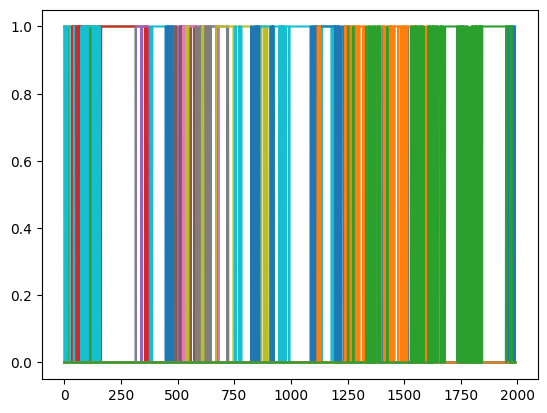

In [53]:
from matplotlib.pyplot import plot
plot(range(0,len(classes_pred)),[x for x in classes_pred])

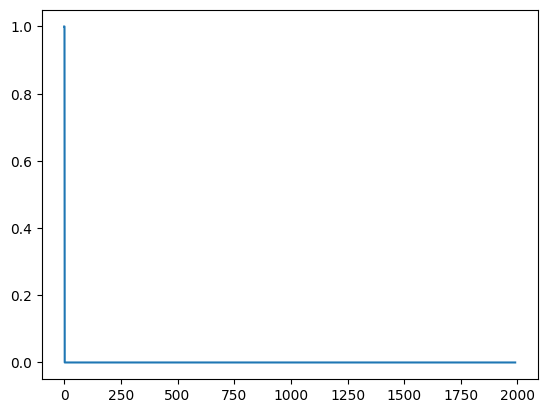

In [54]:
plot(range(0,len(classes_pred)),[x[0] for x in classes_pred])

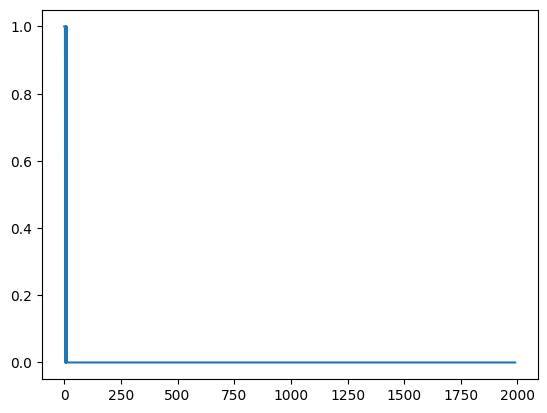

In [55]:
plot(range(0,len(classes_pred)),[x[1] for x in classes_pred])

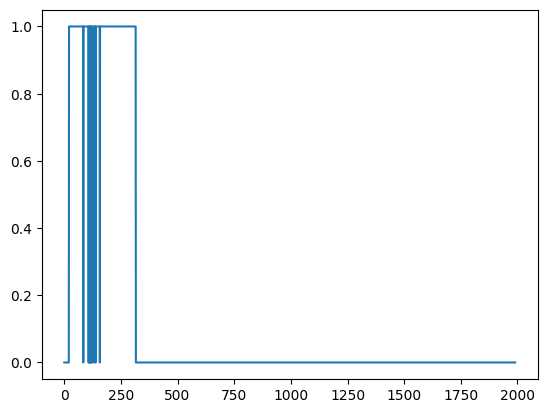

In [56]:
plot(range(0,len(classes_pred)),[x[2] for x in classes_pred])

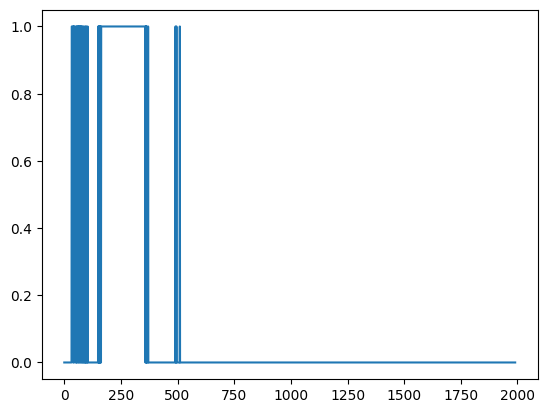

In [57]:
plot(range(0,len(classes_pred)),[x[3] for x in classes_pred])

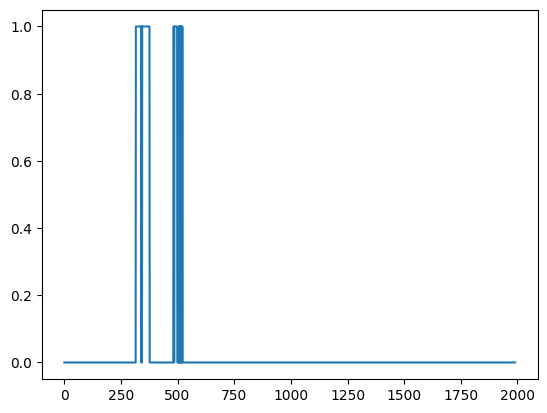

In [58]:
plot(range(0,len(classes_pred)),[x[4] for x in classes_pred])

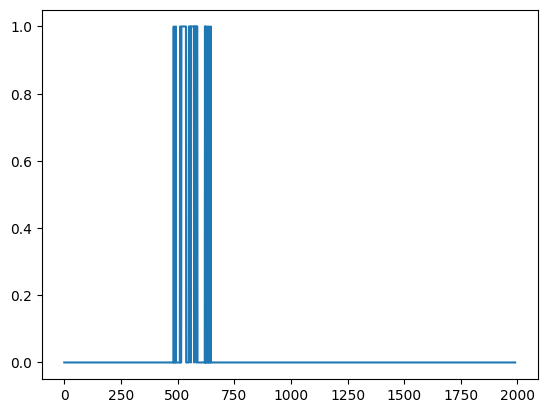

In [59]:
plot(range(0,len(classes_pred)),[x[5] for x in classes_pred])

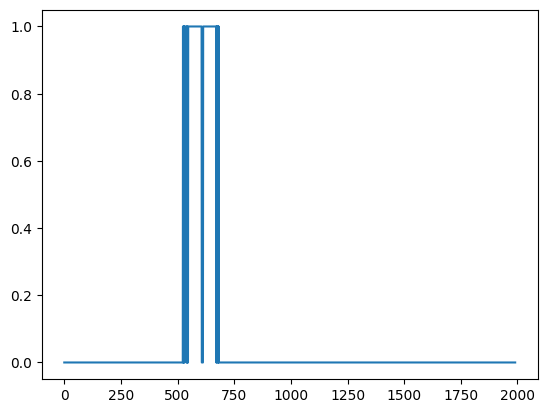

In [60]:
plot(range(0,len(classes_pred)),[x[6] for x in classes_pred])

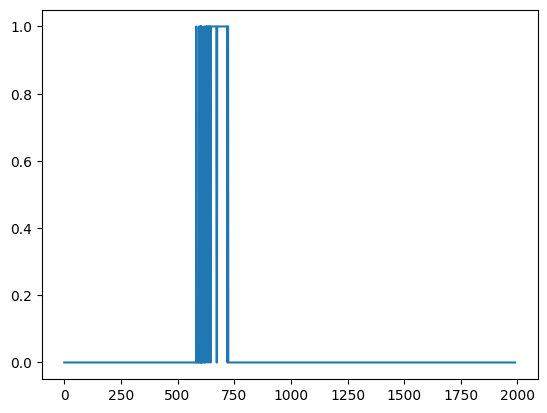

In [61]:
plot(range(0,len(classes_pred)),[x[7] for x in classes_pred])

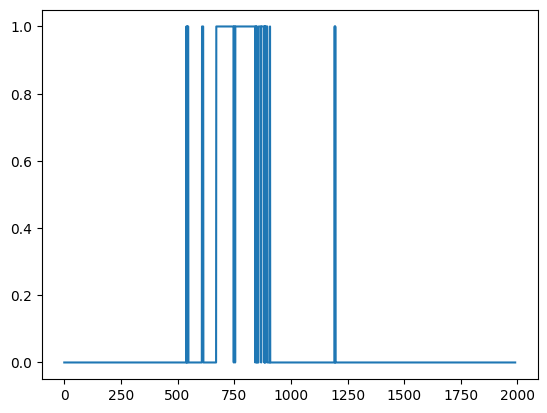

In [62]:
plot(range(0,len(classes_pred)),[x[8] for x in classes_pred])

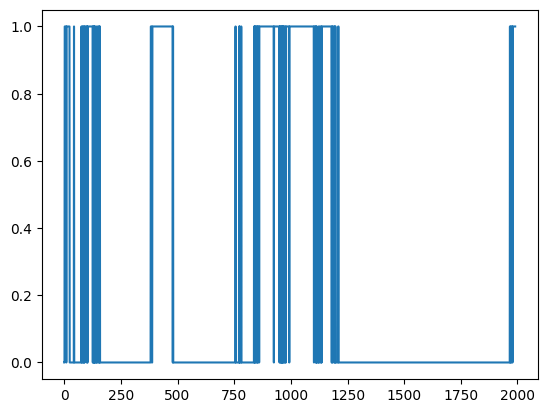

In [63]:
plot(range(0,len(classes_pred)),[x[9] for x in classes_pred])

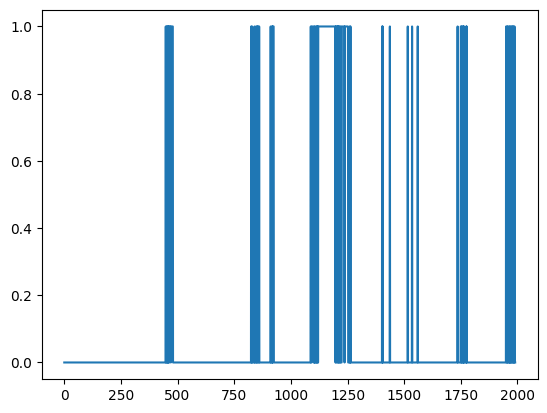

In [64]:
plot(range(0,len(classes_pred)),[x[10] for x in classes_pred])

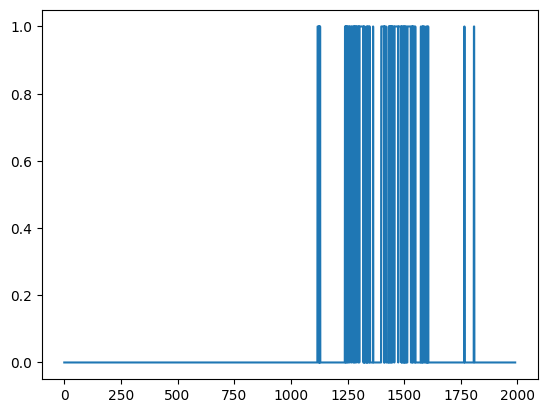

In [65]:
plot(range(0,len(classes_pred)),[x[11] for x in classes_pred])

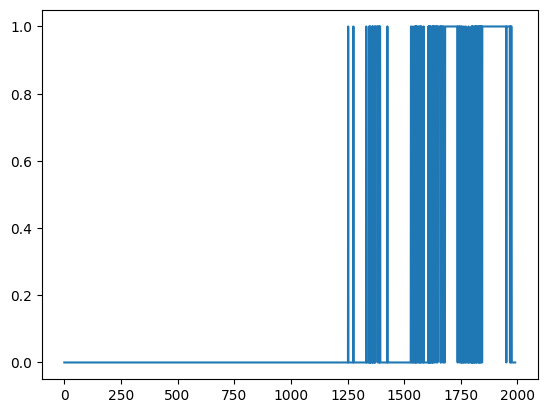

In [66]:
plot(range(0,len(classes_pred)),[x[12] for x in classes_pred])

# Estas pruebas son para que haga la predicción supuestamente de una sola clase para ver si esto mejora los resultados en la predicción con solo una clase

In [ ]:
dbTest_027 = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest_027 = dbTest_027.dataloaders(dfTotal,bs=4)